In [1]:
import pandas as pd
import json
import re
import numpy as np

from sklearn.externals import joblib
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
import string
import spacy

In [2]:
pd.set_option('display.max_columns', 50)

## Processing raw Enron email data

See notebook `02-download-enron-data.ipynb` for code to download the Enron email dataset.

In [422]:
with open('enron.mbox.json', 'r') as json_data:
    emails_raw = json.load(json_data)

Remove emails without receivers.

In [423]:
emails = []
index = []
for idx, email in enumerate(emails_raw):
    if 'To' in email:
        emails.append(email)
        index.append(idx)

Some emails have the same sender and receiver. Let's remove those emails.

In [424]:
another_index = []
for idx, email in enumerate(emails):
    if email['From'] != email['To'][0]:
        another_index.append(idx)
        
emails = [emails[i] for i in another_index]

Remove emails not from `@enron.com`, as these are often spam, listserv or subscription emails.

In [425]:
enron_only = []
for idx, email in enumerate(emails):
    if email['From'].endswith('@enron.com'):
        enron_only.append(idx)
        
emails = [emails[i] for i in enron_only]

Remove forwarded emails, as these will give more noise than signal.

In [426]:
forwarded = []
for idx, email in enumerate(emails):
    subject = email['Subject']
    if 'Fwd' not in subject:
        forwarded.append(idx)

emails = [emails[i] for i in forwarded]

Some emails actually contain the entire thread (i.e., all replies to the original email), and the text in the thread will affect downstream text analysis. Although a more sophisticated approach would be to save each part of the thread, for simplicity we will only save the latest email message, which is the text before double new line characters.

In [427]:
main_body = []
for email in emails:
    
    whole_msg = email['parts'][0]['content']
    
    #first check whether double new line and 'From: ' is present
    #if so, then string contains a response/is a thread
    
    substring_list = ['From: ', 'To: ']
    if any(substring in whole_msg for substring in substring_list):
    
        #finds all \n\n+ strings
        double_return_starts = []
        for m in re.finditer(r'\n\n+', whole_msg):
            double_return_starts.append(m.start())
            
        if double_return_starts:
            latest_msg = whole_msg[:double_return_starts[0]]
            main_body.append(latest_msg.strip())
        else:
            main_body.append(whole_msg)
    else:
        main_body.append(whole_msg)

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

"Ina,\n\n Can you pull Tori K.'s and Martin Cuilla's resumes and past performance \nreviews from H.R.\n\n---------------------- "

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'Ina,\n\n How many times do you think Jeff wants to get this message.  Please help\n\nPhillip\n---------------------- '

'Ina,\n I keep getting these security requests that I cannot approve.  Please take \ncare of this.\n\nPhillip\n\n\n\n\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'fyi  CIG\n\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'What are my choices for dates?\n---------------------- '

'What is GIS info?  Can you do this?\n\n\n\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'Laird,\n\n Did you meet with SWG on April 27th.  Are there any other asset management \ntargets in the west?\n\n\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

"Gary,\n\nHere is a photograph of a similar house.  The dimensions would be 56'Wide X 41' Deep for the living area.  In addition there will be a 6' deep two story porch across the entire back and 30' across the front.  A modification to the front will be the addition of a gable across 25' on the left side.  The living area will be brought forward under this gable to be flush with the front porch.  \n\nI don't have my floor plan with me at work today, but will bring in tomorrow and fax you a copy.\n\nPhillip Allen\n713-853-7041\npallen@enron.com\n\n---------------------- "

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'Should I appeal to Skilling.\n\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'Can you guys coordinate to make sure someone listens to this conference call \neach week.  Tara from the fundamental group was recording these calls when \nthey happened every day.\n\nPhillip\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

"Gary,\n\nHere is a photograph of a similar house.  The dimensions would be 56'Wide X \n41' Deep for the living area.  In addition there will be a 6' deep two story \nporch across the entire back and 30' across the front.  A modification to the \nfront will be the addition of a gable across 25' on the left side.  The \nliving area will be brought forward under this gable to be flush with the \nfront porch.  \n\nI don't have my floor plan with me at work today, but will bring in tomorrow \nand fax you a copy.\n\nPhillip Allen\n713-853-7041\npallen@enron.com\n\n---------------------- "

'---------------------- '

'---------------------- '

'Ina, \n\nCan you please forward the presentation to Mog.\n\nPhillip\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'Do you have a distribution list to send this to all the traders.\n\nPhillip\n---------------------- '

'Ina, \n\nCan you please forward the presentation to Mog.\n\nPhillip\n---------------------- '

'---------------------- '

'Cary,\n\nHere is the picture of the house I have in mind.  I was going for a simple\nfarmhouse style to  place on 5 acres near Wimberley.\n\nA few points that might not be obvious from the plans are:\n\nThere will be a double porch across the back just like the front\nNo dormers (Metal roof)\n1/2 bath under stairs\nOverall dimensions are 55 by 40\n\n\nWhat I am looking for is a little design help in the kitchen.  More\ncabinets, maybe a different shaped island, and a way to enlarge the pantry.\nReagan\nsuggested that I find a way to make the exterior more attractive.  I want\nto keep a simple roof line to avoid leaks, but I was thinking about\nbringing the left\nside forward in the front of the house and place 1 gable in the front.\nThat might look good if the exterior was stone and stucco.  Also the front\nporch would\nbe smaller.\n\nI have 3 bids from builders all around $325,000.  I am ready to go ahead\nand have the plans done so I can spec out all the finishings and choose a\nbui

'---------------------- '

'---------------------- '

'Cary,\n\nHere is the picture of the house I have in mind.  I was going for a simple \nfarmhouse style to  place on 5 acres near Wimberley.  \n\nA few points that might not be obvious from the plans are:\n\nThere will be a double porch across the back just like the front\nNo dormers (Metal roof)\n1/2 bath under stairs\nOverall dimensions are 55 by 40\n\n\nWhat I am looking for is a little design help in the kitchen.  More cabinets, \nmaybe a different shaped island, and a way to enlarge the pantry.    Reagan \nsuggested that I find a way to make the exterior more attractive.  I want to \nkeep a simple roof line to avoid leaks, but I was thinking about bringing the \nleft\nside forward in the front of the house and place 1 gable in the front.  That \nmight look good if the exterior was stone and stucco.  Also the front porch \nwould \nbe smaller.\n\nI have 3 bids from builders all around $325,000.  I am ready to go ahead and \nhave the plans done so I can spec out all the finishings and

'---------------------- '

'---------------------- '

'Grif,\n\nPlease provide a temporary id\n\nPhillip\n---------------------- '

"Reagan,\n\n Here is a photograhph of the house I have in mind.\n\n Specific features include:\n\n Stained and scored concrete floors downstairs\n Wood stairs\n Two story porches on front and rear\n Granite counters in kitchens and baths\n Tile floors in upstairs baths\n Metal roof w/ gutters (No dormers)\n Cherry or Maple cabinets in kitchen & baths\n Solid wood interior doors\n Windows fully trimmed\n Crown molding in downstairs living areas\n 2x6 wall on west side\n\n Undecided items include:\n\n Vinyl or Aluminum windows\n Wood or carpet in upstairs bedrooms and game room\n Exterior stucco w/ stone apron and window trim  or rough white brick on 3-4 \nsides\n \n \n I have faxed you the floor plans.  The dimensions may be to small to read.  \nThe overall dimensions are 55' X 40'.  For a total of 4400 sq ft under roof, \nbut \n only 3800 of livable space after you deduct the garage.  \n\n Are there any savings in the simplicity of the design?  It is basically a \nbox with a simple roo

'---------------------- '

"Jacques,\n\nHere is Larry Lewter's response to my request for more documentation to \nsupport the $15,000.  As you will read below, it is no longer an issue.  I \nthink that was the last issue to resolve. \n\nPhillip\n\n\n---------------------- "

'Ina,\n\nCan you help me approve this request?\n\nPhillip\n\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

"Jacques,\n\nGeorge finally sent me some information.  Please look over his email.  He \nwants us to buy him out.  Keith and I think this is a joke.  \n\nWe still need to speak to his engineer and find out about his soil study to \ndetermine if it has any value going forward.  I don't believe the architect \nwork will be of any use to us.  I don't think they deserve any compensation \nfor their time due to the fact that intentional or not the project they were \nproposing was unsupportable by the market.  \n\nMy version of a buyout is attached.\n\nI need your expert advise.  I am ready to offer my version or threaten to \nforeclose.  Do they have a case that they are due money for their time?  \nSince their cost\nand fees didn't hold up versus the market and we didn't execute a contract, I \nwouldn't think they would stand a chance.  There isn't any time to waste so I \nwant to respond to their offer asap.\n\nCall me with your thoughts.\n\nPhillip\n\n\n\n\n---------------------- "

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'John,\n\nDid you put Frank Hayden up to this?  If this decision is up to me I would \nconsider authorizing Mike G., Frank E., Keith H. and myself to trade west \npower.  What do you think?\n\nPhillip\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

"Christy,\n\n I read these points and they definitely need some touch up.  I don't \nunderstand why we need to give our commentary on  why prices are so high in \nCalifornia.  This subject has already gotten so much press.  \n\nPhillip\n\n\n\n\n\n\n---------------------- "

"Jeff,\n\nHere is the application from SPB.  I guess they want to use the same form as \na new loan application.  I have a call in to Lee O'Donnell to try to find out \nif there is a shorter form.  What do I need to be providing to the buyer \naccording to the contract.  I was planning on bringing a copy of the survey \nand a rentroll including deposits on Monday.  Please let me know this morning \nwhat else I should be putting together.\n\n\nPhillip\n\n\n---------------------- "

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'I would like to go to this meeting.  Can you arrange it?\n\n\n---------------------- '

'Testing.  Sell low and buy high\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'Griff,\n  \nCan you accomodate Dexter as we have in the past.  This has been very helpful \nin establishing a fair index at Socal Border.\n\nPhillip\n\nPlease cc me on the email with a guest password.  The sooner the better as \nbidweek is underway.\n\n---------------------- '

'---------------------- '

'Patti,\n\nThis sounds like an opportunity to land a couple of analyst to fill the gaps \nin scheduling.  Remember their rotations last for one year.  Do you want to \nbe an interviewer?\n\nPhillip\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'Jeff,\n\nHere is a recent rentroll.  I understand another looker went to the \nproperty.  I want to hear the feedback no matter how discouraging. I am in \nPortland for the rest of the week.  You can reach me on my cell phone \n713-410-4679.  My understanding was that you would be overnighting some \nclosing statements for Leander on Friday.  Please send them to my house (8855 \nMerlin Ct, Houston, TX 77055).\n\nCall me if necessary.\n\nPhillip\n\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'Can you guys coordinate to make sure someone listens to this conference call each week.  Tara from the fundamental group was recording these calls when they happened every day.\n\nPhillip\n---------------------- '

'Ina,\n\n Where can we put Barry T.?\n\nPhillip\n\n\n\n\n\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

"Ina,\n\n Can you pull Tori K.'s and Martin Cuilla's resumes and past performance \nreviews from H.R.\n\n---------------------- "

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'Ina,\n\n Where can we put Barry T.?\n\nPhillip\n\n\n\n\n\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

"Christy,\n\n I read these points and they definitely need some touch up.  I don't \nunderstand why we need to give our commentary on  why prices are so high in \nCalifornia.  This subject has already gotten so much press.  \n\nPhillip\n\n\n\n\n\n\n---------------------- "

"Phillip--To the extent that we can give Chair Hoecker our spin on the reasons \nfor the hikes, we would like to.  The Commission is getting calls from \nlegislators, DOE, etc. about the prices and is going to have to provide some \nresponse.  Better if it coincides with Enron's view and is not anti-market.  \nWe still haven't decided what we will provide.  You definitely will be \nincluded in that discussion once we get the numbers from accounting.  Thanks.\n\n\n   \n\t\n\t\n\tFrom:  Phillip K Allen                           12/12/2000 12:03 PM\n\t\n\nTo: Christi L Nicolay/HOU/ECT@ECT\ncc:  \n\nSubject: Talking points about California Gas market\n\nChristy,\n\n I read these points and they definitely need some touch up.  I don't \nunderstand why we need to give our commentary on  why prices are so high in \nCalifornia.  This subject has already gotten so much press.  \n\nPhillip\n\n\n\n\n\n\n---------------------- "

'---------------------- '

'---------------------- '

'---------------------- '

'Phillip-\n\nSorry that I missed you on the first pass:\n\n---------------------- '

'---------------------- '

'Should I appeal to Skilling.\n\n---------------------- '

'FYI.\n---------------------- '

'----- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'Jeff,\n\nHere is a recent rentroll.  I understand another looker went to the \nproperty.  I want to hear the feedback no matter how discouraging. I am in \nPortland for the rest of the week.  You can reach me on my cell phone \n713-410-4679.  My understanding was that you would be overnighting some \nclosing statements for Leander on Friday.  Please send them to my house (8855 \nMerlin Ct, Houston, TX 77055).\n\nCall me if necessary.\n\nPhillip\n\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'Patti,\n\nThis sounds like an opportunity to land a couple of analyst to fill the gaps \nin scheduling.  Remember their rotations last for one year.  Do you want to \nbe an interviewer?\n\nPhillip\n---------------------- '

'---------------------- '

'Griff,\n  \nCan you accomodate Dexter as we have in the past.  This has been very helpful \nin establishing a fair index at Socal Border.\n\nPhillip\n\nPlease cc me on the email with a guest password.  The sooner the better as \nbidweek is underway.\n\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'Testing.  Sell low and buy high\n---------------------- '

'I would like to go to this meeting.  Can you arrange it?\n\n\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

"Jeff,\n\nHere is the application from SPB.  I guess they want to use the same form as \na new loan application.  I have a call in to Lee O'Donnell to try to find out \nif there is a shorter form.  What do I need to be providing to the buyer \naccording to the contract.  I was planning on bringing a copy of the survey \nand a rentroll including deposits on Monday.  Please let me know this morning \nwhat else I should be putting together.\n\n\nPhillip\n\n\n---------------------- "

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'John,\n\nDid you put Frank Hayden up to this?  If this decision is up to me I would \nconsider authorizing Mike G., Frank E., Keith H. and myself to trade west \npower.  What do you think?\n\nPhillip\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

"Jacques,\n\nGeorge finally sent me some information.  Please look over his email.  He \nwants us to buy him out.  Keith and I think this is a joke.  \n\nWe still need to speak to his engineer and find out about his soil study to \ndetermine if it has any value going forward.  I don't believe the architect \nwork will be of any use to us.  I don't think they deserve any compensation \nfor their time due to the fact that intentional or not the project they were \nproposing was unsupportable by the market.  \n\nMy version of a buyout is attached.\n\nI need your expert advise.  I am ready to offer my version or threaten to \nforeclose.  Do they have a case that they are due money for their time?  \nSince their cost\nand fees didn't hold up versus the market and we didn't execute a contract, I \nwouldn't think they would stand a chance.  There isn't any time to waste so I \nwant to respond to their offer asap.\n\nCall me with your thoughts.\n\nPhillip\n\n\n\n\n---------------------- "

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'Ina,\n\nCan you help me approve this request?\n\nPhillip\n\n---------------------- '

"Jacques,\n\nHere is Larry Lewter's response to my request for more documentation to \nsupport the $15,000.  As you will read below, it is no longer an issue.  I \nthink that was the last issue to resolve. \n\nPhillip\n\n\n---------------------- "

'---------------------- '

'---------------------- '

"Reagan,\n\n Here is a photograhph of the house I have in mind.\n\n Specific features include:\n\n Stained and scored concrete floors downstairs\n Wood stairs\n Two story porches on front and rear\n Granite counters in kitchens and baths\n Tile floors in upstairs baths\n Metal roof w/ gutters (No dormers)\n Cherry or Maple cabinets in kitchen & baths\n Solid wood interior doors\n Windows fully trimmed\n Crown molding in downstairs living areas\n 2x6 wall on west side\n\n Undecided items include:\n\n Vinyl or Aluminum windows\n Wood or carpet in upstairs bedrooms and game room\n Exterior stucco w/ stone apron and window trim  or rough white brick on 3-4 \nsides\n \n \n I have faxed you the floor plans.  The dimensions may be to small to read.  \nThe overall dimensions are 55' X 40'.  For a total of 4400 sq ft under roof, \nbut \n only 3800 of livable space after you deduct the garage.  \n\n Are there any savings in the simplicity of the design?  It is basically a \nbox with a simple roo

'Grif,\n\nPlease provide a temporary id\n\nPhillip\n---------------------- '

'---------------------- '

'---------------------- '

'Laird,\n\n Did you meet with SWG on April 27th.  Are there any other asset management \ntargets in the west?\n\n\n---------------------- '

'Cary,\n\nHere is the picture of the house I have in mind.  I was going for a simple \nfarmhouse style to  place on 5 acres near Wimberley.  \n\nA few points that might not be obvious from the plans are:\n\nThere will be a double porch across the back just like the front\nNo dormers (Metal roof)\n1/2 bath under stairs\nOverall dimensions are 55 by 40\n\n\nWhat I am looking for is a little design help in the kitchen.  More cabinets, \nmaybe a different shaped island, and a way to enlarge the pantry.    Reagan \nsuggested that I find a way to make the exterior more attractive.  I want to \nkeep a simple roof line to avoid leaks, but I was thinking about bringing the \nleft\nside forward in the front of the house and place 1 gable in the front.  That \nmight look good if the exterior was stone and stucco.  Also the front porch \nwould \nbe smaller.\n\nI have 3 bids from builders all around $325,000.  I am ready to go ahead and \nhave the plans done so I can spec out all the finishings and

'---------------------- '

'---------------------- '

'Cary,\n\nHere is the picture of the house I have in mind.  I was going for a simple\nfarmhouse style to  place on 5 acres near Wimberley.\n\nA few points that might not be obvious from the plans are:\n\nThere will be a double porch across the back just like the front\nNo dormers (Metal roof)\n1/2 bath under stairs\nOverall dimensions are 55 by 40\n\n\nWhat I am looking for is a little design help in the kitchen.  More\ncabinets, maybe a different shaped island, and a way to enlarge the pantry.\nReagan\nsuggested that I find a way to make the exterior more attractive.  I want\nto keep a simple roof line to avoid leaks, but I was thinking about\nbringing the left\nside forward in the front of the house and place 1 gable in the front.\nThat might look good if the exterior was stone and stucco.  Also the front\nporch would\nbe smaller.\n\nI have 3 bids from builders all around $325,000.  I am ready to go ahead\nand have the plans done so I can spec out all the finishings and choose a\nbui

'---------------------- '

'Do you have a distribution list to send this to all the traders.\n\nPhillip\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'Ina, \n\nCan you please forward the presentation to Mog.\n\nPhillip\n---------------------- '

'---------------------- '

'---------------------- '

"Gary,\n\nHere is a photograph of a similar house.  The dimensions would be 56'Wide X \n41' Deep for the living area.  In addition there will be a 6' deep two story \nporch across the entire back and 30' across the front.  A modification to the \nfront will be the addition of a gable across 25' on the left side.  The \nliving area will be brought forward under this gable to be flush with the \nfront porch.  \n\nI don't have my floor plan with me at work today, but will bring in tomorrow \nand fax you a copy.\n\nPhillip Allen\n713-853-7041\npallen@enron.com\n\n---------------------- "

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'Can you guys coordinate to make sure someone listens to this conference call \neach week.  Tara from the fundamental group was recording these calls when \nthey happened every day.\n\nPhillip\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'What is GIS info?  Can you do this?\n\n\n\n---------------------- '

'What are my choices for dates?\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'fyi  CIG\n\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'Ina,\n I keep getting these security requests that I cannot approve.  Please take \ncare of this.\n\nPhillip\n\n\n\n\n---------------------- '

'Ina,\n\n How many times do you think Jeff wants to get this message.  Please help\n\nPhillip\n---------------------- '

'---------------------- '

'Phillip\nGood Morning! I hope you had a wonderful Thanksgiving with your family and safe travels.\n\nAs per our meeting on Tuesday, please identify people you think will be good for the expert story roles. You can provide me a list and either contact them first or provide me with an introduction to get their commitment. Thanks a million in advance for your continued support of this project.\n\nCheers\nKirk\n---------------------- '

'Michelle\nHere are my very minor comments. However we still need to wait on any additions, based on meeting with SME\'s today. One concern is the firing of the learner who performs  bad in the final two scenarios. Do we face any copyright issues using the CNN type themes? In addition, I think we need to stay clear of anything that remotely seems like California or anything that really happen with Enron? (i.e. So-cal Waha) In addition, comments on regulatory issues may be a problem (i.e. California Legislature).\n\nSheri\n\nWhen you read all the scripts together and due to the similar mechanics being taught it appears very repetitious. Thus I do believe we need to maybe use a "Dateline" type theme for one, and a "60 Minute" type theme for another scenario vice just the CNN type theme. In the last two scenarios can we include a promotion out of the associate program for the stellar performers (i.e. title change to manager)? \n\n\n \n\nCheers Kirk\n---------------------- '

"Team\nFYI\n\nSheri\nThe 3 SME's that have already committed to being on film need to be keep in the lope regarding the timeline. Also check with these 2 SME's for additional candidates (i.e. check with Mark Reese to see if Lamar Frazier would be interested). I would like to be conferenced in on the media calls & meetings. Also cc me on their emails or forward to me  their  emails. This will keep me in the loop. Thanks\n\nPhillip\nIf you have some additional people in mind, we need them identified as soon as possible. Thanks\n\nCheers\nKirk\n---------------------- "

'-----Original Message-----\nFrom: \tHawkins, Bernadette  \nSent:\tWednesday, June 20, 2001 9:59 AM\nTo:\tWalton, Steve; Mara, Susan; Comnes, Alan; Lawner, Leslie; Cantrell, Rebecca; Fulton, Donna; Dasovich, Jeff; Nicolay, Christi; Steffes, James; jalexander@gibbs-bruns.com; Allen, Phillip K.; Noske, Linda; Perrino, Dave; Black, Don; Frank, Robert; Miller, Stephanie; Tycholiz, Barry\nCc:\tlinda.noske@enron.com; Alamo, Joseph\nSubject:\tRe: Western Wholesale Activities - Gas & Power Conf. Call Privileged & Confidential Communication Attorney-Client Communication and Attorney Work Product Privileges Asserted\nImportance:\tHigh\n\nTHE MEETING TIME HAS BEEN CHANGED!!!!\n\nPLEASE MARK YOUR CALENDAR\nDate:\t\t\tEvery Thursday\nTime: \t\t\t7:30 AM Pacific, 9:30 AM Central, and 10:30 AM Eastern time\n Number: \t\t1-888-271-0949 \n Host Code:\t\t661877 (for Ray only)\n Participant Code:\t936022 (for everyone else)\n\n\n\n----- '

"-----Original Message-----\nFrom: \tPerrino, Dave  \nSent:\tWednesday, June 20, 2001 10:07 AM\nTo:\tHawkins, Bernadette\nCc:\tWalton, Steve; Mara, Susan; Comnes, Alan; Lawner, Leslie; Cantrell, Rebecca; Fulton, Donna; Dasovich, Jeff; Nicolay, Christi; Steffes, James; jalexander@gibbs-bruns.com; Allen, Phillip K.; Noske, Linda; Black, Don; Frank, Robert; Miller, Stephanie; Tycholiz, Barry; linda.noske@enron.com; Alamo, Joseph\nSubject:\tRe: Western Wholesale Activities - Gas & Power Conf. Call Privileged & Confidential Communication Attorney-Client Communication and Attorney Work Product Privileges Asserted\n\nBernadette,\n\nWill you be sending out an agenda before COB today?  I'd like to have a look before tomorrow morning if possible.\n\nThanks,\n\nDave\n\n\n\n06/20/2001 09:59 AM\nBernadette Hawkins@ENRON\nBernadette Hawkins@ENRON\nBernadette Hawkins@ENRON\n06/20/2001 09:59 AM\n06/20/2001 09:59 AM\nTo:\tSteve Walton/HOU/ECT@ECT, Susan J Mara/NA/Enron@ENRON, Alan Comnes/PDX/ECT@ECT, L

'Becky,\n\nHow about Wednesday morning at 10:30 am?\n\nPhillip\n\n -----Original Message-----\nFrom: \tCantrell, Rebecca  \nSent:\tMonday, June 25, 2001 11:09 AM\nTo:\tAllen, Phillip K.\nCc:\tLawner, Leslie; Fulton, Donna\nSubject:\tMeeting to discuss West gas desk "FERC messages"\n\nPhillip -- Would you have some time Wednesday afternoon to meet with Leslie Lawner and me (and Donna Fulton in the D.C. office by phone) to discuss what we could be doing for you at FERC in the next few months?\n\n---------------------- '

'Ina,\n\nCan you get a conference room on 32 for this meeting on Wednesday and let Becky Cantrell know.\n\nthank you\n -----Original Message-----\nFrom: \tCantrell, Rebecca  \nSent:\tMonday, June 25, 2001 2:22 PM\nTo:\tAllen, Phillip K.\nCc:\tLawner, Leslie; Fulton, Donna\nSubject:\tRE: Meeting to discuss West gas desk "FERC messages"\n\nWorks for us.  I\'ve scheduled 47C1 at 10:30.  If you\'d rather get a conference room on 32, just let me know.\n\nThanks.\n\n\n\nFrom:\tPhillip K Allen/ENRON@enronXgate on 06/25/2001 03:48 PM\nTo:\tRebecca W Cantrell/HOU/ECT@ECT\ncc:\t \n\nSubject:\tRE: Meeting to discuss West gas desk "FERC messages"\n\nBecky,\n\nHow about Wednesday morning at 10:30 am?\n\nPhillip\n\n -----Original Message-----\nFrom: \tCantrell, Rebecca  \nSent:\tMonday, June 25, 2001 11:09 AM\nTo:\tAllen, Phillip K.\nCc:\tLawner, Leslie; Fulton, Donna\nSubject:\tMeeting to discuss West gas desk "FERC messages"\n\nPhillip -- Would you have some time Wednesday afternoon to meet with L

"Matt,\n\nMake sure this is included in your long term forecast.\n\n\n\n -----Original Message-----\nFrom: \tCantrell, Rebecca  \nSent:\tTuesday, July 10, 2001 12:18 PM\nTo:\tMiller, Stephanie; Tycholiz, Barry; Allen, Phillip K.; Tholt, Jane M.; Comnes, Alan; Nicolay, Christi; Perrino, Dave; Black, Don; Fulton, Donna; Sharp, Greg; Steffes, James; Dasovich, Jeff; Thome, Jennifer; Lawner, Leslie; Courtney, Mark; Kaufman, Paul; Alvarez, Ray; Frank, Robert; Gahn, Scott; Walton, Steve; Mara, Susan\nSubject:\tEl Paso Announces Binding Open Season for Additional Capacity on Line 2000\n\nAlso posted today on El Paso's web site.\n---------------------- "

'-----Original Message-----\nFrom: \tNicolay, Christi  \nSent:\tWednesday, July 18, 2001 6:25 AM\nTo:\tLawner, Leslie; Cantrell, Rebecca W.; Pharms, Melinda; Novosel, Sarah; Steffes, James; Allen, Phillip K.\nSubject:\tComplaint Against El Paso\n\nFYI\n---------------------- '

'Janie,\n\nDo you want to work with regulatory to make sure we can comply?\n\n\n -----Original Message-----\nFrom: \tAlvarez, Ray  \nSent:\tThursday, July 26, 2001 1:41 PM\nTo:\tAllen, Phillip K.\nSubject:\tFERC Order on Reporting CA gas sales\n\nPhillip,  thought this might be of interest.  Ray\n\n---------------------- '

"Mark,\n\nThe planned mountain bike activity is on Beaver Creek Mountain.  Do you know what kind of trails are there?  There is a break on Saturday after lunch.  The trails at Vail sound great.  Hunter and I would definitely be up for trying them out.   Let's set it up.  Let me know if you can book a side trip or if you want me to try.\n\nThanks,\n\nPhillip \n -----Original Message-----\nFrom: \tWhitt, Mark   On Behalf Of Mark Whitt/DEN/ECT@ENRON\nSent:\tWednesday, August 01, 2001 7:37 AM\nTo:\tAllen, Phillip K.\nSubject:\tMessage from John and Louise - Enron Americas Management Offsite\n\nDo you know what they are planning for Mountain Biking?  Hopefully it is not just paved bike trails.  If you and Hunter want to we can schedule a side trip if we get a break.  The trails at Vail are the ones they use for the World Cup Championships.  The downhill is awsome.  Let me know.\n\nMark\n----- "

'Vail sounds good.  If we are only going downhill our legs shouldn\'t be too wiped out after the morning.  We will be on rented bikes, but I\'m sure we can keep them for the day.\n\n -----Original Message-----\nFrom: \tWhitt, Mark   On Behalf Of Mark Whitt/DEN/ECT@ENRON\nSent:\tWednesday, August 08, 2001 2:19 PM\nTo:\tAllen, Phillip K.\nSubject:\tRE: Message from John and Louise - Enron Americas Management Offsite\n\nI don\'t know much about the Beaver Creek trails although I am sure they are decent.  Barry heard we will all being doing down hill only at Beaver Creek, so we must be riding the chairlifts.  Saturday afternoon at Vail sounds great.  I can bring my truck and we can just drive over with the bikes.  The trails are well marked and we can either ride up or do the chair lifts there.  Depends on what you guys think you want to ride.  We could do a couple of cross country trails and then hit the world cup downhill or we we could do all downhill there as well.  I am open. \nAre yo

"Kirk,\n\nAndy Lewis, a director on the Central Desk, has agreed to participate as a content SME.  I plan on being heavily involved in reviewing the content as well.\n\nPhillip\n\n -----Original Message-----\nFrom: \tMcDaniel, Kirk  \nSent:\tMonday, August 13, 2001 3:19 PM\nTo:\tAllen, Phillip K.; Arnold, John; Quigley, Dutch\nCc:\tKaminski, Vince J; Reese, Mark; O'rourke, Tim; Frolov, Yevgeny\nSubject:\tBasic Risk Management (BRM) Simulation Deal with Accenture\n\nPhillip, John & Dutch\nI want to personally thank you for supporting the BRM deal and I look forward to working with each of you to make this deal a success. I have provided the email below for your information.  The current next steps are as follows:\n\nYevgeny & I will meet with Vince Kaminski (tomorrow) to get his support as an Exec SME and get his nominee for content SME;\nPhillip will provide his nominee for content SME (by tomorrow);\nI will contact both Phillip's & Vince's content SME nominee (By Wednesday); and\nAll 

"These are fine.\n\n -----Original Message-----\nFrom: \tMcDaniel, Kirk  \nSent:\tTuesday, October 23, 2001 1:36 PM\nTo:\tAllen, Phillip K.; O'rourke, Tim; Frolov, Yevgeny\nSubject:\tTopic Framework Deliverable - Sign-Off for Acceptance\nImportance:\tHigh\n\nGentlemen\n\nGood day. I hope all is going well. \n\nIf I do not hear from you by COB tomorrow I will take your silence as acceptance and that their are no non-conformities to prevent acceptance of this deliverable. This action is necessary as contractually we are coming to the end of the acceptance period for this deliverable. \n\nGood news is that this deliverable and the High level design deliverable are the last two deliverables for the Design Phase of the project. Thanks\n\nCheers\nKirk\n---------------------- "

'---------------------- '

'Can you guys coordinate to make sure someone listens to this conference call each week.  Tara from the fundamental group was recording these calls when they happened every day.\n\nPhillip\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

"Gary,\n\nHere is a photograph of a similar house.  The dimensions would be 56'Wide X 41' Deep for the living area.  In addition there will be a 6' deep two story porch across the entire back and 30' across the front.  A modification to the front will be the addition of a gable across 25' on the left side.  The living area will be brought forward under this gable to be flush with the front porch.  \n\nI don't have my floor plan with me at work today, but will bring in tomorrow and fax you a copy.\n\nPhillip Allen\n713-853-7041\npallen@enron.com\n\n---------------------- "

'---------------------- '

'---------------------- '

'Ina, \n\nCan you please forward the presentation to Mog.\n\nPhillip\n---------------------- '

'---------------------- '

'Jim,\n\nI read through the data request.  We cannot provide several of the items that they requested.  We do not break out our california deals into separate transport and commodity components.  Also the majortiy of our buys and sells net out without exchanging actual transport contract numbers.  I know in the past Becky C. has worked with our back office to pull the data directly from the system.  Let me know if I need to do anything to assist gathering the data.  I would  like to review the final product before it is submitted.\n\nPhillip\n\n -----Original Message-----\nFrom: \tSteffes, James  \nSent:\tTuesday, May 15, 2001 2:14 PM\nTo:\tCantrell, Rebecca\nCc:\tNicolay, Christi; Novosel, Sarah; Fulton, Donna; Lawner, Leslie; Shapiro, Richard; Sanders, Richard; Williams, Robert C.; Allen, Phillip K.; Belden, Tim; Black, Don; Sharp, Vicki; Sager, Elizabeth; Frank, Robert; Hodge, Jeffrey\nSubject:\tFERC REQUEST - PLEASE COORDINATE WITH LEGAL AND BUSINESS\n\nBecky --\n\nPls take the lea

'Do you want to send someone to this?\n -----Original Message-----\nFrom: \tSteffes, James  \nSent:\tTuesday, June 05, 2001 5:51 AM\nTo:\tAllen, Phillip K.\nSubject:\tWorkshop on Energy Modeling Forum - Impact of Climate Change\n\nPhillip --\n\nAny interest in sending someone from your fundamentals desk to cover this meeting?  May be a good opportunity to hear from the leading "experts" on the subject.  May want to present a basic outline of our fundamental analysis.\n\nPlease let me know.\n\nJim\n\n---------------------- '

"how about 4:00?\n\n\n\n\nIna Rangel\n10/16/2000 11:03 AM\nTo: John Arnold/HOU/ECT@ECT\ncc:  \nSubject: John Arnold's PC\n\nJohn,\nWhen would be a good time for you.  After work maybe?\n\nIna\n---------------------- "

"I can't get into this....any ideas?\n---------------------- "

'I will not be able to attend\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Airam Arteaga                           10/11/2000 09:17 AM\n\t\n\nTo: Phillip K Allen/HOU/ECT@ECT, Thomas A Martin/HOU/ECT@ECT, Scott \nNeal/HOU/ECT@ECT, John Arnold/HOU/ECT@ECT, Ted Murphy/HOU/ECT@ECT, Vladimir \nGorny/HOU/ECT@ECT, Frank Hayden/Corp/Enron@Enron\ncc: Rita Hennessy/NA/Enron@Enron, Ina Rangel/HOU/ECT@ECT, Laura \nHarder/Corp/Enron@Enron, Kimberly Brown/HOU/ECT@ECT, Araceli \nRomero/NA/Enron@Enron, Kay Chapman/HOU/ECT@ECT \nSubject: Var, Reporting and Resources Meeting\n\nREMINDER - Please see below.\n---------------------- '

'---------------------- '

'I was long 4000 X @ 4902, then I switched it from X to F at the same price.  \nI switched it at 5000, but it puts me into the F at a price basis of 4902.  \nSorry for the confusion. \n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Kevin M Presto                           10/05/2000 10:12 AM\n\t\n\nTo: John Arnold/HOU/ECT@ECT\ncc:  \nSubject: Re:\n\nMy book indicates you have 4000F (Jan 01) at $5.00.\n---------------------- '

'Something to take a look at\n---------------------- '

"Thanks\n\n\n   \n\t\n\t\n\tFrom:  Jennifer Fraser                           10/04/2000 11:10 AM\n\t\n\nTo: John Arnold/HOU/ECT@ECT\ncc:  \nSubject: RE: WEFA's Outlook for Natural Gas\n\n\n---------------------- "

'Can you handle this.  Please forward all names on the daily P&L sheet.  I get \na copy every day if you need.\n---------------------- '

'Can you swap me with Fletch.  Try to make all of my interviews as late as \npossible.  \nThx\nJohn\n---------------------- '

'---------------------- '

'Joe:\nI just wanted to run this past you...\nJohn\n---------------------- '

'---------------------- '

"I'm not sure what is happening on my position.  It may have to do with how \nyou shaped the forward vol and price curves at each level.  My VAR is so \ndependent on spread levels and vols that a small change in the Jan vols could \nproduce that effect.  \nThe results certainly provide evidence of a need for higher VAR going into \nthe winter.\nJohn\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Frank Hayden @ ENRON                           09/15/2000 06:32 PM\n\t\n\nTo: John J Lavorato/Corp/Enron@Enron, John Arnold/HOU/ECT@ECT\ncc: Vladimir Gorny/HOU/ECT@ECT, Sunil Dalal/Corp/Enron@ENRON \nSubject: Stress Test\n\nThe below file shows the results of the two stress test requested.  Under the \n$7 dollar stress, NYMEX curve was shifted to $7 dollars with all other price \ncurves proportionally shifted.  Under the $9 dollar test, not only were the \nprice curves shifted, but volatilites were stressed as well with NYMEX \nvolatility going to 100% and all other vol locations being rai

"Thanks.  This is exactly what I wanted.\nJohn\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Sunil Dalal @ ENRON                           09/20/2000 04:05 PM\n\t\n\nTo: John Arnold/HOU/ECT@ECT\ncc: Frank Hayden/Corp/Enron@Enron \nSubject: Re:  \n\nJohn, the matrix that was sent to you includes YTD P&L for all the traders in \nthe matrix.  Trader P&L contribution to desk P&L, however, was not backed out \non that particular matrix.  That matrix effectively shows one trader's \ncorrelation to all others.  What is does not show is one trader's P&L to the \ndesk P&L.  I have included a spreadsheet with each trader's P&L backed out of \nAGG-GAS P&L to demonstrate their relationship.  Please call Frank or myself \nif you have questions.  Thanks.\n\n\n\n\n   \n\t\n\t\n\tFrom:  Frank Hayden                           09/19/2000 06:42 PM\n\t\n\nTo: Sunil Dalal/Corp/Enron@ENRON\ncc:  \n\nSubject: Re:\n\nquestions and answers?\n---------------------- "

'can you please add this\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

"You're not done yet big boy.\n---------------------- "

'can yuo set me up for the 4:00 mtg\n---------------------- '

'---------------------- '

'Please take care of this\n---------------------- '

'---------------------- '

'all you big boy...\n---------------------- '

'Please take care of \n---------------------- '

'---------------------- '

'no thanks.  \n\n\n\n\nAndy Zipper@ENRON\n11/28/2000 08:25 AM\nTo: John Arnold/HOU/ECT@ECT\ncc:  \nSubject: Nymex Converter for Nov. 20 - 24\n\nDo you care about seeing this report ? I use it for general benchmarking. Let \nme know if you want to see it regularly.\n---------------------- '

'Can you handle this please?\n---------------------- '

'Fine\n\n\n\n\nIna Rangel\n08/22/2000 02:08 PM\nTo: Phillip K Allen/HOU/ECT@ECT, Hunter S Shively/HOU/ECT@ECT, Scott \nNeal/HOU/ECT@ECT, Fred Lagrasta/HOU/ECT@ECT, John Arnold/HOU/ECT@ECT, Thomas \nA Martin/HOU/ECT@ECT\ncc: Kimberly Brown/HOU/ECT@ECT, Airam Arteaga/HOU/ECT@ECT, Becky \nYoung/NA/Enron@Enron, Laura Harder/Corp/Enron@Enron \nSubject: ENA Fileplan Project - Needs your approval\n\nCarolyn Gilley who is a department head in our records management group has \nhired the firm, Millican & Assoicates to come in and compile all of our \ncurrent and archived files into a more suitable fileplan.  Enron has given \npermission for this firm to handle this, but they need further approval from \neach one of you to deal with your backoffice people and with your assistants \nin compiling this information to complete their project.  Below is a more \ndetailed letter from the firm explaining their work here.\n\nPlease respond to me that I have your approval to give for them to complete \nyo

'Ina:\n1.  Vacation is fine.\n2.  Please put meeting below on calendar.\n3. I am going to analyst presentation at Vanderbilt.  Find out when it is and \nput on calendar.\n4. Can you find out who is on the ENA management committee meeting I went to \nalong with their title and responsibilities.\n5. Can you schedule a meeting for Tuesday or Wednesday late afternoon with \nPhillip, Hunter, and Fletch about EOL\nThanks.\n---------------------- '

"Please tell me he's not analyzing bollinger bands.\n---------------------- "

'---------------------- '

'---------------------- '

'---------------------- '

'Yes, I  managed it while she was on vacation.\n\n\n\n\nDavid Forster@ENRON\n08/07/2000 10:01 AM\nTo: John Arnold/HOU/ECT@ECT\ncc:  \nSubject: HeHub Basis Sep00\n\nI note that Sandra Brawner is managing this product today, but your ID had it \nFriday night.\n\nDoes this sound right?\n\nDave\n\n---------------------- '

"I am leaving early on Friday.  If they want I'll try to talk to the kid for \n15 minutes around lunch.\nJohn\n---------------------- "

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

"thanks\n\n\nTo: John Arnold/HOU/ECT@ECT\ncc:  \nSubject: Re: FW: trading with Campbell  \n\nFYI. I spoke with Steve. Seems like they have not been successful with plan \nA, i.e. to get their investors to give them authority to trade OTC as well as \nfutures. They have moved on to plan B which is to take one of their domestic \nfunds (approx. $500mm under mgt) off the floor (futures only) and into OTC \ntrading. Still has the rating problem with Enron, but I am trying to get him \nto arrange a conference call with their CFO so I can discuss ways around it. \nHe will try to do so this week. Mind you, I left it at this point the last \ntime I spoke with him a couple of months ago and it seemed to stall. I'll \nkeep chasing it.  Per\n \n\n\n\nJohn Arnold\n07/07/2000 08:50 AM\nTo: Per Sekse/NY/ECT@ECT\ncc:  \nSubject: Re: FW: trading  \n\nPer:\nI've talked to him several times in the past.  I told him that you would call \nbecause of your experience with setting up funds.  They have two ma

'---------------------- '

"Margaret:\nAs you can imagine, most information and procedures on the floor are \nextremely confidential.  We look at the gas market uniquely and using \ndifferent tools than anybody else.  It is one of our competitive advantages.  \nI'm hesistant to approve the use of any documents for external purposes.  \nIf you provide more information about what you're trying to show, who the \ntarget audience is, and what format it will be presented, I may be able to \nhelp you.\nJohn\n\n\n\n\nMargaret Allen@ENRON\n07/13/2000 11:09 AM\nTo: Ann M Schmidt/Corp/Enron@ENRON, John Arnold/HOU/ECT@ECT\ncc:  \nSubject: Screen shots\n\nDid you get this?  My computer registered that it didn't go....delete if you \nalready did.\n\n---------------------- "

"Per:\nI've talked to him several times in the past.  I told him that you would call \nbecause of your experience with setting up funds.  They have two main \nproblems.   One is setting up their internal systems.  Second, they have \ncredit problems with a BBB+.\nPlease call and introduce yourself.\nThanks,\njohn \n\n\nTo: John Arnold/HOU/ECT@ECT\ncc:  \nSubject: Re: FW: trading  \n\nJohn, did you answer him or should I respond? Per\n\n\n\nJohn Arnold\n06/26/2000 05:18 PM\nTo: Per Sekse/NY/ECT@ECT\ncc:  \nSubject: FW: trading\n\n\n---------------------- "

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

"Russell:\nJust fyi, they're willing to take us for 20 years.\n---------------------- "

'is there a password or just knowing the address\n---------------------- '

'---------------------- '

'do you know what my user id and password are?\n---------------------- '

'---------------------- '

'can you take care of this...\n---------------------- '

"remind jim how the h/j/k spread acted this year.  granted it won't behave \nthat way again until close to expiry, but i like the j/k outright much moreso \nthan the condor.\n\n\n\n\nCaroline Abramo@ENRON\n04/30/2001 12:24 PM\nTo: John Arnold/HOU/ECT@ECT\ncc:  \nSubject: pulaski\n\n\n---------------------- "

'---------------------- '

'can you send jean a list of her seat numbers\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'i dont remember if we fixed these yet.\n---------------------- '

"Average volume is 35,000-40,000 on nymex of which about half is spreads.  So \naround 20,000 outrights trade.  We trade more than that on EOL.  Today's \nconditions 1000 lot market would be 3-4 cents wide.  have executed trades as \nlarge as 10,000 across a longer term and 1000 lot clips in the front \nfrequently.\n\n\n\n\nCaroline Abramo@ENRON\n04/12/2001 06:48 AM\nTo: John Arnold/HOU/ECT@ECT, Mike Maggi/Corp/Enron@Enron\ncc:  \nSubject: SUNRISE CAPITAL\n\nJohn/ Mike- could you give me a sense of the below on nat gas..\n\nthanks,\nca\n---------------------- "

'Errol:\nI did not write up these access trades from Friday.  Please make sure they \nare in.\nJohn\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

"planning on going.  which night are you inviting guys for?\n\nalso, heard there were some issues about contract negotiations.  don't know \nspecifics but if you want to discuss give me a call.  might be able to \nmediate this a little bit  if you want.\n\n\n\n\nCaroline Abramo@ENRON\n03/30/2001 03:37 PM\nTo: John Arnold/HOU/ECT@ECT, Mike Maggi/Corp/Enron@Enron\ncc:  \nSubject: Guggenheim/Enron Event May 24th\n\nI think you guys need to attend\n---------------------- "

'please add\n---------------------- '

'maybe.  hydro situation dire in west.  think water levels are at recent \nhistorical lows.  problem is from gas standpoint, west is an island right \nnow.  every molecle that can go there is.  so will provide limited support to \nprices in east.  hydro in east is actually very healthy.  would assume your \nmarkets are targeting eastern u.s. so i dont know if hydro problem in west is \nthat relevant.\n\n\n\n\nSarah Mulholland\n04/04/2001 08:09 AM\nTo: John Arnold/HOU/ECT@ECT\ncc:  \nSubject: Re: us fuel 4/2/01\n\ninteresting comment from singapore........\n\nhope things are going well up there.\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'please add\n---------------------- '

'---------------------- '

'Do you have interest in having a semi formal party at the guggenheim for our \nny counterparties?  was thinking it might be a good pr move.\n---------------------- '

"seeing no increase in physical demand from industrials.  however, they cant \nbuy enough paper.  energy customer deal flow has a conspicuous habit of \nbuying high and selling low.  seeing virtually no producer selling.  strip \nwill continue to be well supported through early spring.  last year customers \nsold all the way up, transferring their price risk to marketers and specs.  \nmarket for most part was very orderly move up during the summer.  volatility \nwas in the pukes because everybody was long.  now, customers are all buying.  \nmove down should be orderly as is met with a lot of short covering from trade \nand volatility should come from short covering moves like today's.  \nmarket waiting to see those first two injection numbers.  if we are beating \nlast year by 20 bcf, lights out.  move down may also scare producers to do \nsome term selling, putting pressure on whole curve.  \n\n\n\n\nslafontaine@globalp.com on 03/20/2001 03:21:41 PM\nTo: John.Arnold@enron.com\ncc:  \n

'i rsvp\n---------------------- '

'heffner how?\nwas pretty long coming into today just playing the range.  sold everything on \nthe way up.  will be s scale up seller probably through options.  certainly a \nshort squeeze in trade today and i don;t think anything changes tomorrow \nexcept maybe trade gets more confident in the short at the higher level and \nif cash rejects higher prices.  \nwill be buying lots of puts on the way up so i guess for me vol is not too \nhigh.  i was short vol and covered it all this morn.  think we could be in \nfor some turbulence here\n\n\n\n\nslafontaine@globalp.com on 03/20/2001 10:48:43 AM\nTo: jarnold@enron.com\ncc:  \nSubject: SCS Daily Volatility Report as of 3/19/01\n\n\n\nvol seems rich here for ngas no/ what do we do here with flat price? how was\ncabo?\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'thanks\n\n\n\n\nAndy Zipper@ENRON\n11/01/2000 08:00 AM\nTo: John Arnold/HOU/ECT@ECT\ncc:  \nSubject: Adam Resources\n\nFYI\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'Not impressive\n---------------------- '

"so according to your analysis, had we been at $2.5 gas and we were not \nbordering on a recession, we would have had the highest AGA number of \nrecorded history for this week, last week, or next week by 15 bcf?  seems a \nlittle far fetched to me.  Our analysis is saying: gas at 2.50 we would have \nhad 4.5 bcf a day more demand.  that includes commercial residential \nindustrial switching processing...    \nas far as 2 bcf/d  power gen demand- that counts the fact that last year was \nextremely mild versus expectation of normal summer this year, west will be \nrunning every gas unit virtually all hours as power demand is growing maybe \n5% still and hydro way down.  every molecule that can will flow west from \nwaha this summer versus little last year.  east power prices really havent \nreached point of priceing out demand and heat rates healthy enough to where \ngas can go up without raising power prices to cut demand.  some concern of \nmore efficient replacing less but hard to qu

'Are you around next Tuesday? \n---------------------- '

'Ina:\nCan you get this paid on a rush basis?\nthanks,john\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'Thank you.\n\n\n   \n\n\nFrom:  Sheri Thomas                                                           \n  02/20/2001 05:20 PM\t\n\t\n\t\n\t                           \n\t\n\nTo: John Arnold/HOU/ECT@ECT\ncc:  \nSubject: Re: ICE\n\nAttached below is the complete list of users on ICE by company.  Let me know \nif you have any questions.\n\nPer Andy, we are removing your access.\n\nSheri\n\n---------------------- '

'---------------------- '

'Please change as indicated\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

"yea, i'll talk to them.\n\nwho should i call?\n\n\n\n\nBrian Hoskins@ENRON COMMUNICATIONS\n10/25/2000 09:04 AM\nTo: John Arnold/HOU/ECT@ECT\ncc:  \nSubject: Re: Implementation issue on IE5.0/5.5\n\nJohn,\n\nLooks like IT has decided not to install Internet Explorer 5.5 after all.  \nThe program is ready to go as soon as that is installed.  Do you want to put \nsome pressure on them, or would you rather wait to see if they can fix it to \nwork on IE 5.0?  You have 5.5 by the way, so I'm not quite sure what the \nproblem is.  \n\n\nBrian\n\n\nBrian T. Hoskins\nEnron Broadband Services\n713-853-0380 (office)\n713-412-3667 (mobile)\n713-646-5745 (fax)\nBrian_Hoskins@enron.net\n\n\n----- "

'yea\n\n\n\n\nIna Rangel\n02/09/2001 02:03 PM\nTo: John Arnold/HOU/ECT@ECT\ncc:  \nSubject: Gas Message Board\n\nJohn,\n\nIs it okay to set up these guys on the gas message board?\n\n-Ina\n---------------------- '

"we need one more good shot of cool air to ensure complete and utter chaos for \nthe next 10 months.  hopefully this is it.  \nyou gotta love heffner...'if we take out the jan 31 low there is NO WAY \nanything bullish can happen'\n\n\n\n\n\nslafontaine@globalp.com on 02/08/2001 05:28:02 AM\nTo: jarnold@enron.com\ncc:  \nSubject: EarthSAT UPDATE\n\n\n\nthats what we wanna hear\n---------------------- "

'---------------------- '

'don\'t care about the front.  i think its vulnerable to a good short squeeze \nlike we saw on thruday and friday.  trade is getting short in here with cash \nsuch a piece.  if weather ever changes, which the weather boys are saying it \nmight in 2 weeks, the cash players are going to be big buyers.  don\'t really \nwant to carry length on the way down waiting for that to happen though.   \nBacks are crazy stong.  cal 3 traded as high as +10.  everybody a buyer as \ncalifornia trying to buy any fixed price energy they can find\n\n\n\n\nslafontaine@globalp.com on 02/06/2001 11:19:45 AM\nTo: John.Arnold@enron.com\ncc:  \nSubject: Re: daily charts and matrices as hot links 2/6\n\n\n\nthat made me laugh-good point. any strong view on ngas flat px? cuz i dont-but\nseems hard so see it rally much with cash such a dog.\n\n\n\n\nJohn.Arnold@enron.com on 02/06/2001 11:59:31 AM\n\nTo:   Steve LaFontaine/GlobalCo@GlobalCo\ncc:\nFax to:\nSubject:  Re: daily charts and matrices as hot links 2/6\n\n

'he sends me his stuff... i like him because he\'s willing to take a stand.  so \nmany technicians bullshit  their way "support at 5400-5600 but if it breaks \nthat look for 5250".  if every technician put specific trades on a sheet with \nentry and exit points and published them every day, a lot of people would be \nunemployed.\n\n\n\n\nslafontaine@globalp.com on 02/06/2001 07:24:43 AM\nTo: jarnold@enron.com\ncc:  \nSubject: daily charts and matrices as hot links 2/6\n\n\n\nyou mite already get this, if not ill be happy to forward so let me know.\ninteresting comments on both gas and crude for the timing of seasonal lows\n---------------------- '

'---------------------- '

'---------------------- '

'Mr Sturm:\nDue to the California power crisis, Enron Gas Trading is unable to extend \nsell authorization on options to Enron Power Trading.  Please call if you \nshould desire to sell any options and credit will be extended on a \ntrade-by-trade basis.  We apologize for any inconvience.\nSincerely:\nJohn Arnold\nVice President, Gas Trading\nEnron North America\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'Please respond to Jennifer\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'not me\n\n\n\n\nBrian Hoskins@ENRON COMMUNICATIONS\n10/23/2000 03:47 PM\nTo: John Arnold/HOU/ECT@ECT\ncc:  \nSubject: Re:\n\nNever mind.  Did you do that?\n\n\nBrian T. Hoskins\nEnron Broadband Services\n713-853-0380 (office)\n713-412-3667 (mobile)\n713-646-5745 (fax)\nBrian_Hoskins@enron.net\n\n\n----- '

'---------------------- '

"what's this about?\n---------------------- "

'Thanks...It just seems like all the time.\n\n\n\n\nAndy Zipper@ENRON\n10/24/2000 03:41 PM\nTo: John Arnold/HOU/ECT@ECT\ncc:  \nSubject: Re: Sunday\n\nFYI regarding Sunday outages.\n---------------------- '

'what is this???\n\n\n   \n\t\n\t\n\tFrom:  Jennifer Fraser                           12/27/2000 12:19 PM\n\t\n\nTo: Bill Berkeland/Corp/Enron@Enron, John Arnold/HOU/ECT@ECT, Jennifer \nShipos/HOU/ECT@ECT\ncc:  \nSubject: NG YEAR ENd Quiz\n\n\n---------------------- '

'---------------------- '

'Please approve Dutch for ICE\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Dutch Quigley                           12/22/2000 10:59 AM\n\t\n\nTo: John Arnold/HOU/ECT@ECT\ncc:  \nSubject: ICE\n\nJohn,\n\nCan you send an email to Stephanie Sever to approve my access to the ICE \nsystem.\n\nDutch\n---------------------- '

'Brian Hoskins is an analyst who rotated off the gas floor.\nPete Keavey now reports to Scott Neal\n\nMy aa is Ina Rangel\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Tammy R Shepperd                           10/24/2000 08:06 AM\n\t\n\nTo: John Arnold/HOU/ECT@ECT\ncc:  \nSubject: Gas Org Chart\n\nJohn, \nDo you have any changes or vacancies?  Also who is your administrative \nassistant?\n\n\n\n\nThanks,\nTammy\nx36589\n---------------------- '

'---------------------- '

'Any idea what amount of switching in gas equivalents does the implied demand \nof resid equate to?\n\n\n   \n\t\n\t\n\tFrom:  Jennifer Fraser                           12/20/2000 03:05 AM\n\t\n\nTo: John Arnold/HOU/ECT@ECT\ncc:  \nSubject: APIs\n\nJA:\nSee note on switching. It is hard to monitor the distiallte because any \nswitching is being absorbed by the incessant arrival of European cargoes. We \nhope to have you guys some better numbers before the end of the week.\n\n---------------------- '

'thx\n\n\n\n\nJeanie Slone\n12/19/2000 04:51 PM\nTo: John Arnold/HOU/ECT@ECT\ncc:  \nSubject: confidential employee information-dutch quigley\n\nDutch requested a meeting with me today and I gave him the scoop on the \npromotion.  I will follow-up with him after our meeting the first week of \nJan.  He was ok with everything.  let me know if you need anything else.\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'Please call her and schedule\n---------------------- '

"You're not done yet big boy.\n---------------------- "

'---------------------- '

'---------------------- '

'---------------------- '

'can you please add this\n---------------------- '

'---------------------- '

'Joe:\nI just wanted to run this past you...\nJohn\n---------------------- '

'---------------------- '

'Can you swap me with Fletch.  Try to make all of my interviews as late as \npossible.  \nThx\nJohn\n---------------------- '

'Can you handle this.  Please forward all names on the daily P&L sheet.  I get \na copy every day if you need.\n---------------------- '

'Something to take a look at\n---------------------- '

"I can't get into this....any ideas?\n---------------------- "

'Please call her and schedule\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'Errol:\nI did not write up these access trades from Friday.  Please make sure they \nare in.\nJohn\n---------------------- '

'---------------------- '

'---------------------- '

"I had Devon put together a resume for you to get an idea of his experience to \ndate. He's not our typical MBA Associate, but I feel he has great potential \nas a junior trader.  I'll call you later to discuss. Per\n\n---------------------- "

"Please tell me he's not analyzing bollinger bands.\n---------------------- "

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

"what's this about?\n---------------------- "

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'Please respond to Jennifer\n---------------------- '

'---------------------- '

'---------------------- '

'Mr Sturm:\nDue to the California power crisis, Enron Gas Trading is unable to extend \nsell authorization on options to Enron Power Trading.  Please call if you \nshould desire to sell any options and credit will be extended on a \ntrade-by-trade basis.  We apologize for any inconvience.\nSincerely:\nJohn Arnold\nVice President, Gas Trading\nEnron North America\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'Please change as indicated\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'Ina:\nCan you get this paid on a rush basis?\nthanks,john\n---------------------- '

'Are you around next Tuesday? \n---------------------- '

'Not impressive\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'i rsvp\n---------------------- '

'Do you have interest in having a semi formal party at the guggenheim for our \nny counterparties?  was thinking it might be a good pr move.\n---------------------- '

'---------------------- '

'please add\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'please add\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'i dont remember if we fixed these yet.\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'can you send jean a list of her seat numbers\n---------------------- '

'---------------------- '

'can you take care of this...\n---------------------- '

'---------------------- '

'do you know what my user id and password are?\n---------------------- '

'---------------------- '

'is there a password or just knowing the address\n---------------------- '

"Russell:\nJust fyi, they're willing to take us for 20 years.\n---------------------- "

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

"I am leaving early on Friday.  If they want I'll try to talk to the kid for \n15 minutes around lunch.\nJohn\n---------------------- "

'---------------------- '

'---------------------- '

'---------------------- '

'Ina:\n1.  Vacation is fine.\n2.  Please put meeting below on calendar.\n3. I am going to analyst presentation at Vanderbilt.  Find out when it is and \nput on calendar.\n4. Can you find out who is on the ENA management committee meeting I went to \nalong with their title and responsibilities.\n5. Can you schedule a meeting for Tuesday or Wednesday late afternoon with \nPhillip, Hunter, and Fletch about EOL\nThanks.\n---------------------- '

'Can you handle this please?\n---------------------- '

'---------------------- '

'Please take care of \n---------------------- '

'all you big boy...\n---------------------- '

'---------------------- '

'Please take care of this\n---------------------- '

'---------------------- '

'can yuo set me up for the 4:00 mtg\n---------------------- '

'---------------------- '

'you\'re right about the email address.  thanks.\nas i said, if your product allows enron to reach more customers, we would have interest in participating in the structure.\nJohn\n\n -----Original Message-----\nFrom: \t"Kevin Collins" @ENRON [mailto:IMCEANOTES-+22Kevin+20Collins+22+20+3Ckevin+2Ecollins+40db+2Ecom+3E+40ENRON@ENRON.com] \nSent:\tFriday, August 10, 2001 7:59 AM\nTo:\tjarnold@enron.com\nSubject:\tMeeting Wednesday 8/8\n\nJohn , if this gets to you ,I believe the email address on your business cards is incorrect .\n----- '

'someone\'s got too much time\n\n -----Original Message-----\nFrom: \tWard, Kim S (Houston)  \nSent:\tFriday, August 10, 2001 9:35 AM\nTo:\t\'kward1@houston.rr.com\'; Tycholiz, Barry; Ermis, Frank; Reitmeyer, Jay; Arnold, John; Vann, Suzanne; Polsky, Phil\nSubject:\tFW: I want my MTV ?\n\n\n\n -----Original Message-----\nFrom: \t"Melissa Reese" @ENRON [mailto:IMCEANOTES-+22Melissa+20Reese+22+20+3Cmreese+40cmsenergy+2Ecom+3E+40ENRON@ENRON.com] \nSent:\tFriday, August 10, 2001 8:57 AM\nTo:\tWard, Kim S (Houston)\nSubject:\tFW: I want my MTV ?\n\nfunny\n---------------------- '

'yea \n\n -----Original Message-----\nFrom: \tWard, Kim S (Houston)  \nSent:\tFriday, August 10, 2001 12:49 PM\nTo:\tArnold, John\nSubject:\tRE: I want my MTV ?\n\nStill interested in sailing lessons?\n\n -----Original Message-----\nFrom: \tArnold, John  \nSent:\tFriday, August 10, 2001 10:12 AM\nTo:\tWard, Kim S (Houston)\nSubject:\tRE: I want my MTV ?\n\nsomeone\'s got too much time\n\n -----Original Message-----\nFrom: \tWard, Kim S (Houston)  \nSent:\tFriday, August 10, 2001 9:35 AM\nTo:\t\'kward1@houston.rr.com\'; Tycholiz, Barry; Ermis, Frank; Reitmeyer, Jay; Arnold, John; Vann, Suzanne; Polsky, Phil\nSubject:\tFW: I want my MTV ?\n\n\n\n -----Original Message-----\nFrom: \t"Melissa Reese" @ENRON [mailto:IMCEANOTES-+22Melissa+20Reese+22+20+3Cmreese+40cmsenergy+2Ecom+3E+40ENRON@ENRON.com] \nSent:\tFriday, August 10, 2001 8:57 AM\nTo:\tWard, Kim S (Houston)\nSubject:\tFW: I want my MTV ?\n\nfunny\n---------------------- '

'yes\n\n-----Original Message-----\nFrom: Ward, Kim S (Houston) \nSent: Friday, August 10, 2001 8:53 PM\nTo: Arnold, John\nSubject: RE: I want my MTV ?\n\n\nCan you do basic keelboat on Sept 16-17? or whatever that weekend is?  Let me know and I will sign us up.  $225.00  (or there abouts)\n \nK.\n\n-----Original Message----- \nFrom: Arnold, John \nSent: Fri 8/10/2001 2:24 PM \nTo: Ward, Kim S (Houston) \nCc: \nSubject: RE: I want my MTV ?\n\n\n\nyea \n\n -----Original Message----- \nFrom:   Ward, Kim S (Houston)  \nSent:   Friday, August 10, 2001 12:49 PM \nTo:     Arnold, John \nSubject:        RE: I want my MTV ? \n\nStill interested in sailing lessons? \n\n -----Original Message----- \nFrom:   Arnold, John  \nSent:   Friday, August 10, 2001 10:12 AM \nTo:     Ward, Kim S (Houston) \nSubject:        RE: I want my MTV ? \n\nsomeone\'s got too much time \n\n -----Original Message----- \nFrom:   Ward, Kim S (Houston)  \nSent:   Friday, August 10, 2001 9:35 AM \nTo:     \'kward1@houston

'if you want...\n\n-----Original Message-----\nFrom: Ward, Kim S (Houston) \nSent: Tuesday, August 14, 2001 9:54 AM\nTo: Arnold, John\nSubject: RE: I want my MTV ?\n\n\nare you going to throw up on me?\n \n \n-----Original Message-----\nFrom: Arnold, John \nSent: Monday, August 13, 2001 3:58 PM\nTo: Ward, Kim S (Houston)\nSubject: RE: I want my MTV ?\n\n\nyes\n\n-----Original Message-----\nFrom: Ward, Kim S (Houston) \nSent: Friday, August 10, 2001 8:53 PM\nTo: Arnold, John\nSubject: RE: I want my MTV ?\n\n\nCan you do basic keelboat on Sept 16-17? or whatever that weekend is?  Let me know and I will sign us up.  $225.00  (or there abouts)\n \nK.\n\n-----Original Message----- \nFrom: Arnold, John \nSent: Fri 8/10/2001 2:24 PM \nTo: Ward, Kim S (Houston) \nCc: \nSubject: RE: I want my MTV ?\n\n\n\nyea \n\n -----Original Message----- \nFrom:   Ward, Kim S (Houston)  \nSent:   Friday, August 10, 2001 12:49 PM \nTo:     Arnold, John \nSubject:        RE: I want my MTV ? \n\nStill intereste

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

"Russell:\nJust fyi, they're willing to take us for 20 years.\n---------------------- "

'is there a password or just knowing the address\n---------------------- '

'---------------------- '

'do you know what my user id and password are?\n---------------------- '

'---------------------- '

'can you take care of this...\n---------------------- '

"remind jim how the h/j/k spread acted this year.  granted it won't behave that way again until close to expiry, but i like the j/k outright much moreso than the condor.\n\n\n\n\nCaroline Abramo@ENRON\n04/30/2001 12:24 PM\nTo:\tJohn Arnold/HOU/ECT@ECT\ncc:\t \nSubject:\tpulaski\n\n\n---------------------- "

'---------------------- '

'can you send jean a list of her seat numbers\n---------------------- '

'---------------------- '

'---------------------- '

'Here is the final 2001 Plan for Deal Bench, please call if you have any \nquestions.  Thanks Amy 3-7805\n\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'here is another request for a direct EOL data feed.  We should figure out how \nwe want to respond to such inquiries.  I have never heard of this company \nbefore.\n\nDave\n\n\n\n----- '

'FYI\n\nDon\n---------------------- '

'Remember our discussion yesterday?\n\nJens\n---------------------- '

"thought you'd be interested to hear Chad's perspective here.....\n\n\n---------------------- "

'FYI only - the agriculture documents....\n\n---------------------- '

'Looks like EES has pretty much decided to use us for this RFQ (see the Word \ndoc attached below) -- remember that we have a meeting scheduled with EES on \nMonday to discuss a "realtionship" and pricing.  Let\'s make sure before our \nmeeting that we are all in agreement as to the pricing approach we will take \nwith them.\n\nRM  \n---------------------- '

'Sorry...Here we go again....(THIS time WITH the presentation attached....).  \nSR:-)\n\n\n---------------------- '

'Thats wierd.\n\n\n\n-----Original Message-----\nFrom: Nicole Wolf [mailto:nmwolf@duke-energy.com]\nSent: Thursday, November 08, 2001 9:40 AM\nTo: Arora, Harry\nSubject: incomming!\n\n\ne-mail I was telling u about.\n\n----- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'Dear All, \n\nI have heard from several of you today that we continue to receive Broker \nConfirms which reference "WSPP Schedule C" instead of "CAISO Energy" for \ndeals done at California Delivery Points.  I have spoken with Bob Badeer and \nhe promised me that he and Jeff are going to call them as soon as they can. \n\nIn the meantime, if for any SP15, NP15, or Z26 deals we receive a Broker \nConfirmation with  "WSPP Schedule C" instead of "CAISO Energy", please mark \nout the former by hand and replace it with the latter. Then fax the amended \nConfirmation back to the Broker and say something in the fax Cover Sheet to \nthe effect of :\n\n"We have amended the attached Confirmation(s) to show that the relevant \nenergy purchased/sold is "CAISO Energy". Please revise your Confirmation(s) \nto reflect this modification and send the amended Confirmation(s) to us and \nour Counterparty. Should you have any questions with regard to the "CAISO \nEnergy" product, please contact Bob Badee

'Dan Douglass summarized this.  This really puts CA and the ISO on notice that \nthey cannot confiscate the power as they seem ready to do -- FERC reiterates \nthat the generators can sell power wherever they want because the cap is a \ncap on ISO purchases.  ANd if the ISO want to set a sale price cap it has to \nfile with FERC, wait 60 days and amend its contract\n---------------------- '

'i would categorize things in the following manner:\n\nday ahead markets we want bid information (e.g., ancillary service markets, \ntransmission markets, generation adjustment bids, load adjustment bids, \nimport adjustment bids, export adjustment bids), initial preferred schedules, \nfinal schedules.\nhour ahead markets we want the same thing.\nreal time market we want bid information, beep dispatch instructions.\nafter the fact we want actual meter information to get actual unit by unit \nproduction and load zone consumption.\nper bob badeer, we want to see transmission information broken down between \nnew firm use and existing transmission contracts.  we need adjustment bids, \nday ahead schedules, hour ahead schedules, real time adjustments, actual \nflows, and transmission availability by category of ownership (etcs, nfu).  \nwe want this for all transmission lines.\nunit outage information.  planned outages and forced outages.\nrmr calls.\n---------------------- '

"Quantity Limits- For SCE and PG&E, previously approved BFM limitations are \nthe following:\nSCE \nLimits for BFM products including retail energy transactions, and daily and \nbalance of the month BFM products:\nRetail Energy markets are limited at SCE's net short position which is a \nmaximum of  \n Q1: 2,200 MW, Q2 2,200 MW, Q3: 5,200 MW, Q4: 3,000 MW\nParticipation ion daily and balance of the month BFM products are limited to \namounts above 1,000 MW SCE's net short position.\n\nPG&E \nLimits for BFM products including retail energy transactions, and daily and \nbalance of the month BFM products:\nRetail Energy markets are limited at PG&E's net short position which is not \ndisclosed. However it is reasonable to assume that it is at least 3,000 MW \nfor the summer quarters given that PG&E had previously filed asking for a \nlimit of 3,000 MW.\n Participation in daily and balance of the month BFM products are limited to \namounts above 1,000 MW PG&E's net short position.\n\nSDG&E 

'---------------------- '

"Jeff and Bob, \n\nAt Tradition's request, I put together a one-page explanation of CAISO Firm \nEnergy.  I thought you might find it handy to have it to hand when discussing \nthis with counterparties. \n\n\n----- "

'FYI.  The report posted on the website fails to include the report\'s \ntransmittal letter.  I just found that letter in the mail.  The letter \nexplains that the report\'s analysis DOES NOT include "the events" of May, \nJune and July, which the Compliance unit is currently studying.  It will \nrelease the results of that study in the Fall.\n---------------------- '

"put this into the congestion redesign file if you haven't alread.\n---------------------- "

'---------------------- '

"FYI.  SDG&E's advertisements in Union Tribune dealing w/ SDG&E's filing at \nFERC to extend ISO authority to institute price caps.  The ad urges customers \nto write to Bill Richardson, FERC, and Senators Boxer and Feinstein.\n---------------------- "

'Attached is the first draft of the prehearing statement in response to the \nOII. Mona and I will be revising it. If you have any any comments / concerns, \nplease provide them by 12 pm PST, Thursday 8/10/00.\n\nThanks\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'Please see the attached.  Christian, could you coordinate the writing of this \nletter.\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'Tim/Bob:\n\nAttached is the letter that we sent to Lynch explaining the info we thought \nought to be made publicly available.  We\'re discussing how we can ensure that \nthe market has access to any and all information that FERC might use in its \n"investigation" so that independent analyses might be undertaken.  Is there \nanything in addition to the information we included in the letter to Lynch \n(or that is already be publicly available) that FERC might use in its \ninvestigation and that we ought to target for public release?  Thanks alot.\n\nBest,\nJeff\n\n\n---------------------- '

'---------------------- '

'Attached elow the artical is the Resolution\n---------------------- '

'---------------------- '

'---------------------- '

"check this out and let everyone know what's up.\n---------------------- "

'---------------------- '

'---------------------- '

'---------------------- '

'Bob - \n\nthere is an article on page five regarding California (RTC) prices and its \neffect on generation market -\n\n\nJohn\n---------------------- '

'---------------------- '

'Great news !\n\nThanks for all your help!\n\n----- '

'---------------------- '

'Check this out.  I think that we need to be signed up for this.\n---------------------- '

"tom, attached is the agenda and the documents of principles used in our \ndiscussions with the CAISO Last week.  forward this to who you think might \nneed it and i'll be there this thursday to go over it and get more input from \nyou guys.  thanx.\n\ntom\n---------------------- "

"Attached is a Draft Decision approving SDG&E's Emergency Motion for authority \nto enter into bilateral contracts.\n\nThe decision directs to enter into bilateral agreements that will expire by \n12/02.  It provides similar reasonableness guidance as provided to SCE \n(bilateral contracts must be within 5% of actual annual procurement costs).  \n\nThe draft decision rejects SDG&E's request to allocate those contracts to \nresidential and small commercial customers.  It rejects SDG&E's request for \nan exemption from the affiliate rules, which would have allowed SDG&E to \nenter into bilateral agreements with its trading affiliate without posting \nthose transactions or providing an opportunity for a bid process.\n\nBecause this decision adopts the same principles in the SCE and PG&E \nDecisions, I give a low probability to changing the decision language.  \nHowever, if folks would still like us to weigh in on an issue, please let me \nknow asap.  Thanks.\n\nMona\n---------------------

'FYI\n---------------------- '

'---------------------- '

"Below is a summary of my SWPTF, CAISO and SW IOU's meeting 10 days ago.  The \nmeeting was very positive and it looks like we are getting traction on \ngetting the SW IOU's to join the CAISO as an option to continuing with DSTAR.\n\nCall me if you have questions\n\nTom Delaney    602-321-5017\n---------------------- "

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'For your viewing pleasure . . .\n---------------------- '

'---------------------- '

"Here is some info on steamboat.  I haven't checked affair yet.  The Sunburst \ncono looks reasonable!\n\n\n---------------------- "

'---------------------- '

'---------------------- '

'Could you please schedule a meeting for Wednesday, Thurs, or Friday with the \nusual parties?  \n\nThanks,\n\nEric\n---------------------- '

'where is she going?\n\n\n\n\nBrian Hoskins\n01/27/2000 01:44 PM\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: Bye\n\nFonny invitate you to party tonite.  Bring foto-kamera.  Nice, nude models.\n\n\n---------------------- '

'---------------------- '

"June-August were incorrect in Sitara.  I have made the necessary \nadjustments.  Stephanie will have to reissue payments.  By my calculations, \nCabot owes HPL $16,050.\nSee Below\n\nMonth  Volume/d Rate was Rate Should Be   Economics\n6/99    5000     $2.09      $2.20      $ (16,500)     This Should be Sharp's \nexpense as this was pre-merger.\n7/99    5000     $2.14      $2.20      $ (9,300)        This Should be the \ndesk's\n8/99           5000     $2.47      $2.20      $ 41,850         This Should be \nthe desk's\n                                         $ 16,050\n\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Melissa Graves                           01/26/2000 03:04 PM\n\t\n\nTo: Stephanie Gomes/HOU/ECT@ECT, Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: Re: Cabot Oil & Gas Marketing Corp. - 9/99 production - price  \n\nEric, \n\nWhy would this ticket only affect Sept. and not the other months?\n\nMelissa\n\n\n   \n\t\n\t\n\tFrom:  Stephanie Gomes                           01/26/2

'---------------------- '

"I show five fixed for float swaps done for September Production.  The deal \nnumbers and prices follow:\n\n   Deal #                 Vol         Swap Px           Resulting Customer Px\nES5823.20        5,000/d        $2.21                          $2.10\nES5823.21        5,000/d        $2.21                          $2.10\nES5823.30        10,000/d      $2.7475                     $2.5975\nEW2883.1         10,000/d       $2.265                       $2.155\nEW5406.1          5,000/d       $2.35                          \n$2.15                          \n\n\nLet me know if this clears everything up.\n\nEric\nx3-0977\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Melissa Graves                           01/26/2000 11:17 AM\n\t\n\nTo: Eric Bass/HOU/ECT@ECT\ncc: Stephanie Gomes/HOU/ECT@ECT, Julie Meyers/HOU/ECT@ECT \nSubject: Re: Cabot Oil & Gas Marketing Corp. - 9/99 production - price\n\nEric, \n\nCan you please help per Stephanie's note below.  The audit record shows that \nyou c

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'No problem.\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Brenda F Herod                           01/19/2000 04:09 PM\n\t\n\nTo: Eric Bass/HOU/ECT@ECT\ncc: Howard B Camp/HOU/ECT@ECT \nSubject: Reliant Energy - Entex Transport Imbalance\n\nWould you work with Howard on the Economics of this?\n---------------------- '

'---------------------- '

"i see east carolina but i don't see teetee; it doesn't bode well for the \ngallery furniture bowl\n---------------------- "

'The new pub code is in ERMS.  The name is GDP - HH + 2AFTA.\n\n-Eric\n\n\n\n\nJudy Barnes\n01/11/2000 05:04 PM\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: Henry Hub pricing\n\nEric,\nThe deal number associated with this request is 85267-Calpine Fuels.\n\nJudy\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

"I can't play this weekend.  The earliest I can play would be Sunday December \n17.\n\nLet me know if this works\n\n\n\n\nMichael Simmons\n12/06/2000 10:43 AM\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: Flag Football\n\n\n---------------------- "

'Can we set this up for next Tuesday morning?\n\nThanks,\n\nEric\n---------------------- '

"I don't know if you got these.\n---------------------- "

'---------------------- '

'---------------------- '

'Can you invalidate these deals so I can change the counterparty? \n\nThanks,\n\nEric\n---------------------- '

'Are you sure this is Gas Mktg?  I have a deal ticket that shows Reliant.\n\n-Eric\n\n\n   \n\t\n\t\n\tFrom:  Ami Chokshi @ ENRON                           01/05/2000 03:06 PM\n\t\n\nTo: Eric Bass/HOU/ECT@ECT, Kyle R Lilly/HOU/ECT@ECT\ncc: Janet H Wallis/HOU/ECT@ECT \nSubject: Deals 104641 & 104639\n\nThe deals should be Entex Gas Mktg. Eric, could you please change that name.\n\nThanks,\nAmi\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

"Hey Melissa,\n\nSorry I haven't gotten back to you sooner but I have been using up my last \nbit of vacation.  I have been keeping track of the accrual value estimate but \nI want to get some confirmation from the transport and marketing groups on \nhow we want to account for it.  I'll let you know soon.\n\n-Eric\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Melissa Graves                           12/20/99 04:02 PM\n\t\n\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: Wellhead Portfolio\n\nEric, \n\nPlease let me know how the Accrual Value estimate is coming. \n\nThank you, \nMelissa\n---------------------- "

'Thought you might like to know!\n---------------------- '

'---------------------- '

'Thought you might like this.\n\n-e\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'are you going to go to this with me?\n---------------------- '

'---------------------- '

'thanks\n\n\n\n\nEdward D Gottlob\n04/09/2001 10:36 AM\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: FW: Check this out.\n\n\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'is this what you are making for dinner on thurs?\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Shanna Husser @ EES                           12/04/2000 02:21 PM\n\t\n\nTo: Eric Bass/HOU/ECT@ECT, ccampbel@tosco.com, lhusser@aol.com, Christina \nBarthel/Corp/Enron@ENRON, mshuggies@aol.com, scrilla364@aol.com, \nbonuraj@phelps.com, haynesgal@aol.com, sroy@vistacreek.com, \njennmmyers@hotmail.com\ncc:  \nSubject: FW: Chicken McNoggin, Hold the Fries (washingtonpost.com)\n\nDid anyone else hear about this?  So- gross.\n---------------------- '

'---------------------- '

'This is not me.  \n\nSorry,\n\nEric\n\n\n\n\nMike Wellings\n03/27/2001 09:59 AM\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: Are you dealing with this?\n\n\n---------------------- '

'---------------------- '

"that sounds great\n\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Shanna Husser @ EES                           03/26/2001 11:18 AM\n\t\n\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: Dinner\n\nWhat did I tell you??  That's good though- I'll get to see you.  I need to go \nto the grocery- but I left my list at home.  Guess I'll go tomorrow.  And \nI'll cook Thursday and Saturday night.  How does that sound?\n---------------------- "

'---------------------- '

'For your viewing pleasure . . .\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'plove has a pool\n\n\n\n\nChad Landry\n03/13/2001 10:44 AM\nTo: Eric Bass/HOU/ECT@ECT, Timothy Blanchard/HOU/EES@EES, Matthew \nLenhart/HOU/ECT@ECT, Phillip M Love/HOU/ECT@ECT, Jeffrey C Gossett/HOU/ECT@ECT\ncc: Garrick Hill/HOU/ECT@ECT \nSubject: NCAA Pool\n\nSince Kyle Etter is no longer with Enron, do any of you guys know who is \nputting together a pool for the tournamant???  \n\nCKL\n---------------------- '

'the st regis looks nice.\nhttp://houston.citysearch.com/profile/11355508/\nalso, the westin galleria, wydham warwick, the hyatt regency downtown.  \n\nas far as the limo - just tell him to go to houston.citysearch.com.\n\n\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Shanna Husser @ EES                           03/12/2001 03:25 PM\n\t\n\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: Re:\n\nAny hotel suggestions for Sherman?\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'Andrea,\n\nAt this time, I plan to extend my rotation indefinitely.\n\nThanks,\n\nEric Bass\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Andrea Richards @ ENRON                           03/06/2001 04:59 PM\n\t\n\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: Associate Rotation\n\nEric, will you be rotating at this time?\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

"I can't make it for dinner - but we might be able to come for drinks \nafterwards.\n\nlet me know\n\n\nTo: MMMarcantel@equiva.com, val.generes@accenture.com, Eric Bass/HOU/ECT@ECT, \nLuis Mena/NA/Enron@Enron, Lisa Gillette/HOU/ECT@ECT, Susan \nScott/enron@enronXgate, Shanna Husser/HOU/EES@EES, Bryan Hull/HOU/ECT@ECT\ncc:  \nSubject: Matt's Birthday\n\nFriday.\n---------------------- "

'Hey Rob,\nI still need to get this approval.\n\nThanks,\n\nEric\n---------------------- '

'---------------------- '

'---------------------- '

'that was pretty stupid\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Shanna Husser @ EES                           12/04/2000 01:44 PM\n\t\n\nTo: Eric Bass/HOU/ECT@ECT, JLGaither@equilon.com, Misti Day/HOU/ECT@ECT, \nlhusser@aol.com, mshuggies@aol.com, scrilla364@aol.com, bonuraj@phelps.com, \nHaynesgal@aol.com, jennmmyers@hotmail.com\ncc:  \nSubject: Redneck Nativity scene\n\n\n---------------------- '

"you don't know\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Shanna Husser @ EES                           02/20/2001 04:42 PM\n\t\n\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: Re: Card Trick  \n\nyeah- did they remove all of the cards?\n\n\nEric Bass @ ECT   02/20/2001 04:21 PM\n\nTo: Shanna Husser/HOU/EES@EES\ncc:  \nSubject: Card Trick\n\n\n---------------------- "

'---------------------- '

'do you want to go :>)?\n---------------------- '

"does it sound like fun?\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Shanna Husser @ EES                           12/04/2000 12:19 PM\n\t\n\nTo: Eric Bass/HOU/ECT@ECT, scrilla364@aol.com, bonuraj@phelps.com\ncc:  \nSubject: College Bowl Pool\n\nDo any of ya'll want to play?  Sounds kind of like fun.\n---------------------- "

'---------------------- '

'remember these temps are at lower elevations so we can expect colder\n---------------------- '

'---------------------- '

'Hi Edie,\n\nCan you add these slides to the Texas Gas Plan Presentation for 2001 behind \npg. 10.\n\nCall with questions.\n\nThanks,\n\nEric\nx3-0977\n---------------------- '

"It looks like Waha is on their but Permian is not.  Can you add basis deals \nat Permian (I think IF-ELPO/Permian).\n\nThanks,\n\nEric\n\n\n   \n\tEnron Capital Management\n\t\n\tFrom:  David Baumbach                           02/12/2001 04:05 PM\n\t\n\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: Texas Region Locations\n\nThis is how they determine what is on Tom's report.\n\nDave\n\n---------------------- "

'damn . . .\nare you going to take that\n\n---------------------- '

'damn . . .\nare you going to take that\n---------------------- '

'well, nobody ever said that sheila was the sharpest knife in the drawer . . . \nbut oh well, it is her body\n\n\n   Hector Campos                02/09/2001 10:37 AM\n\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: RE: Tonight\n\n\nApparently the doctor says it\'s ok... I bet she said that she was better, but \nnot "hey, it\'s ok\nto go out, drink and dance in a room full of smoke and people." \n\n\n---------------------- '

'Enron North America Corp.\n\t\n\tFrom:  Shanna Husser @ EES                           02/06/2001 02:08 PM\n\t\n\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: Friday\n\n\n---------------------- '

'yes\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Shanna Husser @ EES                           02/07/2001 09:44 AM\n\t\n\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: Re: Game at 8  \n\nI am alright.  Had a meeting this morning- so just got back.  I brought \nclothes to workout this afternoon.  Are you going?\n\n\nEric Bass @ ECT   02/07/2001 08:32 AM\n\nTo: Shanna Husser/HOU/EES@EES\ncc:  \nSubject: Game at 8\n\nfor your info . . .\nhow are you today?\n---------------------- '

'for your info . . .\nhow are you today?\n---------------------- '

"she's over pneumonia that quickly?\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Shanna Husser @ EES                           02/06/2001 02:08 PM\n\t\n\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: Friday\n\n\n---------------------- "

'---------------------- '

"Sounds familiar.  Isn't that what Butch said prior to taking the Browns' job?\n\n\n\n\nPhillip M Love\n01/30/2001 01:05 PM\nTo: Timothy Blanchard/HOU/EES@EES, Bryan Hull/HOU/ECT@ECT, Eric \nBass/HOU/ECT@ECT, Matthew Lenhart/HOU/ECT@ECT, Steve Venturatos/HOU/ECT@ECT, \nChad Landry/HOU/ECT@ECT\ncc:  \nSubject: Tuberville\n\nHere is an article for all you LSU boys who kept saying Tuberville was \nleaving.  \nPL\n\n---------------------- "

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'waaaaa! waaaaa! you notice that she didn\'t mention the corps of cadet members \nthat tackled and beat on women after texas victory in college station a \ncouple of year back\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Shanna Husser @ EES                           11/30/2000 10:36 AM\n\t\n\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: aggie/longhorn letter\n\nSomething to get you ALL riled up!!  And you talk about LSU fans being bad- \n"Kill him"!!!\n---------------------- '

'we can go if you want\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Shanna Husser @ EES                           01/26/2001 09:42 AM\n\t\n\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: Re:  \n\nThat\'s good- but he had to call you at home to talk about that. . .  Must \nhave just been weighing heavily on his mind at the time.  What about Stomp?\n\n\nEric Bass@ECT\n01/26/2001 09:35 AM\n\n\nTo: Shanna Husser/HOU/EES@EES\ncc:  \nSubject: Re:  \n\nhe wanted to talk about life after the sale of the pipeline, i.e. some people \nwill be leaving the company (with the pipeline), so he wants me to be ready \nto take on more responsibility\n\n-e\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Shanna Husser @ EES                           01/26/2001 09:29 AM\n\t\n\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: \n\nLook at this web-site for the "Stomp" performance.  It is suppose to be \nexcellent.  Let me know what you think.\n\nDid you ever find out what Tom wanted?\n----------------------

'he wanted to talk about life after the sale of the pipeline, i.e. some people \nwill be leaving the company (with the pipeline), so he wants me to be ready \nto take on more responsibility\n\n-e\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Shanna Husser @ EES                           01/26/2001 09:29 AM\n\t\n\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: \n\nLook at this web-site for the "Stomp" performance.  It is suppose to be \nexcellent.  Let me know what you think.\n\nDid you ever find out what Tom wanted?\n---------------------- '

"phys\n\n\n   \n\tEnron Capital Management\n\t\n\tFrom:  David Baumbach                           01/26/2001 07:54 AM\n\t\n\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: Re: Stats  \n\nPhysical and financial?  or both?\n\n\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Eric Bass                           01/25/2001 12:10 PM\n\t\n\nTo: David Baumbach/HOU/ECT@ECT\ncc:  \nSubject: Re: Stats  \n\nonly volumes that were traded, i.e transacted during the cal year 2000 - \nregardless of flow.\n\nlet me know\n\n\n   \n\tEnron Capital Management\n\t\n\tFrom:  David Baumbach                           01/25/2001 11:56 AM\n\t\n\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: Re: Stats  \n\nEven trades that won't start flowing or are still flowing this year?  I think \nwe can pull an EOL report on transacted volumes but I can't pull a report \nthat size until after trading today. \n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Eric Bass                           01/25/2001 11:53 AM\n\t\n\nTo: D

"only volumes that were traded, i.e transacted during the cal year 2000 - \nregardless of flow.\n\nlet me know\n\n\n   \n\tEnron Capital Management\n\t\n\tFrom:  David Baumbach                           01/25/2001 11:56 AM\n\t\n\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: Re: Stats  \n\nEven trades that won't start flowing or are still flowing this year?  I think \nwe can pull an EOL report on transacted volumes but I can't pull a report \nthat size until after trading today. \n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Eric Bass                           01/25/2001 11:53 AM\n\t\n\nTo: David Baumbach/HOU/ECT@ECT\ncc:  \nSubject: Re: Stats  \n\nThanks.\n\nI am looking for volumes that traded last year - not necessarily volumes that \nflowed.  Volumes that flowed include term transactions.\nCan you think of a way to find this info?\n\nEric\n\n\n   \n\tEnron Capital Management\n\t\n\tFrom:  David Baumbach                           01/25/2001 11:08 AM\n\t\n\nTo: Eric Bass/HOU/ECT@E

'Thanks.\n\nI am looking for volumes that traded last year - not necessarily volumes that \nflowed.  Volumes that flowed include term transactions.\nCan you think of a way to find this info?\n\nEric\n\n\n   \n\tEnron Capital Management\n\t\n\tFrom:  David Baumbach                           01/25/2001 11:08 AM\n\t\n\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: Stats\n\nHope this is what you were looking for.\n\n\n---------------------- '

'---------------------- '

'---------------------- '

"shanna can't make it, matt and hull won't show,  you can invite luis though\n\n\n   Hector Campos                01/23/2001 10:37 AM\n\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: Eric's B-Day\n\n\nLet's see if any of these people can make it tonight...\n\n---------------------- "

'---------------------- '

'why did i get this?\n---------------------- '

"I don't know if you got this e-mail.\n\nThanks,\n\nEric\n---------------------- "

"are you aure your boss doesn't hate you?\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Shanna Husser @ EES                           11/29/2000 07:56 AM\n\t\n\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: Re: December out schedule\n\n\n---------------------- "

"Saturday is better for me - say @ Noon.  I'm in if we play on Sat.\n\nlet me know\n\n\n\n\nLuis Mena@ENRON\n01/18/2001 11:18 AM\nTo: Eric Bass/HOU/ECT@ECT, Matthew Lenhart/HOU/ECT@ECT, Bryan \nHull/HOU/ECT@ECT, Timothy Blanchard/HOU/EES@EES, Paul T Lucci/NA/Enron@Enron\ncc:  \nSubject: RE: Flag Football\n\nYa'll up for it?\n\n---------------------- "

'Interesting read . . .\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

"i'm in if you give me more details - i.e. where.\n\n\n\n\n\nBrian Hoskins@ENRON COMMUNICATIONS\n01/10/2001 01:59 PM\nTo: Eric Bass/HOU/ECT@ECT, Hector Campos/HOU/ECT@ECT\ncc:  \nSubject: paintball\n\nyou guys interested?\n\n_____________________\nBrian T. Hoskins\nEnron Broadband Services\n713-853-0380 (office)\n713-412-3667 (mobile)\n713-646-5745 (fax)\nBrian_Hoskins@enron.net\n\n\n----- "

'---------------------- '

'---------------------- '

'---------------------- '

'let me know what time\n---------------------- '

'send out an e-mail\n\n\n   \n\tEnron Capital Management\n\t\n\tFrom:  David Baumbach                           01/08/2001 09:03 AM\n\t\n\nTo: Brenda F Herod/HOU/ECT@ECT\ncc: Eric Bass/HOU/ECT@ECT \nSubject: Re: January 11 - Managing Operational Risk  \n\nFriday is good.  Depends on everyone else.\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Brenda F Herod                           01/08/2001 08:52 AM\n\t\n\nTo: David Baumbach/HOU/ECT@ECT\ncc: Eric Bass/HOU/ECT@ECT \nSubject: Re: January 11 - Managing Operational Risk  \n\nAs always, be flexible...  The lunch conflict I had on Friday was cancelled \non Friday, so the 12th is now open.  Do youwant to reschedule?  I have a \nmeeting that starts @ 1:30 on Friday.  Let me know your thoughts.\n\n\n   \n\tEnron Capital Management\n\t\n\tFrom:  David Baumbach                           01/05/2001 06:07 PM\n\t\n\nTo: Brenda F Herod/HOU/ECT@ECT, Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: January 11 - Managing Operational Risk\n\nMaybe we shou

'Thanks for the help.\n\nI have put several products out for your approval.  \n\nThanks,\n\nEric\n\n\n\n\nRobert B Cass\n11/27/2000 04:22 PM\nTo: Eric Bass/HOU/ECT@ECT\ncc: Melba Lozano/HOU/ECT@ECT \nSubject: Re: New Product\n\nHi Eric -\n\nI have just been advised that the  new Index  that you requested (as detailed \nbelow) is now available for you to create as a product.  \n\nThanks for letting us work with you.\n\n- Rob \nx35491\n---------------------- '

'---------------------- '

'Oh yeah, and by the way here are the rankings . . .\n\nhttp://louisianastate.rivals.com/default.asp?sid@&pX&sp=1\n---------------------- '

'Wilkerson is the number 3 prospect in the country at lineman behind Johnathon \nScott a commitment of guess who - Texas.\n\nhttp://louisianastate.rivals.com/default.asp?sid@&p=3&sp=1&pl=-13604        \n                      Wilkerson\nhttp://longhornlink.rivals.com/default.asp?sidy8&p=3&sp=1&pl=-12695         \n                           Scott\n\n\n\nTo: Eric Bass/HOU/ECT@ECT, Matthew Lenhart/HOU/ECT@ECT, Bryan \nHull/HOU/ECT@ECT, Chad Landry/HOU/ECT@ECT, Steve Venturatos/HOU/ECT@ECT\ncc:  \nSubject: FW: Big commitment\n\nRaiding Texas baby!\n---------------------- '

'here is what my parents are doing for new years.  SWCC is the country club.  \nLet me know if either of the 2 that I have sent you sound interesting.\n\nL,\ne\n---------------------- '

'---------------------- '

'we have to turn this in today. picks are against the spread\n---------------------- '

'check these out - see if you want any developed.  (you have to unzip the file)\n\n\n---------------------- '

'Thanks for the pictures.  By the way, tell your boy if he wants something in \nlife he needs to ask nicely.  Now I will not send his check for another 3 \nweeks b/c of the msg below.    :-)\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

"Thought you might like Superfan's comments.\n---------------------- "

'---------------------- '

'did you get mauricio to play?\n---------------------- '

'---------------------- '

'here is a template for some plays - it might be helpful to have a list of \nplays to show during the game\n---------------------- '

"i don't know any of those people either\n\n\n   \n\tEnron Capital Management\n\t\n\tFrom:  David Baumbach                           11/14/2000 10:22 AM\n\t\n\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: Aggie vs t.u. Flag Football\n\n\n---------------------- "

'---------------------- '

'Here is the info on the tourney.  We are one person short and could really \nuse your help.  Please try to let me know ASAP whether you can play so I can \nexplore other alternatives.\n\nThanks,\n\n\nEric\nx3-0977\n---------------------- '

'---------------------- '

'---------------------- '

'not as cute as a lab :)\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Shanna Husser @ EES                           11/06/2000 09:05 AM\n\t\n\nTo: Eric Bass/HOU/ECT@ECT, mshuggies@aol.com, lildaigs@aol.com, \nscrilla364@aol.com\ncc:  \nSubject: Our new puppy Hallie\n\nLook at this pup!\n---------------------- '

'the st regis looks nice.\nhttp://houston.citysearch.com/profile/11355508/\nalso, the westin galleria, wydham warwick, the hyatt regency downtown.  \n\nas far as the limo - just tell him to go to houston.citysearch.com.\n\n\n\n\n   \n\tEnron North America Corp.  From:  Shanna Husser @ EES                           03/12/2001 03:25 PM\t\n\t\t\n\n\nTo:\tEric Bass/HOU/ECT@ECT\ncc:\t \nSubject:\tRe:\n\nAny hotel suggestions for Sherman?\n---------------------- '

"that sounds great\n\n\n\n   \n\tEnron North America Corp.  From:  Shanna Husser @ EES                           03/26/2001 11:18 AM\t\n\t\t\n\n\nTo:\tEric Bass/HOU/ECT@ECT\ncc:\t \nSubject:\tDinner\n\nWhat did I tell you??  That's good though- I'll get to see you.  I need to go to the grocery- but I left my list at home.  Guess I'll go tomorrow.  And I'll cook Thursday and Saturday night.  How does that sound?\n---------------------- "

"html is better but either one works\n\n\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: Re: Fantast Basketball DRAFT TODAY @ 10:30  \n\nRude Boys are in da house... Can't remember... Do we choose Java or HTML...\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Eric Bass                           10/31/2000 08:25 AM\n\t\n\nTo: David Baumbach/HOU/ECT@ECT, Phillip M Love/HOU/ECT@ECT, Bryan \nHull/HOU/ECT@ECT, Harry Bucalo/HOU/ECT@ECT, O'Neal D Winfree/HOU/ECT@ECT, \nMichael Walters/HOU/ECT@ECT, Matthew Lenhart/HOU/ECT@ECT\ncc:  \nSubject: Fantast Basketball DRAFT TODAY @ 10:30\n\nTell me if you are in on the draft at 10:30.  To draft you need to go to the \nwebsite and click on draft - go to the draft room.\n---------------------- "

'---------------------- '

'---------------------- '

'Tell me if you are in on the draft at 10:30.  To draft you need to go to the \nwebsite and click on draft - go to the draft room.\n---------------------- '

"Just as clarification - we start 6 players and have weekly scoring in haed to \nhead matchups.  You can chage your lineup before each day's worth of action.  \nYour sixth man can be any position.  The draft order will be determind at \n10:30.\n---------------------- "

"... or we could go to keneally's and really be fat asses (golden tee)\n---------------------- "

'---------------------- '

'---------------------- '

'This is not me.  \n\nSorry,\n\nEric\n\n\n\n\nMike Wellings\n03/27/2001 09:59 AM\nTo:\tEric Bass/HOU/ECT@ECT\ncc:\t \nSubject:\tAre you dealing with this?\n\n\n---------------------- '

"Is everyone going to play again?\n\n\nTo: Eric Bass/HOU/ECT@ECT\ncc: David Baumbach/HOU/ECT@ECT, Phillip M Love/HOU/ECT@ECT, Bryan \nHull/HOU/ECT@ECT, Chris Walker/HOU/ECT@ECT, Michael Walters/HOU/ECT@ECT, \nHarry Bucalo/HOU/ECT@ECT \nSubject: Re: Your Basketball League is Back!  \n\nHey Squad,\n\nWe need a draft soon... Season begins Oct. 31, next Tuesday... \n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Eric Bass                           10/16/2000 01:30 PM\n\t\n\nTo: David Baumbach/HOU/ECT@ECT, Phillip M Love/HOU/ECT@ECT, Bryan \nHull/HOU/ECT@ECT, Chris Walker/HOU/ECT@ECT, Michael Walters/HOU/ECT@ECT, \nO'Neal D Winfree/HOU/ECT@ECT, Harry Bucalo/HOU/ECT@ECT\ncc:  \nSubject: Your Basketball League is Back!\n\n\n---------------------- "

'---------------------- '

'---------------------- '

'---------------------- '

'time to break out some of the old plays?\n---------------------- '

'I am glad to see your expertise put to good use:)\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'check it out\n---------------------- '

'---------------------- '

'Hector,\n\nThis is your big chance to celebrate with your dream girl on her birthday!  \nGo get her ,TIGER!\n\n\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'plove has a pool\n\n\n\n\nChad Landry\n03/13/2001 10:44 AM\nTo:\tEric Bass/HOU/ECT@ECT, Timothy Blanchard/HOU/EES@EES, Matthew Lenhart/HOU/ECT@ECT, Phillip M Love/HOU/ECT@ECT, Jeffrey C Gossett/HOU/ECT@ECT\ncc:\tGarrick Hill/HOU/ECT@ECT \nSubject:\tNCAA Pool\n\nSince Kyle Etter is no longer with Enron, do any of you guys know who is putting together a pool for the tournamant???  \n\nCKL\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'Please disregard the changes to the Agua Dulce product below.\nInstead I need to change the Corpus Chr PoolX product.  Please remove Koch \nRefinery (Meter #1244) from the Corpus product.\nThe applicable product numbers are 27661, 27662, 27663, 27660.\n\nThanks,\n\nEric\nx3-0977\n\n\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'I forgot, I offered you Toomer and Garner for Terrell and Jackson - if you \nstill want to do that then that is fine - if not look at the deal below.\n---------------------- '

"Is this some scam foundation that you have set up so that you can retire \nearly... I know how these things work, I've been around the block.\n\nSeriously though, I will be happy to contribute.\n\n-Eric\n\n\nTo: Matt Culver/HOU/EES@EES, Laura Evans/HOU/EES@EES, Michael H \nGarred/HOU/EES@EES, C Kyle Griffin/HOU/EES@EES, Monica Roberts/HOU/EES@EES, \nChristopher Smith/HOU/EES@EES, Heath Kendall/HOU/EES@EES, Brian Hoskins/Enron \nCommunications@Enron Communications, Eric Bass/HOU/ECT@ECT, Cindy \nRichardson/Corp/Enron@ENRON, James Saunders/FGT/Enron@ENRON, John \nMcCarthy/HOU/EES@EES, Debra Blake/HOU/EES@EES, Brad Bangle/Corp/Enron@Enron, \nBrant Reves/HOU/ECT@ECT\ncc:  \nSubject: Juvenile Diabetes Foundation Walk\n\nHi everyone,\n\nI will be *walking to cure diabetes* on November 5th, and was hoping each of \nyou could donate on my behalf.  As is written below, 84% of all donations to \nJDF go directly to diabetes research.  Wouldn't you feel good about giving to \nsuch an efficient or

'---------------------- '

'---------------------- '

'---------------------- '

'and i will throw in beasley\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'here, woman!\n---------------------- '

'Let me know whether or not you can make it to the game on Wednesday @7.   \n\n\n---------------------- '

'Rob,\n\nThe product descriptions look good.  Go ahead and move forward with the rest \nof the process.\n\nThanks,\n\nEric\nx3-0977\n\n\n\n\nRobert B Cass\n09/21/2000 03:14 PM\nTo: Eric Bass/HOU/ECT@ECT\ncc: Dale Neuner/HOU/ECT@ECT, Melba Lozano/HOU/ECT@ECT \nSubject: Re: Agua Dulce and Thompsonville Products  \n\nEric - Per your request, I have revised the following product descriptions to \ndistinguish between Receipt Points and Delivery Points.  Please advise \naccordingly:  \n\nHPL/Thompsonville:\n\nThe Transaction is for delivery of pool gas via the Houston Pipe Line \nCompany, as scheduled by the Counterparty, at a Receipt Point or a Delivery \nPoint shown below.  The applicable Receipt Points are:  Lobo Thompsonville \n(Meter #9648); Tejas Thompsonville (Meter #6351); or PG&E Thompsonville \n(Meter #6296).  The applicable Delivery Point is:  NGPL Thompsonville (Meter \n#1342).\n\n\nHPL/Agua Dulce:\n\nThe Transaction is for delivery of pool gas via the Houston Pipe Line \nCompany

'See Below:\n---------------------- '

'---------------------- '

'---------------------- '

'Here is the Room info for next week.\n---------------------- '

'---------------------- '

'---------------------- '

'see the bottom for directions\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'thanks\n\n\n\n\nEdward D Gottlob\n04/09/2001 10:36 AM\nTo:\tEric Bass/HOU/ECT@ECT\ncc:\t \nSubject:\tFW: Check this out.\n\n\n---------------------- '

'---------------------- '

'please e-mail me if you would like to pick up one of the players you received \nin the auction and, if so, who you want to drop.\n\n\n---------------------- '

'---------------------- '

'---------------------- '

'are you going to go to this with me?\n---------------------- '

'Let me know by today, please.\n---------------------- '

'by the way,dinner better be good tonight!\n---------------------- '

'here is where we are staying in telluride!\n---------------------- '

'here is where we are staying in austin\n---------------------- '

'---------------------- '

'that is pretty gay\n---------------------- '

'check this out on my offer of schroeder and harris for engram\n---------------------- '

'some people are dumb asses\n\n\n\n\n"Bass, Jason"  on 08/24/2000 07:29:26 AM\nTo: "\'Eric.Bass@enron.com\'" \ncc:  \nSubject: RE: Engram\n\n\nWhatever, do you think I have any control over Ramiro?\n\nIf you do, you are wrong.  He really does not want to trade maybe that is\nhis way of telling you.\n\nJason Bass\nTSE\nCompaq Computer Corporation\n\n -----Original Message-----\nFrom:  Eric.Bass@enron.com [mailto:Eric.Bass@enron.com]\nSent: Thursday, August 24, 2000 7:28 AM\nTo: Bass, Jason\nSubject: RE: Engram\n\n\nengram is ramiro\'s 4th receiver, you don\'t get a starting rb (the 10th best\ni might add) for a backup WR.\n\nthe reason i want engram so bad is b/c i have his qb and i think he will\nhave a pretty good year.\n\nby the way engram was picked the 8th round, dillon in the 2nd.\n\nso don\'t give me any of that\n\n\n\n\n"Bass, Jason"  on 08/24/2000 07:08:34 AM\n\nTo:   "\'Eric Bass\'" \ncc:\nSubject:  RE: Engram\n\n\nRamiro believes Engram is going to have a very good year.  He 

'engram is ramiro\'s 4th receiver, you don\'t get a starting rb (the 10th best i \nmight add) for a backup WR.  \n\nthe reason i want engram so bad is b/c i have his qb and i think he will have \na pretty good year.\n\nby the way engram was picked the 8th round, dillon in the 2nd.\n\nso don\'t give me any of that\n\n\n\n\n"Bass, Jason"  on 08/24/2000 07:08:34 AM\nTo: "\'Eric Bass\'" \ncc:  \nSubject: RE: Engram\n\n\nRamiro believes Engram is going to have a very good year.  He needs a\nRunning Back.  I don\'t think he is being ridiculous.  Engram may be ranked\n30th now, but you obviously believe he is a little better than that or you\nwouldn\'t want him so bad.\n\nJason Bass\nTSE\nCompaq Computer Corporation\n\n -----Original Message-----\nFrom:  Eric Bass [mailto:Eric.Bass@enron.com]\nSent: Thursday, August 24, 2000 7:03 AM\nTo: Bass, Jason\nSubject: Re: Engram\n\n\n\nyour boy is being ridiculous - does he really think he will get the 10th\nbest rb\nfor the 30th receiver?\n----------

'your boy is being ridiculous - does he really think he will get the 10th best \nrb for the 30th receiver?\n---------------------- '

'---------------------- '

'watch it!\n---------------------- '

'---------------------- '

'i was going to watch the saints game with some friends at 7.\n\n\n\n\n"K. Bass"  on 08/11/2000 12:34:46 PM\nPlease respond to "K. Bass" \nTo: Eric Bass \ncc:  \nSubject: Re: ArcaMax Weird News for August 11, 2000\n\n\nWhy so early?\n----- Original Message -----\nFrom: "Eric Bass" \nTo: "K. Bass" \nSent: Friday, August 11, 2000 12:23 PM\nSubject: Re: ArcaMax Weird News for August 11, 2000\n\n\n>\n>\n> actually, i was thinking about an early dinner, like 4-4:30?\n>\n> let me know\n>\n>\n>\n>\n> "K. Bass"  on 08/11/2000 12:10:07 PM\n>\n> Please respond to "K. Bass" \n>\n> To:   Eric Bass \n> cc:\n> Subject:  Re: ArcaMax Weird News for August 11, 2000\n>\n>\n> You are too funny!  Are you going to convert? Dinner tomorrow here around\n> 6:30, o.k.?  LU-M\n> ----- Original Message -----\n> From: "Eric Bass" \n> To: "Shanna Husser" ; ;\n> ; \n> Sent: Friday, August 11, 2000 11:08 AM\n> Subject: ArcaMax Weird News for August 11, 2000\n>\n>\n> >\n> >\n> >\n> > ---------------------- '

'actually, i was thinking about an early dinner, like 4-4:30?\n\nlet me know\n\n\n\n\n"K. Bass"  on 08/11/2000 12:10:07 PM\nPlease respond to "K. Bass" \nTo: Eric Bass \ncc:  \nSubject: Re: ArcaMax Weird News for August 11, 2000\n\n\nYou are too funny!  Are you going to convert? Dinner tomorrow here around\n6:30, o.k.?  LU-M\n----- Original Message -----\nFrom: "Eric Bass" \nTo: "Shanna Husser" ; ;\n; \nSent: Friday, August 11, 2000 11:08 AM\nSubject: ArcaMax Weird News for August 11, 2000\n\n\n>\n>\n>\n> ---------------------- '

'---------------------- '

'---------------------- '

"what's up with the biz? is he an associate?\n---------------------- "

'---------------------- '

'---------------------- '

'after the game\n\n\n   \n\n\nFrom:  Bryan Hull                                                             \n07/21/2000 02:53 PM\t\n\t\n\t\n\t                           \n\t\n\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: Re: El Tiempo  \n\nWhat happened to the baseball game?\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Eric Bass                           07/21/2000 12:56 PM\n\t\n\nTo: Shanna Husser/Corp/Enron@Enron, Timothy Blanchard/HOU/EES@EES, Matthew \nLenhart/HOU/ECT@ECT, Chad Landry/HOU/ECT@ECT, Brian Hoskins/HOU/ECT@ECT, \nHector Campos/HOU/ECT@ECT, Lenine Jeganathan/HOU/ECT@ECT, Christa \nWinfrey/HOU/ECT@ECT, Misti Day/HOU/ECT@ECT, Bryan Hull/HOU/ECT@ECT, Lisa \nGillette/HOU/ECT@ECT\ncc:  \nSubject: El Tiempo\n\nThe El Tiempo on Richmond.\n---------------------- '

'The El Tiempo on Richmond.\n---------------------- '

'---------------------- '

"you had this guy too?  i'm glad i had someone in tax representing me.  i had \nto explain to him what trading was.\n---------------------- "

'Just in case you were interested.  Here is some of the correspondence that is \ngoing on.\n---------------------- '

'i told you so!\n---------------------- '

'Hector,\n\nI invitate you touch my big, beautiful, American breasts!\n\n---------------------- '

"don't worry about it\n\n\n\n\nShanna Husser@ENRON\n06/30/2000 12:54 PM\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: Re: Cancun  \n\nWhy?  Just b/c it wasn't what I was thinking??  You are so argumentative- \nmaybe you really should consider law school.  No seriously- if that is really \nwhat you would rather- it is not a big deal to me.\n\nBut- when the new Harrison Ford movie comes out- we are going to see that.  \nOpens late July.\n\n\n\n\n   \n\t\n\t\n\tFrom:  Eric Bass @ ECT                           06/30/2000 12:49 PM\n\t\n\nTo: Shanna Husser/Corp/Enron@ENRON\ncc:  \n\nSubject: Re: Cancun  \n\nim thinking perfect storm\n\n\n\nShanna Husser@ENRON\n06/30/2000 12:44 PM\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: Re: Cancun  \n\nthe patriot\n\n\n   \n\t\n\t\n\tFrom:  Eric Bass @ ECT                           06/30/2000 11:35 AM\n\t\n\nTo: Shanna Husser/Corp/Enron@ENRON\ncc:  \n\nSubject: Re: Cancun  \n\nby the way we are going to see either the patriot or the perfect storm \ntonight 

"im thinking perfect storm\n\n\n\n\nShanna Husser@ENRON\n06/30/2000 12:44 PM\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: Re: Cancun  \n\nthe patriot\n\n\n   \n\t\n\t\n\tFrom:  Eric Bass @ ECT                           06/30/2000 11:35 AM\n\t\n\nTo: Shanna Husser/Corp/Enron@ENRON\ncc:  \n\nSubject: Re: Cancun  \n\nby the way we are going to see either the patriot or the perfect storm \ntonight - so decide!\n\n\n\nShanna Husser@ENRON\n06/30/2000 10:58 AM\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: Re: Cancun  \n\nLooks nice.  I just had my meeting with my V.P.- looks like I will be doing \nmy next rotation through EES tax (starts Aug 15th).  I hear it is a real good \ngroup to work with (real smart and nice people)- but I think they put in a \nlot of overtime- especially during federal compliance and some during state \ncompliance time.  Anyway- state compliance is in September and October- so \ngoing before I rotate in August  might not be a bad idea- although I really \nthink they woul

'i think this is a call for help.  maybe you should provide with some service \ntonight?\n---------------------- '

"by the way we are going to see either the patriot or the perfect storm \ntonight - so decide!\n\n\n\n\nShanna Husser@ENRON\n06/30/2000 10:58 AM\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: Re: Cancun  \n\nLooks nice.  I just had my meeting with my V.P.- looks like I will be doing \nmy next rotation through EES tax (starts Aug 15th).  I hear it is a real good \ngroup to work with (real smart and nice people)- but I think they put in a \nlot of overtime- especially during federal compliance and some during state \ncompliance time.  Anyway- state compliance is in September and October- so \ngoing before I rotate in August  might not be a bad idea- although I really \nthink they would let me take vacation whatever time I asked for.  Side \nthought- when in the hell am I going to study for the CPA- especially since I \nhave NO motivation and I am about to enter a group that has lots of OT.  You \ndo realize that I am never going to pass that exam- and I'll probably lose my \njob- and then e

"don't worry about it :)\n\n\n\n\nShanna Husser@ENRON\n06/30/2000 10:58 AM\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: Re: Cancun  \n\nLooks nice.  I just had my meeting with my V.P.- looks like I will be doing \nmy next rotation through EES tax (starts Aug 15th).  I hear it is a real good \ngroup to work with (real smart and nice people)- but I think they put in a \nlot of overtime- especially during federal compliance and some during state \ncompliance time.  Anyway- state compliance is in September and October- so \ngoing before I rotate in August  might not be a bad idea- although I really \nthink they would let me take vacation whatever time I asked for.  Side \nthought- when in the hell am I going to study for the CPA- especially since I \nhave NO motivation and I am about to enter a group that has lots of OT.  You \ndo realize that I am never going to pass that exam- and I'll probably lose my \njob- and then either you or my family will just have to take care of me.  I \nam feel

'check out this site.  louise starts school aug 14, so if we all go it would \nhave to be before then.\n---------------------- '

'---------------------- '

'here is the correspondence so far\n---------------------- '

'By the way I am going to kick all of you asses this year\n---------------------- '

'Let me know if you can pull this info together.\n\nThanks,\n\nEric\n---------------------- '

'guess who sent me this!\n\nit actually is pretty interesting to see how other companies value their \nanalysts, though.\n---------------------- '

"why the hell were you invited?\n\n\n\n\nShanna Husser@ENRON\n05/30/2000 09:34 AM\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: Bryan Hull is moving on. Let's celebrate !!!\n\nI love how I am included on the risk outing e-mail distribution list.  I mean \nwhy would I need to take a job in your department when I get e-mails about \nall the events anyway?\n---------------------- "

'only if you go\n\n\n\n\nShanna Husser@ENRON\n05/24/2000 08:09 AM\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: SUMMER ANALYST INVITATION\n\nAre you going to this?\n---------------------- '

'We are going to be rolling out a new product on EOL starting this bidweek.  \nThis product will be for physical delivery only on the weekdays (no weekend \ndelivery).  Currently, the EOL/Sitara Bridge cannot handle this type of \nlogic, so these deals will have to be input manually.\n\nLet me know if you have further questions.\n\nEric\n---------------------- '

'fyi\n---------------------- '

'---------------------- '

'thought you might appreciate\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

"I really just need historical throughput, especially third party, to the \nmajor market areas.  I am going to analyze this data from a temperature \ncorrelation perspective to see if we can use weather derivatives to hedge \nthroughput exposure.  \nData as far back as can be pulled accurately would be helpful.\n\nCall with questions.\n\nThanks,\n\nEric\nx3-0977\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Gary A Hanks                           05/08/2000 03:43 PM\n\t\n\nTo: Eric Bass/HOU/ECT@ECT\ncc: Earl Tisdale/HOU/ECT@ECT \nSubject: Daily Throughput Data\n\nWe have access to a pretty realistic (close to actual) physical throughput \nnumber going back to about February of 1998.  Anything prior to that would \ntake some work to come up with.  If you are looking for a scheduled \nthroughput number the best place to get that data from would be POP's/Unify.  \nBy totalling all of the reciept or delivery contracts and including any \nBammel activity, you should get a pretty accura

"We will trade this product every day, but we aim to start trading it this bid \nweek, if possible.\n\nEric\n\n\nDale Neuner   05/04/2000 01:41 PM\n\nTo: Eric Bass/HOU/ECT@ECT, Michael Belmont/HOU/ECT@ECT, Mark \nDilworth/LON/ECT@ECT, Jennifer deBoisblanc Denny/HOU/ECT@ECT\ncc:  \nSubject: 24x5 Nat Gas Product calculations\n\nMichael - can you give me an idea of where we are in uploading the Specs for \nthis.\n\nEric, our biggest concern with this right now is the valuation for the \nProducts that you would see in your Position Summary. We know that is we \npassed these trades through the system as a straight month-long transaction, \nthat the valuation would be wrong. Additionally, the start and end dates will \nskue the valuation based on which day of the week the first calendar day of \nthe month falls on and which day of the week the last calendar day of the \nmonth falls on. Using a straight 5/7 valuation methodology is only going to \nget you 'close' to true value in the Position

'---------------------- '

'---------------------- '

'---------------------- '

'i bet you score over 200!\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'Hear is the info.  Let me know if you have any further questions.\n\n\n---------------------- '

"Hang Bui@ECT\n04/12/2000 02:15 PM\nTo: Binh Pham/HOU/ECT@ECT, Dana Davis/HOU/ECT@ECT, Misti Day/HOU/ECT@ECT, \nShanna Husser/Corp/Enron@Enron, tbui@valv.com, mtran2@lsu.edu, \ntdoan2@lsu.edu, tnguy66@lsu.edu, pnguy22@lsu.edu @ ENRON\ncc:  \n\nSubject: Fw: Women's conference\n\n\n---------------------- "

'---------------------- '

'---------------------- '

'---------------------- '

"Melissa,\n\nThose numbers are all inclusive for the wellhead portfolio.  Sharp's number \nis embedded within those.  His number is estimated at approx $170,000/mo.  \nI will follow up with these specific details.\n\n\nEric\n---------------------- "

'---------------------- '

'---------------------- '

'FYI\n---------------------- '

'FYI\n---------------------- '

'last again...\n\n\n\n\nShanna Husser@ENRON\n03/23/2000 10:41 AM\nTo: mshuggies@aol.com, Joey Esperance/LON/ECT@ECT, \nchristen.m.campbell@ac.com, blahbla187@aol.com, Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: Just a little something to make you smile.......\n\nOk- I know it is really dumb- but still managed to make me LOL!\n---------------------- '

"i'm getting really freaking tired of being last on your e-mail lists!\n\n\n\n\nShanna Husser@ENRON\n03/22/2000 09:36 AM\nTo: mshuggies@aol.com, Joey Esperance/LON/ECT@ECT, \nchristen.m.campbell@ac.com, blahbla187@aol.com, bcannizaro@shellus.com, Eric \nBass/HOU/ECT@ECT\ncc:  \nSubject: THE MALE SPECIES\n\n\n---------------------- "

'What the fuck is up with that?\n---------------------- '

'Have you heard anything on the sitara issues?\n\nThanks,\n\n\nEric\n---------------------- '

'---------------------- '

'FYI.  There might be some back office issues with this.  \n---------------------- '

"Market deals are only captured in accrual value calculations if they are in \nthe wellhead portfolio.  I do not recall any sales currently in the wellhead \nportfolio.  However, I do not see a problem with the market deals unless they \nwere marked improperly (e.g. accrual adders).\n\n-EB\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Brenda F Herod                           03/16/2000 08:31 AM\n\t\n\nTo: Eric Bass/HOU/ECT@ECT, Bryan Hull/HOU/ECT@ECT, Michael Walters/HOU/ECT@ECT\ncc:  \nSubject: Market Meters Breakout\n\nWould you all look at this, and make sure you all agree with the break-out?  \nIt is my understanding that this expense has NOT been included in Tom's P&L.  \nIf so, why hasn't it?   \n\nEric:  How are market deals reflected in the accrual value calculations?\n---------------------- "

"i don't think so\n\n\n   \n\t\n\t\n\tFrom:  Yvette G Connevey @ ENRON                           03/10/2000 02:53 PM\n\t\n\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: Re: February Earnings Meeting  \n\nis it necessary for you to be there?\n\n\n   \n\t\n\t\n\tFrom:  Eric Bass @ ECT                           03/10/2000 02:46 PM\n\t\n\nTo: Yvette G Connevey/Corp/Enron@ENRON\ncc:  \n\nSubject: Re: February Earnings Meeting  \n\ncan't make it\n\n\n   \n\t\n\t\n\tFrom:  Yvette G Connevey @ ENRON                           03/10/2000 02:38 PM\n\t\n\nTo: Eric Bass/HOU/ECT@ECT, David Baumbach/HOU/ECT@ECT, Bryan \nHull/HOU/ECT@ECT, O'Neal D Winfree/HOU/ECT@ECT, Sean \nKiehne/AA/Corp/Enron@Enron\ncc: Jennifer Stevenson/AA/Corp/Enron@Enron, Sharon Roest/AA/Corp/Enron@Enron, \nBrenda F Herod/HOU/ECT@ECT \nSubject: February Earnings Meeting\n\nThis meeting has been moved to Monday, March 13th from 10 - 11 am in \nConference Room 3014.\n---------------------- "

"can't make it\n\n\n   \n\t\n\t\n\tFrom:  Yvette G Connevey @ ENRON                           03/10/2000 02:38 PM\n\t\n\nTo: Eric Bass/HOU/ECT@ECT, David Baumbach/HOU/ECT@ECT, Bryan \nHull/HOU/ECT@ECT, O'Neal D Winfree/HOU/ECT@ECT, Sean \nKiehne/AA/Corp/Enron@Enron\ncc: Jennifer Stevenson/AA/Corp/Enron@Enron, Sharon Roest/AA/Corp/Enron@Enron, \nBrenda F Herod/HOU/ECT@ECT \nSubject: February Earnings Meeting\n\nThis meeting has been moved to Monday, March 13th from 10 - 11 am in \nConference Room 3014.\n---------------------- "

'tell your roommate to shut her big mouth!\n\n\n\n\nShanna Husser@ENRON\n03/08/2000 01:49 PM\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: \n\n\n---------------------- '

'Did you get this?\n---------------------- '

"probably, but talk to the guys down there\n\n\n\n   \n\t\n\t\n\tFrom:  Yvette G Connevey @ ENRON                           03/03/2000 08:21 AM\n\t\n\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: Re: February Earnings  \n\nsame as last month? would you like this to be a recurring monthly meeting?\n\n\n   \n\t\n\t\n\tFrom:  Eric Bass @ ECT                           03/03/2000 07:29 AM\n\t\n\nTo: Yvette G Connevey/Corp/Enron@ENRON\ncc: Bryan Hull/HOU/ECT@ECT, David Baumbach/HOU/ECT@ECT, O'Neal D \nWinfree/HOU/ECT@ECT \n\nSubject: February Earnings\n\nCan you set up a meeting?\n---------------------- "

'Can you set up a meeting?\n---------------------- '

"If you want me to take care of her, let me know.  I'm not scared of her \neither!\n\n\n\n\n\n\nShanna Husser@ENRON\n02/25/2000 03:15 PM\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: RE:\n\nOK- you don't think that the roommate is a little bit touchy about the time \nthat you and I have been spending together?!?!?  See what I have to deal \nwith.  Knowing full and well that when she was dating Chad- I literally went \n6 days without seeing her.\n---------------------- "

'here is what started it\n---------------------- '

'i thought you might enjoy this!\n---------------------- '

"Don't get testy. I wasn't trying to get you upset.  I thought we were having \na normal conversation.  It just didn't seem like you were talking as much as \nusual.\n\n\n\n\n\n\nShanna Husser@ENRON\n02/25/2000 11:13 AM\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: Re: (no subject)  \n\nRead too much into you???  How can I read too much into you when I don't know \nhow to read you at all.  Half the time when you say something- I have no idea \nwhat you are really trying to say.\n\n\n   \n\t\n\t\n\tFrom:  Eric Bass @ ECT                           02/25/2000 11:09 AM\n\t\n\nTo: Shanna Husser/Corp/Enron@ENRON\ncc:  \n\nSubject: Re: (no subject)  \n\nI'm fine. I think you read too much into me. \nBesides, I'm just trying to find the best way to deal with your attitude! \n(ha! ha!)\n\ne\n\n\n\nShanna Husser@ENRON\n02/25/2000 11:00 AM\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: Re: (no subject)  \n\nOK- what is your probelm this morning?\n\n\n   \n\t\n\t\n\tFrom:  Eric Bass @ ECT              

"I'm fine. I think you read too much into me. \nBesides, I'm just trying to find the best way to deal with your attitude! \n(ha! ha!)\n\ne\n\n\n\n\nShanna Husser@ENRON\n02/25/2000 11:00 AM\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: Re: (no subject)  \n\nOK- what is your probelm this morning?\n\n\n   \n\t\n\t\n\tFrom:  Eric Bass @ ECT                           02/25/2000 10:54 AM\n\t\n\nTo: Shanna Husser/Corp/Enron@Enron\ncc:  \n\nSubject: (no subject)\n\n\n---------------------- "

'---------------------- '

"She's probably fucking wrong!\n---------------------- "

'Could you please take a look at this and coordinate with Joanie to fix?\n\nThanks,\n\nEric\n---------------------- '

'---------------------- '

"position impact?\n\n\n\n\nBryan Hull\n02/22/2000 09:51 AM\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: Re: Texas & HPLC Deals that end 2/28/00  \n\nThese are done.\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Eric Bass                           02/22/2000 08:19 AM\n\t\n\nTo: David Baumbach/HOU/ECT@ECT, O'Neal D Winfree/HOU/ECT@ECT, Bryan \nHull/HOU/ECT@ECT\ncc:  \nSubject: Texas & HPLC Deals that end 2/28/00\n\nCan you take a look at these deals this morning?\n\n\n---------------------- "

'Can you take a look at these deals this morning?\n\n\n---------------------- '

'---------------------- '

'You will probably have to reschedule this because Pre-Bid meeting is the same \nbat time.\n\n\n   \n\t\n\t\n\tFrom:  Yvette G Connevey @ ENRON                           02/15/2000 09:23 AM\n\t\n\nTo: Thomas A Martin/HOU/ECT@ECT, Edward D Gottlob/HOU/ECT@ECT, Jim \nSchwieger/HOU/ECT@ECT, Eric Bass/HOU/ECT@ECT\ncc: Brenda F Herod/HOU/ECT@ECT, Barbara Lewis/HOU/ECT@ECT \nSubject: Transport / Producer Services meeting RESCHEDULED\n\nThis meeting has changed dates ONLY.  Please plan to attend on Tuesday, \nFebruary 22nd from 4 -5 in Conference Room 37C1.\n\nThank You!\nYvette\nx3.5953\n\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'fyi\n---------------------- '

'I thought all of you sick minds would enjoy this.\n\n---------------------- '

'---------------------- '

'---------------------- '

'Something to get you ALL riled up!!  And you talk about LSU fans being bad- \n"Kill him"!!!\n---------------------- '

'waaaaa! waaaaa! you notice that she didn\'t mention the corps of cadet members \nthat tackled and beat on women after texas victory in college station a \ncouple of year back\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Shanna Husser @ EES                           11/30/2000 10:36 AM\n\t\n\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: aggie/longhorn letter\n\nSomething to get you ALL riled up!!  And you talk about LSU fans being bad- \n"Kill him"!!!\n---------------------- '

'Did that piss you off- beating on your Texas women- babe.  That would have \npissed me off.\n\n\n\nEric Bass@ECT\n11/30/2000 10:50 AM\n\n\nTo: Shanna Husser/HOU/EES@EES\ncc:  \nSubject: Re: aggie/longhorn letter  \n\nwaaaaa! waaaaa! you notice that she didn\'t mention the corps of cadet members \nthat tackled and beat on women after texas victory in college station a \ncouple of year back\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Shanna Husser @ EES                           11/30/2000 10:36 AM\n\t\n\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: aggie/longhorn letter\n\nSomething to get you ALL riled up!!  And you talk about LSU fans being bad- \n"Kill him"!!!\n---------------------- '

'A suggestion for your Friday night plans... hope to see you there.\n\n-HO\n\n---------------------- '

'Remember last time we were at the El Patio??  Could be fun- we could stop by \nafter Christmas shopping if you want.\n\n\n---------------------- '

'Too cute!!  There are a lot of them- just click to move on.\n---------------------- '

'Warning- has sound!\n---------------------- '

'Can you set up a meeting?\n---------------------- '

'Brian T. Hoskins\nEnron Broadband Services\n713-853-0380 (office)\n713-412-3667 (mobile)\n713-646-5745 (fax)\nBrian_Hoskins@enron.net\n\n\n----- '

'Did you get this?\n---------------------- '

'Brian T. Hoskins\nEnron Broadband Services\n713-853-0380 (office)\n713-412-3667 (mobile)\n713-646-5745 (fax)\nBrian_Hoskins@enron.net\n\n\n----- '

'Hillarious ...\n---------------------- '

'----- '

'remember these temps are at lower elevations so we can expect colder\n---------------------- '

"Do any of ya'll want to play?  Sounds kind of like fun.\n---------------------- "

"does it sound like fun?\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Shanna Husser @ EES                           12/04/2000 12:19 PM\n\t\n\nTo: Eric Bass/HOU/ECT@ECT, scrilla364@aol.com, bonuraj@phelps.com\ncc:  \nSubject: College Bowl Pool\n\nDo any of ya'll want to play?  Sounds kind of like fun.\n---------------------- "

"Only if we play together.\n\n\n\nEric Bass@ECT\n12/04/2000 12:43 PM\n\n\nTo: Shanna Husser/HOU/EES@EES\ncc:  \nSubject: Re: College Bowl Pool  \n\ndoes it sound like fun?\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Shanna Husser @ EES                           12/04/2000 12:19 PM\n\t\n\nTo: Eric Bass/HOU/ECT@ECT, scrilla364@aol.com, bonuraj@phelps.com\ncc:  \nSubject: College Bowl Pool\n\nDo any of ya'll want to play?  Sounds kind of like fun.\n---------------------- "

'---------------------- '

'that was pretty stupid\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Shanna Husser @ EES                           12/04/2000 01:44 PM\n\t\n\nTo: Eric Bass/HOU/ECT@ECT, JLGaither@equilon.com, Misti Day/HOU/ECT@ECT, \nlhusser@aol.com, mshuggies@aol.com, scrilla364@aol.com, bonuraj@phelps.com, \nHaynesgal@aol.com, jennmmyers@hotmail.com\ncc:  \nSubject: Redneck Nativity scene\n\n\n---------------------- '

'Did anyone else hear about this?  So- gross.\n---------------------- '

'is this what you are making for dinner on thurs?\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Shanna Husser @ EES                           12/04/2000 02:21 PM\n\t\n\nTo: Eric Bass/HOU/ECT@ECT, ccampbel@tosco.com, lhusser@aol.com, Christina \nBarthel/Corp/Enron@ENRON, mshuggies@aol.com, scrilla364@aol.com, \nbonuraj@phelps.com, haynesgal@aol.com, sroy@vistacreek.com, \njennmmyers@hotmail.com\ncc:  \nSubject: FW: Chicken McNoggin, Hold the Fries (washingtonpost.com)\n\nDid anyone else hear about this?  So- gross.\n---------------------- '

"Don't worry about what I'm making for dinner.  You'll like it- even if it is \na fried chicken head.\n\n\n\nEric Bass@ECT\n12/05/2000 11:12 AM\n\n\nTo: Shanna Husser/HOU/EES@EES\ncc:  \nSubject: Re: FW: Chicken McNoggin, Hold the Fries (washingtonpost.com)  \n\nis this what you are making for dinner on thurs?\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Shanna Husser @ EES                           12/04/2000 02:21 PM\n\t\n\nTo: Eric Bass/HOU/ECT@ECT, ccampbel@tosco.com, lhusser@aol.com, Christina \nBarthel/Corp/Enron@ENRON, mshuggies@aol.com, scrilla364@aol.com, \nbonuraj@phelps.com, haynesgal@aol.com, sroy@vistacreek.com, \njennmmyers@hotmail.com\ncc:  \nSubject: FW: Chicken McNoggin, Hold the Fries (washingtonpost.com)\n\nDid anyone else hear about this?  So- gross.\n---------------------- "

'FYI.  There might be some back office issues with this.  \n---------------------- '

'---------------------- '

'Have you heard anything on the sitara issues?\n\nThanks,\n\n\nEric\n---------------------- '

'Thank you for your attention.\n---------------------- '

'---------------------- '

'What the fuck is up with that?\n---------------------- '

'---------------------- '

"I can't play this weekend.  The earliest I can play would be Sunday December \n17.\n\nLet me know if this works\n\n\n\n\nMichael Simmons\n12/06/2000 10:43 AM\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: Flag Football\n\n\n---------------------- "

"i see east carolina but i don't see teetee; it doesn't bode well for the \ngallery furniture bowl\n---------------------- "

'FYI - \n---------------------- '

'---------------------- '

"Do any of you use the messenging board system?  If so, please let me know how \nyou like it.  If you don't use it, and/or aren't interested in using it, \nplease let me know this as well.\n\nLaura\n\n---------------------- "

'---------------------- '

'---------------------- '

'FYI\n---------------------- '

'---------------------- '

'FYI\n---------------------- '

'---------------------- '

'---------------------- '

"Melissa,\n\nThose numbers are all inclusive for the wellhead portfolio.  Sharp's number \nis embedded within those.  His number is estimated at approx $170,000/mo.  \nI will follow up with these specific details.\n\n\nEric\n---------------------- "

'---------------------- '

'---------------------- '

'---------------------- '

"Hang Bui@ECT\n04/12/2000 02:15 PM\nTo: Binh Pham/HOU/ECT@ECT, Dana Davis/HOU/ECT@ECT, Misti Day/HOU/ECT@ECT, \nShanna Husser/Corp/Enron@Enron, tbui@valv.com, mtran2@lsu.edu, \ntdoan2@lsu.edu, tnguy66@lsu.edu, pnguy22@lsu.edu @ ENRON\ncc:  \n\nSubject: Fw: Women's conference\n\n\n---------------------- "

'---------------------- '

'Hear is the info.  Let me know if you have any further questions.\n\n\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'i bet you score over 200!\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

"Thought you might like Superfan's comments.\n---------------------- "

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'Thanks for the pictures.  By the way, tell your boy if he wants something in \nlife he needs to ask nicely.  Now I will not send his check for another 3 \nweeks b/c of the msg below.    :-)\n---------------------- '

'check these out - see if you want any developed.  (you have to unzip the file)\n\n\n---------------------- '

'thought you might appreciate\n---------------------- '

'we have to turn this in today. picks are against the spread\n---------------------- '

'here is what my parents are doing for new years.  SWCC is the country club.  \nLet me know if either of the 2 that I have sent you sound interesting.\n\nL,\ne\n---------------------- '

'Oh yeah, and by the way here are the rankings . . .\n\nhttp://louisianastate.rivals.com/default.asp?sid@&pX&sp=1\n---------------------- '

'---------------------- '

'---------------------- '

'let me know what time\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'Interesting read . . .\n---------------------- '

"I don't know if you got this e-mail.\n\nThanks,\n\nEric\n---------------------- "

'---------------------- '

'why did i get this?\n---------------------- '

'---------------------- '

'fyi\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'We are going to be rolling out a new product on EOL starting this bidweek.  \nThis product will be for physical delivery only on the weekdays (no weekend \ndelivery).  Currently, the EOL/Sitara Bridge cannot handle this type of \nlogic, so these deals will have to be input manually.\n\nLet me know if you have further questions.\n\nEric\n---------------------- '

'---------------------- '

'for your info . . .\nhow are you today?\n---------------------- '

'damn . . .\nare you going to take that\n---------------------- '

'damn . . .\nare you going to take that\n\n---------------------- '

'Hi Edie,\n\nCan you add these slides to the Texas Gas Plan Presentation for 2001 behind \npg. 10.\n\nCall with questions.\n\nThanks,\n\nEric\nx3-0977\n---------------------- '

'---------------------- '

'---------------------- '

'do you want to go :>)?\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'Hey Rob,\nI still need to get this approval.\n\nThanks,\n\nEric\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'For your viewing pleasure . . .\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'are you going to go to this with me?\n---------------------- '

'---------------------- '

'Thought you might like this.\n\n-e\n---------------------- '

'guess who sent me this!\n\nit actually is pretty interesting to see how other companies value their \nanalysts, though.\n---------------------- '

'Let me know if you can pull this info together.\n\nThanks,\n\nEric\n---------------------- '

'Thought you might like to know!\n---------------------- '

'By the way I am going to kick all of you asses this year\n---------------------- '

'here is the correspondence so far\n---------------------- '

'---------------------- '

'check out this site.  louise starts school aug 14, so if we all go it would \nhave to be before then.\n---------------------- '

'i think this is a call for help.  maybe you should provide with some service \ntonight?\n---------------------- '

'Hector,\n\nI invitate you touch my big, beautiful, American breasts!\n\n---------------------- '

'i told you so!\n---------------------- '

'---------------------- '

'Just in case you were interested.  Here is some of the correspondence that is \ngoing on.\n---------------------- '

'---------------------- '

"you had this guy too?  i'm glad i had someone in tax representing me.  i had \nto explain to him what trading was.\n---------------------- "

'---------------------- '

'---------------------- '

'The El Tiempo on Richmond.\n---------------------- '

'---------------------- '

'---------------------- '

"what's up with the biz? is he an associate?\n---------------------- "

'---------------------- '

'---------------------- '

'Can you invalidate these deals so I can change the counterparty? \n\nThanks,\n\nEric\n---------------------- '

'Your SAP user ID is P00501250.  Your initial password is your birthdate in \nYYYYMMDD format.    808333\n---------------------- '

'---------------------- '

'---------------------- '

'watch it!\n---------------------- '

'---------------------- '

'your boy is being ridiculous - does he really think he will get the 10th best \nrb for the 30th receiver?\n---------------------- '

'check this out on my offer of schroeder and harris for engram\n---------------------- '

'that is pretty gay\n---------------------- '

'---------------------- '

"I don't know if you got these.\n---------------------- "

'here is where we are staying in austin\n---------------------- '

'here is where we are staying in telluride!\n---------------------- '

'by the way,dinner better be good tonight!\n---------------------- '

'Can we set this up for next Tuesday morning?\n\nThanks,\n\nEric\n---------------------- '

'Let me know by today, please.\n---------------------- '

'---------------------- '

'---------------------- '

'please e-mail me if you would like to pick up one of the players you received \nin the auction and, if so, who you want to drop.\n\n\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'see the bottom for directions\n---------------------- '

'---------------------- '

'---------------------- '

'Here is the Room info for next week.\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'See Below:\n---------------------- '

'Let me know whether or not you can make it to the game on Wednesday @7.   \n\n\n---------------------- '

'here, woman!\n---------------------- '

'---------------------- '

'---------------------- '

'and i will throw in beasley\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'I forgot, I offered you Toomer and Garner for Terrell and Jackson - if you \nstill want to do that then that is fine - if not look at the deal below.\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'Please disregard the changes to the Agua Dulce product below.\nInstead I need to change the Corpus Chr PoolX product.  Please remove Koch \nRefinery (Meter #1244) from the Corpus product.\nThe applicable product numbers are 27661, 27662, 27663, 27660.\n\nThanks,\n\nEric\nx3-0977\n\n\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'Hector,\n\nThis is your big chance to celebrate with your dream girl on her birthday!  \nGo get her ,TIGER!\n\n\n---------------------- '

'---------------------- '

'check it out\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'I am glad to see your expertise put to good use:)\n---------------------- '

'---------------------- '

'time to break out some of the old plays?\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

"... or we could go to keneally's and really be fat asses (golden tee)\n---------------------- "

"Just as clarification - we start 6 players and have weekly scoring in haed to \nhead matchups.  You can chage your lineup before each day's worth of action.  \nYour sixth man can be any position.  The draft order will be determind at \n10:30.\n---------------------- "

'Tell me if you are in on the draft at 10:30.  To draft you need to go to the \nwebsite and click on draft - go to the draft room.\n---------------------- '

'---------------------- '

'---------------------- '

'I went ahead and set aside some time on your calendar on the 10th to discuss \nTriple Lutz.  Hope you are having a good day.\n\nDave\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'Thought you both would appreciate this one- with both of your "women drivers" \ncomments all the time.\n---------------------- '

'Look at this pup!\n---------------------- '

'not as cute as a lab :)\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Shanna Husser @ EES                           11/06/2000 09:05 AM\n\t\n\nTo: Eric Bass/HOU/ECT@ECT, mshuggies@aol.com, lildaigs@aol.com, \nscrilla364@aol.com\ncc:  \nSubject: Our new puppy Hallie\n\nLook at this pup!\n---------------------- '

'Brian T. Hoskins\nEnron Broadband Services\n713-853-0380 (office)\n713-412-3667 (mobile)\n713-646-5745 (fax)\nBrian_Hoskins@enron.net\n\n\n----- '

'---------------------- '

'---------------------- '

'Could you please schedule a meeting for Wednesday, Thurs, or Friday with the \nusual parties?  \n\nThanks,\n\nEric\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'Subject: the ballot\n\nHere is the original and what it means is below\n\n\n\nMichael Harris\nEnron Broadband Services\n1400 Smith St. #4569D\nHouston, TX  77002\n713-345-7557\n----- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'----- '

'---------------------- '

'---------------------- '

"Major breakthrough, we have 16 tickets.  Now we need to win 'em.  After the \nf'''aggies near victory vs. ou, these tickets are now priceless.  Therefore, \nwe must win at all cost THIS Saturday, the 18th.  \n\nThe team to date is as follows:\n\nStephen \nEric\nLuis\nPaul\nSarah   \nMyself\nChristopher Chenoweth - new addition (recruited away from Webb Jennings' team \nat no small cost)\n\nOne other unnamed guy (Luis, I need this name).\n\n=\nTo do:\n\n1.   I need all of you to confirm (by voice or email) that you will be able \nto play on Saturday.  If I don't hear from you, I will have to replace you.  \nIf you think there is a chance that you won't make, please contact me ASAP.\n\n2.   We need to deliver $2,000 in donations.  If you haven't started bringing \nin donations, please do so immediately.  I have the donation envelopes, \ncontact me and I'll have one sent to you.\n\n3.  We will have a scrimmage this Wed. or Thurs.  so mark your calender.  I \nencourage you all to take wha

'Pretty funny.\n---------------------- '

'Here is the info on the tourney.  We are one person short and could really \nuse your help.  Please try to let me know ASAP whether you can play so I can \nexplore other alternatives.\n\nThanks,\n\n\nEric\nx3-0977\n---------------------- '

"Eric,\n\nI checked on Saturday and remembered that we have friends from Austin coming \ninto town.  Sorry that I couldn't help out.\n\nChris\n\n\n   \n\t\n\t\n\tFrom:  Eric Bass @ ECT                           11/13/2000 10:34 AM\n\t\n\nTo: Chris Gaskill/Corp/Enron@Enron\ncc:  \n\nSubject: A&M/UT Flag Football Invitation\n\nHere is the info on the tourney.  We are one person short and could really \nuse your help.  Please try to let me know ASAP whether you can play so I can \nexplore other alternatives.\n\nThanks,\n\n\nEric\nx3-0977\n---------------------- "

"How about a practice on Wednesday and a scrimmage with the other UT team on \nThu??  I think that would produce the best results.\n\n\n   \n\t\n\t\n\tFrom:  Eric Bass @ ECT                           11/13/2000 10:39 AM\n\t\n\nTo: Michael Simmons/HOU/ECT@ECT, Luis Mena/NA/Enron@Enron\ncc:  \n\nSubject: WE HAVE THE TICKETS!!!!!!!!!\n\nScrimmages are fun and all but we need to practice - several times this \nweek.  I am serious about these tickets, so I want to practice as much as \npossible between now and Saturday.  Let's set something up for tonight and \ntomorrow night!  \nI have asked Chris Gaskill (Ex- UT baseball player) to play, he is going to \nlet me know ASAP.  So, if either of you know him, give him a call.\n\nLet me know about practice.\n---------------------- "

"Paul Broderick just said he would ask Paul Burkhart.  He'd be good as well.\n\n\n   \n\t\n\t\n\tFrom:  Eric Bass @ ECT                           11/13/2000 10:56 AM\n\t\n\nTo: Luis Mena/NA/Enron@ENRON\ncc: Michael Simmons/HOU/ECT@ECT \n\nSubject: Re: WE HAVE THE TICKETS!!!!!!!!!  \n\nChris is out - so we need to find another.  \nI don't care when we do practice, but all I am saying is the more the better!\n\n\n\nLuis Mena@ENRON\n11/13/2000 10:41 AM\nTo: Eric Bass/HOU/ECT@ECT\ncc: Michael Simmons/HOU/ECT@ECT \nSubject: Re: WE HAVE THE TICKETS!!!!!!!!!  \n\nHow about a practice on Wednesday and a scrimmage with the other UT team on \nThu??  I think that would produce the best results.\n\n\n   \n\t\n\t\n\tFrom:  Eric Bass @ ECT                           11/13/2000 10:39 AM\n\t\n\nTo: Michael Simmons/HOU/ECT@ECT, Luis Mena/NA/Enron@Enron\ncc:  \n\nSubject: WE HAVE THE TICKETS!!!!!!!!!\n\nScrimmages are fun and all but we need to practice - several times this \nweek.  I am serious about th

'---------------------- '

'---------------------- '

'---------------------- '

"i don't know any of those people either\n\n\n   \n\tEnron Capital Management\n\t\n\tFrom:  David Baumbach                           11/14/2000 10:22 AM\n\t\n\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: Aggie vs t.u. Flag Football\n\n\n---------------------- "

'here is a template for some plays - it might be helpful to have a list of \nplays to show during the game\n---------------------- '

'---------------------- '

'---------------------- '

"Here is some info on steamboat.  I haven't checked affair yet.  The Sunburst \ncono looks reasonable!\n\n\n---------------------- "

'Brian T. Hoskins\nEnron Broadband Services\n713-853-0380 (office)\n713-412-3667 (mobile)\n713-646-5745 (fax)\nBrian_Hoskins@enron.net\n\n\n----- '

'Brian T. Hoskins\nEnron Broadband Services\n713-853-0380 (office)\n713-412-3667 (mobile)\n713-646-5745 (fax)\nBrian_Hoskins@enron.net\n\n\n----- '

'---------------------- '

'Brian T. Hoskins\nEnron Broadband Services\n713-853-0380 (office)\n713-412-3667 (mobile)\n713-646-5745 (fax)\nBrian_Hoskins@enron.net\n\n\n----- '

'---------------------- '

'did you get mauricio to play?\n---------------------- '

"yep, he's good to go.\n\n\n   \n\t\n\t\n\tFrom:  Eric Bass @ ECT                           11/15/2000 04:01 PM\n\t\n\nTo: Luis Mena/NA/Enron@Enron\ncc:  \n\nSubject: Wed . Night scrimmage/practice\n\ndid you get mauricio to play?\n---------------------- "

'---------------------- '

'---------------------- '

'The game is this Saturday... general information is as follows.\n\nTry to be at Stratford by  9  AM, and no later than 9:30 AM.    Don\'t go out \nand drink all night.    The address for Stratford High School is: 14555 Fern \nDrive, Zip code: 77079 \n\nAlso, donations are due on Saturday.    Please try to get at least $50 in \ndonations today and tomorrow.  Donations will be the deciding factor if there \nare differences in the tickets, assuming we win them.\n\nIf you need more nfo, directions,etc  , goto\n\nhttp://www.charityflagfootball.com/\n\n\n\nFinal roster\n\nStephen\nEric\nLuis\nPaul\nSarah\nChris\nMauricio  "Reese"\nMyself\n\n\nI can be reached at work  37842,   and at home  713-853-7842\n\n==\nalso, bring some extra money ...  as  Webb maybe looking to make some bets \nprior to the game\n\n\n\n\n\n---------------------- '

'---------------------- '

'Brian T. Hoskins\nEnron Broadband Services\n713-853-0380 (office)\n713-412-3667 (mobile)\n713-646-5745 (fax)\nBrian_Hoskins@enron.net\n\n\n----- '

'---------------------- '

'fyi\n---------------------- '

'---------------------- '

'As you all are probably already aware, I am not the "math-genius" of the \nTexas Desk.  I meant to say that the combined total for both of the kids is \n$250, not $350.  The cost for each of us will, of course, stay the same.\n\nOoops.\nLaura\n\n---------------------- '

'Brian T. Hoskins\nEnron Broadband Services\n713-853-0380 (office)\n713-412-3667 (mobile)\n713-646-5745 (fax)\nBrian_Hoskins@enron.net\n\n\n----- '

'Brian T. Hoskins\nEnron Broadband Services\n713-853-0380 (office)\n713-412-3667 (mobile)\n713-646-5745 (fax)\nBrian_Hoskins@enron.net\n\n\n----- '

'---------------------- '

'---------------------- '

'---------------------- '

'Did you collect any money for your little tournament?\n---------------------- '

'---------------------- '

'---------------------- '

'Can you take a look at these deals this morning?\n\n\n---------------------- '

'I thought there were a few web-sites on here that might be interesting to \nyou- . . . especially since you said your days were going pretty slow \nlately.   :-)\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'Just a reminder that tomorrow is the PreBid Meeting.\n\nLaura\n\n---------------------- '

'---------------------- '

'---------------------- '

'Could you please take a look at this and coordinate with Joanie to fix?\n\nThanks,\n\nEric\n---------------------- '

"She's probably fucking wrong!\n---------------------- "

'---------------------- '

'---------------------- '

'---------------------- '

'Hi Eric -\n\nI have just been advised that the  new Index  that you requested (as detailed \nbelow) is now available for you to create as a product.  \n\nThanks for letting us work with you.\n\n- Rob \nx35491\n---------------------- '

'Thanks for the help.\n\nI have put several products out for your approval.  \n\nThanks,\n\nEric\n\n\n\n\nRobert B Cass\n11/27/2000 04:22 PM\nTo: Eric Bass/HOU/ECT@ECT\ncc: Melba Lozano/HOU/ECT@ECT \nSubject: Re: New Product\n\nHi Eric -\n\nI have just been advised that the  new Index  that you requested (as detailed \nbelow) is now available for you to create as a product.  \n\nThanks for letting us work with you.\n\n- Rob \nx35491\n---------------------- '

'i thought you might enjoy this!\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'here is what started it\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

"are you aure your boss doesn't hate you?\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Shanna Husser @ EES                           11/29/2000 07:56 AM\n\t\n\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: Re: December out schedule\n\n\n---------------------- "

"are you being sarcastic already this morning?\n\n\n\nEric Bass@ECT\n11/29/2000 07:59 AM\n\n\nTo: Shanna Husser/HOU/EES@EES\ncc:  \nSubject: Re: December out schedule  \n\nare you aure your boss doesn't hate you?\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Shanna Husser @ EES                           11/29/2000 07:56 AM\n\t\n\nTo: Eric Bass/HOU/ECT@ECT\ncc:  \nSubject: Re: December out schedule\n\n\n---------------------- "

'Warning- it has sound.\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'Please make sure your group is aware of the phone outage.\n\nThanks Tjae\n---------------------- '

'---------------------- '

'Not sure how did a change this is going to be.  I tried to get into the Feb \ntraining classes but was told the classes were full.  Do you want me to sign \nup for one of the March classes?????\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'Any of you guys that would like to make this meeting are more than welcomed \nand it is highly encouraged.\n\nThanks\nKayne\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

"This is a copy of Lloyd's Business plan please do not distribute to anyone \nelse.\n---------------------- "

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'dearest management,\nplease see below......  i will be in a bit late for those days when we have \npresentations....  i hope not to cause any inconvenience.....\nyour dearest analyst,\njpadron\n\n\n\n---------------------- '

'---------------------- '

"We have been getting questions about the ability of potential customers to \nsell power onto the grid to EPMI.  Below is a brief outline of the FERC \nlicenses required.  Customers other than those listed below (including non-QF \nindustrial on site generators) need a power marketer license from FERC.  In \nmost cases, such customers do not need to file for EWG status (unless their \nprimary business is as a utility, like Enron).  \n\nIn addition, both EPMI and EES filed at FERC for authorization to perform \ncertain power marketer license functions on behalf of industrial on-site \ngeneration customers.  We expect the authorization within a month.  I'll let \nyou know when we receive it and what we can do for customers.\n\n---------------------- "

'---------------------- '

'---------------------- '

'fyi\n\n -----Original Message-----\nFrom:  Shoemake, Lisa  \nSent: Tuesday, April 10, 2001 4:59 PM\nTo: Sewell, Doug\nSubject: 08MAY HOUSTON TO ST LOUIS = ROBERT SEWELL = TICKETED\n\nHere are your arrangements.  Please let me know if I can be of any further \nassistance.\n\nThanks\nLisa x39194\n---------------------- '

'Here are the travel arrangements you asked for.\n\nThanks\nLisa x39194\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'I have volunteered to head this effort.\nEnron has much to benefit from the right revisions to tagging policies.\n\n\n---------------------- '

"Don,\n\nHey, how's it going?  Gone fishing lately?  I talked to Kayne earlier today \nabout a posting this guy is interested.  Kayne tells me you are the man with \nthe opening.  I just wanted to forward this to you so you could take a look \nat.  Jay schedules gas for EES and is interested in your position.  I \nexplained to him generally what the position is about, but things have \nchanged.  He says he talked to Larry Campbell also. In fact, Larry might have \ntalked to you about him already.  I haven't worked with him before, so I \ncan't specifically vouch for his work ability (Larry can fill you in better \nin that area), but he does have good communications skills and is easy to get \nalong with...(team player).  Also, he is an internal employee.   Attached \nbelow is his resume.  \n\nJohn\n\n\n---------------------- "

'FYI.  Also, are you all on this SPP email list?  If so, I can get off it.  \nLet me know.  Thanks!\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

"Mike Roan, Janine Migden and Donna Fulton are now working on the Midwest RTO \neffort for Government Affairs.  See Mike's update below.\n---------------------- "

'NES filed at FERC for authorization to "store" electricity for third parties \nat a facility in Ohio -- maybe provides a commercial opportunity.  Let us \nknow if you want to see the entire filing.\n\n______________________\n\nSummary:\n\n NES requests that the Commission declare that transactions involving the \ndelivery of electric energy to NES, Compressed Air Energy Storage (CAES) \ngenerating facility (the NES Facility) for storage through the compression of \nair into a cavern for subsequent release through turbine generators to \nproduce electric energy or ancillary services for sale or exchange at \nwholesale in interstate commerce are exclusively subject to the Commission\'s \njurisdiction under Section 201 of the Federal Power Act, 16 U.S.C. oo 824- \n825r (the FPA).  \n\n NES states that it is developing its CAES generating facility at the site of \nan abandoned limestone mine in the City of Norton, Summit County, Ohio, near \nAkron.  NES represents that the NES Facility wi

'---------------------- '

'---------------------- '

'Don,\n\nFYI\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'Per our discussion earlier.\n\nTerri\n---------------------- '

'FYI........\n---------------------- '

'---------------------- '

'PLEASE READ BELOW!!!\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

"Please see attached PDF file containing the MAIN Winter 2000-2001 \nTransmission Assesment.  Note also the attached summary of import, exports, \nand bases between various interfaces.  Note:  The PJM/ECAR, ECAR/TVA, \nTVA/ENT, Ent/SOCO interfaces have seen the sharpest decreases in \nimport/export capability from last year to this year.\n\n\nTo: Ricardo Perez/NA/Enron@Enron, Grace Kim/NA/Enron@Enron, Rika \nImai/NA/Enron@Enron, Eric Saibi/Corp/Enron@ENRON, Peter \nMakkai/NA/Enron@Enron, Christopher Watts/NA/Enron@Enron, George \nHopley/HOU/ECT@ect, Paul D Thomas/NA/Enron@Enron, Gautam Gupta/HOU/ECT@ECT, \nNarsimha Misra/NA/Enron@Enron\ncc: Kevin M Presto/HOU/ECT@ECT, Rogers Herndon/HOU/ECT@ect, Mark Dana \nDavis/HOU/ECT@ECT, Fletcher J Sturm/HOU/ECT@ECT, Patrick Hanse/HOU/ECT@ECT, \nMitch Robinson/Corp/Enron@Enron \n\nSubject: MAIN Winter 2000/2001 TASG Report\n\nAttached is the link to the main transmission study.\n\nIt contains some great bubble drawings as well as some key transmis

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'-----Original Message-----\nFrom: \t"Mark M Lorenz" @ENRON  \nSent:\tThursday, November 29, 2001 12:33 PM\nTo:\tmlorenz@enron.com\nSubject:\tEnron Resumes\n\n\n----- '

"Did Debbie talk with the two of you before putting together her memo?  Is she \nraising this to me because she wasn't comfortable with the outcome of her \nconversations with you two, or did she skip that step?  Just curious, before \nI send any type of response.  I would need details from you around the \nprocess for updates to Entelligence and Global Counterparty.  Surely one \nfeeds the other?  --Sally \n---------------------- "

'This one is pretty funny...\n---------------------- '

'I will be out of town on January 19, so Brenda Herod has agreed to make the \npresentation for Rick Causey.  Please replace my name with hers for all \ncommunication regarding this Analyst Orientation.  Thanks.  \n---------------------- '

'I did not see an attachment to this memo from MP.  \n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Shona Wilson @ ENRON                           11/03/2000 04:51 PM\n\t\n\nTo: Sally Beck/HOU/ECT@ECT, Ted Murphy/HOU/ECT@ECT\ncc:  \nSubject: Enron Metals NA structure\n\n\n---------------------- '

"Sounds good to me.  \n\n\n   \n\n\nFrom:  David Port @ ENRON                                                     \n        01/08/2001 10:17 AM\t\n\t\n\t\n\t                           \n\t\n\nTo: Cassandra Schultz/NA/Enron@Enron\ncc: Sally Beck/HOU/ECT@ECT \nSubject: Re: Risk Forum Luncheon, January 9, 2001  \n\nyes\n\n\n   \n\n\nFrom:  Cassandra Schultz                                                      \n       01/08/2001 10:08 AM\t\n\t\n\t\n\t                           \n\t\n\nTo: David Port, Sally Beck\ncc:  \n\nSubject: Risk Forum Luncheon, January 9, 2001\n\nwant to reduce the time to 1 hr on weeks we don't have specific \nagenda/speakers?\n---------------------- "

"I am so sorry to hear about your dad.  I did not know that he had passed \naway.  I know that he has been very ill.  My thoughts are with you and your \nfamily.  I know that it must hard to say goodbye to someone that has been \nsuch a part of your life for so long.  \n\nWe will miss you on the 11th, but certainly understand your absence.  --Sally \n\n\n   \n\t\n\t\n\tFrom:  Jefferson D Sorenson                           01/05/2001 05:59 PM\n\t\n\nTo: Sally Beck/HOU/ECT@ECT\ncc:  \nSubject: January 11 - Managing Operational Risk\n\nSally,\nI will not be able to attend the January 11th meeting.  My dad's funeral is \nthat day in Washington D.C.\n\nJeff\n---------------------- "

"Absolutely - Clara should have been included.  I asked for a list of managers \nand above within EGM from Chantelle, and used that for the distribution \nlist.  Her list omitted Clara.  All lists that I requested from EGM, ENA and \nEIM were to have also included those being promoted to manager as a result of \nour year-end PRC process.  I don't think that I got consistent info from \neveryone, so I am rechecking names right now and will send Clara a message \nabout the meeting as I also clean up any others that were left off of lists.  \nThanks for catching this.  --Sally \n\n\n   \n\t\n\t\n\tFrom:  Sheila Glover                           01/05/2001 06:04 PM\n\t\n\nTo: Sally Beck/HOU/ECT@ECT\ncc:  \nSubject: January 11 - Managing Operational Risk\n\nSally,\nI would like to invite Clara Carrington, new manager for Rate & Currency.\nThanks Sheilla\n---------------------- "

'Please print this for me in color ASAP.  I need to review it today and get \nback to Louise.  Thanks. \n---------------------- '

"I passed this information along to some of my direct reports for their \nthoughts, and truthfully didn't hear back from anyone and didn't follow up.  \nTwo years ago, we agreed to be part of a benchmarking study that was done by \nAA's Houston office (interestingly enough, Wes Colwell was the AA partner who \nled this effort) and we had mixed results.  The study was designed to cover \ngas and power.  Despite our involvement in the steering committee, the study \nitself was very, very detailed, such that it was troublesome to complete.  \nJim Fallon at the time refused to submit information on the majority of the \nquestions surrounding power, so our survey data for power was not very \nuseful.  \n\nI would agree that at this time we will pass on this request.  Thanks for \npassing it along, however.  I would be happy to convey this directly  to the \nperson that has contacted you.  Just let me know his/her name and number and \nI will follow through on that if you would like.  \n\nHo

'---------------------- '

'We will also have both of our cell phones with us:\n\nDavid  713-299-1436\nSally    713-417-1591\n\nWe will hope for a little warmer weather in Fort Lauderdale!!  The game is on \nWednesday evening - we will do some sightseeing during the day on Wednesday.  \nI will be back in the office on Thursday afternoon.  Love, Sally\n---------------------- '

"I saw Kim's response to Stephen Douglas, but it left me short of comfort on a \ncompletion timeline or enough details around assurance on an on-going basis \nthat this will be kept up.  I sent the note below to Kim.  I am sure that she \nmanages well, but I think that we should encourage her to step into full \nresponsibility and to be able to effectively communicate that within the \norganization.   It is likely that when Stephen reads her note, that he will \ncall me and tell me that he still doesn't know when this task will be \ncompleted.  That was his concern yesterday, and Kim's note really doesn't \naddress that.  If she doesn't have an estimated completion date, then she \nshould set a target date for having all of the info compiled and state that \nat that date she will be able to create a realistic timeline for completing \nthe task.  \n\nKim must own and communicate effectively the solutions, or I will be the one \nthat gets the phone calls.  The ENA organization must devel

"The items noted look like a good start to earlier detection of issues that \nmay require reruns of valuation.  Thanks for marshalling the right resources \nto make this happen.  I will look forward to seeing your process timelines \nfor current, iterim and target final state.  If my trip to London in \nmid-January works for your schedule, maybe this is something that we could go \nover then.  --Sally  \n\n\n\n\nMike Jordan\n12/24/2000 08:15 AM\nTo: Rick Buy/HOU/ECT@ECT, Ted Murphy/HOU/ECT@ECT, David Port/Market \nRisk/Corp/Enron@ENRON\ncc: James New/LON/ECT@ECT, Debbie R Brackett/HOU/ECT@ECT, David \nHardy/LON/ECT@ECT, John Paskin/LON/ECT@ECT, Brian Hudson/LON/ECT@ECT, Mark \nPickering/LON/ECT@ECT, Fernley Dyson/LON/ECT@ECT, Sally Beck/HOU/ECT@ECT, \nMichael R Brown/LON/ECT@ECT, John Sherriff/LON/ECT@ECT \nSubject: UK Submission of Positions\n\nIn response to the below, there was a short planning meeting between \nCommercial Support and IT, specific objectives were identified which wo

'To continue to keep you in the loop - looks like Mike is moving in the right \ndirection on this --Sally \n---------------------- '

"You should see this reply from Mike -- it is more positive than the response \nfrom James New.  Sounds as if they have not yet finished their document on \nrequired changes to processes, systems, commercial practices, etc. to move to \na same day calculation of their books.  Mike and I have talked about this as \na longer term goal for the London office and I knew that he was working with \nJames and others to come up with a plan and a timeline.  I expect to review \nthat with Mike when he has it in a draft form that warrants that discussion.  \nThat is why you haven't yet seen the document.  --Sally \n---------------------- "

'I should have included you on this contact list.  I will remember to do so \nnext time.  I will be in the office all of this week, so please call me \ndirectly on any information needs you or team may have this week. \n---------------------- '

'We are making some progress with the timeliness of London information.  More \nto come...\n---------------------- '

'The following schedule has been distributed as noted regarding publishing the \nDPR over the next two weeks.  I know that books run in Calgary, Houston, and \nPortland will be calculated and officialized on Friday, December 22nd for \ntrading that day.  The current plan is not to publish the DPR for December \n22nd on Tuesday, December 26th, but to wait until the first Enron official \nbusiness day to do so (i.e. Wednesday, December 27th).  That will work as \nlong as trading results for Friday, December 22nd are not dramatic.\n\nPlease leave a voice mail message after calcing the books on Friday, December \n22nd for Chris Abel (x33102) to give him trading results by commodity for \nDecember 22nd.  If there are dramatic results, Chris may produce a \npreliminary and rough DPR on Tuesday, December 26th with the information that \nyou provide.  For locations that will not calc and officialize books on \nFriday, December 22nd, you will still need to contact Chris to give him your \nbest 

'---------------------- '

"Got your most recent message.  Your observation is correct that the Enron \nAmericas staff member on Shawn's team has not been involved to date with \nDoorstep reviews or planning.  Although Shawn made an offer to Michelle some \ntime ago, there was a long lead time for her arrival.  She did not start with \nthe company until after Thanksgiving.  Since she started a couple of weeks \nago, Wes and I have asked her to look into several specific findings from the \nmost AA internal audit projects and to work with our staffs to provide some \nsolutions to issues that were raised.  There simply has not been the time to \ndate to expose her to Doorstep.  \n\nAfter Shawn and I meet (see below), I will briefly summarize for you the \nroles that all groups will play in the Doorstep Review process.  Before we \nmove forward I want to be sure that all parties agree on the purpose, \nmethodology, participants and execution plan for this on-going project.  \n---------------------- "

'FYI - Despite the fact that this an OU student, I thought that you would find \nthis note interesting.  Since we compete with Big 5 for talent at several \nschools, we should be aware of the make up of some of their job offers that \nlure students to join them.    Paying for a masters degree at UVA ahead of \ntime is certainly an interesting piece of this job offer.  See note from Lexi \nbelow.  \n---------------------- '

'I left Mike a message telling him that I was forwarding this to you and that \nsomeone on your team would verify this information and get  back to him.  His \nnote asks for info back by Friday the 17th - Friday is the 15th and I assume \nthat is the deadline that he intends.  Thanks.  --Sally \n---------------------- '

'I meant to blind copy you on this.  Here it is...\n---------------------- '

'Cary, thanks for the response.  We will keep your name on the list and will \ncontact you for any spring events.  --Sally \n\n\nFrom: Cary M Carrabine@ENRON on 10/23/2000 09:55 AM\nTo: Sally Beck/HOU/ECT@ECT\ncc:  \nSubject: Re: OU Update  \n\nI would like to remain on the team, but this fall is very difficult due to \nsetting up a new business.  Please let me know if\nthere is anything else I can do to help.\n\nThanks\n\nCary\n\n\n\n\n\n\tSally Beck@ECT\n\t10/17/2000 04:57 PM\n\t\t \n\t\t To: Cary M Carrabine/HOU/ECT@ECT\n\t\t cc: Lexi Elliott/NA/Enron@Enron\n\t\t Subject: OU Update\n\nWould you ever be interested in helping us with recruiting at OU?  As you are \nprobably aware, the analyst programs have been combined into one program, so \nwe are searching for top candidates to bring in for all rotations within the \nanalyst program.  Upcoming interviews are for summer interns.  We will be on \ncampus on Monday, October 30 (just after the OU - Nebraska game).  Let me \nknow if you 

'Thanks for the note.  I remembered that you will be coming in from London.  \nHope the trip is uneventful.  Sunday evening will not be lengthy, as I am \nsure that you will be tired. \n\n\n   \n\t\n\t\n\tFrom:  Sheila Glover                           10/19/2000 08:36 AM\n\t\n\nTo: Sally Beck/HOU/ECT@ECT\ncc: Patti Thompson/HOU/ECT@ECT, Brent A Price/HOU/ECT@ECT \nSubject: Details for Global Offsite\n\nSally,\nMy flight is scheduled to arrived in Houston on Sunday at 4:15 pm so I would \nexpect to be a little late.\nSheila\n\n---------------------- '

'I hope that you have fun (are marathon and fun mutally exclusive terms?!).  \nWe will see you on Monday.  --Sally \n\n\nTo: Sally Beck/HOU/ECT@ECT\ncc: Patti Thompson/HOU/ECT@ECT \nSubject: Details for Global Offsite\n\nSally,\nJust a reminder, I will not be able to attend the Sunday night dinner as I \nwill be out of town (returning from DC marathon, whew!).\nLooking forward to attending the offsite.  Thanks.\nKristin\n----- '

'FYI - handled \n---------------------- '

"See names below for your IT contacts tonight - one on 32 and one on 31.  Do \nyou know these folks?  They should be visibly on your floors.  Let me know if \nthat doesn't happen.  --Sally \n---------------------- "

'My details to Jeff and Sherri \n---------------------- '

'My details to Bill Bradford...\n---------------------- '

'My details to Ted ...\n---------------------- '

'My details to Rick and Sharron...\n---------------------- '

'FYI - my details to Philippe\n---------------------- '

'As promised, although a little later than expected, a draft agenda is \nattached at the end of my memo to Mike.  The memo will walk you through the \nagenda.  Please let me know if you have any comments or suggestions.  Again, \nI an sorry that you will not be able to join us, but I am pleased that so \nmany others from the London office will be in attendance.  --Sally \n---------------------- '

'FYI - would love to have your comments or suggestions\n---------------------- '

'FYI re: schedule \n---------------------- '

'What is the latest on this one?  I gather that they are still using \nspreadsheets, which in and of itself is not necessarily a problem.  Are their \npositions not being captured and aggregated?  What does Scott Mills have to \nsay about this?  --Sally \n---------------------- '

"FYI - Let's discuss\n---------------------- "

'Thanks for passing along the announcement.  You are right, the grapevine news \ndid precede this more formal annoucement!  Sounds as if this will be a fun \nposition for you.  Thanks for all of the great work that you have done on \nbehalf of mid and back office operations.  Your help in Helsinki earlier this \nyear was especially wonderful.  I will call you when I next come to London \nand will hope that you will have time for lunch or dinner to catch up.  \n--Sally \n\n\n\n\nRichard Sage\n10/18/2000 01:14 PM\nTo: Sally Beck/HOU/ECT@ECT, Stephen Schwarz@Enron, Michael E \nMoscoso/HOU/ECT@ECT, Beth Perlman/HOU/ECT@ECT, Rebecca Phillips/HOU/ECT@ECT, \nTed Murphy/HOU/ECT@ECT, David Port/Market Risk/Corp/Enron@ENRON, Bjorn \nHagelmann/HOU/ECT@ECT, Judy Thorne/Enron Communications@Enron Communications, \nJoel Henenberg/NA/Enron@Enron, Neil Davies/Corp/Enron@ENRON, Kim \nPerkins/Enron Communications@Enron Communications, Shona \nWilson/NA/Enron@Enron, Richard Burchfield/HOU/ECT@ECT, Andrew

'I will be there on the 25th.  Thanks.  --Sally \n\n\n\n10/18/2000 11:15 AM\nBrenda Flores-Cuellar@ENRON\nBrenda Flores-Cuellar@ENRON\nBrenda Flores-Cuellar@ENRON\n10/18/2000 11:15 AM\n10/18/2000 11:15 AM\nTo: Thomas D Gros/NA/Enron@Enron, Susan Harrison/HOU/ECT@ECT, Carrie \nSlagle/HOU/ECT@ect, Molly Sumrow/HOU/ECT@ECT, Brad Romine/NA/Enron@Enron, \nJames Whitehead/Corp/Enron@ENRON, Patrick Scales/NA/Enron@Enron, Tommy J \nYanowski/HOU/ECT@ECT, Mary Solmonson/HOU/ECT@ECT, Douglas \nFuehne/NA/Enron@ENRON, Kristin Cantu/Corp/Enron@Enron, Todd \nBallengee/NA/Enron@ENRON, Andrew Cole/NA/Enron@ENRON, Andrew \nMatthews/NA/Enron@Enron, Michael Lee/NA/Enron@Enron, Jeff \nHuff/Contractor/Enron Communications@Enron Communications, John \nCoyle/Contractor/Enron Communications@Enron Communications, Snooky \nTiedje/NA/Enron@ENRON, Tapa Shankar Ghosh/NA/Enron@ENRON, Amy \nSchneider/NA/Enron@ENRON, Jenny Lim/NA/Enron@ENRON, Nicolas \nLam/NA/Enron@ENRON, Christopher Cocks/NA/Enron@ENRON, Steve \nRubi

'Irfan was one of the UT students, not OU.  Just wanted to make sure that we \nhave him on the right list.  \n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Lexi Elliott @ ENRON                           10/17/2000 04:59 PM\n\t\n\nTo: Sally Beck/HOU/ECT@ECT\ncc:  \nSubject: Re: Interview- 10/4  \n\nSally:\nThank you for forwarding this information to me.  I instructed the candidates \non campus that we would be in touch with them within 2 weeks.  Actually, for \nOU students, I will be calling them personally tomorrow to let them know \ntheir status.  Their invitation letters will be sent shortly thereafter.\n\nThanks!\n\nlexi\n\n\n\n\n\n   \n\t\n\t\n\tFrom:  Sally Beck @ ECT                           10/17/2000 04:38 PM\n\t\n\nTo: Lexi Elliott/NA/Enron@Enron\ncc:  \n\nSubject: Interview- 10/4\n\nAs of Friday, October 13, it seems that this student had not heard back from \nEnron.  What is the timeline for getting back to students regarding Super \nSaturday?  \n---------------------

'In cleaning up e:mails, I ran across this one that I had not yet read.  Has \nJames called and talke with you about Enpower?  Are his concerns in the memo \naccurate?  Let me know.  --Sally \n---------------------- '

'Would you ever be interested in helping us with recruiting at OU?  As you are \nprobably aware, the analyst programs have been combined into one program, so \nwe are searching for top candidates to bring in for all rotations within the \nanalyst program.  Upcoming interviews are for summer interns.  We will be on \ncampus on Monday, October 30 (just after the OU - Nebraska game).  Let me \nknow if you are interested or if you have any questions, and we can get you \nformally added to the team that is recruiting at OU. \n\nHope that all is going well in Chicago.  --Sally \n---------------------- '

'As of Friday, October 13, it seems that this student had not heard back from \nEnron.  What is the timeline for getting back to students regarding Super \nSaturday?  \n---------------------- '

'Left these two off original list:\n\nDirector  Stephen Schwarz Satisfactory\nSr. Director  Steve Jackson  Strong  \n---------------------- '

'---------------------- '

'---------------------- '

'We did talk about the creation of these new positions within gas support.  I \nhave also discussed this at length with Brent, and agree that the shift of \nmanager positions to front to back looks across each region (eliminating the \nOA and Deal Validation manager roles) makes sense.  Upon the recommendation \nof Susan and Brent, I am comfortable with appointing Jeff Gossett as the \nmanager of the West region.   \n\n\n\n\nKim Melodick\n04/17/2000 10:46 AM\nTo: Sally Beck/HOU/ECT@ECT\ncc:  \nSubject: Reorganization/Promotion\n\nSusan indicated that she had a conversation with you about these promotions. \nAre you comfortable going forward with them?\n---------------------- '

'Approved.\nSally\n---------------------- '

"If HR can not find this signed review, can Clara communicate with someone in \nyour group in Houston to be able to access a copy of the review by 11:00 am \non Friday?  That is the deadline for the final tally on completed reviews \n(defined strictly by HR as their having received - and retained, I guess - \nthe signed review).  The goal is 100% completion by then, for reporting in \nthe ENA Office of the Chair staff meeting on Friday afternoon.  Although many \nemployees are now not under the ENA umbrella, we are tracking the completion \nof reviews by their operating company assignment at the mid-year PRC time.  \nThanks.  \n\nOf course, I believe you said that this guy left the company, and if that is \nthe case we may be alright without the review.  But getting a second copy \nfrom Clara would probably be the best bet.  Thanks. \n\n\n   \n\t\n\t\n\tFrom:  Sheila Glover                           10/12/2000 08:34 AM\n\t\n\nTo: Hector McLoughlin/Corp/Enron@Enron, Sally Beck/HOU/ECT@E

"I am forwarding a message from a Wellesley student which includes her \nresume.  Let's make sure that she is on our interview schedule for our return \nvisit in November.  I talked with her quite a bit before the presentation, \nand was impressed with her.  She has followed up with phone calls and this \ne:mail.  I am sending her some additional information on Enron at her request \nto help familiarize her with the company.  Her work experience to date has \nbeen with more traditional energy companies. --Sally \n---------------------- "

'Did you get to check on lunch plans for Thursday or Friday next week with \ndirects?  This looks like it could conflict.\n---------------------- '

"Hector has still referred to the key players under Jeff Gossett as managers. \nHowever, only one of these (Will Kelly) is a manager.  The remainder are \nsenior specialists.  Let me know if you would like to discuss any of this in \ndetail.  We are potentially exposed for Steve Jackson to hire some of these \nplayers away.  Steve is going to have deliverables at his new employer, our \ncompetitor, which will require that he have good people.  He will be moving \nto Columbus, Ohio where he will not personally know anyone locally to hire.  \nHe does know these risk specialists here, and being young and single or \nchildless, their mobility factors could be high.  Enron would not want to \nlose any other talent to Steve's new employer.   \n---------------------- "

'??\n---------------------- '

"Hector:  The key employees that Jeff has identified are senior specialists, \nwith the exception of Will Kelly.  If you remember, these are the risk \nemployees that I was concerned about when Steve Jackson tendered his letter \nof resignation.  Steve will be taking a similar role with a competitor, and \nit is not inconceivable that he might approach some Enron employees to join \nhim and help ensure his success with his new employer.  We don't want this to \nhappen.  Waiting until the end of November to implement an effective \nretention plan does not make sense.  Please call me tomorrow and let's talk \nabout how we can jump start this.  Thanks.  --Sally \n---------------------- "

'Please keep this for reference as we create a holiday contact list.  Thanks. \n---------------------- '

'I always compile a contact list for Energy Operations during the holidays \n(Thanksgiving, Christmas and New Years).  Just let me know who appropriate \ncontacts will be, especially for the DPR and MPR, during the dates that you \nare out.  Sounds as if you should see a white Christmas!  --Sally \n---------------------- '

'FYI...I will keep you posted.  \n---------------------- '

"I had lunch with Barry yesterday and suggested that they might benefit from \nattending these meetings.  Hope you don't mind my extending that invitation.  \n--Sally \n---------------------- "

'Attached is a memo that I have sent to Mike Jordan regarding the Operations \nController forum set for October 22, 23 and 24.  I want to send the official \ninvitation early next week.  I have conferred with Mike on attendees from \nEEL.   Since I do not know all of the reporting relationships in London, I \ndid want to share this list with you and get your input as well before it is \nfinalized.  Please let me know your thoughts on attendees per the attached.  \n\nMike was not sure that you would want to be included, but I certainly want to \ninvite you and would very much welcome your attendance.  If you can come, I \nwould be great for you to address the group if you would like to do so.  Just \nlet me know.  Jeff Skilling, Rick Causey, Ted Murphy and Bill Bradford are \nconfirmed as speakers, and I am waiting to hear from Mark Frevert on his \nparticipation.  I expect to sent a preliminary agenda out for review next \nweek as well, and would welcome your comments on that.  \n\nHop

'FYI\n---------------------- '

'4 counterparties for a total of $10.2MM makes me think that each one must be \npretty large.  I am copying Leslie on this note, as I would like to know the \nnames of the counterparties in the over 90 day bucket and how many dollars \nare associated with each one -- also how likely we think that collection is \nin each case.  \n\nLeslie:  I know that it may be that reconciliation is not far enough along at \nthis point to provide this kind of detail, but it is the type of question \nthat Dave may ask.  \n\n\n\n\nLisa B Cousino\n09/27/2000 02:19 PM\nTo: Sally Beck/HOU/ECT@ECT\ncc:  \nSubject: A/R Question on Counterparties for Delainey report\n\nSally - I checked into the number of counterparties that we included in the \nA/R balances that were being reconciled.  It is 4 as stated below.  Please \nlet me know if you need anything else.  I did deliver copies of they July and \nAugust report to Tammie Shepherd.\n\nLisa\n\n---------------------- '

"This memo apparently was already out on e:mail when we were meeting in my \noffice regarding confirmations.  The language regarding Jeff's role on \nfinancial confirmations and settlements was left in the memo.  It wasn't  \nclear to me when we met whether Scott and Leslie had talked while looking at \na draft of the memo or whether she had seen this on e:mail.  Since you said \nthat you had not seen this memo, please follow up with Scott, Leslie and Jeff \nto ensure a common understanding around financial confirmations and \nsettlements so that can be communicated within the organization.  There \nshould not be confusion over who has responsibility for financial confirms \nand settlements.  This memo as sent will create that confusion.  Thanks.  \n---------------------- "

'Is this a timeline for all of ENA, or just for the accounting group? \n---------------------- '

"This request is approved.  Your request forms that you send still don't \nprovide enough information in layman's terms so that I know what you are \nasking to be approved.  Are we working on this? \n---------------------- "

"I can never tell from these things what they are asking to be approved.   \nSince Gregory's address looks as if he is at Corp., just let me know who he \nis and what I am being asked to approve.  Please reply with history \nattached.  Thanks. --Sally \n---------------------- "

'This is fine.  --Sally \n\n\n\n\nInformation Risk Management\n09/26/2000 03:43 PM\nTo: Sally Beck/HOU/ECT@ECT\ncc:  \nSubject: Your approval please\n\nBelow you will find a copy of a request that is awaiting your approval.    \nPlease advise us as to your approval or rejection of this request by way of \nemail.\n\nI thank you in advance for your cooperation in this matter.\n\nLeola Barnett\nIRM\nx3-7965\n---------------------- '

'FYI \n---------------------- '

'FYI - yes, my response was lengthy! \n---------------------- '

'Would you please forward a copy of our current draft of operating standards \nto Shawn?  Thanks.   \n---------------------- '

'Fernley:  I think that you are right about easy access to the standards.  In \nfact, at the Global Operations Controllers gathering in Houston in October, \nwe are going to roll out a website created for Global Risk Operations.  The \nglobal standards will be one of the items included, as well as contact lists \nfor Operations Controllers worldwide, calendars for all Enron offices \nworldwide, a "what time is it there if I am here" page, etc.  I would like \nfor this to be introduced at the offsite as surprise (just a little bang out \nof the announcement) , so I would appreciate your not sharing this plan \nwidely at this point.  However, I thought that I would let you know so that \nwe would not duplicate any efforts.  \n---------------------- '

'Thanks for following up on this.  \n\n\n   \n\t\n\t\n\tFrom:  Leslie Reeves                           12/11/2000 02:49 PM\n\t\n\nTo: Sally Beck/HOU/ECT@ECT\ncc:  \nSubject: Counterparty Names\n\nSally - per our conversation I have attached the message Jeff sent out this \nmorning.  We will follow up to ensure the source of incorrect cp names as \nwell as timeliness in correcting those.  I am meeting with Debbie Brackett in \ncredit on Wed. to review current process and procedures and make changes as \nneeded.\n\nThanks,\nLeslie\n---------------------- '

'This employee, and his supervisor, Bob Schorr, do not report in to me.  \nSomeone else should be approving this requested access. \n---------------------- '

"Thanks for your list.  I have talked with Brent and of the three names that \nyou have listed, he wants to include only Cindy Horn.  \n\nI have thought more about Heidi Mason and Jan-Erland and think that they \nshould be included.  While they do roll into Europe and also have a tie to \naccounting, they are the individuals in Sydney and Toyko that we are \ndepending on to stress and enforce controls.  Heidi particularly does have \nactive responsibility for risk, confirmations and settlements on a day-to-day \nbasis.  And in addtion to their role reporting in to Europe, we are looking \nto them to oversee controls for other non-EEL traded commodities in their \nlocations - weather, coal, etc.\n\nI will include Fernley on the invitation list, as I had mentioned the meeting \nto him when I saw him in San Antonio.  He can certainly respectfully \ndecline!  \n\n\n\n\nMike Jordan\n09/25/2000 10:21 AM\nTo: Sally Beck/HOU/ECT@ECT\ncc: Fiona McNaught/LON/ECT@ECT, Patti Thompson/HOU/ECT@ECT \

"Please put this on my calendar.  I don't know if I will make it there, but I \nwould like for it to be on my calendar.  Thanks. \n---------------------- "

'Yes, he is working on the short list.  I do have to say, however, that I have \nnot had questions from him on any of those names.  I will leave him a voice \nmail message for an update.  \n\n\n\n\nBrent A Price\n09/22/2000 12:36 PM\nTo: Sally Beck/HOU/ECT@ECT\ncc:  \nSubject: Re: Upcoming Compensation Analysis\n\nI assume he is already working on the short list you told me about (Scott and \nTodd included)?\n---------------------- '

'I know that there are a number of things that do not work as we had \nanticipated in SAP.  I also know that there are several things where we have \nto change our processes to accomodate differences or gaps in SAP.  We also \nhave significant issues with the timing of certain runs within SAP and a \nmismatch of that timing with our business processes.  There was a concerted \neffort kicked off by the SAP team last week to try and identify and resolve \nissues.  They met with my direct reports.  However, we have to reconvene as \nwe ran out of time to cover all issues!  I have asked Leslie Reeves and Bryce \nto get back to me on even more detail on this example so that we can fully \nunderstand how much of this issue was attributable to human versus system.  I \nwill get back with you as I know more details and as I can share with you our \nlist of first "hits" for SAP fixes or enhancements.  Thanks for sharing this \nwith me.  --Sally \n\n\n   \n\t\n\t\n\tFrom:  William S Bradford    

'I have read this series of e:mails but I am not sure that I fully understand \nthe issue.  Did Willie not do his job?  Are there problems with how SAP \nworks?  Are both of these an issue?  Please let me know if we have a far \nreaching problem with SAP and netting.  Thanks.  --Sally \n---------------------- '

'I updated that systems matrix recently, in preparation for our much \nrescheduled meeting with AA on risk controls.  That is on my calendar for \nFriday morning this week, so I will bring copies with me to that meeting.  \n\nI have been publishing an ENA operations report monthly since June.  To date, \nI have been reviewing it with Dave Delainey, fine-tuning each month the types \nof information and format that he likes.  I will bring you a copy tomorrow \nand would like your input on content and format as well.  With the recent \nreorganization, I am working with EGM and EIM to create the same report.  \nAfter we have mastered that here in Houston over the next month or so, I plan \nto share the format with London so that all of our wholesale businesses can \nuse the same format.  \n\nIn addition to these monthly operating reports, we are working on a daily \nreport to be operational by the end of the fourth quarter that will track \ncompliance with our fundamental operating standar

'This employee and his/her manager, Bob Schorr, do not report in to me.  This \napproval should be sent to someone else.  \n---------------------- '

"This approval request is incomplete - it does not include the name of this \nemployee's manager.  I do not know the employee, and without the name of the \nmanager I can't possibly approve this.  Please get someone to complete this \nrequest.  \n---------------------- "

'I am not trying to twist any arms with this question, but is there anything \nwe can do so that Jody can make the presentation at OU?  Since he was the top \ngraduate from the Energy Management Program at OU, it would be great for him \nto be at the presentation next Tuesday night.  I know that recruiting events \ncan be a drain on staffing, but it is also time well spent.  I do know that \nJody is in a role that has real day-to-day commitments, so if there is not a \nfeasible way to have someone calc a book for him I will understand.  I just \nwanted you to take a look at this.  Thanks.  \n---------------------- '

'Please print and start a file for me for year-end PRC 2000. Yikes!! Thanks. \n---------------------- '

'I am not aware of an Enron-wide issue, but it would seem strange that two \nsuch instances occurred within your group.  You may want to contact someone \nin security to give them the details so that they can investigate.  \n\n\n\n\nMary Solmonson\n09/11/2000 05:07 PM\nTo: Sally Beck/HOU/ECT@ECT\ncc: Patti Thompson/HOU/ECT@ECT \nSubject: social security\n\nDo you know if there is an Enron-wide credit identity theft problem ?  This \nis the second one within Global in a month.\n\n---------------------- '

'Yes, Mary Solmonson from Energy Operations has volunteered to host a student \nin the Job Shadowing program.  Mary may have one of her directors host the \nstudent.  Please use Mary Solmonson as the primary contact for this program.  \nHer extension is 36079.  Thanks. \n\n\n\n\n\tSusan Skarness\n\t09/12/2000 02:45 PM\n\t\nTo: Sally Beck/HOU/ECT@ECT, Scott Josey/Corp/Enron@ENRON, C John \nThompson/Corp/Enron@ENRON, Vince J Kaminski/HOU/ECT@ECT, George \nMcClellan/HOU/ECT@ECT, Jordan Mintz/HOU/ECT@ECT, Brian Redmond/HOU/ECT@ECT\ncc: Nicki Daw/NA/Enron@Enron \nSubject: Junior Achievement - We Need You!\n\nFollowing the initial message about Junior Achievement in March 2000, each of \nyou responded that your department was willing to participate in the Job \nShadowing program.  We want to ensure that you are still able to \nparticipate.  When you have a moment, please advise.\n\nThank you.\n\nSusan \n---------------------- '

'Who are these guys and should someone from our group meet with them?  \n---------------------- '

'This came in while I was in Austin last week, so I am just reading it today.  \nAny thoughts on this one?  --Sally \n---------------------- '

'We will need this, so I am sending it to you as well.  --sally \n---------------------- '

'Does this make sense to you?  Seems like they may have the wrong person.  Can \nyou follow up?  Thanks. \n---------------------- '

'Please set up a 30 minute meeting for me with Dave.  Thanks. \n---------------------- '

'Please print all attachments for me.  Thanks. \n---------------------- '

'Please set up a meeting with Steve and Beth as soon as we can.  I believe \nthat Beth is out sick at the present.  \n---------------------- '

"I'm trying again!\n---------------------- "

'I think that we sent this to the wrong e:mail address at first...\n---------------------- '

"Have you had a chance to talk with Dave B. on any of this?  It might be \nhelpful for you to put a call in to Tom Martin today to give him your phone \nnumber and to let him know that you are working closely with Dave and that \nyou are available for any questions.  Nothing may come up, but I think that \nTom would feel better with this gesture.  Probably wouldn't hurt to log the \nsame call or e:mail in to the rest of the guys on the list.  That will give \nall of them a feeling of continuity with regard to information from Dave on \nthis project.  Do you have contact information for Brenda?  If not, I would \nget that from Yvette Convey, her assistant.  She is making the rounds with \nPatrick Conner and the corporate development team, doing site visits on two \nadditional paper mills that we may purchase.  \n\nThanks.  --Sally  \n---------------------- "

'I have let Lexi know that I have a conflict with this meeting time -- I will \nbe doing a business review meeting with Jeff Skilling on global risk \nmanagement operations at 10:00 on September 7th.  I just wanted you to know \nthat I continue to be committed to the recruiting effort at OU.  I have asked \nLexi to update me on the meeting.  --Sally \n---------------------- '

'It is good to be getting feedback on these standards.  After you have \nreceived all responses, I will be curious as to the number and nature of \nchanges suggested.  I think for this to be powerful, we will need to expect \nall commodities and all locations to meet common standards.  I will reserve \njudgement on that however, pending your assessment once you have gotten all \nresponses.  \n---------------------- '

"No manager is listed below on this request and I don't know the employee.  \nThe manager blank must be completed for me to be able to address these.  \nWithout that, I can't possibly tell what group this person is working in and \nwhether or not it makes sense to grant the system access.  Please return this \nto me for my approval when complete.  \n---------------------- "

'FYI - I responded to Sharron.  \n---------------------- '

'In cleaning up e:mails, I can across this one from Sheila.  Is this one of \nthe corrections that was made to the June information?  Any update on July?  \nThanks. \n---------------------- '

"Do you know who this is?  I don't recognize the manager's name.  Thanks. \n---------------------- "

'Beth Perlman tells me that you are in charge on this system.  It does not \nwork.  I thought that this was going to be corrected last week.  I am \nconfused about why we are using a system that does not work.  I understand \nthat there are bugs in the system.  Was the system tested before being put \ninto production?  \n\nI tried to reach you by phone.  You were unavailable and I could not leave a \nvoice mail because that was full.  I talked with Torey Hayden and verbally \nokayed the access for Bob Hall.  \n\nPlease call me and let me know when the system will be working correctly and \nhow you are going to manage these approvals in the interim while the system \nis not functioning.  You might at least put a contact name and number on \nthese things if you are going to continue to send these out before the system \nis fixed.  \n\nMy number is 35926.  I look forward to hearing from you on solutions and \ntiming.  \n\n---------------------- '

"I met with Karen Marshall today.  She is in the Community Relations group and \nis organizing the dinner on September 7th.  I suggested that she add to the \ninvitation list the other interviewers this year for the scholarships (Roger \nOndreko and Gene Humphrey), Brent Price and Loftis Fitzwater (one of last \nyear's scholarhip recepients who started with us as an Associate this \nsummer).  I have also volunteered to coordinate with the University on \nappropriate attendees, as some of Karen's info is dated and she does not know \npeople at the school. I will keep you posted.  --Sally \n---------------------- "

'Please print the attachment for me in color ( I have to put that burnt orange \non my bulletin board), put this event on my calendar and research flight \ninformation for me.  I would fly over on the afternoon of the 7th and back on \nthe morning of the 8th.  Check with Karen to see if she is handling hotel \nreservations, or if we should make those.  Thanks.   \n---------------------- '

'This was sent for my approval.  The manager listed below does not work in \nEnergy Operations.  This should be sent to someone else for approval. \n---------------------- '

'Please print this memo and attachments in color for me.  Thanks. --Sally \n---------------------- '

'Please print the attachment below for me in color.  Thanks.\n---------------------- '

'I got your voice mail message and I understand your concerns around Todd\'s \ntime.  I think we have it backwards for James to dictate how and when Todd\'s \nhelp would be needed.  I think that we can review the "to do" list from James \nand get back with him on how much of that we can help with, who would do it, \nwhat the timing would be, how we might suggest organizing and prioritizing \nthe work, etc.  As I said originally, I knew that Todd would not be \ninterested (nor available) for a month\'s worth of work.  Todd\'s tendency \n(remember this with weather, too) is to think that he has to do all of the \nwork himself.  He has had enough experience that his organization, guidance \nand leadership can be very valuable without his doing all of the work \nhimself.  If James\' list looks long and involved, how could Todd lead these \nefforts, what kind of team might he ask James to provide, what additional \nshort-term resources might we be able to tap into in Houston, etc.  We have 

"As we said before, I would like to be able to utilize Todd Hall for special \nprojects from time to time.  I had mentioned to Mike Jordan that once Todd \ncompleted his CommodityLogic role that I thought that we could take some of \nhis time to follow up on Continental Power issues, which could fit nicely \nwith some work he could do on Weather in Europe.  I don't know about the one \nmonth timeframe.  I would prefer that Todd review the initiatives and \ndetermine the best way to proceed.  It might mean a couple of weeks over \nthere for starters, and then a follow up, shorter trip a few weeks later.  I \ndon't think that Todd is keen on any elongated stays in Europe, particularly \nwithout the family.  Can we still use Todd ?  \n---------------------- "

"I am resending this memo regarding the information that I need from you as \nCheryl Ingstad's supervisor as I prepare to represent her in the Associates \nPRC meeting next week.  I am tied up in other PRC meetings on December 7, 8 \nand 11, so I am doing my homework earlier rather than later this week.  \nPlease note the bullet points in the memo below which outline the information \nthat I need.  I do have copies of the internal feedback forms and Cheryl's \nself-evaluation.  Let me know if you have any questions.  I know that things \nare very busy right now, but it is important to the Associates that their \nreps in the PRC process are well prepared.  Your input will help me with \nthat.  Thanks. --Sally \n---------------------- "

'Please put this on my calendar.  I assume that this every other week meeting \nwill replace the weekly Friday meeting.  Thanks. \n---------------------- '

'Should have sent you a copy of this...\n---------------------- '

"Can you join me at this meeting?  I plan to talk with Tom Gros tomorrow to \nlet him know that you will be the liasion with CommodityLogic for Energy \nOperations.  Then I thought that we could both attend this next meeting as a \ntransition.  Then it's on your calendar after that !  --Sally \n---------------------- "

"I am sorry that you won't be here to join us for the lunch for Kristin.  It \nwas a trick getting a date that worked for her schedule and mine.  Since this \nis her last official week with ENA, I did want to do this before she starts \nher new assignment.  --Sally \n\n\n   \n\t\n\t\n\tFrom:  Sheila Glover                           08/13/2000 05:54 AM\n\t\n\nTo: Sally Beck/HOU/ECT@ECT\ncc:  \nSubject: Going away luncheon for Kristin\n\nsally,\nI had sent this to patti to say I was expected to be here another week.\nsg\n---------------------- "

"FYI:  Rick agreed with the attached note that I sent him.  By voice mail, I \nsuggested Ted Murphy as a substitute for Rick Buy for the meeting.  We are \nset for next Thursday, August 17 at 11:45 in Rick Causey's office over \nlunch.  I am meeting with Ted this afternoon to fill him in on the purpose of \nthe meeting and to be certain that I have his support.  Rick Causey suggested \nciting some of the items in my memo to him when we get with Frevert.  Any \nwords of wisdom or suggestions for the meeting?  \n\nHope that everything is fun and relaxing in Maine.  --Sally \n---------------------- "

"I think that you and Allan misunderstood the request from Nelson Wu.  If you \nlook at his resume, is already with Enron as an Associate.  His e:mail to \nAllan Sommer seems to indicate that he is interested in a rotation in Allan's \ngroup.  Normally, I think that associates talk directly with someone in a \ngroup in which they may have an interest.  I don't think that HR gets \ninvolved in this process.  I am not sure how I got into this loop.  It seems \nthat if Allan has an interest in having an Associate do a rotation in his \ngroup then he should talk with Nelson.  --Sally \n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Edward Anderson @ ENRON                           07/27/2000 12:25 PM\n\t\n\nTo: Sally Beck/HOU/ECT@ECT\ncc:  \nSubject: Re: Request for Interview, Associate Rotation\n\nSally,\n I think this one is for you.  Please do with it as you see fit.\nRegards,\nEd Anderson\n5-8265\n\n---------------------- "

'The employee for whom access if requested is not an employee of Energy \nOperations.  I would assume that with his supervisor listed as Ed Baughman, \nthat he is in a commercial origination group.  Someone else should be \nreviewing and approving this.  \n---------------------- '

'Do we have these numbers for Hector?  \n---------------------- '

"I don't know Mog Hue.  Please return this request to the person who \noriginated it so that the Manager section can be completed.  By including the \nmanager's name, that will help me to identify who this person is, what job \nthey perform and whether or not the request makes sense.  I have over 400 \npeople in my group, so without more detail on these requests it is not worth \ntaking my time to approve these.  --Sally \n---------------------- "

"I don't know Sabrina Rank.  Please return this request to the person who \noriginated it so that the Manager section can be completed.  By including the \nmanager's name, that will help me to identify who this person is, what job \nthey perform and whether or not the request makes sense.  I have over 400 \npeople in my group, so without more detail on these requests it is not worth \ntaking my time to approve these.  --Sally \n---------------------- "

'Can you arrange with Bobbi?  Thanks. \n---------------------- '

"Can you help me on this?  Can you give me the name of someone who sends \nmessages from ARSystem@ect.com?  To make matters even more frustrating, when \nI tried to e:mail back to get some clarification, I got a message that said \nmy e:mail was undeliverable.  No contact name, no phone number, and no \nability to e:mail back.  I'm stuck!!  Thanks.  --Sally \n---------------------- "

"I can't shed any light on the topic choice.  Surely you can redirect the \ntopic.   Brent may have more info. --Sally \n\n\n\n\nRichard Causey@ENRON\n08/09/2000 10:34 AM\nTo: Brent A Price/HOU/ECT@ECT, Sally Beck/HOU/ECT@ECT\ncc:  \nSubject: U.T. 2000 Fall Lyceum Series\n\nAny idea how that became the topic??\n---------------------- "

'---------------------- '

"I understand that the return e:mail that I sent to Kim Rizzi on November 27th \nwas not opened by HR.  Please note on my e:mail below that I had asked for \nclarification on Brent Price.  This was the second e:mail that I had sent to \nKim regarding Brent with no reply back.  My first message had noted for Kim \nthat Brent was left out of my list, and asked whether or not Rick Causey \nplanned to supply a pre-ranking for Brent or if I needed to do so.  Can you \nclarify this for me?  Brent reports to me as the head of operations for EGM \nand to Rick Causey in his role as CAO of EGM.  \n\nHere are the appropriate pre-rankings for grouped by level:\n\n   Superior  Excellent Strong Satisfactory    Needs Improv.  Issues\n\nVP's      Price  Hedstrom\n      Hall\n\nSr. Directors Solmonson Reeves Herod Scribner\n\nDirectors  Thomas  Mills  Superty Henenberg Perez   \n      Wilson   Venturatos\n      \n\n\n\n\n\n\n \n---------------------- "

'FYI  \n---------------------- '

"Requesting update access for what?  (can't tell from this request what it is \nthat you want me to approve) \n\nIs this request for Sheila Glover or Rebecca Ford?  (unclear) \n\nNext to Sheila's name is the word Trader.  Is this supposed to be her \ntitle?   She is not a trader.  She is a Business Controller.  \n\nCan you provide some clarification so that I can act upon this?  Thanks for \nyour earlier phone message, Leola.  This is still a bad process and the \ninformation is not sufficient to give an approval.  \n\n\n\n\nInformation Risk Management\n08/03/2000 09:46 AM\nTo: Sally Beck/HOU/ECT@ECT\ncc:  \nSubject: For your approval\n\nBelow you will find a copy of a request that is awaiting your approval.    \nPlease advise us as to your approval or rejection of this request by way of \nemail.\n\nI thank you in advance for your cooperation in this matter.\n\nLeola Barnett\nIRM\nX37965\n---------------------- "

'To give you more clarity, Stephen transferred to EBS effective July 1, 2000.  \nHis move to EBS was agreed to earlier in 2000, with the understanding that it \nwould be effective upon the completion of the SAP implementation for ENA on \nJuly 1.  Stephen was playing a critical role in ENA to insure a smooth \ntransition for SAP, and Todd Lindholm at EBS was in agreement that Stephen \nwould remain an ENA employee through implementation, with his performance \nreview being based on his work for ENA.  Stephen is very talented and will no \ndoubt do a great job at EBS.  During the first 6 months of 2000, however, his \nheart was already at EBS and he failed to communicate with my other direct \nreports on SAP issues, consistently missed my staff meetings, recruited our \nother key SAP expert to EBS without a back-up plan for ENA, etc.  It was his \nfailure to make his SAP assignment a priority that landed him in the Needs \nImprovement category relative to other directors on my team.   I

'Sally is out of the office today, but checking her calendar for Wed or Thurs \nof that week, it looks like Wednesday, Aug 9 would be a good day for her.  \nShe or I will confirm that date with you when she returns to the office on \nMonday.\n\nPatti x39106\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Lexi Elliott @ ENRON                           07/28/2000 09:16 AM\n\t\n\nTo: Richard Causey/Corp/Enron@ENRON, Sally Beck/HOU/ECT@ECT\ncc:  \nSubject: Re: Attendees for July 21st UT Summer Intern Luncheon\n\nRick and Sally:\n\nI am currently trying to set the date for a UT Intern Happy Hour.  Would \nMonday, August 7 work for you?\n\nThank you!\n\nLexi Elliott\n3-4585\n\n\n\n---------------------- '

'FYI - I will be out of the office for the two meetings on Wednesday this \nweek.  I will be working in Chicago Monday and Tuesday next week.  I will be \nback in the office on Wednesday of next week. \n\nTodd tells me that a logo has been selected.  Can you e:mail that to me?  If \nnot available electronically, I will see it when I am back in the office next \nWednesday.   \n\nIf no one has stepped in to a look at hours spent on the confirmation process \nand opportunities that may be presented there, I will do that when I am back \nin the office next week.  My first move will be to sit down with Jeff \nSorenson who leads the confirmation group to put some meat around the hours \nthat James Scribner sent you.  When we look at numbers of confirmations and \ncompare several months of data we will be better able to identify which \nactivities were stressed by increased business and which activities seemed  \nto absorb increased business more easily.  I also think that Jeff will be the \n

'FYI\n---------------------- '

'FYI - My reply to Peggy \n---------------------- '

'I got your message and I have asked Brent to get with me when he is back in \nthe office on Friday ( he has been in New York re: MG since Monday night).  \nTogether we will do two things:  (1) devise a foolproof plan to insure an \nexcellent level of service to Calgary starting immediately, and (2) work with \nMark Taylor to understand his concerns over the movement of confirmation \npreparation to Calgary and to eliminate his concerns.  We will keep you \nposted on both items.  --Sally  \n\n\n\n\n\tPeggy Hedstrom\n\t07/19/2000 12:02 PM\n\t\nTo: Sally Beck/HOU/ECT@ECT\ncc:  \nSubject: Re: Financial Confirm NP6050.1\n\nJust so that you are aware, we continue to have problems with the financial \nconfirm process from Houston.  On more than one occasion, confirmations have \nbeen sent to our counterparties prior to review by Calgary.  Attached is the \nmost recent one.   We have been assured over and over that this will not \nhappen again, however, it continues to happen.  Luckily, this 

"How do we get the right focus on support for Calgary?  Mark Taylor wanted to \nhold up transferring confirm responsibility to Calgary, so we still need to \nprovide excellent service to them.  While I can appreciate that Diane is out, \nthat should actually be a red flag to us to pay even closer attention to the \nCalgary stuff.  Every screw up looks big to them, and they can't understand \nhow mistakes continue to happen.  While I know that they can't appreciate the \nvast number of transactions that the group is currently handling, we still \nneed to be able to deliver top notch service.  Unfortunately, we stub our toe \nenough with Calgary that they view of our operation is one that delivers \npretty poor to average service.  That is a terrible internal PR issue.  Let's \nput our heads together on not just the confirm issue but all of our dealings \nwith Calgary so that we quickly turn around our error rate (and/or their \nperceptions) and  can sustain excellent service. I am copyi

"This is my first day back from vacation.  We need to augement e:mail so that \nrequests sent when someone is on vacation can be routed elsewhere if urgent. \n\nThis is request is approved.  \n\nWhy are there so many different formats for granting systems access?  Some \nhave an approval button, some don't.  You requested a return e:mail.  It \nseems as if each time I look at one of these it is different.  The status \nbutton and detail button below contain no information.    \n\n\n\n\n\n\nInformation Risk Management\n07/17/2000 11:36 AM\nTo: Sally Beck/HOU/ECT@ECT\ncc:  \nSubject: For Sally Beck's approval\n\nBelow you will find a copy of a request that is awaiting your approval.    \nPlease advise us as to your approval or rejection of this request by way of \nemail.\n\nI thank you in advance for your cooperation in this matter.\n\nLeola Barnett\nIRM\nX37965\n---------------------- "

"Per Sally's instructions - I am forwarding this document to you.\n\nPatti x39106\n---------------------- "

"James,\n\nI didn't see your name on the distribution for this so I'm forwarding it to \nyou.\n\nPatti\n---------------------- "

"Rob:  Let me know if you get feedback from AEC that does not indicate that \nthey are getting what they need.  Susan and Bryce are both very capable and \nresponsive, so I am confident that AEC's questions can be resolved quickly.  \n--Sally \n---------------------- "

"Just a reminder for Monday to get this for me.  Too bad they didn't deliver \nthese!  Thanks.  --Sally \n---------------------- "

'I heard from Andrew regarding the status of a business continuity plan.  \nAttached is a short presentation that he sent me that I thought you would \nlike to see.  Any interest in meeting with Andrew to get more detail?  I plan \nto get with him.  Let me know and I will be glad to set something up.  \n---------------------- '

'Just a reminder about my being on vacation next week.  I also wanted to let \nyou know that I gave your names as contacts while I am out!  --Sally \n---------------------- '

'As mentioned, I will be out on vacation next week.  This contact list should \nbe helpful if you need anything while I am out.  --Sally \n---------------------- '

'This looks good.  Please send this wherever it should go.  Thanks. \n---------------------- '

'What do these changes do to you?  --Sally \n---------------------- '

'FYI\n---------------------- '

'Attached is Bob Superty\'s summary of the impact on the late noms today.  We \ndo not anticipate any pipeline penalties.  On those pipes where the nom type \nis "Intraday", there may be some pipeline imbalance created for us to work \nthrough.  The logistics staff will have a lot of work to do on Thursday \nmorning to contact customers asking them to renom on the pipes where our noms \nwere late.  Overall, these pipelines worked well with us today.  \nLet me know if you have any questions.  --Sally \n\n---------------------- '

"Thanks for including me.  Unfortunately, I will be out of town at an offsite \nmeeting with the ENA management team from December 13 - 16.  --Sally \n\n\n\n\nSue Foust\n11/28/2000 11:25 AM\nTo: Jeffrey A Shankman/HOU/ECT@ECT, Sally Beck/HOU/ECT@ECT, Jennifer \nBurns/HOU/ECT@ECT, Patti Thompson/HOU/ECT@ECT\ncc:  \nSubject: SURPRISE Baby Shower for Scott Earnest\n\nScott and Lanette's baby is due late in January.   I hope you can attend \ntheir baby shower on Friday, December 15th.  We'll forward the location of \nthe shower soon.\n\nRegards,\n\nSue\n---------------------- "

"FYI - This came as a surprise to me.  Didn't know whether or not you knew \nabout GInger's departure.  --Sally \n---------------------- "

'This reporting tool looks very useful.  I am glad to know that you are \nmanaging with this on a regular basis.  Do we have a well-defined follow-up \nprocess to ensure that the outstanding confirms do go out soon?  This is a \ngreat tool to share with other groups that are doing confirmations.  It would \nbe nice to have a standard format that all groups would use to track this.  \nHave you shared this with other groups within Energy Operations that are \ndoing confirmations?  I would include Global Products as well.  --Sally   \n\n\n\n\nBrent A Price\n06/09/2000 03:37 AM\nTo: Jefferson D Sorenson/HOU/ECT@ECT\ncc: Susan Harrison/HOU/ECT@ECT, Larry Joe Hunter/HOU/ECT@ECT, Sally \nBeck/HOU/ECT@ECT \nSubject: Re: 6/6/00 Financial trades  \n\nLooks good...everyone has done an excellent job in getting this set up and \nmonitored.\n\n\n   \n\t\n\t\n\tFrom:  Jefferson D Sorenson                           06/08/2000 05:00 PM\n\t\n\nTo: Brent A Price/HOU/ECT@ECT, Susan Harrison/HOU/ECT@ECT\nc

'I meant to send this to you.  --Sally \n---------------------- '

"I didn't know that you were talking to Jennifer.  I had put her on the list \nof attendees at last Thursday's meeting with Tom Gros.  He had asked about \nsomeone being included that had been involved with Enron Online, I felt that \nshe might be perfect to be involved in Networks with her exposure to EOL.  I \ndon't know whether or not you realized that she was in the room for that \nconference call.  What is she going to do for you in gas?  We may be \nhardpressed to find another strong candidate for the Networks project who has \nbeen as involved with EOL.  --Sally \n---------------------- "

'Please pring attached presentation for me in color.  Thanks. \n---------------------- '

'Ditto.  \n---------------------- '

'I assume that granting access for someone for whom Lorraine Becker is the \nsupervisor should be approved by you.  I get hundreds of these, many for \nemployees outside Energy Operations.  Thanks. --Sally \n---------------------- '

'---------------------- '

'Please print for me on legal size paper.  Thanks.  \n---------------------- '

"Per my voice mail...somehow my intent to copy you on this didn't work.  \nShona's extension is 39123 and she is sitting on the 30th floor.  --Sally \n---------------------- "

"I asked my new hire to suggest names of people that she knows that would be \ngood for to consider hiring.  Here is her response.  Tony Vasut had called \nher and asked for this list as well.  Do you have him keyed in on our blitz \neffort for hiring of risk personnel?  Or is he working on some other \ninitiative?  I have not reviewed the names nor Shona's comments in detail \nyet, but I wanted to pass these along for inclusion in our efforts.  --Sally \n---------------------- "

'FYI - I believe that Shona will prove to be a great asset to Enron.  We are \nfollowing up on her leads for talent.  --Sally \n---------------------- '

'FYI  -- Let me know who Angelic will report to and what she will be doing.  \nThanks. \n---------------------- '

"I will be attending Wes Colwell's PRC meeting on December 7th.  It starts at \n8:00 and may not take the entire day.  I will talk with Wes and see what he \nanticipates for timing to let you know if it makes sense to schedule me to \ninterview.  --Sally \n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Lexi Elliott @ ENRON                           11/27/2000 09:59 AM\n\t\n\nTo: Harold G Buchanan/HOU/EES@EES, Sylvia Barnes/HOU/EES@EES, Chuck \nRandall/HOU/EES@EES, Rob G Gay/NA/Enron@Enron, Peter N \nAnderson/ENRON_DEVELOPMENT@ENRON_DEVELOPMENT, Eric Connor/NA/Enron@Enron, \nRogers Herndon/HOU/ECT@ect, Mark Courtney/HOU/EES@EES, Ding \nYuan/Corp/Enron@Enron, Chris Loehr/HOU/ECT@ECT, Brad Alford/ECP/HOU/ECT@ECT, \nMark Dana Davis/HOU/ECT@ECT, Mo Bawa/Enron Communications@Enron \nCommunications, Sally Beck/HOU/ECT@ECT, James Scribner/Corp/Enron@Enron, \nTamara Hopkins/ET&S/Enron@ENRON, Mark McConnell/Enron Communications@Enron \nCommunications, Stephen Plauche/Corp/Enron@Enron, Mike \

'Approved.  Please process.\nSally Beck\n---------------------- '

'Thanks for the reminders.  Hopefully, this will take care of this.  \n---------------------- '

'Irena,\n\nCan you attach file?\n\nPatti\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Irena D Hogan                           05/11/2000 10:07 AM\n\t\n\nTo: Sally Beck/HOU/ECT@ECT\ncc:  \nSubject: Re: Expense Reports\n\nGood Morning,\n\n Please approve the attached expense report for Brent Price.\n\nThank you,\n\nIrena\n\n\n---------------------- '

'---------------------- '

"This makes great sense - glad to have you as a true ENA resource. \n\n\nThanks again for meeting with my expanded staff yesterday.  Let me know how I \ncan best support you as you make the changes that you outlined.  I was \nimpressed with my brief glimpse of Jeff at yesterday's 5:30 meeting.  --Sally \n---------------------- "

'I heard this morning from Susan Harrison that Sandra had submitted a letter \nof resignation to Bryce Baxter, who reports to Susan.  I have not talked \ndirectly with Bryce and I have not seen the resignation letter to date this \nafternoon.   I have left a message for Bryce and I will get with him on \nTuesday morning to see a copy of the letter and then can leave you a message \nafter that.  --Sally \n\n\n\n\n\n\nCindy Olson@ENRON\n05/08/2000 06:22 PM\nTo: Sally Beck/HOU/ECT@ECT\ncc: Kim Melodick/HOU/ECT@ECT \nSubject: Re: RICE UNIVERSITY: MBA for EXECUTIVES\n\nSally and Kim what is the status???????\n---------------------- '

'Please print the attachment for me in color.  Maybe three copies.  Thanks. \n---------------------- '

"FYI - Let's talk.  I am already booked for Tuesday AM - could you attend and \nwould you want to?  Let's talk before getting back to Margaret.  --Sally \n---------------------- "

"FYI - Sounds as if we can't delay Tom's residence in the flat any longer.  We \nhave pushed the date several times.  If there are some other delays, you may \nwant to consider flying back with your family back to Houston, and then \nreturning on your own to finish the project.  You could stay in a hotel from \nthat time period.  What do you think?  Can we assure Tom that you will be out \nof the flat by the 18th of May?  --Sally \n---------------------- "

"It is hard for me to say how this would work on behalf of all of my direct \nreports.  Sometimes it is tough to have all assistants out at once.  To meet \nat 3:00, you all would have to leave around 2:30, which could be early in the \nday for some groups to lose assistants.    Would it work to start a little \nlater in the afternoon?  If before 5:00, I think that all assistants will \nhave to check with their managers on the convenience of an earlier departure \ntime.  --Sally \n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Lynn Tippery                           04/26/2000 11:12 AM\n\t\n\nTo: Sally.Beck@enron.com\ncc:  \nSubject: Congrats to Patti Thompson!!!\n\nHi Sally\nHope you had a great Easter!\nAre you okay with us leaving the office early on Wed May 3rd?\nSometimes it is hard for some to break for lunch and others can't do a dinner \nafter work.  I thought mtg at 3pm would be inbetween.  And give everyone a \nchance to relax without thinking about coming back to work.\nI

'Tara, \n\nWhen I tried to approve this request (Sheri gave verbal approval), I got \nmessage that it had already been approved by another access approver.\n\nPatti\nx39106\n---------------------- '

'Do you want to give your tickets to someone in your group and join the \nmanagement team?  Up to you...\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Michael E Moscoso                           04/24/2000 07:38 AM\n\t\n\nTo: Sally Beck/HOU/ECT@ECT\ncc: Patti Thompson/HOU/ECT@ECT \nSubject: Astros Group Tickets for Thursday, April 27, vs. Chicago Cubs\n\nSally,\n\nI already have tickets for that game.\n\nMike\n\n---------------------- '

'Sounds like a good idea.  I am glad to Theresa is getting some benefit from \nthe program.  --Sally \n\n\n   \n\t\n\t\n\tFrom:  Sheila Glover                           04/18/2000 06:45 PM\n\t\n\nTo: Sally Beck/HOU/ECT@ECT\ncc: Kgs@teamlead.com \nSubject: TeamLeadership\n\nSally,\nKathleen Garcia Spicer and I discussed getting Clara Carrington in this \nprogram.  Do I have your OKay?  \nthanks. Sheila \n---------------------- '

'Approved.\n\nSally Beck\n---------------------- '

'Here it is! \n---------------------- '

'Approved.\nSally Beck\n---------------------- '

'I do know Susan so I could probably approve this request.  However, in my \nstaff meeting on Monday ( I know that Katherine was there, and not you), one \nof the major points that I made centered around my approval of requests for \nEOL access.  We can discuss when we get together on Friday morning.  Susan \nneeds to put her managers name at the bottom of this form, and the manager \nshould  okay this as well.  --Sally \n---------------------- '

'---------------------- '

'Please incorporate these changes into the 2000 plan.  Thanks. \n---------------------- '

'Please incorporate the management contact changes per Sheila Glover for the \n2000 plan.  \n---------------------- '

"Can you coordinate the Scott Tholen's team to do this ASAP?  Thanks.  Keep me \nupdated on when Fernley will have access.  Thanks. \n---------------------- "

'Approved.\nSally Beck\n\nSystem would not allow me to submit request electronically.\n\n---------------------- '

"Fall sounds good to me.  In talking with Sue today, she stated that Dr. Rao \nwould like to inform the winners of the scholarships by letter from him and \nthat it will most likely be another week before he does so.  I asked her to \ncontact me when the letter is going out to the students so that we can follow \nup with either a letter or phone call from some of us at Enron.  I will keep \nRick Causey, the other interviewers and you (or someone in your office) \nupdated on the timing of notifying the winners.  --Sally \n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Elyse Kalmans @ ENRON                           04/06/2000 01:54 PM\n\t\n\nTo: Sharron Westbrook/Corp/Enron@ENRON\ncc: Sally Beck/HOU/ECT@ECT, Amy Lee, Charla Stuart/Corp/Enron@ENRON, \nAlexandra Saler/Corp/Enron@ENRON \nSubject: RE: Enron MBA Excellence Awards - Dinner  \n\nI will plan the event for the fall - I'll be back from maternity leave and we \ncan get PR on campus for the event as well.  Thanks!  Elyse\n\n\n\

'Thanks for sending the announcement to me.  You will be a great asset to \nEBS.  And you will probably be working with some of our old Energy Operations \nstaff members!  Stay in touch and I wish you the best in your new role.  \n--Sally \n\n\nFrom: Inja Chun@ENRON COMMUNICATIONS on 11/21/2000 05:08 PM\nTo: Dan Bruce/HOU/ECT@ECT\ncc: Sue Klinke/Enron Communications@Enron Communications, Everett \nPlante/Enron Communications@Enron Communications, Christopher B \nHunt/ENRON_DEVELOPMENT@ENRON_DEVELOPMENT, Sally Beck/HOU/ECT@ECT, Stephen \nSchwarz/Enron Communications@Enron Communications, Glenn Winship/Enron \nCommunications@Enron Communications, Michael \nGantt/ENRON_DEVELOPMENT@ENRON_DEVELOPMENT, Bob M Hall/NA/Enron@ENRON, Lou \nCasari/Enron Communications@Enron Communications, Rich Hall/Enron \nCommunications@Enron Communications \nSubject: Announcement - Inja Chun\n\nThank you very much for sending out your nice note about my new position in \nEBS.  I greatly enjoyed working for you 

'Below is an announcement that was sent to employees within Enron Europe today \nfrom Fernley Dyson and me.  Most of you have probably become aware of the \nassignment that Brent will have over the next few months in London.  We \nanticipate that he will be back in the Houston office by the end of the \nsecond quarter.  I thought that you would like to see how we have described \nthe role that he will play in London.  \n\nBrent will retain his current role within North America, and will be \nconducting his Houston staff meetings via conference call from London.  Susan \nHarrison and Steve Jackson will play leadership roles for his gas team while \nhe is in London;  Susan with a focus on operations and Steve with a focus on \nrisk and interfacing with Jeff Shankman\'s on daily p&l and position \ninformation.  needs.  \n\nPlease wish Brent well in this additional assignment in London.  I would ask \nthat you help defeat the "out of sight, out of mind" syndrome, and that you \nkeep Brent 

'Do you know what this is?   ISO makes me think power.  Any clues?  --Sally \n---------------------- '

'Approved.  Please note that Co. # should be 0342 for Misc. Expense on \nTodd032400LondonSAP expense report.\nThanks,\nSally Beck\n---------------------- '

'Meant to copy you on this reply to Mike, but forgot to do so before my \ninitial send.  Here it is...\n---------------------- '

'I will plan to attend.  Can you attend as well?  --Sally \n---------------------- '

'---------------------- '

'The e:mail system never recognizes Rick Causey, so you were dropped from the \nfirst distribution.  I have to remember to type your full first name!\n---------------------- '

'Per my earlier e:mail message, I am forwarding to you the draft of the report \non the operations/controls review of Singapore.  (It is an attachment to the \nmessage from Scott Earnest to me.)  The most current drafts of the reports on \nOslo and  Frankfurt were compiled by the AA team in London.  Nick Swingler is \napparently out on vacation this week.  I have asked AA personnel from Houston \nto coordinate with their London office to get you a copy of those two draft \nreports.  Given the time difference, you should receive thos reports via \ne:mail from AA on Wednesday.  --Sally \n---------------------- '

'Attached is a referral and resume on an HR professional that I thought might \ninterest you.  The referral comes from James Scribner, a guy that has just \naccepted a job offer from me.  James and I worked together previously at a \nbank, and he is very discerning in his evaluation of talent.  When I asked if \nhe knew of any other talented people at Fleming (his current employer) that \nwe should know, he immediately suggested Tana.  His read is that she is very \nbright, creative, and innovative.  She has worked on many special projects at \nFleming, but James believes that she would certainly consider a generalist \nrole as she learned Enron and would then "earn" her way into managing special \nprojects.  I thought that I would give ENA a first look at this candidate.  \nIf you are not interested or do not have a need, please pass this referral \nalong to other HR groups.  \n\nFYI - James will start work here on April 3.  \n---------------------- '

"I was forwarded a copy of Fernley's announcement regarding your new role for \nGlobal Products Trading Support.  Your discussions in Houston last week must \nhave swayed you to accept the challenges that are there.  Congratulations on \nyour new role.  As you step into your new position, please let me know how I \ncan best support you in my role over Global Risk Management Operations.  I am \nforwarding  a copy of the announcement regarding my expanded role that was \nsent out in January.  Assuming that you were not paying particular attention \nto trading operations issues at that point in time, this may be one of those \ne:mail messages that you skipped.  I thought that it might be helpful for you \nto understand the focus that I will have in working with trading operations \ngroups around the globe.  I certainly will look forward to working with you, \nTim and Kevin.  \n\nI understand that Kevin will move into a role that is focused full-time on \nsystems implementation.  Who will 

'FYI - This should make things easier in London as there will be one point \nperson to focus on global.  I am not sure that her background will bring a \nlot to the table in the early stages, but she did seem sharp when I met with \nher last week.  This announcement did surprise me a bit, as when I last \ntalked with Fernley he was not leaning in the direction of utilizing Tani in \nthis role.  ---Sally \n---------------------- '

'Kevin Sweeney forwarded this message to me.  Fernley may have made you aware \nof his decision with Tani when you and he talked yesterday.  If not, I \nthought that you might be interested in this.  --Sally \n---------------------- '

'Approved.\nSally Beck\n---------------------- '

'Please print 3 copies for me in color.  Thanks. \n---------------------- '

'---------------------- '

'---------------------- '

'Was it not January when we were back and forth and back and forth to \nLondon/Helsinki?  And despite the fact that the date sequence from London \nlooks funny, it would seem that Nigel on the 17th of February is talking \nabout beginning the process (actually debating the process) of background \nchecks?   \n---------------------- '

"Please print a color copy for me of the two attachments to Kate's memo.  \nThanks. \n---------------------- "

'Is this what you have from AA as a format/information that they are \ncomfortable with?  --Sally \n---------------------- '

"Barry,\nSally asked me to forward this to you FYI.  A lot of people will be tied up \nall day Feb 29 at this offsite.  She would, however, like to set up time to \nmeet with you in Houston on Wednesday, March 1.  Sally is available from 1:30 \n- 5:00 in the afternoon.  Please let me know if there is a one hour slot that \nwill work for you.\n\nThanks,\nPatti Thompson x39106\n(Sally's Assistant)\n---------------------- "

'Ted, \n\nSally asked me to forward this to you FYI.\n\nPatti\n---------------------- '

'Another FAS 133 Offsite meeting has been scheduled for Tuesday, Feb 29 (all \nday).  Sally asked me to forward this to you - would like you to attend if at \nall possible.  Scott, this is an FYI for you - I know you will be overseas on \nthis date.\n\nPatti  \n---------------------- '

'Sally asked me to forward this to you.\n\nPatti\n---------------------- '

'Mike & Scott,\n\nSally asked me to forward this to you & wanted to know if there was any way \npossible you could attend. I apologize for the short notice, but with Sally \ngoing out of the country, things have been really hectic.   Sheila Glover \nwill also be attending. \n\nPlease let me know as soon as possible & I will let Paige know.\n\nThanks,\nPatti \nx 39106\n\n---------------------- '

'Kent,\n\nPlease forward this to Sally Beck.\n\nThanks,\nPatti\n---------------------- '

"I have asked Patti to send Sharron a list of all employees within Energy \nOperations (a BIG list) and another one with managers and above (perhaps a \nmore manageable list) for this effort.  Since you went to the meeting I \ndidn't know whether or not you were following up on this.  Just wanted to let \nyou know that I have asked Patti to do this.  Thanks.  \n---------------------- "

'Approved.  Please process.\nThanks,\nSally Beck\n---------------------- '

'Please print a color copy of this for me.  Thanks.  \n---------------------- '

'How about our resources?   Is there someone working on Entelligence now for \nus that could at least temporarily be redirected to work on updating GCP \nappropriately?  \n---------------------- '

'Approved.  Please process.\nThanks,\nSally Beck\n---------------------- '

"The attachment on Ted's memo contains the list of students who will attend \nthe luncheon tomorrow.  Thanks again for doing this! --Sally \n---------------------- "

'FYI...Thanks for going.  --Sally \n---------------------- '

'Approved.  Please process.  Thanks.\nSally Beck\n\n---------------------- '

'Please forward to James Scribner.  He will call with his e:mail address.  \n---------------------- '

'Please find out location of this conference call and put the details on my \ncalendar.  Thanks. --\nSally \n---------------------- '

'It is officially on the way!  We will see how long it takes to get \ndistributed.  --Sally \n---------------------- '

"This is the most immediate response that I have ever gotten on notes mail!  \nJust let me know and I will be there.  Thanks. \n\n\n\n\nJohn Paskin\n01/14/2000 11:07 AM\nTo: Sally Beck/HOU/ECT@ECT\ncc:  \nSubject: Re: update to ENA on Europe go-live  \n\nSally\n\nI don't know yet - I'll try and find out who is organising the VC from the \nHouston end\n\ncheers\n\nJohn\n\n\n   \n\tEnron Capital & Trade Resources Corp.\n\t\n\tFrom:  Sally Beck                           14/01/2000 17:06\n\t\n\nTo: John Paskin/LON/ECT@ECT\ncc:  \n\nSubject: Re: update to ENA on Europe go-live  \n\nThanks for the note about the video conference.  I have put that date on my \ncalendar and I am very interested in the discussion.  Any details on where I \nneed to go in Houston to join in?  --Sally \n\n\n\nJohn Paskin\n01/14/2000 03:43 AM\nTo: Sally Beck/HOU/ECT@ECT\ncc: Ann-Louise Pearce/LON/ECT@ECT \nSubject: update to ENA on Europe go-live\n\nSally\n\nWe are running a videoconference between London and Houst

"Thanks for the note about the video conference.  I have put that date on my \ncalendar and I am very interested in the discussion.  Any details on where I \nneed to go in Houston to join in?  --Sally \n\n\n\n\nJohn Paskin\n01/14/2000 03:43 AM\nTo: Sally Beck/HOU/ECT@ECT\ncc: Ann-Louise Pearce/LON/ECT@ECT \nSubject: update to ENA on Europe go-live\n\nSally\n\nWe are running a videoconference between London and Houston on Thursday 27th \nJan at 9am CST/3pm GMT.  The topic of the meeting is 'Lessons Learned by \nEnron Europe about the SAP Apollo implementation'.  Attendees including \nPhilippe Bibi, Cindy Morrow, Mark Pickering, Ian Sloman.   You are more than \nwelcome to attend if you would like \n\ncheers\n\nJohn\n\n\n\n---------------------- "

'Please take these meetings off my calendar.  Thanks! \n---------------------- '

'Could there be other counterparties that have the same concern as Hess?  You \nwill have to explain to me what the issue was.  Thanks.  --Sally \n---------------------- '

'This includes OU and UT -- you can ignore the OU names, but there are some \ngood students that I can introduce you to when they arrive!\n---------------------- '

'---------------------- '

'Preview of info request before targeted 4:30 PM meeting in my office today.  \n---------------------- '

'The industry quote below is interesting.  I have a call in to Bob to ask him \nto get you key measurements on EOL business to date.  --Sally \n---------------------- '

'Please  update my listing for direct reports.  Do you distribute a copy of \nthis to my direct reports?  If so, please get an updated copy to them as \nwell.  Thanks! \n---------------------- '

'---------------------- '

"The address list on the memo below contains the names of all ENA Energy \nOperations employees who worked in the offices in Houston, Denver and Calgary \non January 1st to test our systems.   Does it work for you to copy and paste \nthis for Cliff's note?  Let me know if it would be better to provide this to \nyou in a different way.  Thanks.  --Sally \n---------------------- "

'Reference for future months.  \n---------------------- '

"Does the info as provided from HR indicate MBA's from UT?  I know that Enron \nprobably has a number of undergrads from UT.  At this point, I am \nspecifically interested in UT MBA's, as it is the Houston Chapter of UT's \nGraduate Business Network for which I will now serve on the steering \ncommittee.  Thanks!  --Sally \n---------------------- "

"I am resending the original message that I sent to Kevin regarding Rick \nCausey's memo.  Please refer him to the second point in my e:mail, as well as \nthe attachment.  Thanks.  \n---------------------- "

'FYI -- As a result of a discussion that I had earlier in the week with \nGeorgeanne...\n---------------------- '

'Approved.  Pls. process.  Thx.  Sally Beck\n\n---------------------- '

'I am not especially surprised that you and Kristin did not get a copy of this \nreport.  My "assumption" in my message was wishful thinking and not \nconviction that the sign-off meeting between you and AA had occurred.  \n\n\n   \n\t\n\t\n\tFrom:  Leslie Reeves                           12/27/99 02:35 PM\n\t\n\nTo: Sally Beck/HOU/ECT@ECT\ncc:  \nSubject: East Power Review resutls\n\nSally,\n\nThank you for the copy.  Contrary to your assumption, this is the first \nKristin or I have seen the draft.  I\'m sure Kristin will discuss it with you \nand her displeasure with AA.  \n\nThanks,\nLeslie\n---------------------- '

'Whom would you recommend play this role for Energy Operations?  Let me know \nyour thoughts.  --Sally \n---------------------- '

'Did you get a copy of this?  It looks as if in September that our \nintercompany balances were relatively low (EES and ENA), with an increase in \nOctober with Enron Europe.  Do you have details behind this?  Are EES \nbalances gas only, or gas and power?  How do we have imbalances with \nourselves?  What kind of reporting do you get from financial ops on a regular \nbasis that gives you the details behind this?  I am assuming that these \nimbalances are created from commodity transactions, so that we would really \nbe closer to the details than would financial ops.  Is that a good \nassumption?  --Sally \n---------------------- '

"I hope that the two of you received a copy of this. Although Jennifer;s \nmessage doesn't mention it, I assume also that she reviewed the findings with \nyou.  \n---------------------- "

'What is the latest on this?  \n---------------------- '

'Thanks for the note.  The family is doing well -- keeping us busy with a \nteenager driver, one in junior high and Tyler who is almost three.  Hope that \nyou and your family are doing well.  I know that you must be busy at EES.  \nEnjoy this upcoming holiday season.  --Sally \n\n\nTo: Sally Beck/HOU/ECT@ECT\ncc:  \nSubject: Organizational Changes\n\nSally,\n\njust wanted to drop you a note to say congratulations on your expanded role. \ni hope everything is well w/ you & your family.\n\nregards,\nnh\n---------------------- '

'This is what we sent to A/P. Let me know if we need to resend.  Thx.  G.\n\n---------------------- '

'Approved.  Pls Process.  Thanks.  Sally Beck\n\n\n---------------------- '

'Yes.  I would handle this through expense reimbursement.  \n\n\n   \n\t\n\t\n\tFrom:  Sheila Glover                           12/15/99 04:19 PM\n\t\n\nTo: Kim Melodick/HOU/ECT@ECT\ncc: Sally Beck/HOU/ECT@ECT \nSubject: CFA Exam and Seminar\n\nKim,\nBennett Kaufman finished his MBA this month.  He want to take the CFA exam \nand I support this effort/applicability. \nWhat do we need to do to cover costs?  Can he just sign up and we process \nthrough expense reports?\nThanks. Sheila\n---------------------- '

'Please schedule a meeting for me with Jim Cole for the week after Christmas.  \nThanks.  \n---------------------- '

'Please print and put this in my folder for PRC.  Thanks. \n---------------------- '

'FYI - I need to talk with Shona tomorrow to get a read on what Rick wants \nhere.  Do you have any ideas given your on-going conversations with David \nPort?  --Sally \n---------------------- '

"Three weeks ago I started a 15 minute meeting in my office on Monday mornings \nfor a key group working on the commercialization effort of mid and back \noffice services.  Attendees are my key operations personnel involved, Todd \nBusby (for a preview of what's to come), Rahil and Fred Philipson.  The \npurpose of the meeting is to review progress on items agreed to for the \nprevious week and to establish priorities for the current week.  I have been \ncapturing all of this on the white board in my office to date.  Today I \ndecided to recap in writing for everyone.  Thought that you might be \ninterested.  Open the attachment to the e-mail below.  This way you will know \nmore of the details of our efforts each week.  --Sally \n---------------------- "

'I will have that to you by the end of the afternoon.  I have set aside my \nafternoon to complete the timeline and resource needs, rewrite the \npresentation to originators, recap our Monday morning meeting on \ncommercialization efforts for this week, work on my game plan for EES and get \nwith Bob Hall to do an update for Brian Redmond on the HPL sale before his \nTueday meeting with Louise.  I will share these items with you as I get them \nchecked off my list this afternoon.  --Sally \n\n\n\n\nFrom: Greg Piper/ENRON@enronXgate on 04/23/2001 01:28 PM\nTo: Sally Beck/HOU/ECT@ECT\ncc:  \nSubject: RE: Update on Confirm Logic\n\nHow are we coming on your operations workload and goals for Q2?\n\nGP\n\n -----Original Message-----\nFrom:  Beck, Sally  \nSent: Monday, April 23, 2001 10:47 AM\nTo: Piper, Greg\nSubject: Update on Confirm Logic\n\nLatest update - FYI \n---------------------- '

'I will be out of town on Thursday.  I think that it would be great if you \ncould attend this info session on CommodityLogic - it would be good to hear \nhow this project is being described to a wider audience within Enron.  If you \ncan make it, please try to attend.  And I would love to have a voice mail \nmessage afterwards with your feedback from the info session.  Thanks.  \n---------------------- '

"I have put this meeting on my calendar.  You don't need to forward to anyone \nelse.  Chantelle should handle that for Brent's EGM team.  Thanks. \n---------------------- "

'Latest update - FYI \n---------------------- '

"Thought you'd like to know.  --Sally \n---------------------- "

'---------------------- '

'I will need a rental car in Oklahoma - looks like National is the one to \nuse.  Thanks. --Sally \n---------------------- '

"Thought you might be interested in these two changes.  Mary has actually been \nout of the office since late February.  All of her global database \nresponsibilities were transferred in late 2000 to James Scribner and his \nteam, under Beth Apollo.  Mary's effectiveness on CommodityLogic had been \nlessened over time, and beginning with her absence in February I have relied \non my business leads (Bob Superty, Kim Theriot and Mechelle Stevens) for \ntheir evaluation of the NomLogic, ConfirmLogic and InvoiceLogic modules.  \n--Sally \n---------------------- "

'Keep me posted on the impact of losing that day.  Thanks. --Sally \n\n\n   \n\t\n\t\n\tFrom:  Leslie Reeves                           04/18/2001 11:39 AM\n\t\n\nTo: Sally Beck/HOU/ECT@ECT\ncc:  \nSubject: Shortening of GL Close\n\nFYI - after discussions with appropriate groups I will let you know of any \nimpacts and/or issues.\n\nThanks,\nLeslie \n---------------------- '

"I assume that Kathryn has communicated this to you.  I have only read Kim's \ne-mail - I will talk with her later today.  --Sally \n---------------------- "

'I will meet with Kim this afternoon on her comments on ConfirmLogic.  Bottom \nline, no sign off from Kim at this point.  Thought you might want to know.  \n--Sally \n---------------------- '

'Here is final presentation.  I worked with Fred and Stephen this morning to \nmake final changes.  --Sally \n---------------------- '

'Memo on floor meetings, plus my reply to Greg and Philippe.  \n---------------------- '

"Please print for me - Black & white okay - I can't seemt to get this printed \nfrom my printer.  Thanks.  \n---------------------- "

'??  Will IT resources make a difference in what we need to deliver and how \nquickly we can do it?  Someone must be giving credit the idea that "if only \nwe had IT resources..." and that those resources are active on Entelligence \nbut are not helping us on other business basics.  --Sally \n---------------------- '

'This will be an important meeting for me to attend.  Let me know when this \ngets scheduled.  Thanks. \n---------------------- '

"This is the note that I mentioned that I sent to Philippe today about space \nin the new building.  You can take up the cause with Philippe when he \nreturns.  I am meeting with Tammy Shepperd at 1:30 tomorrow on some space \nplanning details.  I will tell her that Sheri's group should be located with \nyours, and by that time I should be able to tell her that Sheri's group will \nbe reporting to you.  \n\nI will call you tomorrow after I talk with Sheri - should be by 11:00 am.  \n--Sally \n\n\n---------------------- "

'Here is another one...\n---------------------- '

'Back on the calendar this afternoon with Andy Zipper to get his comments on \nthe presentation - should be able to get you and John a copy following that \nmeeting.  \n---------------------- '

'I would recommend floor meetings on 37 (we occupy almost the entire floor) \nand on the operations end of floor 32.  That would cover everyone pretty \nwell.  Thanks. --Sally \n\n\nFrom: Peggy McCurley/ENRON@enronXgate on 04/09/2001 05:01 PM\nTo: Sally Beck/HOU/ECT@ECT\ncc: Greg Piper/ENRON@enronXgate \nSubject: RE: Suggestions for Floor Meeting Locations\n\nHi Sally -\n\nTaking care of Philippe\'s emails while he\'s out.  Are there one or two floors \nthat are occupied fully by your groups?  Please tell me the floors (probably \ntwo) where you would like the meetings and I will call Patti to coordinate \nyour availability to attend.  I\'ll then send an email to your people \nnotifying them of such.  \n\nThanks, \n\nPeggy\n\n -----Original Message-----\nFrom:  Beck, Sally  \nSent: Monday, April 09, 2001 11:54 AM\nTo: Philippe A Bibi/HOU/ECT@ENRON; Piper, Greg\nSubject: Suggestions for Floor Meeting Locations\n\nThe floors chosen for these meetings appear to be geared to the IT teams. 

'---------------------- '

'Patti:  I left Cindy a message last week about attending the NCL convention \nlater in April.  She says that Ken and Jeff encourage board membership in \ncommunity activities and that taking time during the business week is part of \nthat.  So according to Cindy, the days at convention will not be counted as \nvacation days.  I guess I would view this as if I were in LA on business, so \nno notation on time out of the office.  Thanks. \n---------------------- '

"I won't bury you with constant examples, but am copying you on this note \nregarding floor meetings.  While operations is now a part of Enron Net Works, \nI believe that the only meaningful piece of that to Philippe and Greg is our \ncommercialization effort.  They are not in the habit of considering the 500 \npeople who provide critical services to EA, EGM and EIM daily.  Floor \nmeetings set by Greg and Philippe were apparently aimed at the IT teams, and \nyet my group has added over 500 employees to Net Works in Houston alone with \nour reorganization late last fall.  I will diligently work with Philippe and \nGreg on this on an on-going basis.   While not fully embraced as part of Net \nWorks, my operations team now is organizationally separated from the key \nEnron businesses that we support.  I suspect that motivating and managing in \nthis environment will become increasingly challenging.  This is an FYI more \nthan anything else.  --Sally   \n---------------------- "

'The floors chosen for these meetings appear to be geared to the IT teams.  \nBetween my operations teams dedicated to EA, EGM and EIM, I have roughly 500 \nemployees in the Enron building.  Do you want all of them to choose one of \nthe floors noted in your e-mail message, or would it be better to schedule \none or two floor meetings in locations that more easily incorporate this \nsegment of Net Works?  I have noted below the approximate number of employees \nper floor (including only those floors with a significant number of \noperations employees):  \n\n  29th Floor (trading) 67 employees  EGM risk, vol. mgmt., confirms, \nsettlements and EIM risk \n\n  30th Floor (trading) 35 employees  EGM risk, confirms, settlements (various \nproducts) \n\n  31st Floor (trading) 52  employees  Power risk, confirms, vol. mgnt., \nsettlements and DPR           and MPR teams\n  \n  32nd Floor (trading) 117 employees  Gas risk, logistics (all regions), \noperational analysis\n\n     \n  37th Floor 

'Please put the 17th meeting on my calendar.  I may or may not attend, but \nwant to have that on the calendar just in case.  Thanks.  \n---------------------- '

"We'll see you the next time.  Thanks. \n\n\n\n\nTodd Busby@ENRON\n04/06/2001 05:27 PM\nTo: Sally Beck/HOU/ECT@ECT\ncc:  \nSubject: Re: Weekly Focus on Commercialization of Services  \n\nI guess I shouldn't have responded before I read all of my e-mails.  I have a \nconference call with Sithe on Monday at 8:30.  The chances of if being done \nby 9:30 are about 1 in 1,000,000,000,000,000,000,000,000.\n\nI'll make the next one.\n\nTodd\n\n\n   \n\tEnron Capital & Trade Resources Corp.\n\t\n\tFrom:  Sally Beck @ ECT                           04/06/2001 03:46 PM\n\t\n\nTo: Todd Busby/NA/Enron@Enron\ncc: Patti Thompson/HOU/ECT@ECT \nSubject: Weekly Focus on Commercialization of Services\n\nWould you like to be included?  We will try to start this next week.  I will \nask Patti to get with you on the details.  --Sally \n---------------------- "

'Would you like to be included?  We will try to start this next week.  I will \nask Patti to get with you on the details.  --Sally \n---------------------- '

"I was really looking for the list of attendees to see we wanted to share \nrides to Neiman's.  Can you get that list form Vanessa?  Thanks. \n---------------------- "

'Is it lunch or dinner on May 10?  \n\n\nFrom: Karen Marshall on 04/06/2001 09:51 AM\nTo: Richard Causey/Corp/Enron@ENRON, Sally Beck/HOU/ECT@ECT\ncc:  \nSubject: Working on May 10th Dinner for Scholarship recipients\n\nRick & Sally,\n\nI have phoned all of the scholarship recipients and left messages for them \nregarding dinner on May 10th.  I should have an answer by Monday.\n\nThanks,\n\nKaren\n----- '

'Please print in color for me.  Do we have a file set up for these?  Thanks.  \n--Sally \n---------------------- '

"In a meeting with Louise Kitchen today, she mentioned that Bob Superty was \nvery impressive in a presentation that he made to the Peoples Energy Board of \nDirectors on Wednesday.  She was very complimentary.  I have let Bob know \nabout Louise's praise.  Thought that you would like to know as well.  \n--Sally   \n---------------------- "

'This is a copy of the presentation that Bob Superty made to the Peoples \nEnergy Board this week.  Lousie Kitchen told me that he was very impressive \nin the presentation (not a surprise to me, but it is nice when others \nrecognize the talent that is in the operations organization).  We may be able \nto incorporate some of this into our presentation to originators for internal \npurposes, and there may be parts of this that could be used in external \nmarketing tools. --Sally \n---------------------- '

'Please print in color for me.  Thanks. \n---------------------- '

'Great idea to run this by Louise.  She ususally has some good ideas on how \nthings should look and feel online.  I would love to see it, too.  Thanks.  \n--Sally\n\n\n\n\nFrom: Beth Apollo/ENRON@enronXgate on 04/04/2001 03:32 PM\nTo: Sally Beck/HOU/ECT@ECT\ncc:  \nSubject: RE: Update for Executive Report Viewer project\n\nSally,\nIt is on the list as a medium priority and we can discuss more on Monday.\n\nI would not say that the system is totally done.  It is in User testing  -- \nChris and crew are testing it and I will be getting a demo in the next week \nor two.  It has not been rolled out to the user community.  \n\nI am also going to challenge them to think about whether there are any more \nquick "cosmetic" things that we could do with out much more time or cost.\n\nDo you want to have a look before it rolls out?\n\nAlso  I thought maybe giving a preview to Louise would be good since she \nlooks at the report pretty regularly, and is a big fan of automation.\n\nBeth\n\n -----O

'Per my memo below, please enroll Brenda Herod, James Scribner, Thresa Allen \nand Shona Wilson for the May session.  Thanks for the reminder and for your \nhelp!  --Sally \n---------------------- '

"The past two years, Enron has offered a very effective two-day session called \nExecutive Influence and Impact.  This is required of everyone at the VP level \nand above, and participation is definitely tracked.  I thought that the class \nwas very helpful.  360 feedback is solicited prior to the session and is used \nin a very constructive and focused way to help each participant target two to \nthree areas in which specific actions will be targeted to improve on the \nparticipant's leadership in communicating with and motivating employees.  \n\nEnron will now offer this course tailored for Directors and Senior \nDirectors.   I would like to have all directors and senior directors in our \norganization take advantage of this opportunity.  Unfortunately, I didn't \nfind out about this opportunity early enough to work with everyone to plot \nout a schedule in advance for all directors and senior directors.  I want to \nwork with the entire management team to create that plan, as sessio

"Is this on Vanessa's update list?  Are users happy with the results?  \n---------------------- "

"FYI - Let's discuss.  --Sally\n---------------------- "

"Tight time frame for Mike & co. on metals deliverables.  Raises the question \naround the timing of next week's visit on metal.  Will we divert critical \nresources from these efforts.   --Sally\n---------------------- "

"It didn't occur to me until seeing Richard's message that we might have a \nhole in communications with Mary being out on an extended basis.  We should \nprobably create a message on Mary's phone that refers callers to someone else \n- ditto on e:mail messages.  Beth, does it make sense for that referral to be \nJames, or you, or Vanessa?  Others within our organization that may try to \nreach Mary could have questions about global databases, projects that Joel's \ngroup had been handling, etc.  I am not trying to put this off on you if you \ndon't think it is appropriate - but James and/or Vanessa came to mind as \npossible contacts.  By copy to Hector, I also wonder if we should review \nincoming e:mails that have come to Mary over the last several weeks to see if \nthere are some internal requests to which we need to respond.  Let me know \nwhat you think.  --Sally \n---------------------- "

"I am following up with someone that was on Mary's team that now works for \nBeth Apollo.  We will get back with you on this shortly.  --Sally \n\n\n\n\nRichard Sage\n04/03/2001 05:25 PM\nTo: Sally Beck/HOU/ECT@ECT\ncc:  \nSubject: CRM system\n\nSally,\nI gather that Mary has taken extended leave.\nCan you advise who might know anything about this system?\n\nThanks,\nRichard\n\n---------------------- "

"Does Vanessa know anything about this?  I know that we had a definite \ninterest several years ago in a system from Siebel.  We shelved it at the \ntime due to IT resource constraints and Philippe's concern over costs.  In \nthe meantime, EES bought a license and uses this system.  I know that Mary \nwas resurrecting this with someone on her team.  She had recently reviewed it \nwith Brenda Herod, I believe.  This is one of the items that we listed in \nDallas as a need if we were to get heavily into providing services for \nothers.  --Sally \n---------------------- "

"Please put this on my calendar.  I can't get this to print and it is too \nsmall for me to read!  \n---------------------- "

"Please ask Sheri Thomas if this person needs access to EOL applications.  I \ndon't recognize the names.  The name noted as manager is Loyd Will, who is a \ncommercial employee reporting to Kevin Presto.  Thanks. \n---------------------- "

'Please put these dates on my calendar and let Lexi know that at this point \nthe calendar is open and that I will be happy to participate in both the \ninformation session and the interviews.  Thanks.  \n---------------------- '

'Can you print this for me?  Thanks. \n---------------------- '

'Looks like this is back in the right spot for discussion...\n---------------------- '

'Resume attached per my voice mail to you.  This guy is currently at Compaq, \nbut wants to do something else.  Any interest?  As I said in my voice mail, I \nwill be glad to call my friend Dave Schempf to get more info on this guy if \nyou would like.  --Sally \n---------------------- '

'FYI - People tend to forget that we have some parts of the business that run \n24 hours a day.  We often get notices like the one sent on March 29 below \nwithout much lead time and without regard to potential business impact.  Bob \nSuperty has done a good job in scrambling to provide business solutions for \nus in gas scheduling.  This is a good team that knows how to react quickly.  \n--Sally \n---------------------- '

'Please approve.  \n---------------------- '

'Big ticket item on here is the group dinner in Dallas for the ASE.  I can \nview the entry and can click on attendees - but only see a list of 10 or 12 \nattendees.  There were 30 or so, plus Greg Piper and Lisa Petruska.  I am \nmissing a second page of attendees, or were only a few listed?  If I am not \nmissing a page, please ask Heather to include the complete list of attendees \n(all who were at the ASE plus Greg and Lisa).  A $4,000 meal for 10 attendees \nlooks funny.  There were many more in attendance.  The cost of the meal makes \nmore sense with a complete list of attendees.  Thanks.  \n---------------------- '

'We will get you back on the official distribution list.  For now, I am \nforwarding our weekly report to you.  --Sally \n---------------------- '

'FYI - See attachment for latest attempt at satisfying the "ill-defined".  If \nthis is not on target, we will keep working until it is!  - Sally \n---------------------- '

"All eight students that we interviewed for the Enron Scholarship were great \nand we should actively be sure that we get them on our interview schedules \nnext year when they are in the second year of the MBA program.  I don't want \nto simply leave that to chance by encouraging them to consider us.  Karen's \nletter (noted below) is a good idea, but we should augment that by getting \nthese students names on our radar screen for next year.  I will find out who \nthe recruiter is for UT MBA's and I will get copies of the students' resumes \nand my notes on where they could be a good fit to that recruiter.  --Sally \n---------------------- "

'FYI - sounds as if Michelle is accepting.  Do you have anything firm from \nher?  --Sally \n---------------------- '

'I have tried but cannot get the attachment to open to look at the report \nproduced by London.  Do you have a hard copy that I can see?  I can get it \nfrom you during the Risk Forum luncheon today.  Thanks. \n---------------------- '

'FYI - \n---------------------- '

"I didn't search this long list of addressees to see if you were included.  In \ncase this is going only to Peggy, I thought that I would forward this since \nshe is still on vacation.  --Sally \n---------------------- "

"Have you heard any more about this?  I didn't see it on my calendar.  This \ndoes conflict with Philippe's Thursday staff meeting I believe.  Maybe \nPhilippe will cancel that.  Let me know.  Thanks. --Sally \n---------------------- "

'Please print for me.  Thanks.  \n---------------------- '

'FYI per my longer e:mail update message...\n---------------------- '

'Meant to copy you on this note.  I will either see you on Thursday next week, \nor on Monday the 19th.  --Sally \n---------------------- '

'Buried somewhere in these e:mail messages is a resume.  Please print for me \nand put it in a resume folder (along with some others that I have in my \noutbox).  I will need to review them when I am back.  Thanks. \n---------------------- '

"FYI - Beth Apollo led the doorstep review in Monterrey last week.  No \nproblems discovered - but Beth did find some communications and system access \nissues that could be improved to make it easier for Max's team to do their \njobs.  She has quickly identified a point person within Operations in Houston \nwho is bi-lingual (Gordon).  Max's note addresses his pleasure over Beth's \nresponsiveness and the doorstep process in general.  Just wanted to pass this \nalong.  --Sally  \n---------------------- "

'Thought you might like to see this note from Max on the doorstep review in \nMonterrey.  Beth is a great addition and has made a very positive impact \nalready.  --Sally \n---------------------- '

"Wes' memo finally went out to Sherriff.  DPR won't change at this point in \ntime.  --Sally \n---------------------- "

"Yes, I can make March 30th work.  I will put that on my calendar.  --Sally \n\n\n\n\nKathy McMahon@ENRON\n03/09/2001 11:06 AM\nTo: Sally Beck/HOU/ECT@ECT\ncc:  \nSubject: Lunch w/ Cindy Olson\n\n\nSally, Cindy has a BOD mtg. at the Houston African American Museum on 3/28.  \nWe've just recv'd the schedule.\n\nWill Friday, March 30, work for you?\n\nThanks,\nKathy\next. 3-6232\n\n\n---------------------- "

"Please get with Tina and work out how we will handle expense reimbursements \nfor Greg's approval.  If Tina and Greg are not yet using the online format, \nthen simply sending him original receipts probably won't do anything for \nhim.  Thanks.  --Sally \n---------------------- "

'Please print the attachment for me in color.  Thanks. --Sally \n---------------------- '

'Please keep this number handy just in case.  Thanks. \n---------------------- '

'Any feedback or interest?  Please let me know.  --Sally \n---------------------- '

"As part of the modelling process, Marc is going to meet with James Scribner \non Tuesday morning at 9:00 am to review our operations pricing model.  If you \ncan join them, you might find it interesting.  They plan to meet in James' \noffice - EB3756.  --Sally \n---------------------- "

'---------------------- '

'As a result of the reorg announcement a couple of weeks ago, this report \nshould now go to Philippe Bibi (or his assistant, Peggy McCurley).  Louise is \nnow in the office of the chair of Enron Americas.  Philippe has assumed the  \nrole as chairman of Enron Net Works.  Since this report is a Net Works \nreport, please remove Louise from the distribution list and add Philippe and \nPeggy effective immediately.  \n\nAlso, I would like to review and perhaps edit the principal projects/deals \nsection each week before distribution.  What would be the most efficient way \nto get this done and into your hands in a timely way?  --Sally  \n---------------------- '

'Thanks for your note.  \n\n\n\n\nErwin Landivar@ENRON\n02/21/2001 01:57 PM\nTo: Sally Beck@ECT\ncc:  \nSubject: Global Accounting Promotions\n\nCongratulations Sally on your promotion, and good luck on your new \nresponsibilities.\nRegards,\nErwin\n---------------------- '

'Thanks for much for your nice note.  Where are you working now?  I hate to \nsay that I have lost track.  --Sally \n\n\n\n\nLynn Tippery\n02/21/2001 03:49 PM\nTo: Sally Beck/HOU/ECT@ECT\ncc:  \nSubject: Global Accounting Promotions\n\nCONGRATULATIONS!  \nThey did this right with you in the #1 spot!  You definately earned it!\nAgain, Congratulations.\nLynn\n---------------------- '

'This is the replacement meeting for the Hot List meeting.  I have asked that \nyou be included on the list of attendees.  --Sally \n---------------------- '

'Looks like a permanent cancellation to me - at least for now!  We can work \nwith Wes on the best ways to stay abreast of developing deals that impact \nEnron Americas.  \n---------------------- '

'Just remember that the DPR is used as an accounting tool as well. despite my \nconstant reminders that it is a tool for reporting daily trading results and \npositions against board approved limits.  So do approach this as \nfact-finding; and then I would suggest reviewing any recommendations that you \nmay have with Wes Colwell and the RAC group before any changes are made.  \n\nLooks like a good group.  I hope that all will attend and participate.  Did \nPam do some due diligence for you before sending this e:mail so that you know \nthis date and time works for everyone?  \n\nKeep me posted on progress.  --Sally \n---------------------- '

"I am looking forward to involvement with the NABA and the prospect of hiring \nsome strong candidates.  If you want me for the photo shoot, February 23 \nlooks good.  I will be out of the office on March 2nd - two days of vacation \non March 2 and 5 to chaperone Meagan's drill team to state competition in \nDallas.  With 90 girls on the team, that should be fun but exhausting!  \n\nIt was great to see you and Grady last night at the rodeo.  Let's definitely \nplan on a ball game in April as a chance to catch up.  I just checked the \ncalendar, and it looks like we are on for lunch on March 28!!  A few weeks \naway, but at least it is on the calendar!  If your schedule were to free up \nsuddenly, just give me a call and I can see if I could change mine to have \nlunch sooner.  --Sally \n\n\n\n\nCindy Olson@ENRON\n02/19/2001 06:47 AM\nTo: Sally Beck/HOU/ECT@ECT\ncc:  \nSubject: NABA photo shoot\n\nSally thanks so much......I believe this is a great way to recruit talented \nAfrican Amer

'Please change location of this meeting for this week only.  I would also \nchange the notation for this recurring meeting to ENW Staff Meeting with \nPhilippe with Peggy McCurley as the contact.  Thanks. \n---------------------- '

'I have only taken a quick look at the attachment, but thought that I would \nforward it to you.  Does it make sense?  $8MM in equipment charges for \nus???????  Does that include depreciation (which is not equipment)?  Can you \ngive me the detail again on everything that falls under the "Consultant" \nline?  What is it and which RC\'s and RC owners have items there.  Thanks.  \n--Sally \n---------------------- '

'Please print attachment for me.  Thanks. \n---------------------- '

"Thanks for your vote of confidence.  I don't think that it is out of the \nrealm of possibility.  As we know with all Enron reorg's, what we can count \non is that this will change!  \n\nWe'll miss Delainey in Enron Americas, but as a shareholder I am glad that he \nwill be at EES.  Have already had some discussions with him about some \ninvolvement there.  I will keep you posted.  --Sally \n\n\n   \n\n\nFrom:  Cassandra Schultz @ ENRON                                              \n               02/08/2001 08:01 AM\t\n\t\n\t\n\t                           \n\t\n\nTo: Sally Beck\ncc:  \nSubject: Organizational Changes\n\nSally -\nWhen I heard the rumour this week about Louise Kitchen transferring out of \nNetworks, I was hoping they'd say you were moving to the Office of the Chair \nat Networks!  Do you think a non-commercial MD will ever make it to Office of \nChair?  If anyone can, you'll do it.\n\nCassandra.\n---------------------- "

"TJ,\n\nSorry, please disregard last email - I did not see this follow-up notice.  \nUnfortunately, Sally is not available on Thursday either - she will be at the \nEnron Management conference in San Antonio Thursday & Friday.  All Enron VP's \nare invited (Cassandra & Kevin?).\n\nPlease call & I can give you Sally's available time if she needs to attend.\n\nThanks,\nPatti x39106\n\n\n\n\nTamara Jae Black\n11/09/2000 12:15 PM\nTo: Vladimir Gorny/HOU/ECT@ECT, Sally Beck/HOU/ECT@ECT, Stacey W \nWhite/HOU/ECT@ECT, Cassandra Schultz/NA/Enron@Enron, Shona \nWilson/NA/Enron@Enron, Kevin M Presto/HOU/ECT@ECT\ncc:  \nSubject: Re: VaR meeting\n\nThis meeting has been changed to the following:\n\nThurs., Nov. 16th\nroom 3125b\n1:30pm - 2:30\n\nSorry for any problems,\nTjae\n---------------------- "

'Please change this on my calendar.  Thanks. \n---------------------- '

"Entelligence is being used in Houston, so they must have done training here.  \n\nPatti is setting up my meeting with James for Friday.  I just left her a \nmessage and asked her to let you know the time that is scheduled for - plus I \nwill leave you a message after I have talked with him.  I hope to have that \nmeeting with James at 10:30.  \n\nInterruptions have been rampant - and I am still not finished with reviews.  \nShona will actually be in Calgary at the same time that I will be, so we will \ndo her review on the plane, in the airport or at the hotel - and I will tell \nher about the reorg.  Again, I will leave you a message to let you know that \nwe have had that conversation.  \n\nThat's great to have dinner with Lou.  I think that it would be good to find \nout from him what sort of interaction he has with the London office, what's \nworking, what's not working - in an informal way.  Are they on an Enron \nnetwork?  Do they get Enron e:mails?  How often does Lou go to Lon

"FYI - I will meet with James on Friday when he is back from London to go over \nthe change in reporting for him.  I gave his review the end of last week, but \ndidn't get to review the reporting change.  I will ask Patti to let you know \nwhen I am meeting with James on Friday.  Wanted you to be in the loop on this \n- particularly when we are getting in front of commercial guys, I want this \nto be well done.  The training may be great - I just wanted to make sure that \nJames knew about Avril's trip and that he was aware of the content and \ndelivery on the training.  Looks like he still has some homework to do.  \n--Sally \n---------------------- "

'Please print memo and attachment for me to review on the plane tomorrow.  \nThanks.  --Sally \n---------------------- '

"Please put Mike on my calendar for Thursday lunch next week. Steve and \nRichard are coming as well.  You might tell Mike that we can provide the two \nof them with desk space as well, but that we will reserve the spot with the \ncomputer and phone for Mike.  And schedule some time for me to meet with him \non Thursday as well.  I will deal with Louise's meeting in another way.  \n\nYou might e:mail Mike and let him know that we have a spot for him with \ncomputer, network connection and phone on 33.  You might also offer to set up \nany appointments for him while is here.  Thanks. \n---------------------- "

"I know that there was a pretty serious set of audit findings from the TX \nRRCommission earlier this year.  I suspect this is a result of that.  Brenda \nHerod was involved in the download meeting with the rep from the TRRC.  If \nshe hasn't already told  you about that meeting, you may to visit with her on \nthat.  --Sally \n\n\n\n\nBob M Hall@ENRON\n11/09/2000 05:59 PM\nTo: Sally Beck/HOU/ECT@ECT\ncc:  \nSubject: Management of Accounting/Regulatory Reporting Functions\n\nFYI,\n\nNot sure what all the issues are.\n\nI'll keep you updated.\n\nbob\n---------------------- "

"Please print Wellesley schedule - I think that I have a conflict with the \ndate that they need me.  Let's discuss.  \n---------------------- "

'Please print the attachment at end of e:mail in color for me.  Thanks. \n--Sally \n---------------------- '

'Have you seen the training tools that Avril uses for such things?  --Sally \n---------------------- '

'FYI\n---------------------- '

"I couldn't agree with you more.  Mike missed the point of our phone call this \nweek.  It was not to discuss the fine points of doorstep process or \netiquette!  The point was ownership of an integration process and deadlines \nthat were missed.  And how telling that when asked bluntly about his comfort \nlevel with controls for US operations that Mike's response was a deferral to \nMarcelo.  I have a one-hour conference call set up with Mike tomorrow.  This \nis one of the things that we will discuss.  --Sally  \n---------------------- "

'Here is the info on the meeting in Dallas.  I am glad that you will be able \nto join us. --Sally \n---------------------- '

'I agree - he does look like a good candidate.  Please do go ahead with a \nphone screen and let me know if we should then interview him.  Thanks. \n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Hector McLoughlin @ ENRON                           02/01/2001 05:30 PM\n\t\n\nTo: Sally Beck/HOU/ECT@ECT\ncc:  \nSubject: resume\n\nSally, \nLooks like a quality candidate.   No industry experience but plenty of good \nbackground.    Let us know if you would like for our recruiters to phone \nscreen him for you and save you an investment of time.   \nhgm\n---------------------- '

'Please put the dates referenced below on my calendar.  You may need to get \nmore details from Lexi.  Thanks. \n---------------------- '

'Watch for her call.  Ask her to send me a resume to review and set up a \nmeeting when convenient.  Thanks. \n---------------------- '

'Can you upgrade me to first class?  \n---------------------- '

'FYI - The details below take care of the Hess "sharing arrangement" that we \ndiscussed yesterday.  --Sally \n---------------------- '

"Thanks for your note.  I do believe that this indicates a recognition within \nthe organization of the importance of the work of the whole group.  That is \nnice to see!!--Sally \n\n\n\n\nDiane H Cook\n01/31/2001 10:00 AM\nTo: Sally Beck/HOU/ECT@ECT\ncc:  \nSubject: Organizational Announcement\n\nWow - what a spectacular accomplishment.  This also \nreflects so well on our entire organization.  \n\nIt's nice to see employees in non-commercial roles get so well\nrecognized for their performance.\n\nCongratulations, Diane\n\n\n---------------------- "

'FYI - Check my voice mail message that I left for you and call me when you \ncan.  \n---------------------- '

'Not sure that this reached you the first time.  My address was flawed.  \n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

"I do know Jana.  She has worked in various positions within my group for \nyears since she joined us in the analyst program.  She has not been the \nstrongest player.  Her level of accuracy has not been what we would have \nliked in many of the roles that she has played for us (confirmations and \nsettlements).  And despite feedback, she is one of those players that just \nhas never quite viewed her performance level in the same light that we see \nit.  She currently supports trading operations for South America, reporting \nto Martha Stevens under Scott Mills.  Let me check with Scott on his thoughts \nabout her current performance and on her in an HR role.  I will let you know \nwhat he thinks.  It may be to date that we just haven't had Jana in the right \nrole for her.  If I remember correctly, she was originally a teacher who went \nback to school to get a business degree.  Very sweet, pleasant to work with \nand personable.  I will get back with you after I have talked with Scot

'FYI on VNG...\n---------------------- '

"And you and your bride haven't set Dallas as a honeymoon destination????  \nYour excuse seems to be a good one.  We will miss your presence and \nparticipation, however.  Enjoy the wedding!!--Sally \n\n\n\n\nJohn Paskin\n01/26/2001 01:55 AM\nTo: Marvia Jefferson/HOU/ECT@ECT\ncc: Sally Beck/HOU/ECT@ECT, Mike Jordan/LON/ECT@ECT \nSubject: ASE on February 12-13, 2001 in Dallas, TX\n\nMarvia\n\nUnfortunately I am unable to attend (I am getting married).  \n\nApologies\n\nJohn\n---------------------- "

'Please put attendees on my calendar.  Thanks. \n---------------------- '

'If my full e:mail address is not used, Steve Beck gets my e:mails.  He has \nforwarded this one.  Does it make sense to you?--Sally \n---------------------- '

'This is some of the data that we need...\n---------------------- '

"Can you get me info on the options with Dell?  I won't make it by to speak \nwith them myself today.  Thanks. \n---------------------- "

"It's late and I am out of paper.  Please print message and attachment for me \nfor Tuesday morning.  Thanks. \n---------------------- "

'---------------------- '

"For now, have her boxes delivered to the spot behind your desk.  I sent Wes a \nmessage and copied you on that.  I can't remember the name of the person who \nworks for Wes that handles moves.   Lisa filled in for her while she was out \non medical leave.  She is back.  Can you get with her right away and see what \nyou can come up with?  Best situation would be for Beth to sit near me.  \n\nAlso, Bob Hall has someone who is coordinating space needs for us now that \nLisa is gone.  Can you check with her, too?  \n\nAlso, Jeff Shankman called me last week to ask how we could speed up our \n(Energy Ops) move off of 30.  I don't know who is left on 30.  Can you get \nthe person that reports to Bob Hall to give me an update on our moves from 30 \nso that I can get back with Jeff this week?  Thanks. --Sally \n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Patti Thompson                           01/16/2001 12:41 PM\n\t\n\nTo: Sally Beck/HOU/ECT@ECT\ncc:  \nSubject: Beth's location\n\nS

'Any room at the inn?  I am looking for a spot for Beth Apollo.  She will be \nworking with me, starting on January 29th in Houston.  --Sally \n\nI am in London this week, but if you have any ideas Patti can follow through \nwhile I am out.  \n---------------------- '

'Had trouble finding your e:mail address the first time around for this memo.  \n---------------------- '

'Patti:  Please forward this message to Tom Hopwood.  \n\nTom:  The good (or bad) news was that I was here late enough to see the memo \ncome out on e:mail Friday night.  Most will see this on Tuesday after the \nholiday.  I did get a few calls tonight from a hardy few that were still here \nin the office.  I will call you when I am back from London.  Thanks for all \nof your help this week on the two meetings.  --Sally \n---------------------- '

"Please print attachment and make sure that e:mail addresses are included for \nthe students.  Call Ted if any problems.  Thanks. We will need this to send \ninvitations to students and Ted (plus some Enron folks) to a tour of Enron \nField and dinner on January 31.  Let's talk about arranging details.  thanks. \n---------------------- "

'Leslie:  Can you attend this meeting for me?  I will be in London. \n\nPatti:  Can you get time and location for Leslie and let them know that she \nwill be there instead of me?  Thanks. \n---------------------- '

'Yes, just call Wanda and let her know that Rick has asked that we add EES \nHouston to the Doorstep review schedule.  In keeping with other reviews, I \nwould not necessarily give Wanda the dates.  We should also send a short memo \nto Kevin and Marty to fill them in on the process and purpose of the \nreviews.  I should probably send that to them.  Can you remind me when I am \nback in town the week of January 22?  Thanks.   \n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Shona Wilson @ ENRON                           01/12/2001 08:57 AM\n\t\n\nTo: Sally Beck/HOU/ECT@ECT\ncc: Patti Thompson/HOU/ECT@ECT \nSubject: Re: Doorstep - EES\n\nDear Sally,\n\nWould you like me to get together with Wanda and determine how to break this \nnews?\n\nThanks\n\n---------------------- '

'Please put details of this meeting on my calendar.  Thanks. \n---------------------- '

"I told  Tom last week that I have a standing systems meeting on Thursdays at \n9:00, so this change doesn't work for me.  Can we try 10:00 am on Thursday \nthis week?  Thanks. --Sally \n---------------------- "

'Please put this on your calendars - I would like for both of you to attend.  \nShould Jeff and Stacey be there, too?  This will be a meeting that we should \nhave regularly with Wes and team so that can jointly review any exposures and \nmake timely decisions on how to handle those.  I am sure that there is some \nprep work that needs to be done for this meeting.  I would assume that we \nshould cover A/R, UA4, imbalances, weird or over/undervalued deals in risk \nbooks, OA, etc.  Can you work with Greg and Georgeanne ahead of time on \ncontent and have necessary back up to discuss highlights.  I would love for \nus take charge and lead this meeting.  --Sally \n---------------------- '

"There isn't much to the memo, but this is it!  It came out well after the end \nof the work day for most folks.  I believe that Patti has sent you my travel \nplans for next week.  Have a great weekend! \n---------------------- "

"Sally, Brent and Gary,\n\nIn a meeting with Bryan, Jeff, Gary and Markus on Monday, November 20th, I \nshowed Bryan a copy of the monthly price verification procedures and the book \nadministrator's Price Verification Comparison Spreadsheet .  I also showed \nBrent this information later in the day, as he had to leave before we all \nleft.\n\nTherefore, I find Bryan's Operations' bullet  wrong and misleading.  This is \nnot the statement that was made and agreed to on Monday when we all met.  \nThis statement is also not consistent with what is actually in the \nattachment.  You will receive a copy of the price verifcation spreadsheet for \nthe last six months on Monday.\n\nPlease call me or Theresa with questions.\nSheila\n---------------------- "

"Just to follow up on James's note of yesterday - my apologies for being out\n\nThe elimination of the requirement to 'grab' the FX and IR market environment \nfrom Houston ( and consequently use European data ) can improve our ability \nto kick the overnight batch processing off earlier in the evening. James and \nI will be working with Brian Hudson to determine the timetable for effecting \nthis change\n\nThe revised batch start time would improve the opportunity to detect any \nsystem failure and complete a rerun of the valuation process so as to deliver \ncompleted results by the time the Risk Management team arrive at their desks \nin the morning. System failures are the most significant problem we face in \ndelivering timely information to Houston. Consequently the probability of \nmeeting current reporting deadlines would be greatly improved given that we \nwill have full IT overnight support covering for any IT failure and curve \ninput validation processes on trade date.\n\nIn

"Sally,\n\nI need Tom over here ASAP. The flat was given to Todd on the understanding \nthat Tom would have it at the start of May. Its now been extended to 18th \nMay. I don't wan't to postpone Tom's transfer any longer. Please can you give \nme assurance that Todd will vacate by his newdate of the 18th May.\n\nThanks\nMRP\n---------------------- "

"FYI - Sounds as if we can't delay Tom's residence in the flat any longer.  We \nhave pushed the date several times.  If there are some other delays, you may \nwant to consider flying back with your family back to Houston, and then \nreturning on your own to finish the project.  You could stay in a hotel from \nthat time period.  What do you think?  Can we assure Tom that you will be out \nof the flat by the 18th of May?  --Sally \n---------------------- "

"Sally,\n\nThe May 18th date is locked in stone.  We have already reserved seats on a \nContinental flight @ Noon Thursday, May 18.  It's unfortunate that Mark was \nnot kept up to date, but we have only moved back the date 1 time due to the \nMay Day riots.  Tom and I have been in constant contact and we have confirmed \nthe move-out date.  The book-split project will be implemented tomorrow and I \nwill spend the next few days ensuring that the traders understand how to book \ntheir deals and that Risk is able to generate and explain the DPR on a timely \nbasis.  Also, while I am here I plan to meet with the Weather Derivatives \nteam to assess their needs and gain an understanding of their markets.\n\nThis project will not drag on day-by-day as mentioned below.  There is much \nmore that can be done, but that is out of the scope of this project; besides \nI am ready to come home.\n\nHave a good weekend,\nTodd\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Sally Beck            

"FYI - Let's talk.  I am already booked for Tuesday AM - could you attend and \nwould you want to?  Let's talk before getting back to Margaret.  --Sally \n---------------------- "

'The following schedule has been distributed as noted regarding publishing the \nDPR over the next two weeks.  I know that books run in Calgary, Houston, and \nPortland will be calculated and officialized on Friday, December 22nd for \ntrading that day.  The current plan is not to publish the DPR for December \n22nd on Tuesday, December 26th, but to wait until the first Enron official \nbusiness day to do so (i.e. Wednesday, December 27th).  That will work as \nlong as trading results for Friday, December 22nd are not dramatic.\n\nPlease leave a voice mail message after calcing the books on Friday, December \n22nd for Chris Abel (x33102) to give him trading results by commodity for \nDecember 22nd.  If there are dramatic results, Chris may produce a \npreliminary and rough DPR on Tuesday, December 26th with the information that \nyou provide.  For locations that will not calc and officialize books on \nFriday, December 22nd, you will still need to contact Chris to give him your \nbest 

'Please print the attachment for me in color.  Maybe three copies.  Thanks. \n---------------------- '

'Jennifer was referred to me by my cousin.  I met her today and she seems like \na very sharp person.  She is interested in EBS, but is open to other \nopportunities.  I told her about your group, and she was definitely \ninterested.  I told her about Strategic Initiatives, but if you explained \nsome of the other areas in your group, she might also be interested.\n\nI will be sending her resume to several people, but I think you should talk \nto her based on the needs you continue to describe for your group.  Feel free \nto call her or EMail her at the addresses below.  Also, if there are any \nother people in North America I should send this to, please tell me.  With \nsome experience, I  think she could do trading or origination, too.\n\nCall me if you have any questions!\n---------------------- '

"This makes great sense - glad to have you as a true ENA resource. \n\n\nThanks again for meeting with my expanded staff yesterday.  Let me know how I \ncan best support you as you make the changes that you outlined.  I was \nimpressed with my brief glimpse of Jeff at yesterday's 5:30 meeting.  --Sally \n---------------------- "

'Please read the attached correspondence from Brent regarding the controls and \nstandards we have been discussing.  Daren, I realize you will not be able to \nattend the morning meeting due to trading.  However, Pat, I would like for \nyou to attend to represent the Gas Logistics role.  Please ensure you and \nDaren have met prior to the meeting, and you are prepared to represent this \nfunctional area.  Thanks.\n---------------------- '

'Update:  The meeting will be in 49C1, today at 4:00pm.\nSorry for the late notice!\n\n\n\n\n\n---------------------- '

'Sally:\n\nBelow is the detail of what the "extra" housing cost was for Todd Hall that \nis to be charged to whatever RC is provided.  If you need to discuss further, \nplease call me at 55064.  Otherwise, may we have a charge cdode for this \nexpense?\n\nThanks,\n\nJane\n\n---------------------- '

'---------------------- '

'Thanks for the reminders.  Hopefully, this will take care of this.  \n---------------------- '

'Approved.  Please process.\nSally Beck\n---------------------- '

'Sally,\n\nPlease let me know your thoughts regarding my message below as well.\n\nThanks,\nMike\n---------------------- '

'In my response to Brent Price on the London Doorstep review I alluded to the \nincompleteness of the list of issues. As I outlined, the key point has been \nidentified, but its knock - on effects are widespread and worrying, \nespecially as they concern the Continental Power operation:\n\nAs of today the most recent finalised DPR for this business was for 11th May, \nand during the period between then and now we have seen (although in milder \nform) a repeat of the turmoil on the Amsterdam Power Exchange (APX) that we \nwitnessed in January this year. This is not the time or the market to not \nknow our position.\n\nThe business is soon to apply for higher limits to accommodate a new \ntransaction on the Polish border. I am bound to comment that based on the \nstate it appears to be in, I would not recommend higher limits.\n\nTo add insult to injury, as a result of the way this area has been allowed to \ndevelop, much of the know-how is in the heads (and spreadsheets) of certain \nkey

"Jeff, \nI am forwarding information about derivatives I & II to you for your \nconsideration.   The Paradigm Group would conduct the training in house \naround the middle of the month for your group's convenience.   We have had \nprior experience with their progam and recommend them.    I don't know if the \ncost is within your budget but, I understand the importance of uniformly \ntraining your group in derivatives.\nLet me know your thoughts,\nhgm\n---------------------- "

'FYI  -- Let me know who Angelic will report to and what she will be doing.  \nThanks. \n---------------------- '

'ENA had a good turn out on training this week, over 91% attendance.  Thanks \nfor encouraging everyone to attend this important training.\n\nCindy  \n---------------------- '

'---------------------- '

"Sally,  please let me know if you'd like to continue to receive this weekly \nreport and/or you'd like it revised in any way. \n\nThank you, \nToni Graham\nHuman Resources\nx39995\n\n\n---------------------- "

'Here is the most recent risk management policy - this is amended as of 5/2.\n---------------------- '

'FYI - I believe that Shona will prove to be a great asset to Enron.  We are \nfollowing up on her leads for talent.  --Sally \n---------------------- '

"I asked my new hire to suggest names of people that she knows that would be \ngood for to consider hiring.  Here is her response.  Tony Vasut had called \nher and asked for this list as well.  Do you have him keyed in on our blitz \neffort for hiring of risk personnel?  Or is he working on some other \ninitiative?  I have not reviewed the names nor Shona's comments in detail \nyet, but I wanted to pass these along for inclusion in our efforts.  --Sally \n---------------------- "

'Sally, This is the meeting we discussed during our Tuesday morning meeting \nwith Wes if you are interested in attending.  Cindy\n\n---------------------- '

"Per my voice mail...somehow my intent to copy you on this didn't work.  \nShona's extension is 39123 and she is sitting on the 30th floor.  --Sally \n---------------------- "

'Please print for me on legal size paper.  Thanks.  \n---------------------- '

'---------------------- '

'Are you aware or should you be aware of this.....\n\nThere are several issues with this,  the main one being that we get the \nbiggest bang for our "gives" to IBM..  \n\nIt seems the way this is set up,  IBM will piecemeal us and get a lot of work \nwithout a significant "get" for Enron (ie an outsourcing or a bandwidth or \nother deal)\n\nAre there IT and Process issues?  Is Sally involved.  Maybe they are \nself-contained and none of this is anyone\'s business. \n\n I would like your thoughts.....\n----- '

"Please call me once you have had a chance to read through the attached memo.  \nObviously, this is a highly sensitive issue and is only being discussed on a \nneed to know basis to minimize the chances of this becoming known outside of \nEnron.   Therefore, I would prefer not to discuss this issue in your staff \nmeeting.  Let me know if that's a problem.\n\n---------------------- "

'I assume that granting access for someone for whom Lorraine Becker is the \nsupervisor should be approved by you.  I get hundreds of these, many for \nemployees outside Energy Operations.  Thanks. --Sally \n---------------------- '

'Ditto.  \n---------------------- '

"Sally / Brent\n\nSensitivity in both FO and Risk Management Control around the acurracy of p&l \nand risk post the recent continental book split placed an additional ( & \nnecessary) 'manual' step within our reporting process. As we have progressed \nthe book split we anticipate a return to normal service\n\nClearly we will watch closely to ensure this meets Houston requirements\n\nRegards\n\nMike\n---------------------- "

'fyi...\n---------------------- '

'Please pring attached presentation for me in color.  Thanks. \n---------------------- '

'Please disregard previous message on Global Standards.  Inadvertantly \nattached wrong file.  Sorry for the confusion.\n\n\nNancy\n---------------------- '

"I didn't know that you were talking to Jennifer.  I had put her on the list \nof attendees at last Thursday's meeting with Tom Gros.  He had asked about \nsomeone being included that had been involved with Enron Online, I felt that \nshe might be perfect to be involved in Networks with her exposure to EOL.  I \ndon't know whether or not you realized that she was in the room for that \nconference call.  What is she going to do for you in gas?  We may be \nhardpressed to find another strong candidate for the Networks project who has \nbeen as involved with EOL.  --Sally \n---------------------- "

'I meant to send this to you.  --Sally \n---------------------- '

'I just wanted to make all of you aware of the message below from Financial \nOperations.  When you review your RC reports for May, you will not see any IT \ncharges.  There were also none recorded in April.  Therefore, be prepared to \nsee some large charges in June for 3 months (April - June).  If  you have any \nquestions, please call me.  Thanks.\n\nLisa\nx3-6343\n\n---------------------- '

'The meeting to discuss, "Var, Reporting and Resources II" has been canceled.  \nPlease adjust your schedules to reflect this update.\n\nMany thanks,\nBarbara Lewis\n---------------------- '

'The meeting to discuss "Var, Reporting and Resources II" has been \nrescheduled.  It will take place Tuesday, June 13, 2000 at 9:00a.m.\nPlease adjust your schedules to reflect this meeting.\n\nMany thanks,\nBarbara Lewis\n3-5085\n\n\n---------------------- '

'FYI.\n---------------------- '

'You might hear of this, so I thought I better forward to you.\n\n---------------------- '

'FYI...Susan sent this memo to all gas functional groups this morning.\n\n---------------------- '

'The weekly MG report - we discussed\n---------------------- '

'Attached is a memo from our legal group with respect to moving the support of \nthe financial trading activities to Calgary.  Can you let me know the name  \nof the person in your organization that I should coordinate with on this? \n---------------------- '

'FYI.\n---------------------- '

'fyi\n---------------------- '

"FYI...according to Jeff, by the end of today the only position that will \nrequire manual adjustment is an IM Canada position (60 K's) that will be \nfixed next Monday when Kam Keiser goes back to Calgary.  Everything else is \nnow automatically feeding to the GRMS system (and VAR calculations) without \nhuman intervention.\n \n---------------------- "

'I will let you know when I hear something regarding these type of contracts.\n---------------------- '

'Leslie Reeves is working on the Tom Gros project (let me know if you need \ndetails on this).  She has asked for top 25 counterparties on EnronOnline.   \nIn short, there is a new Texas law in the works that will allow for \nelectronic confirming of deals, and they want to determine if any of the top \n25 are Texas companies so that we can pursue confirming deals \nelectronically.  \n\nJust wanted to get your approval before sending it on to her.\n\nthanks\nSheri\n---------------------- '

"what do you think - let's discuss.\n\nSheri\n---------------------- "

'Sally,\n\nThis resume was sent to me by one of the recruiters we use.  I thought you \nmight be interested in him because of his current position at Dynegy. \n\nSusan\n---------------------- '

"We have delivered a copy of 2 LNG contracts to Scott Earnest's office \ntonight. One is between Abu Dhabi Gas Liquefaction Company Limited & Dabhol \nPower Company and the other is between Dabhol Power Company and Oman LNG \nL.L.C.   I understand the EGEP Legal group (Steve Watson) is currently \nworking on a third contract but it is not executed at this time. He has \nadvised that he will forward a copy when it is completed.\n---------------------- "

'the missing attachment !!!!!!\n\nPlease note that these are the controls primarily associated with the Middle \nOffice.\n---------------------- '

'Some thoughts I have been working on that you may find interesting - I intend \nto present to the groups her in London next week as opportunity to \n(re)introduce myself\n\nAs always I would welcome your comments\n\nmike\n---------------------- '

'Mike,\n\nAs a vision statement this looks like an excellent place to start. You might \nwant to think about the relationship between business units (EEL, EES and EBS \n- a little political, but what the hell) and with global risk management \noperations. It might also be worth mentioning the standards that we are \ndeveloping and which we will operate by.\n\nGood luck.\n\nFernley\n\n\n\n\nMike Jordan\n15/06/2000 13:51\nTo: Sally Beck/HOU/ECT@ECT, Fernley Dyson/LON/ECT@ECT\ncc: Brent A Price/HOU/ECT@ECT, Shona Wilson/NA/Enron@Enron \n\nSubject: MO PRESENTATION\n\n\nSome thoughts I have been working on that you may find interesting - I intend \nto present to the groups her in London next week as opportunity to \n(re)introduce myself\n\nAs always I would welcome your comments\n\nmike\n---------------------- '

'FYI. \n---------------------- '

'FYI - another system issue.  I have asked Chris Schomer to let me know who is \nresponsible for monitoring this or if it is a control we need to put in \nplace.  Operationally - we will be able to meet close deadlines; the gas \naccrual will be done one day later than planned and I am checking into the \nfinancial accural.\nI will keep you posted.  If you have any questions, please let me know.\n\nThanks,\nLeslie\n---------------------- '

'Mike - thanks I got it eventually.\n\nThe only thing I would add at this stage would be under "Daily Management P&L \nand position reporting..."\n\n"Key positional and valuation data delivered to corporate risk aggregation \nsystem ("RisktRAC") by a pre - determined time"\n\nThe form and content of that data I outlined in my last tome.\n\n \n\nThis will allow us to (amongst other things) get the positions aggregated and \nperform some level of assessment, and allow you folks to kill the spreadsheet \nyou currently use to calculate VAR, because RisktRAC has the VAR engine.\n\nDP\n\n\n\n\n\n\n\n\n\nMike Jordan\n15/06/2000 13:44\nTo: John Sherriff/LON/ECT@ECT, Steve W Young/LON/ECT@ECT, Fernley \nDyson/LON/ECT@ECT, Brent A Price/HOU/ECT@ECT\ncc: Ted Murphy/HOU/ECT@ECT, Sally Beck/HOU/ECT@ECT \n\nSubject: Doorstep meeting - additional action steps\n\nthe missing attachment !!!!!!\n\nPlease note that these are the controls primarily associated with the Middle \nOffice.\n-------------------

"Sally, \n\nThanks again for the positive feedback. Members of your team were \ninstrumental to the success -- specifically Jeff Sorensen, Bob Klein, Becky \nFord and Melissa White.  I'm talking with Beth about the possibility that we \nmight recognize key people on the team with some sort of 'project success' \nbonus. \n\n\nBelow, I've attached an invitation to a meeting that we've scheduled for \nWednesday. We will present plans for 5 immediate projects that we're \nproposing to address Unify issues. Let us know if you'd like to attend. Also, \nplease forward names of anyone that should attend that we've missed. \n\nThanks. \n\n\n---------------------- "

'Plenty to do.  They should definitely be on SAP sooner rather than later.  \nAlso, I think we should agree on a game plan for reviewing trading controls \nASAP.  Alot of offices out there.  Thanks.\n---------------------- '

'Are either of you supposed to go to this meeting?  If so,  could you try to \nget 4 to 5 people for me?\n---------------------- '

'Sally\n\nJames New mentioned a Ginny Latham is an experienced power person who may \nhave an interest in coming to London - but did not give me any details prior \nto disappearing on holiday this week !\n\nThoughts?\n\nMike\n\n---------------------- '

'fyi - we are now distributing the "John Lavorato" report to all of the desk \nheads per Jeff Shankman.  And....now Lavorato wants it for Power as well.  \nGood thing I found someone to fill our vacancy on the reporting team!\n\nSheri\n---------------------- '

'Sally - \n\nWe didn\'t really cover the role you intended to play with EES and EBS as far \nas Doorstep is concerned when we met with Causey/Buy.  (Or I just can\'t \nremember.) May we include EES and EBS in the scope of our one Doorstep \nproject, and continue to work with Shona, also coordinating with Wanda and \nBarry when EES and EBS are involved?  Things like the event below might make \nus re-consider our need to visit "origination" offices.  I don\'t think this \noffice was on any of our lists.\n\nCassandra.\n---------------------- '

'FYI.\n\nMM\n---------------------- '

'---------------------- '

'this is the memo I was referring to - \n\n---------------------- '

'---------------------- '

"FYI - This came as a surprise to me.  Didn't know whether or not you knew \nabout GInger's departure.  --Sally \n---------------------- "

'fyi  - weekly Shankman, Lavorato and desk head reports.  \n\nSheri\n---------------------- '

'---------------------- '

'More detail than you probably want on the document I gave you at the \nDoubletree....  Mike was responding to an email that Steve Young had sent \nhim.  Just wanted you to know that this is moving forward and that I will \ncoordinate the Houston side of this for now (I will coordinate London going \nforward if that responsibility is given to me).  Let me know if you have \nquestions.\n\n---------------------- '

'Attached is Bob Superty\'s summary of the impact on the late noms today.  We \ndo not anticipate any pipeline penalties.  On those pipes where the nom type \nis "Intraday", there may be some pipeline imbalance created for us to work \nthrough.  The logistics staff will have a lot of work to do on Thursday \nmorning to contact customers asking them to renom on the pipes where our noms \nwere late.  Overall, these pipelines worked well with us today.  \nLet me know if you have any questions.  --Sally \n\n---------------------- '

'Looks like we can get some help to automate the swaption notification process \ngoing forward...\n---------------------- '

"Guys, what is the contingency plan to manage these outages in the event we \ncan't manage this as effectively in future situations?\n\nRegards\nDelainey\n---------------------- "

'Sally \n\nI am trying to determine themes ( objectives ) for my visit next week. One \nmajor theme is our attempt to move forward the plans for Middle Office \ninfrastructure development to eliminate volume sensitivity. \n\nI hope to cover the below document in our meetings - you will see that I have \ntentatively included you as a business sponsor for the initiative - I hope \nyou not think this is too forward of me !\n\nCheers\n\nMike\n---------------------- '

'Fyi...\n---------------------- '

"The Power risk group continues to experience severe instability with the \npower port calc.  The same memory allocation issue which I discussed in the \nmessage below is not resolved (we have had this problem for about four months \nnow).  Due to business reasons, we calculated the east power books on Monday \n(Enron holiday).  We received all of the required data to calc by 9:30 AM and \nshould have been completely done by 11:30.  However, the calc crashed six \ntimes and finally completed on the seventh try.  We were able to leave by \n4:00.  The point I am trying to make is that I feel that we are at such a \nstate that there is risk that we could not provide positions to the traders \nby the start of the next business day.  This could have a financial impact on \nour company.  Once again, I am urgently and desperately asking for resolution \nof this problem.\nFurthermore, it came to my attention on Friday that EES is now using EnPower \nand the power port calc and they too are usi

'Have you had an opportunity to meet with Mark Taylor on this?  If so, can you \nprovide me with an update?\nThanks\nPeggy\n---------------------- '

'Sally - Notes from the NY visit...\n---------------------- '

'What do these changes do to you?  --Sally \n---------------------- '

'---------------------- '

'This looks good.  Please send this wherever it should go.  Thanks. \n---------------------- '

'As mentioned, I will be out on vacation next week.  This contact list should \nbe helpful if you need anything while I am out.  --Sally \n---------------------- '

'Just a reminder about my being on vacation next week.  I also wanted to let \nyou know that I gave your names as contacts while I am out!  --Sally \n---------------------- '

'FYI - \n\nAlso, Mike and I are working with Tim to integrate the MG DPR into ours.\n\nRegards\n---------------------- '

'fyi\n---------------------- '

'fyi\n---------------------- '

'I heard from Andrew regarding the status of a business continuity plan.  \nAttached is a short presentation that he sent me that I thought you would \nlike to see.  Any interest in meeting with Andrew to get more detail?  I plan \nto get with him.  Let me know and I will be glad to set something up.  \n---------------------- '

"Just a reminder for Monday to get this for me.  Too bad they didn't deliver \nthese!  Thanks.  --Sally \n---------------------- "

"Rob:  Let me know if you get feedback from AEC that does not indicate that \nthey are getting what they need.  Susan and Bryce are both very capable and \nresponsive, so I am confident that AEC's questions can be resolved quickly.  \n--Sally \n---------------------- "

"Sally/Susan:\nThanks for following up, Bill Hogue at AEC is extremely happy with the \nreponse that he has received.\n\nRegards\nMilnthorp\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Sally Beck                           07/07/2000 07:44 PM\n\t\n\nTo: Rob Milnthorp/CAL/ECT@ECT\ncc:  \nSubject: AEC Issues\n\nRob:  Let me know if you get feedback from AEC that does not indicate that \nthey are getting what they need.  Susan and Bryce are both very capable and \nresponsive, so I am confident that AEC's questions can be resolved quickly.  \n--Sally \n---------------------- "

"James,\n\nI didn't see your name on the distribution for this so I'm forwarding it to \nyou.\n\nPatti\n---------------------- "

"Per Sally's instructions - I am forwarding this document to you.\n\nPatti x39106\n---------------------- "

'Thought you might also like to attend.\n\n---------------------- '

'---------------------- '

'could have a large impact, will keep you posted\n---------------------- '

'When do you think they were going to tell us - after the meeting?\n---------------------- '

'FYI\n---------------------- '

'Just so that you are aware, we continue to have problems with the financial \nconfirm process from Houston.  On more than one occasion, confirmations have \nbeen sent to our counterparties prior to review by Calgary.  Attached is the \nmost recent one.   We have been assured over and over that this will not \nhappen again, however, it continues to happen.  Luckily, this confirmation \nwent out without any errors in it.  I know that you are very busy, but  is \nthere any way that you can make it a priority to get resolution on moving the \nfinancial confirmations to Calgary.  \n---------------------- '

'I got your message and I have asked Brent to get with me when he is back in \nthe office on Friday ( he has been in New York re: MG since Monday night).  \nTogether we will do two things:  (1) devise a foolproof plan to insure an \nexcellent level of service to Calgary starting immediately, and (2) work with \nMark Taylor to understand his concerns over the movement of confirmation \npreparation to Calgary and to eliminate his concerns.  We will keep you \nposted on both items.  --Sally  \n\n\n\n\n\tPeggy Hedstrom\n\t07/19/2000 12:02 PM\n\t\nTo: Sally Beck/HOU/ECT@ECT\ncc:  \nSubject: Re: Financial Confirm NP6050.1\n\nJust so that you are aware, we continue to have problems with the financial \nconfirm process from Houston.  On more than one occasion, confirmations have \nbeen sent to our counterparties prior to review by Calgary.  Attached is the \nmost recent one.   We have been assured over and over that this will not \nhappen again, however, it continues to happen.  Luckily, this 

"Thanks for your prompt response.  I really hope that you can convince Mark \nTaylor that transferring the financial confirmations to Calgary is the right \nthing to do.  As you recall, we have been down the road of improving the \nservice to Calgary previously.  This seems to work in the short term, but as \nsoon as there is turnover in the group, which unfortunately seems to occurs \nregularly, the service level starts to drop.  I would like you to consider \nthe following arguments in favor of transferring this function to Calgary \nwhen you meet with Mark.\n\nFirst, when the recommendation first came out to transfer to financial \nconfirmations to Calgary, Mark Taylor's concern was our legal staff.  At that \ntime, we had one attorney  who did not have expertise in the financial area.  \nWe now have three very competent attorneys.  Greg Johnston has spent time in \nHouston and has recently attended an ISDA training course.  \n\nSecond, there are problems with the confirmations that

"How do we get the right focus on support for Calgary?  Mark Taylor wanted to \nhold up transferring confirm responsibility to Calgary, so we still need to \nprovide excellent service to them.  While I can appreciate that Diane is out, \nthat should actually be a red flag to us to pay even closer attention to the \nCalgary stuff.  Every screw up looks big to them, and they can't understand \nhow mistakes continue to happen.  While I know that they can't appreciate the \nvast number of transactions that the group is currently handling, we still \nneed to be able to deliver top notch service.  Unfortunately, we stub our toe \nenough with Calgary that they view of our operation is one that delivers \npretty poor to average service.  That is a terrible internal PR issue.  Let's \nput our heads together on not just the confirm issue but all of our dealings \nwith Calgary so that we quickly turn around our error rate (and/or their \nperceptions) and  can sustain excellent service. I am copyi

'FYI - My reply to Peggy \n---------------------- '

'just wanted to make sure you have these.\nSheri\n---------------------- '

'---------------------- '

'FYI\n---------------------- '

'You are not experiencing any technical difficulties except my inability to \nremember to include the attachment.  Sorry about that.\n\nThanks again,\n\nGregg\n\n - itinerary.doc\n\nI am also including their latest draft of the risk management policy just for \nyour information.  Many of the questions will not be specifically addressed \nin the risk management policy.\n\n - MEH Risk Policy #3.doc\n---------------------- '

"Say you didn't know that to get hold of the Tim Jones at One America Square \nyou neede to type Tim R Jones, here's the robust approach:\n\n---------------------- "

"FYI - information for limit extension approval of board - general context for \nprevious Continental Power discussions.\n\nClearly we have 'summarised' issues where possible.\n\nCall if you need any details\n\nMike\n---------------------- "

'FYI - I will be out of the office for the two meetings on Wednesday this \nweek.  I will be working in Chicago Monday and Tuesday next week.  I will be \nback in the office on Wednesday of next week. \n\nTodd tells me that a logo has been selected.  Can you e:mail that to me?  If \nnot available electronically, I will see it when I am back in the office next \nWednesday.   \n\nIf no one has stepped in to a look at hours spent on the confirmation process \nand opportunities that may be presented there, I will do that when I am back \nin the office next week.  My first move will be to sit down with Jeff \nSorenson who leads the confirmation group to put some meat around the hours \nthat James Scribner sent you.  When we look at numbers of confirmations and \ncompare several months of data we will be better able to identify which \nactivities were stressed by increased business and which activities seemed  \nto absorb increased business more easily.  I also think that Jeff will be the \n

"Interesting information floating up from some detailed review work by Tim - \nsays a lot about the way MG do business I think.\n\nRE NY we should ask the same questions - what prepayments exist ( Philip \nBacon seemed uncomfortable with the need for a DASH for each prepayment on a \ncontract ) add to this the absence of credit people in NY and we may have \nsome issues - although Marcelo and others stressed the fact that Concentrates \nappeared to move no product without a letter of credit, which was then often \ndiscounted to realise cash!!\n\nShona we should also discuss the legal contract issue - another comment \nyesterday from Philip was that each of his concentrates contracts were \n'unique' - whilst I can accept that each may be tailored to customer \npreferences - they still need to be CACSed - we should look at the \nenforceability/legal risk here.\n\nWhilst information prepayment risk for Metals should come from London - \naccessing any relevent inofrmation from NY may be he

"Which commodities does this impact?  Is it only concs?\n\n\n\n\n\nMike Jordan@ECT\n07/27/2000 03:39 AM\nTo: Shona Wilson/NA/Enron@Enron\ncc: Sally Beck/HOU/ECT@ECT, Brent A Price/HOU/ECT@ECT \n\nSubject: MG : Russian Prepayment Exposure\n\nInteresting information floating up from some detailed review work by Tim - \nsays a lot about the way MG do business I think.\n\nRE NY we should ask the same questions - what prepayments exist ( Philip \nBacon seemed uncomfortable with the need for a DASH for each prepayment on a \ncontract ) add to this the absence of credit people in NY and we may have \nsome issues - although Marcelo and others stressed the fact that Concentrates \nappeared to move no product without a letter of credit, which was then often \ndiscounted to realise cash!!\n\nShona we should also discuss the legal contract issue - another comment \nyesterday from Philip was that each of his concentrates contracts were \n'unique' - whilst I can accept that each may be tailored to c

'fyi\n---------------------- '

'I should have included the two of you in this message.  More info to come, \nbut please mark your calendars!  Thank you!\n---------------------- '

'This raises some interesting questions around a global support model.\n\nI had a concern that we are throwing a global metals business into a regional \nsupport control process in London. Indeed, I am asking myself what support \nmodel should exist for Asia - supposedly the key growth area for the new \nEnron Global Markets business.\n\nWould you have time to discuss/ brainstorm this - or do we think we have time \nto prepare ( my worrry is that there are senior executives planning global \nexpansion which the support model ( Houston and London ) can not cope with )\n\nOr am I paranoid\n\nRegards\n\nMike\n---------------------- '

'FYI,   hgm\n---------------------- '

'To give you more clarity, Stephen transferred to EBS effective July 1, 2000.  \nHis move to EBS was agreed to earlier in 2000, with the understanding that it \nwould be effective upon the completion of the SAP implementation for ENA on \nJuly 1.  Stephen was playing a critical role in ENA to insure a smooth \ntransition for SAP, and Todd Lindholm at EBS was in agreement that Stephen \nwould remain an ENA employee through implementation, with his performance \nreview being based on his work for ENA.  Stephen is very talented and will no \ndoubt do a great job at EBS.  During the first 6 months of 2000, however, his \nheart was already at EBS and he failed to communicate with my other direct \nreports on SAP issues, consistently missed my staff meetings, recruited our \nother key SAP expert to EBS without a back-up plan for ENA, etc.  It was his \nfailure to make his SAP assignment a priority that landed him in the Needs \nImprovement category relative to other directors on my team.   I

'FYI  \n---------------------- '

'---------------------- '

"Can you help me on this?  Can you give me the name of someone who sends \nmessages from ARSystem@ect.com?  To make matters even more frustrating, when \nI tried to e:mail back to get some clarification, I got a message that said \nmy e:mail was undeliverable.  No contact name, no phone number, and no \nability to e:mail back.  I'm stuck!!  Thanks.  --Sally \n---------------------- "

'Vlady..\nthis was the list John referenced the other day.  \nTed\n---------------------- '

'Can you arrange with Bobbi?  Thanks. \n---------------------- '

"I don't know Sabrina Rank.  Please return this request to the person who \noriginated it so that the Manager section can be completed.  By including the \nmanager's name, that will help me to identify who this person is, what job \nthey perform and whether or not the request makes sense.  I have over 400 \npeople in my group, so without more detail on these requests it is not worth \ntaking my time to approve these.  --Sally \n---------------------- "

"I don't know Mog Hue.  Please return this request to the person who \noriginated it so that the Manager section can be completed.  By including the \nmanager's name, that will help me to identify who this person is, what job \nthey perform and whether or not the request makes sense.  I have over 400 \npeople in my group, so without more detail on these requests it is not worth \ntaking my time to approve these.  --Sally \n---------------------- "

'Do we have these numbers for Hector?  \n---------------------- '

'The employee for whom access if requested is not an employee of Energy \nOperations.  I would assume that with his supervisor listed as Ed Baughman, \nthat he is in a commercial origination group.  Someone else should be \nreviewing and approving this.  \n---------------------- '

"FYI:  Rick agreed with the attached note that I sent him.  By voice mail, I \nsuggested Ted Murphy as a substitute for Rick Buy for the meeting.  We are \nset for next Thursday, August 17 at 11:45 in Rick Causey's office over \nlunch.  I am meeting with Ted this afternoon to fill him in on the purpose of \nthe meeting and to be certain that I have his support.  Rick Causey suggested \nciting some of the items in my memo to him when we get with Frevert.  Any \nwords of wisdom or suggestions for the meeting?  \n\nHope that everything is fun and relaxing in Maine.  --Sally \n---------------------- "

"Sally, \nThis is the information regarding the HR Lunch and Learn Series.   Please \nreview it and let us know if there are any changes that you would like to \nmake.    \nIf you like it the way it is please help us in promoting it by encouraging \nall of the Managers and Directors to attend as their schedules allow.   I \nwould suggest an e-mail to all Managers and Directors plus a hard copy at \nMonday's Staff Meeting for all Directors to disseminate. \nTana Cashion and Tim O'Rourke played key roles in the development of this \nseries and deserve much credit for their input and insight.  They will also \nplay the role of facilitators for some of the management development \nsessions. \nhgm\n\nPS: I'm sending you a hard copy of these attachments to you this afternoon \nfor your review. \n    \n---------------------- "

"Attached is a good memo from Colleen outlining her view of the transportation \nneeds.\n\nI will follow up with her.\n\nWhat about Scott Mills?  Is he going to be available to work on Sitara items?\n\nI can't remember what you said about his time.\n\nthanks\n\nbob\n---------------------- "

"Can you join me at this meeting?  I plan to talk with Tom Gros tomorrow to \nlet him know that you will be the liasion with CommodityLogic for Energy \nOperations.  Then I thought that we could both attend this next meeting as a \ntransition.  Then it's on your calendar after that !  --Sally \n---------------------- "

"I would like to have this same monthly reporting for all offices of the US.  \nThis sort of piggybacks off the discussion we had yesterday on the need for \noffice information.\n\nDo you have someone in your group who would have time to take on this \nproject?  Should this project reside in your group or somewhere else?\n\nIf  you could give me your thoughts I'd appreciate it.\n\nRegards\n\nShona\nX39123\n\n\n---------------------- "

'Like you have time to read this... It is really funny.\n\nPT\n---------------------- '

'Should have sent you a copy of this...\n---------------------- '

'Please put this on my calendar.  I assume that this every other week meeting \nwill replace the weekly Friday meeting.  Thanks. \n---------------------- '

'Chicago office DPR now being generated by Risk Consolidation.  Steve, you \nshould be added to the distribution list.\n\n---------------------- '

'---------------------- '

"As we said before, I would like to be able to utilize Todd Hall for special \nprojects from time to time.  I had mentioned to Mike Jordan that once Todd \ncompleted his CommodityLogic role that I thought that we could take some of \nhis time to follow up on Continental Power issues, which could fit nicely \nwith some work he could do on Weather in Europe.  I don't know about the one \nmonth timeframe.  I would prefer that Todd review the initiatives and \ndetermine the best way to proceed.  It might mean a couple of weeks over \nthere for starters, and then a follow up, shorter trip a few weeks later.  I \ndon't think that Todd is keen on any elongated stays in Europe, particularly \nwithout the family.  Can we still use Todd ?  \n---------------------- "

'Sally\n\nI gave this presentation to John Sherriff, Richard Lewis and Joe Gold this \nafternoon - lots of interesting feedback !\n\nWould love to take you through this  - I also took Joel Henenberg through an \nearly draft version and suggested we should discuss it on a call with \nyourself and Mary next week.\n\nThere are some significant issues arise around Thunderball and Global Markets \nwhich we have started to discuss with Kevin Swenney and Cindy Horn ( I missed \nmy opportunity to take Brent through all the issues this afternoon but will \ntry to get to him soon ).\n\nHope all is well - speak to you soon\n\nMike\n---------------------- '

"Toni -\n\nSally suggested I forward this resume to you.  Jasmine got in touch with me \nthrough a mutual friend.  I don't know much about her business potential or \npast performance.  She is currently a contract employee at El Paso and is \nconcerned that with the Coastal merger, she will be out of a job.\n\nOn a completely selfish note, I will be asking for your support if we hire \nJasmine to collect my $$$ from HR.\n\nRegards,\nGary Taylor\nx31511\n\n\n---------------------- "

'Please print the attachment below for me in color.  Thanks.\n---------------------- '

'Find attached the EGM Management Summary and Hot List as of 1/11/01.  Please \ncontact me if  you have any comments/questions.\n\nThanks,\nJeff\n\n---------------------- '

'This was sent for my approval.  The manager listed below does not work in \nEnergy Operations.  This should be sent to someone else for approval. \n---------------------- '

'Sally,\n\nThanks for meeting with me today.  Below is a little history on the recent \ncorrespondence that we have had with UT regarding the Enron MBA Excellece \nAwards.  If you can think if any other people that should be included from \neither the school or Enron, please let me know.  I have aleady invited Roger \nOndreko, Gene Humphrey, Brent Price and Loftus Fitzwater.\n\nThanks,\n\nKaren Marshall\n---------------------- '

'Please print the attachment for me in color ( I have to put that burnt orange \non my bulletin board), put this event on my calendar and research flight \ninformation for me.  I would fly over on the afternoon of the 7th and back on \nthe morning of the 8th.  Check with Karen to see if she is handling hotel \nreservations, or if we should make those.  Thanks.   \n---------------------- '

"I met with Karen Marshall today.  She is in the Community Relations group and \nis organizing the dinner on September 7th.  I suggested that she add to the \ninvitation list the other interviewers this year for the scholarships (Roger \nOndreko and Gene Humphrey), Brent Price and Loftis Fitzwater (one of last \nyear's scholarhip recepients who started with us as an Associate this \nsummer).  I have also volunteered to coordinate with the University on \nappropriate attendees, as some of Karen's info is dated and she does not know \npeople at the school. I will keep you posted.  --Sally \n---------------------- "

'Beth Perlman tells me that you are in charge on this system.  It does not \nwork.  I thought that this was going to be corrected last week.  I am \nconfused about why we are using a system that does not work.  I understand \nthat there are bugs in the system.  Was the system tested before being put \ninto production?  \n\nI tried to reach you by phone.  You were unavailable and I could not leave a \nvoice mail because that was full.  I talked with Torey Hayden and verbally \nokayed the access for Bob Hall.  \n\nPlease call me and let me know when the system will be working correctly and \nhow you are going to manage these approvals in the interim while the system \nis not functioning.  You might at least put a contact name and number on \nthese things if you are going to continue to send these out before the system \nis fixed.  \n\nMy number is 35926.  I look forward to hearing from you on solutions and \ntiming.  \n\n---------------------- '

"Do you know who this is?  I don't recognize the manager's name.  Thanks. \n---------------------- "

'In cleaning up e:mails, I can across this one from Sheila.  Is this one of \nthe corrections that was made to the June information?  Any update on July?  \nThanks. \n---------------------- '

'FYI - I responded to Sharron.  \n---------------------- '

"No manager is listed below on this request and I don't know the employee.  \nThe manager blank must be completed for me to be able to address these.  \nWithout that, I can't possibly tell what group this person is working in and \nwhether or not it makes sense to grant the system access.  Please return this \nto me for my approval when complete.  \n---------------------- "

'---------------------- '

'---------------------- '

'It is good to be getting feedback on these standards.  After you have \nreceived all responses, I will be curious as to the number and nature of \nchanges suggested.  I think for this to be powerful, we will need to expect \nall commodities and all locations to meet common standards.  I will reserve \njudgement on that however, pending your assessment once you have gotten all \nresponses.  \n---------------------- '

'Dale started preparing this on a weekly basis - thought you might want to \ntake a look at it.  It deatils what his team is working on, progress, status, \netc.\n\nSheri\n---------------------- '

'fyi - we are finally getting to a point where we can spend some time looking \nat the numbers to determine what some of the trends are.  We will be sending \nthis to Louise/Dave to highlight some of those that may require commercial \nintervention.\nSheri\n---------------------- '

'Sally - fyi \nMatt - please add Sally to the distribution going forward.  \nThanks\nSheri\n---------------------- '

'I have let Lexi know that I have a conflict with this meeting time -- I will \nbe doing a business review meeting with Jeff Skilling on global risk \nmanagement operations at 10:00 on September 7th.  I just wanted you to know \nthat I continue to be committed to the recruiting effort at OU.  I have asked \nLexi to update me on the meeting.  --Sally \n---------------------- '

"Have you had a chance to talk with Dave B. on any of this?  It might be \nhelpful for you to put a call in to Tom Martin today to give him your phone \nnumber and to let him know that you are working closely with Dave and that \nyou are available for any questions.  Nothing may come up, but I think that \nTom would feel better with this gesture.  Probably wouldn't hurt to log the \nsame call or e:mail in to the rest of the guys on the list.  That will give \nall of them a feeling of continuity with regard to information from Dave on \nthis project.  Do you have contact information for Brenda?  If not, I would \nget that from Yvette Convey, her assistant.  She is making the rounds with \nPatrick Conner and the corporate development team, doing site visits on two \nadditional paper mills that we may purchase.  \n\nThanks.  --Sally  \n---------------------- "

'I think Andy will be the one we need to get together with initially to \ndiscuss Click Paper.  He may want to run it by her, but now that this is \nofficial, I think we should approach him first.  Any thoughts?\n\nThanks\nSheri\n---------------------- '

'This is the preliminary results of "round 2" of testing the management \nreport.  I will give you the highlights tomorrow in our meeting.  (Stephen\'s \ncomments pretty much cover it).\n\nSheri\n---------------------- '

'We still do not have a good cash flow from ERMS.  Several Books which were \nchanged on Friday did not get added back by Risk Controls in the clean-up \nprocess this morning, including the book, MAHII, which had the $650 milllion \nprepay.\nSheila\n\n---------------------- '

'I think that we sent this to the wrong e:mail address at first...\n---------------------- '

'Congratulations Sally!   I kept looking at your PEP profile for updates to \nsee if your promotion had been confirmed and I was happy for you when I \nnoticed the promotion had been finalized. \nhgm\n---------------------- '

"I'm trying again!\n---------------------- "

'Please set up a meeting with Steve and Beth as soon as we can.  I believe \nthat Beth is out sick at the present.  \n---------------------- '

"Great news!  It's nice to see that hard work and a great attitude get \nrecognized.\n\nLouis Casari\nVice President, Mid Office Operations\nEnron Broadband Services\n713-853-4302, Room EB4619\nlou_casari@enron.net \n----- "

'Sally, Bob\n\nFYI - Nice note from the Chicago office regarding the roll-out and training \nin Unify. As you might know they are live on September 1 with Unify. \nCurrently they are only pathing on NGPL but we expect them to expand to \ninclude both Trunkline and Northern Border. They have elected not to EDI \nuntil  they get more comfortable with the system (maybe for October \nbusiness). \n\nWe will continue to develop their staff on the use of Unify through \nadditional training as noted below - Bob\n---------------------- '

'Sally and Brent,\nHere are the details behind our phone calls this morning. "M" is millions.\n\nSheila\n---------------------- '

'We would like to discuss this list with you in the meeting this morning with \nJeff.  Thanks.\n\n---------------------- '

'---------------------- '

'Do you want me to ask Tim to put you into the reporting frame work as well - \nlevel with the European office of the chair?\n\n---------------------- '

'Please print all attachments for me.  Thanks. \n---------------------- '

'Sally - I mentioned this issue when I was over in Houston and hoped to cover \nit again when we discussed EnVision ( following your meeting with Mary and \nJoel - I think Joel was organising )\n\nBrent  - Do you have a moment to catch up Envision and the on the common \ntimetable specifically ?\n\nAll - I am planning to organise a Houston / Europe conference call to discuss \nEnlighten and the applications and current/future business requirements that \nare dependent on it. I would like to get an understanding of your prefered \nlevel of involvement\n\nRegards\n\nMike\n---------------------- '

"Sally, Brent, Shona,\nThis morning we had two problems:\nOne related to EIs numbers and the other relates to Portland.  Clara talked \nto Susan regarging International's problem.  Susan said they should have \ncaught the incorrect commodity curve load but did not.  Clara is forwarding \nan e-mail regarding Portland.\nSheila\n---------------------- "

'---------------------- '

'We should catch up on this next week\n\nMike\n---------------------- '

'Sally,\n  While I think it makes sense for this type of information to be available, \nthat it should be done by Operations, and that Eugenio has the skills and \nknowledge to articulate it well, I have some concerns.   First and foremost, \nthe process of creating a standard risk metric belongs to RAC, I believe.  To \nme this is no different than VAR, or the Capital Pricing methodololgy, or the \nRAROC process.   This has been published without even a review from our \ngroup, which I think is inappropriate for two reasons: 1) we might disagree \nand, as stated above, I think we have the final say, and 2) we can\'t quality \ncontrol it and all the reciepients think that I have.  Second, this has been \ndeveloped in isolation when in fact we have been doing similar things for the \npast 2 years. We report these to the Board and have published to the Desk \nheads on a monthly basis returns by trader.  Clearly, there could have been \nsome benefit in each direction if we were told that 

'As we discussed earlier here is the information that is ultimately being \nforwarded to Delainey. \nhgm\n---------------------- '

"Mary,\nI want my name and Theresa Brogan's added to the authorized approvers on \nmanual wires.\nThanks, Sheila\n---------------------- "

"Sheila\nChanges to the manual list for North America need to be authorized by Wes and \nSally.  We are specifically limiting the number of signers.\n\nI think that what we need to do is immediately address the issues that are \ncausing your wires to miss the standard process.  We did not have the issue \nprior to SAP.\n\nPlease outline your processing requirements and we can work together with AP \nand SAP to fix the underlying issue.  \nThanks for the help.\nMary\n\n\n   \n\t\n\t\n\tFrom:  Sheila Glover                           09/11/2000 10:54 AM\n\t\n\nTo: Mary Perkins/HOU/ECT@ECT\ncc: Brent A Price/HOU/ECT@ECT, Sally Beck/HOU/ECT@ECT, Laurel \nAdams/HOU/ECT@ECT, Theresa T Brogan/HOU/ECT@ECT \nSubject: Manual Wires - sign off\n\nMary,\nI want my name and Theresa Brogan's added to the authorized approvers on \nmanual wires.\nThanks, Sheila\n---------------------- "

'Please set up a 30 minute meeting for me with Dave.  Thanks. \n---------------------- '

'Does this make sense to you?  Seems like they may have the wrong person.  Can \nyou follow up?  Thanks. \n---------------------- '

'Mary,\nThe Rate & Currency business requirement is to be able to get a next day FX \nwire done through 5:00 PM in Unify.  This Unify Systems transaction would \nthen interface to AccountsfPayable and then to Treasury via the related \nsystems processes.. \nAs discussed on the phone, please call Laurel or myself if more informationis \nneeded.\n\nSheila\n\n---------------------- '

'We will need this, so I am sending it to you as well.  --sally \n---------------------- '

'This came in while I was in Austin last week, so I am just reading it today.  \nAny thoughts on this one?  --Sally \n---------------------- '

'fyi\n---------------------- '

"here is Jennifer's message ....\nSheri\n---------------------- "

'Who are these guys and should someone from our group meet with them?  \n---------------------- '

'Please print and start a file for me for year-end PRC 2000. Yikes!! Thanks. \n---------------------- '

'just wanted to make sure you were aware of where we are - this morning was \nnot so great, but we are still aiming for Monday at this point.\n\nSheri\n---------------------- '

"Brent and Sally,\n\nAfter speaking with Richard Burchfield and Brian Hudson, I thought that it \nwould be appropriate to update both of you and Beth as to IT's commitment.  \nRichard asked that he send out the message and I agreed.  One reason for \ndoing this was to show that the Operations and IT groups are working together \ntowards a common goal.  The other reason was to ensure that I had IT's buy-in \nto completing this database in a timely fashion.\n\nOur main goal will be to deliver the basic tools that any trading business \nwould need and then to continue to develop the more advanced analytics in Q1 \n2001.  The actual roll out will happen in phases prior to January so that we \nbegin the new year with a complete database which includes deal capture, \nvaluation, and the necessary reporting and accounting tools.  By using Brian \nHudson's IT team I can be assured that the global needs are met.\n\nI will be in the office next week if you want to discuss this further,\n\nTodd\n

'Sally and Brent,\nThe write-up below is based upon discussions Jonathan Le and Kevin Lee had \nwith Steve Stock and Jeremy Wong.  \nJonathan and Kevin are working on a new cash flow process for us which should \nhelp to insulate us from the current intra-night process for the ERMS and \nEnPower cash flows.\nSheila\n---------------------- '

'---------------------- '

'Brian Redmond is trying to generate a new business that couples our systems \nand infrastructure and puts those services into an ASP.  He is hoping to use \nthe sale of HPL as the start of this.  Leslie and I worked on an org chart \n(positions/functions only) for him one evening this week (copy attached).  \nNow he would like for us to draft an agreement, with associated costs, to \nprovide to these potential buyers.  The IT services would also be provided, \nand the draft of that agreement is also attached.\n\nI have a starting point for us, using the Bridgeline Services agreement (copy \nattached).  We learned alot on the Bridgeline model and it is important for \nus to learn from those issues and avoid them for this deal.   Additionally, I \nhave asked Shari Mao to put together costs of salaries and other associated \ncosts for the positions listed on the org chart.  We should view the costs \nfrom the perspective that the infrastructure is a stand-alone entity.  All \ncosts that 

'I am not trying to twist any arms with this question, but is there anything \nwe can do so that Jody can make the presentation at OU?  Since he was the top \ngraduate from the Energy Management Program at OU, it would be great for him \nto be at the presentation next Tuesday night.  I know that recruiting events \ncan be a drain on staffing, but it is also time well spent.  I do know that \nJody is in a role that has real day-to-day commitments, so if there is not a \nfeasible way to have someone calc a book for him I will understand.  I just \nwanted you to take a look at this.  Thanks.  \n---------------------- '

'Attached is the EGM Management Summary and Hot List that will be reviewed \nwith Mike and Jeff at their staff meeting on Monday morning.  Please give me \na call if you have any questions/comments.\n\nThanks,\nJeff\n(39859)\n---------------------- '

'Sally,\n\nJust an FYI - I sent this email out to your directors on 09/14 after we spoke \non the telephone.\n\nRegards,\n\nTodd Burke\nX39437\n\n  \n---------------------- '

'fyi\n---------------------- '

"Sally and Brent,\nI had noted last week that we were having alot of processing problems with \nSAP and other new processes/set-ups.   I have gotten a commitment from Janet \nTran and Rena D'Souza who works with Janet on the SAP team to work with us to \nresolve our issues.  \nBelow is a list of items which Laurel has reviewed with Rena.\nSheila\n---------------------- "

'Shona\n We have had issues in the past with Canada not informing us of all of their \nMerchant investments.  For six months we chased Invasion Debt and finally \nreceived enough information to put it on the MPR in August (only after it was \nplaced in Raptor I).  Also, about six months ago, John Lavorato asked about \nan asset called CNR Warrants that showed up on the "hot list" but we were \ntold by Canada that they were going to sell it so they did not want it on the \nMPR.  Today, we were told that Kyle Kitagawa wanted to sell an asset called \nGenoil (approx. 4.7 million shares).  Again, we did not know that they owned \nthis investment.  We have contacted Donna Lowry about Genoil because Beau \nCanada is on the restricted list and think Genoil would be, too.\n A trip to Canada may be necessary in order to reinforce our full disclosure \npolicies regarding the MPR.  Please let me know if I can provide any \nadditional information.  \n\nDavid M.\n---------------------- '

'We need to schedule a Calgary visit in the next couple weeks to let them know \nwhat we expect of them.  Ted - do you have someone from RAC you could send \nwith us?\n\n\n\n\n   \n\t\n\t\n\tFrom:  David Maxwell @ ECT                           09/19/2000 12:14 PM\n\t\n\nTo: Shona Wilson/NA/Enron@Enron\ncc: Sally Beck/HOU/ECT@ECT, Ted Murphy/HOU/ECT@ECT \n\nSubject: Genoil addition to MPR\n\nShona\n We have had issues in the past with Canada not informing us of all of their \nMerchant investments.  For six months we chased Invasion Debt and finally \nreceived enough information to put it on the MPR in August (only after it was \nplaced in Raptor I).  Also, about six months ago, John Lavorato asked about \nan asset called CNR Warrants that showed up on the "hot list" but we were \ntold by Canada that they were going to sell it so they did not want it on the \nMPR.  Today, we were told that Kyle Kitagawa wanted to sell an asset called \nGenoil (approx. 4.7 million shares).  Again, we did 

'I think this is a call Sally might be interested in being in on.  Can you \nmake sure she is aware it is taking place?\n---------------------- '

"This approval request is incomplete - it does not include the name of this \nemployee's manager.  I do not know the employee, and without the name of the \nmanager I can't possibly approve this.  Please get someone to complete this \nrequest.  \n---------------------- "

'This employee and his/her manager, Bob Schorr, do not report in to me.  This \napproval should be sent to someone else.  \n---------------------- '

'I updated that systems matrix recently, in preparation for our much \nrescheduled meeting with AA on risk controls.  That is on my calendar for \nFriday morning this week, so I will bring copies with me to that meeting.  \n\nI have been publishing an ENA operations report monthly since June.  To date, \nI have been reviewing it with Dave Delainey, fine-tuning each month the types \nof information and format that he likes.  I will bring you a copy tomorrow \nand would like your input on content and format as well.  With the recent \nreorganization, I am working with EGM and EIM to create the same report.  \nAfter we have mastered that here in Houston over the next month or so, I plan \nto share the format with London so that all of our wholesale businesses can \nuse the same format.  \n\nIn addition to these monthly operating reports, we are working on a daily \nreport to be operational by the end of the fourth quarter that will track \ncompliance with our fundamental operating standar

'Sally,\n\nAre you aware of the problems with SAP?  This error caused an incremental \n$600,000 credit loss to Perry Gas Companies that could have been prevented.\n\nLet me know if you have any questions.\n\nBill\n\n---------------------- '

'I know that there are a number of things that do not work as we had \nanticipated in SAP.  I also know that there are several things where we have \nto change our processes to accomodate differences or gaps in SAP.  We also \nhave significant issues with the timing of certain runs within SAP and a \nmismatch of that timing with our business processes.  There was a concerted \neffort kicked off by the SAP team last week to try and identify and resolve \nissues.  They met with my direct reports.  However, we have to reconvene as \nwe ran out of time to cover all issues!  I have asked Leslie Reeves and Bryce \nto get back to me on even more detail on this example so that we can fully \nunderstand how much of this issue was attributable to human versus system.  I \nwill get back with you as I know more details and as I can share with you our \nlist of first "hits" for SAP fixes or enhancements.  Thanks for sharing this \nwith me.  --Sally \n\n\n   \n\t\n\t\n\tFrom:  William S Bradford    

'Attached are the Management Summary and Hot List that will be provided to \nMike and Jeff on Monday (via email).  Please contact me if you have any \ncomments/questions.\n\nThanks,\nJeff\nx39859\n---------------------- '

'I have read this series of e:mails but I am not sure that I fully understand \nthe issue.  Did Willie not do his job?  Are there problems with how SAP \nworks?  Are both of these an issue?  Please let me know if we have a far \nreaching problem with SAP and netting.  Thanks.  --Sally \n---------------------- '

'The cause of this was the timing of when SAP went down.  SAP had a major \nsystem crash the day Willie finaled his supply verification in Unify.  Before \nWillie went into SAP to net the payable (same day), SAP crashed.  By the time \nSAP came up, the treasury run had already picked up the payable and wired the \ncash.  When we issued the recall, the money was already out the door.\n\nAs a result, we put a policy in place that all supply verifications for \nnetout customers must be overridden as soon as they are finaled in Unify.  \nThis causes them to be blocked in SAP and not picked up by treasury until the \npayment block is removed.  This policy went into effect at the beginning of \nSeptember.  \n\nHowever, this still relies on human intervention to ensure the procedure \nworks.  To ensure we don\'t "accidentally" release cash, I have asked Unify IT \nto change the interface to send all purchases for ENA to SAP blocked, which \nwill require the coordinator to release funds.  This

"Please put this on my calendar.  I don't know if I will make it there, but I \nwould like for it to be on my calendar.  Thanks. \n---------------------- "

"People I am paying for :-\n\nMyself\nJames New - Power, Gas and Credit\nMike Wellings - UK Power\nCoralie Evans - Continental Power\nRobert Yeo - UK and Continental Gas\nPaul D'Arcy - Structured Products\nDavid Wall - Credit\nAndrew Cornfield - Metals Risk Manager\n\n\nPeople who may come from EGM - Fiona, we should get them on same booking if \nthey confirm attendance ( Patti, could you let Fiona know ? )\n\nCindy Horn\nKenny Nicoll\nMark Fondren\n\n---------------------- "

"Thanks for your list.  I have talked with Brent and of the three names that \nyou have listed, he wants to include only Cindy Horn.  \n\nI have thought more about Heidi Mason and Jan-Erland and think that they \nshould be included.  While they do roll into Europe and also have a tie to \naccounting, they are the individuals in Sydney and Toyko that we are \ndepending on to stress and enforce controls.  Heidi particularly does have \nactive responsibility for risk, confirmations and settlements on a day-to-day \nbasis.  And in addtion to their role reporting in to Europe, we are looking \nto them to oversee controls for other non-EEL traded commodities in their \nlocations - weather, coal, etc.\n\nI will include Fernley on the invitation list, as I had mentioned the meeting \nto him when I saw him in San Antonio.  He can certainly respectfully \ndecline!  \n\n\n\n\nMike Jordan\n09/25/2000 10:21 AM\nTo: Sally Beck/HOU/ECT@ECT\ncc: Fiona McNaught/LON/ECT@ECT, Patti Thompson/HOU/ECT@ECT \

'Sally,   Attached is a resume of a gentlemen with solid management, \nfinancial, and financial systems background.   Please let me know if you have \nan need or interest.\n\nThanks, \nToni \n  \n---------------------- '

"don't know if you have seen this...\n---------------------- "

'This employee, and his supervisor, Bob Schorr, do not report in to me.  \nSomeone else should be approving this requested access. \n---------------------- '

'Fernley:  I think that you are right about easy access to the standards.  In \nfact, at the Global Operations Controllers gathering in Houston in October, \nwe are going to roll out a website created for Global Risk Operations.  The \nglobal standards will be one of the items included, as well as contact lists \nfor Operations Controllers worldwide, calendars for all Enron offices \nworldwide, a "what time is it there if I am here" page, etc.  I would like \nfor this to be introduced at the offsite as surprise (just a little bang out \nof the announcement) , so I would appreciate your not sharing this plan \nwidely at this point.  However, I thought that I would let you know so that \nwe would not duplicate any efforts.  \n---------------------- '

'Would you please forward a copy of our current draft of operating standards \nto Shawn?  Thanks.   \n---------------------- '

'FYI - yes, my response was lengthy! \n---------------------- '

'FYI \n---------------------- '

"I can never tell from these things what they are asking to be approved.   \nSince Gregory's address looks as if he is at Corp., just let me know who he \nis and what I am being asked to approve.  Please reply with history \nattached.  Thanks. --Sally \n---------------------- "

'Please see both attachments\n\n\n---------------------- '

"This request is approved.  Your request forms that you send still don't \nprovide enough information in layman's terms so that I know what you are \nasking to be approved.  Are we working on this? \n---------------------- "

'Is this a timeline for all of ENA, or just for the accounting group? \n---------------------- '

'Sally - I will check into the meaning of this E-mail and get back to you.  I \nmay leave you a voicemail message or give the information to Patti.\n\nLisa\n\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Sally Beck                           09/27/2000 09:00 AM\n\t\n\nTo: Lisa B Cousino/HOU/ECT@ECT\ncc:  \nSubject: 2001 Plan Timeline\n\nIs this a timeline for all of ENA, or just for the accounting group? \n---------------------- '

'fyi - a presentation prepared for communication to John Sherriff but it is a \nuseful reference document\n---------------------- '

'Sally - I checked into the number of counterparties that we included in the \nA/R balances that were being reconciled.  It is 4 as stated below.  Please \nlet me know if you need anything else.  I did deliver copies of they July and \nAugust report to Tammie Shepherd.\n\nLisa\n\n---------------------- '

'4 counterparties for a total of $10.2MM makes me think that each one must be \npretty large.  I am copying Leslie on this note, as I would like to know the \nnames of the counterparties in the over 90 day bucket and how many dollars \nare associated with each one -- also how likely we think that collection is \nin each case.  \n\nLeslie:  I know that it may be that reconciliation is not far enough along at \nthis point to provide this kind of detail, but it is the type of question \nthat Dave may ask.  \n\n\n\n\nLisa B Cousino\n09/27/2000 02:19 PM\nTo: Sally Beck/HOU/ECT@ECT\ncc:  \nSubject: A/R Question on Counterparties for Delainey report\n\nSally - I checked into the number of counterparties that we included in the \nA/R balances that were being reconciled.  It is 4 as stated below.  Please \nlet me know if you need anything else.  I did deliver copies of they July and \nAugust report to Tammie Shepherd.\n\nLisa\n\n---------------------- '

"This memo apparently was already out on e:mail when we were meeting in my \noffice regarding confirmations.  The language regarding Jeff's role on \nfinancial confirmations and settlements was left in the memo.  It wasn't  \nclear to me when we met whether Scott and Leslie had talked while looking at \na draft of the memo or whether she had seen this on e:mail.  Since you said \nthat you had not seen this memo, please follow up with Scott, Leslie and Jeff \nto ensure a common understanding around financial confirmations and \nsettlements so that can be communicated within the organization.  There \nshould not be confusion over who has responsibility for financial confirms \nand settlements.  This memo as sent will create that confusion.  Thanks.  \n---------------------- "

"We have all talked and are in agreement that financial confirms/settlements \nare the responsibility of Kim Theriot.  Leslie is going to sent out a memo \ndiscussing the organizational changes within that group that will clearly \ncommunicate that message to all of wholesale.  Let me know if you have any \nother questions.\n\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Sally Beck                           27/09/2000 15:35\n\t\n\nTo: Brent A Price/HOU/ECT@ECT\ncc:  \nSubject: Global Products - Houston Organizational Announcement\n\nThis memo apparently was already out on e:mail when we were meeting in my \noffice regarding confirmations.  The language regarding Jeff's role on \nfinancial confirmations and settlements was left in the memo.  It wasn't  \nclear to me when we met whether Scott and Leslie had talked while looking at \na draft of the memo or whether she had seen this on e:mail.  Since you said \nthat you had not seen this memo, please follow up with Scott, Leslie and 

'Here are the org charts - there are two of them - Sally, just send whichever \nyou prefer.  The first is the entire group and the second is just managers.\n\nThanks\nSheri\n---------------------- '

'FYI\n---------------------- '

'fyi \n---------------------- '

"Attached are the Management Summary and Hot List that will be presented in \nMonday morning's staff meeting.  Please contact me if you have any \nquestions/comments.  \n\nThanks,\nJeff Smith\nx39859\n---------------------- "

'Attached is a memo that I have sent to Mike Jordan regarding the Operations \nController forum set for October 22, 23 and 24.  I want to send the official \ninvitation early next week.  I have conferred with Mike on attendees from \nEEL.   Since I do not know all of the reporting relationships in London, I \ndid want to share this list with you and get your input as well before it is \nfinalized.  Please let me know your thoughts on attendees per the attached.  \n\nMike was not sure that you would want to be included, but I certainly want to \ninvite you and would very much welcome your attendance.  If you can come, I \nwould be great for you to address the group if you would like to do so.  Just \nlet me know.  Jeff Skilling, Rick Causey, Ted Murphy and Bill Bradford are \nconfirmed as speakers, and I am waiting to hear from Mark Frevert on his \nparticipation.  I expect to sent a preliminary agenda out for review next \nweek as well, and would welcome your comments on that.  \n\nHop

'Sally:\n\nCongratulations on your recent appointment to Managing Director!  It was \nrichly deserved.\n\nlexi\n\n---------------------- '

'FYI...I will keep you posted.  \n---------------------- '

"I had arranged for this process to move along in Europe in parallel with \nJoel's instruction of AA in Houston. Do you foresee any issues here ?\n\nMike\n---------------------- "

'do you want me to take care of routing this?\nthanks\nSheri\n---------------------- '

'Sally,\n\nCongratulations on your promotion. . .it is well deserved!  You have been \nsuch a big influence in my career, and I sincerely appreciate all that you do.\n\nThanks again,\nCarrie\n---------------------- '

'FYI\n---------------------- '

'FYI, attached was the agreement reached between Tom and I which was \nsubsequently ignored by bringing Diamond group.  Thank you.\n\n---------------------- '

'FYI\n---------------------- '

'This is the process of assessing impact and priorities I mentioned\n---------------------- '

'Congrats on your promotion!\n\n---------------------- '

'I thought I would send this to you as an fyi only.  \n\nYesterday, I received a call out of the blue from Greg Hermans who will be \nheading up the steel trading efforts for EIM.  He wanted me to come right up \nand talk to them about EnronOnline and how to get their products on the web.  \nSo, of course, we responded immediately and met with them for about an hour \non what they want to do.  I knew we were going to start trading steel, but \nhad not heard from Dave that we were going to do this online.  So, I sent \nAndy and Dave the message below detailing the discussion and asked for \nthoughts/concerns going forward.  This will not require any technical \nchanges, enhancements, etc., and should be very easy for us to handle....  I \nreceived the responses below from Dave, and sent him my response.  I am not \nsure if he is upset that they called me instead of him, but there is no \nreason that I should not have the authority to take care of these things.  \nAnd the intention was t

"Sally,\nFYI, attached is a memo from Valtech who helped us building EOL.  The \narchitect worked on EOL project is available and he is one of the most \ntechnical and expensive person ($2,000/day which is approximately half of \nDiamond group's cost)  who we can use during the start up phase. Thank you. \n       Best wishes,\n       Inja\n\n\n---------------------- "

'I believe Neil Tarling - Controller EBS Europe - has been omitted from the \nlist. If you have room - and Fernley/Steve are OK - it would be great if he \nwere invited.\n\nThanks.\n\nBarry.\n----- '

'Patti\n\nBarry forwarded your note to me regarding the Forum and suggested that I \nshould attend as I am Controller of EBS Europe in London - if you could \ninclude me on the mailing list regarding this event I would be most grateful\n\nThanks\n\nNeil\n\n\n\nEnron Broadband Services\n40 Grosvenor Place\nLondon SW1X 7EN\n\nPhone :  0207 783 5327\nMobile :  07879 432 763\n\nneil.tarling@enron.net\n----- '

'Neil,\n\nSally has asked me to add your name to the list of attendees for the global \nforum.  We will be sending more details in the next few days - I will make \nsure you are added to the distribution list.\n\nPatti x39106\n\n\n\nTo: Patti Thompson/HOU/ECT@ECT\ncc: Sally Beck/HOU/ECT@ECT \nSubject: Global Operations Controller Forum\n\nPatti\n\nBarry forwarded your note to me regarding the Forum and suggested that I \nshould attend as I am Controller of EBS Europe in London - if you could \ninclude me on the mailing list regarding this event I would be most grateful\n\nThanks\n\nNeil\n\n\n\nEnron Broadband Services\n40 Grosvenor Place\nLondon SW1X 7EN\n\nPhone :  0207 783 5327\nMobile :  07879 432 763\n\nneil.tarling@enron.net\n----- '

'---------------------- '

'FYI...\n---------------------- '

"fyi - see Joel's status report below and my comments.  What I would like to \ndo is start hosting a monthly meeting to give a status update on our \nprojects.  What do you think ?\n\n---------------------- "

'Sally\n\nDraft presentation - including jokes - can we discuss content - I am \nconfident we can add to this ( as I threw it together on the tube ! )\n\nMike\n---------------------- '

'I always compile a contact list for Energy Operations during the holidays \n(Thanksgiving, Christmas and New Years).  Just let me know who appropriate \ncontacts will be, especially for the DPR and MPR, during the dates that you \nare out.  Sounds as if you should see a white Christmas!  --Sally \n---------------------- '

'Please keep this for reference as we create a holiday contact list.  Thanks. \n---------------------- '

"Hector:  The key employees that Jeff has identified are senior specialists, \nwith the exception of Will Kelly.  If you remember, these are the risk \nemployees that I was concerned about when Steve Jackson tendered his letter \nof resignation.  Steve will be taking a similar role with a competitor, and \nit is not inconceivable that he might approach some Enron employees to join \nhim and help ensure his success with his new employer.  We don't want this to \nhappen.  Waiting until the end of November to implement an effective \nretention plan does not make sense.  Please call me tomorrow and let's talk \nabout how we can jump start this.  Thanks.  --Sally \n---------------------- "

'Sally -\n\nCongratulations on your well-deserved promotion to Managing Director!\n\nTake care,\nHeather\n---------------------- '

'Forgot to add you to the list...\n\nPT\n---------------------- '

'??\n---------------------- '

"Hector has still referred to the key players under Jeff Gossett as managers. \nHowever, only one of these (Will Kelly) is a manager.  The remainder are \nsenior specialists.  Let me know if you would like to discuss any of this in \ndetail.  We are potentially exposed for Steve Jackson to hire some of these \nplayers away.  Steve is going to have deliverables at his new employer, our \ncompetitor, which will require that he have good people.  He will be moving \nto Columbus, Ohio where he will not personally know anyone locally to hire.  \nHe does know these risk specialists here, and being young and single or \nchildless, their mobility factors could be high.  Enron would not want to \nlose any other talent to Steve's new employer.   \n---------------------- "

"I am forwarding a message from a Wellesley student which includes her \nresume.  Let's make sure that she is on our interview schedule for our return \nvisit in November.  I talked with her quite a bit before the presentation, \nand was impressed with her.  She has followed up with phone calls and this \ne:mail.  I am sending her some additional information on Enron at her request \nto help familiarize her with the company.  Her work experience to date has \nbeen with more traditional energy companies. --Sally \n---------------------- "

'I would welcome the opportunity to discuss this with you both ( probably \nseparately given our diaries ). I am keen to understand whether we have the \nsame perceptions of the control process and of the timetable for moving \nforward to our shared vision !\n\nI will try to call later today\n\nMike\n---------------------- '

'This goes to a discussion I had with Jeff this morning.  We have had IT \nproblems of some sort or another every day this week which has prevented us \nfrom getting the daily reports out by 8:30 (our target time with Jeff).  I \nhave talked to Steve Stock and Richard Burchfield and have been trying to \nreach Beth for a few days to determine what can be done from an IT \nperspective.  The problem is that it is not the same thing but has been a \ndifferent problem every day (metacalc, servers going down, Lotus Notes \nproblems...).  I will talk to Beth and let you know if we need to escalate.  \nI would hope she would dedicate the appropriate resources to ensure that \nthese problems do not continue.\n\n---------------------- '

'just thought I would pass this on.  The reporting team has been swamped the \npast few weeks with requests...\n\nSheri\n---------------------- '

"Dear Sally,\n\nJust to keep you in the loop, Naomi's group is responsible for all of the \nEnron Europe remote offices and is a great resource to keep us updated on \nwhat each office is really doing.  We are hoping her group can help us \ndetermine which offices have origination/trading or are near doing these \ntypes of activities, as well as what offices have other activities.\n\nWe are putting together a short checklist that her team will fill out for \neach office.  Based on that, we can determine whether to scope the office \ninto our doorstep review.\n\nThanks\n\nShona\n\n---------------------- "

'Draft report for tomorrow.  We have cleared the findings with Mike Jordan, \nMarcelo Parra, and Lou Colarusso, and will clear the report with them after \nwe discuss it tomorrow.\n\nBest regards\n\n\n---------------------- '

'Here is the list Marcelo and I put together in September (see attachment at \nthe bottom).\n\n\n---------------------- '

'Just fyi - Andy Z. has asked that I be the administrator (i.e Master User) \nfor IntercontinentalExchange for all of ENA, ECC, and EPMI trading.  The cost \nof this exchange is $500 per user so we are going to be closely monitoring \nwho is getting access to the site.  We are working  to get something set up \non eRequest to track and automate this process.  We have a meeting scheduled \nfor Wed, so I will give you all the details then.\n\nThanks\nSheri\n---------------------- '

'I found a more updated version than the one I sent you yesterday.\n\nBest regards\n\n\n---------------------- '

'---------------------- '

'As of Friday, October 13, it seems that this student had not heard back from \nEnron.  What is the timeline for getting back to students regarding Super \nSaturday?  \n---------------------- '

'Sally:\nThank you for forwarding this information to me.  I instructed the candidates \non campus that we would be in touch with them within 2 weeks.  Actually, for \nOU students, I will be calling them personally tomorrow to let them know \ntheir status.  Their invitation letters will be sent shortly thereafter.\n\nThanks!\n\nlexi\n\n\n\n\n\n   \n\t\n\t\n\tFrom:  Sally Beck @ ECT                           10/17/2000 04:38 PM\n\t\n\nTo: Lexi Elliott/NA/Enron@Enron\ncc:  \n\nSubject: Interview- 10/4\n\nAs of Friday, October 13, it seems that this student had not heard back from \nEnron.  What is the timeline for getting back to students regarding Super \nSaturday?  \n---------------------- '

'Irfan was one of the UT students, not OU.  Just wanted to make sure that we \nhave him on the right list.  \n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Lexi Elliott @ ENRON                           10/17/2000 04:59 PM\n\t\n\nTo: Sally Beck/HOU/ECT@ECT\ncc:  \nSubject: Re: Interview- 10/4  \n\nSally:\nThank you for forwarding this information to me.  I instructed the candidates \non campus that we would be in touch with them within 2 weeks.  Actually, for \nOU students, I will be calling them personally tomorrow to let them know \ntheir status.  Their invitation letters will be sent shortly thereafter.\n\nThanks!\n\nlexi\n\n\n\n\n\n   \n\t\n\t\n\tFrom:  Sally Beck @ ECT                           10/17/2000 04:38 PM\n\t\n\nTo: Lexi Elliott/NA/Enron@Enron\ncc:  \n\nSubject: Interview- 10/4\n\nAs of Friday, October 13, it seems that this student had not heard back from \nEnron.  What is the timeline for getting back to students regarding Super \nSaturday?  \n---------------------

'Would you ever be interested in helping us with recruiting at OU?  As you are \nprobably aware, the analyst programs have been combined into one program, so \nwe are searching for top candidates to bring in for all rotations within the \nanalyst program.  Upcoming interviews are for summer interns.  We will be on \ncampus on Monday, October 30 (just after the OU - Nebraska game).  Let me \nknow if you are interested or if you have any questions, and we can get you \nformally added to the team that is recruiting at OU. \n\nHope that all is going well in Chicago.  --Sally \n---------------------- '

'These are the preliminary results of the Global Systems audit.  Not too bad.\n\n---------------------- '

"FYI - Let's discuss\n---------------------- "

'FYI re: schedule \n---------------------- '

'FYI - would love to have your comments or suggestions\n---------------------- '

'As promised, although a little later than expected, a draft agenda is \nattached at the end of my memo to Mike.  The memo will walk you through the \nagenda.  Please let me know if you have any comments or suggestions.  Again, \nI an sorry that you will not be able to join us, but I am pleased that so \nmany others from the London office will be in attendance.  --Sally \n---------------------- '

'FYI - my details to Philippe\n---------------------- '

'My details to Rick and Sharron...\n---------------------- '

'My details to Ted ...\n---------------------- '

'My details to Bill Bradford...\n---------------------- '

'My details to Jeff and Sherri \n---------------------- '

'FYI - handled \n---------------------- '

'Guys, reference to a) below has to do with the legal budget.\n\nSorry for the lack of clarity.\n\nRegards\nDelainey\n---------------------- '

"I'll keep you posted.\n\nthanks\n\nbob\n---------------------- "

"Ron, please add me to the list for attendance.  I have just a few questions, \nif you could answer them for me.\n\nWho is requesting/spearheading this meeting?  How does this meeting relate to \nthe requirements gathering already done / being done by Commodity Logic?\nIsn't this a somewhat redundant effort, albeit a more organized approach?  In \nother words, why would we start a second effort without coordinating it with \nthe Commodity Logic effort ?  Are you in competition or something?\n\nAdditionally, I should inform you that a company called ConfirmCorp offers a \nservice for confirm clearing.  They are coming in Tuesday afternoon to make a \npresentation.  It's probably a good idea if you attend.  The meeting is in \n49c4.  I will call you with additional information.\n\n\n---------------------- "

"Mary,\n\nThanks for your interest, I will add you.\n\nThe meeting arose out of a need to identify where clearing needs to be in the \nfuture.  Legal will address\nthe legal implications of confirming web based deals.  It was rumored at one \ntime that the web based receipt  was sufficient for confirmation of the \ndeal.  \n\nThis issue as well as many others will be discussed.\n\nClearing users from London, Calgary, and Houston will have a chance to \npresent their requirements. These requirements will  include\na need for web based clearing,  the nature of which  Commodity Logic is \ndeveloping.  We are currently working closely with the Commodity Logic \nproject  in\norder to assure that the entire process of clearing deals as it exists today  \ncan be made as efficient as possible.\n\nWeb based clearing will be one of many requirements we hope to flush out \nduring these meetings,  Based on the requirements we will\nwork with London to develop a plan that get us where we need to be

"Please give me any feedback that you may have on Frank DeJesus per Sally's \nmemo below. Thanks for your response. \n\nSheila Walton\n---------------------- "

'Please read the following message regarding the Associate and Analyst Super \nSaturday program.  The message containing the details for each date and the \nlink to sign-up follows at the bottom of the message.  Jeff and Mike would \nappreciate 100% participation.\n\nThank you.\n\n---------------------- '

'I am going to watch this closely - you may get some feedback !!\n---------------------- '

'to discuss when we get a moment \n---------------------- '

'fyi - further thoughts to consider for our prep meeting on the 26th.\n  Sally - while you are in London, do you want to share information with Mike \nregarding the ASE so he can block his schedule and be planning his trip?  \nMight be good to see if he has one or two Managers he would also like to \nattend.\n\n\n---------------------- '

'---------------------- '

'fyi\n---------------------- '

'We should follow up next week with Brenda - given the below\n---------------------- '

"Dear Vanessa,\n\nI know our meeting to discuss putting trading offices on the web site keeps \nmoving, but here is what we receive from London which represents Enron Europe \ninformation.  We should put this on the site.  I also have a list of all \ntrading offices world-wide.  At some point, I'd like to merge the two.\n\nBest regards\n\nShona\n---------------------- "

'Please find attached the EGM Management Summary and Hot List as of 10/26.  \nPlease contact me if you have any questions/comments. \n\nThanks,\nJeff \n---------------------- '

'Sally,\n\nPer Dorie, there will be an interactive invitation to Office of the Chair \noffsite (probably the beginning of next week).  With a click, you will RSVP & \nindicate whether or not you need airline reservations.  If so, you will be \nforwarded to a travel agent who has been selected to make these \nreservations.  Do you want me to make back-up reservations just in case \npreferable flights get booked early?\n\nPT\n---------------------- '

'---------------------- '

'fyi\n---------------------- '

"Dear Ken,\n\nI'm going to be in St. Louis and Chicago the next couple of days.  Could you \nlet me know what your thoughts are re the message below today so I can plan \nthe rest fo my week?  The report is now really late.\n\nRegards\n---------------------- "

'Ted\n\nPlease find attached mail as distributed  by Enron Metals senior management \ntoday. The authorised trader list has been extended by one person only and \nsubmitted to Rick for approval. The memo lays down the interaction between \nthe authorised traders and the requirements of central direction of trading \nactivities for agency trading.\n\nRegards\nAndy\n\n---------------------- '

'FYI\n---------------------- '

"Mike,\nPlease provide a the Drift analysis for 2001 and the expected new deals' \nimpact on the PV of the Gross Book Balance over 2001.\n\nThis is  a reasonable request for a the Rate & Currency Group  and I do not \nthink I should have to provide you Objectives supporting this request.\nSheila\n---------------------- "

"Apologies if you felt that I had to have objectives - I was trying to \nunderstand the context of the request so I could ensure that the staff doing \nthe analysis could better understand and possibly provide a 'fuller' return \nto you\n\nI was simply seeking enhanced communication!\n\nMike\n\n\n   \n\t\n\t\n\tFrom:  Sheila Glover                           06/11/2000 15:26\n\t\n\nTo: Mike Jordan/LON/ECT@ECT\ncc: Sally Beck/HOU/ECT@ECT, Gary Hickerson/HOU/ECT@ECT \n\nSubject: UK Drift\n\nMike,\nPlease provide a the Drift analysis for 2001 and the expected new deals' \nimpact on the PV of the Gross Book Balance over 2001.\n\nThis is  a reasonable request for a the Rate & Currency Group  and I do not \nthink I should have to provide you Objectives supporting this request.\nSheila\n---------------------- "

'Please print this for me in color ASAP.  I need to review it today and get \nback to Louise.  Thanks. \n---------------------- '

"I told  Tom last week that I have a standing systems meeting on Thursdays at \n9:00, so this change doesn't work for me.  Can we try 10:00 am on Thursday \nthis week?  Thanks. --Sally \n---------------------- "

"It's late and I am out of paper.  Please print message and attachment for me \nfor Tuesday morning.  Thanks. \n---------------------- "

'I am still in need of the information regarding Global Markets Plan.  (See \nprior E-mail)\n\n  If you are in one of the following groups, could you please respond with \nyour breakdown as soon as possible:\n\nLogistics (2 Cost centers needed)\nSettlements and Confirmations (3 cost centers needed)\nRisk Management and Controls (3 cost centers needed)\nEnergy Operations management (1 cost center needed)\n\n\nThanks so much.\n\nPlease call if you have any questions.\n\nHolly\n3-5843\n\n\n\n\n---------------------- '

"See the comment below on Williams' confirmation site.  Sounds similar to what \nwe are proposing on CL.  One question I'm exploring right now is whether we \ncould save more money from an Enron perspective and achieve greater \nmarketability with the model that ConfirmCorp proposes with automated \nmatching vs. the Commodity Logic/Williams approach that depends on users \nreviewing/approving confirms (we've simply put the current process online so \nto speak).  We need to push for a more radical change/improvement on a faster \ntimeline.   I still believe confirms is the correct area to be focusing on, \nas I mentioned in our meeting with Louise, but we need to seriously review \nwhat we propose to deliver and how.  Is ConfirmCorp a viable company to bring \nunder the Enron umbrella?\n\nI think we should be concerned that late entry with less functionality will \nerode our ability to sign up customers.  I don't think each large marketer \nwill want to log in to several sites to clear 

'And their "TradeSpark" page touts "back office functions for end to end \nmanagement".\n\n---------------------- '

'fyi\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

"Bjorn\n\nAs discussed, given Joe's comments below, a note to confirm that this being \ndealt with internally. \n\nRob Soeldner has made it clear to Joe that:\n\nEnron places great importance on trading controls. These are non-negotiatable.\nThe suggested course of action is not an option \nWe aren't seeking to close any of the Agency offices given implemetation of \nthese controls.\n\nJoe is not in yet - Rob will be discussing with him further when the US gets \nin.\n\nOf note - Joe is on the commercial side,  Marcelo Parra who is responsible \nfor the operational side is fully onboard for the operational changes made.\n\nRegards\nAndy\n\n\n---------------------- "

'How about this for a business model for an origination and trading outfit.\n\nsalesperson talks to customer\ncustomer agrees to trade\nsalesperson phones trading desk and gets price (trading desk is London or NY \n- NB: all lines are taped) \nsalesperson tell customer\ncustomers says ok\nsalesperson says "done" to customer and trading desk\ntrading desk books deal, middle and back office processes kicks in, sends out \nand chases up confirm etc\naccounting process identifies value added by salesperson and gives them a \npiece of the price as a credit\nno bank accounts or signing authority in sales office \nno accountants, middle office people or other similar humans in the sales \noffice, just sales people\nall hedging and risk taking resident in trading books in NY or London\n\nCan we not make this work ?\nDP\n\n\n\nTo: Bjorn Hagelmann/HOU/ECT@ECT\ncc: Sally Beck/HOU/ECT@ECT, Ted Murphy/HOU/ECT@ECT, Shona \nWilson/NA/Enron@Enron, David Port/Market Risk/Corp/Enron@ENRON, Mike \nJordan

'David,\n\nThe business model you outline is actually the one we are implementing with \none big difference - the Head Trader in London (Sam Hainsworth) calls the \nsales person each day to tell him what to do before they speak to any \ncustomers. As you point out, these conversations are recorded so if the sales \nperson does anything other than what is agreed at the outset of each day, \nthen they will be red carded.\n\nI refer you back to the memo supplementing the updated list of authorised \ntraders that I sent out and which Marcelo and Sam have discussed with \nCommercial staff in both these offices (Shona and Bjorn have this memo), as \nwell as Marcelo\'s operational plan.\n\nClarification point - when Andy says "internally" he means that Commercial \n(Rob Soeldner) is taking a lead in resolving Joe Robertson\'s concerns.\n\nRegards,\nTim\n\n\n   \n\n\nFrom:  David Port @ ENRON                                                     \n        09/11/2000 13:52\t\n\t\n\t\n\t          

'David\n\nThe set-up for the financial trading is similiar except that the instructions \nare relaid by e-mail each night to New York and Tokyo.  Tim Pateman \n(authorised trader in London) sends details of positions and instructions on \nprices / volumes. \n\nThe mail provide directions on pricing (off set basis on EOL) and volumes, \ncreating an envelope in which they can trade.\nThey  must call for further instructions if the price shifts by more than $10 \n($100 for Tin & Nickel)  or the position by more than 100 lots.\n\nRegards\nAndy\n\n\n\n\nTim Poullain-Patterson\n09/11/2000 15:27\nTo: David Port/Market Risk/Corp/Enron@ENRON\ncc: Andrew Cornfield/LON/ECT@ECT, Bjorn Hagelmann/HOU/ECT@ECT, Sally \nBeck/HOU/ECT@ECT, Ted Murphy/HOU/ECT@ECT, Shona Wilson/NA/Enron@Enron, Mike \nJordan/LON/ECT@ECT, Robert Soeldner/LON/ECT@ECT, Lloyd Fleming/LON/ECT@ECT, \nMarcelo Parra/NYC/MGUSA@MGUSA \n\nSubject: Re: Authorised Traders : Montreal & Chicago  \n\nDavid,\n\nThe business model you outlin

'Thanks\n\nI am not quite there I am afraid. Are you saying that the folks outside NY \nand London have no autonomy and are merely acting on trading instructions \nissued by the London or NY trading desks ? If that is the case:\n\nWhy don\'t NY and London do the deals themselves and let the locals \nconcentrate on generating business ?\nThere should be no "Chicago Book" (SCRP) for example\nThat conflicts with the "envelope" which you mention, which appears to be a \ndelegated trading authority, in which case we are back to "square one" it \nwould appear.\n\nHelp me out.\n\nDP \n\n\n\nTo: David Port/Market Risk/Corp/Enron@ENRON\ncc: Bjorn Hagelmann/HOU/ECT@ECT, Sally Beck/HOU/ECT@ECT, Ted \nMurphy/HOU/ECT@ECT, Shona Wilson/NA/Enron@Enron, Mike Jordan/LON/ECT@ECT, \nRobert Soeldner/LON/ECT@ECT, Lloyd Fleming/LON/ECT@ECT, Marcelo \nParra/NYC/MGUSA@MGUSA, Tim Poullain-Patterson/LON/ECT@ECT \n\nSubject: Re: Authorised Traders : Montreal & Chicago  \n\nDavid\n\nThe set-up for the financial t

'David,\n\nI suggest we have another conference call at which Marcelo, Andy and I go \nthrough this one more time for any interested parties. I will call you this \nafternoon to schedule a time.\n\nThanks and regards,\nTim\n\n\nTo: Andrew Cornfield/LON/ECT@ECT\ncc: Bjorn Hagelmann/HOU/ECT@ECT, Sally Beck/HOU/ECT@ECT, Ted \nMurphy/HOU/ECT@ECT, Shona Wilson/NA/Enron@Enron, Mike Jordan/LON/ECT@ECT, \nRobert Soeldner/LON/ECT@ECT, Lloyd Fleming/LON/ECT@ECT, Marcelo \nParra/NYC/MGUSA@MGUSA@ECT, Tim Poullain-Patterson/LON/ECT@ECT \n\nSubject: Re: Authorised Traders : Montreal & Chicago  \n\nThanks\n\nI am not quite there I am afraid. Are you saying that the folks outside NY \nand London have no autonomy and are merely acting on trading instructions \nissued by the London or NY trading desks ? If that is the case:\n\nWhy don\'t NY and London do the deals themselves and let the locals \nconcentrate on generating business ?\nThere should be no "Chicago Book" (SCRP) for example\nThat conflicts wi

"Dear Andy,\n\nThanks for the e-mail.  What does internally mean?\n\n\n\n\nTo: Bjorn Hagelmann/HOU/ECT@ECT\ncc: Sally Beck/HOU/ECT@ECT, Ted Murphy/HOU/ECT@ECT, Shona \nWilson/NA/Enron@Enron, David Port/Market Risk/Corp/Enron@ENRON, Mike \nJordan/LON/ECT@ECT, Robert Soeldner/LON/ECT@ECT, Tim \nPoullain-Patterson/LON/ECT@ECT \n\nSubject: Re: Authorised Traders : Montreal & Chicago\n\nBjorn\n\nAs discussed, given Joe's comments below, a note to confirm that this being \ndealt with internally. \n\nRob Soeldner has made it clear to Joe that:\n\nEnron places great importance on trading controls. These are non-negotiatable.\nThe suggested course of action is not an option \nWe aren't seeking to close any of the Agency offices given implemetation of \nthese controls.\n\nJoe is not in yet - Rob will be discussing with him further when the US gets \nin.\n\nOf note - Joe is on the commercial side,  Marcelo Parra who is responsible \nfor the operational side is fully onboard for the operational ch

'Dear Sally,\n\nPlease let me know if you did not receive my voicemail (not sure I pressed \nall of the required buttons)\n\nBest regards\n\nShona\n---------------------- '

"I couldn't agree with you more.  Mike missed the point of our phone call this \nweek.  It was not to discuss the fine points of doorstep process or \netiquette!  The point was ownership of an integration process and deadlines \nthat were missed.  And how telling that when asked bluntly about his comfort \nlevel with controls for US operations that Mike's response was a deferral to \nMarcelo.  I have a one-hour conference call set up with Mike tomorrow.  This \nis one of the things that we will discuss.  --Sally  \n---------------------- "

'Shona,\n\nThanks for your task force summary.\n\nBelow is what I have already produced here from the London perspective.\n\nShould we not be looking to get more detail of exactly the reasons were \nespecially for human errors and highlight those areas where the problems \narise rather than grouping things together and in so doing losing the detail \n? Also we should try to get some trend information so that it is clear where \nwe are improving (or not as the case may be) on both a general and specific \nbook basis.\n\nJames\n---------------------- '

'Dear James,\n\nThanks for the e-mail.  The info I sent yesterday was not complied by me.  I \ntook over the reporting just yesterday and am making changes to it.  The \ninformation I will provide on the log from London is what I hear in the \nmorning meeting.  What I need to do is ensure I get complete info from you, \nso I will send you the London information each day as I understand it and you \ncan add comments.\n\nThanks\n\nShona\n\n\n\n\n\nJames New@ECT\n11/10/2000 06:45 AM\nTo: Shona Wilson/NA/Enron@Enron\ncc: Sally Beck/HOU/ECT@ECT, Mike Jordan/LON/ECT@ECT \n\nSubject: Report on London Middle Office RiskTrac Performance\n\nShona,\n\nThanks for your task force summary.\n\nBelow is what I have already produced here from the London perspective.\n\nShould we not be looking to get more detail of exactly the reasons were \nespecially for human errors and highlight those areas where the problems \narise rather than grouping things together and in so doing losing the detail \n? Also we

'I have only taken a quick look at the attachment, but thought that I would \nforward it to you.  Does it make sense?  $8MM in equipment charges for \nus???????  Does that include depreciation (which is not equipment)?  Can you \ngive me the detail again on everything that falls under the "Consultant" \nline?  What is it and which RC\'s and RC owners have items there.  Thanks.  \n--Sally \n---------------------- '

"Sally, \nThis is the feedback from Sheri Thomas' direct reports.   It is well written \nand constructive.   I told Dale that I would forward it to you and that I was \nsure that you would appreciate the feedback.    \nYou may want to use it as part of your PEP evaluation.   \nLet me know if there is anything else that you would like for me to do with \nthis information.    \nHope it puts a smile in your day. \nhgm\n---------------------- "

'---------------------- '

'Please find attached the EGM Management Summary and Hot List as of 11/09.  \nPlease contact me if you have any questions/comments.  \n\nThanks,\nJeff\n\n---------------------- '

'Please print for me.  Thanks.  \n---------------------- '

"Athena is a powerful and flexible tool.  The members of RAC have shown great \ninterest in Athena, and we should expect to see several of them at today's \ninstructional class.  \n\nWe think that Energy Operations will similarly find Athena very useful, and \nwe strongly encourage you to sign up for Thursday's class or to stop by \ntoday's (4:00 in EB 3270).\n\nRegards,\n\n\n\nEugenio\n\n\n---------------------- "

'THis should be considered work in progress as Marcelo is aggresively chasing \nthe people needed to obtain the timelines.\n\nSally, I believe I mentioned the SAP delay to you last Friday and the issues \nof AS400 prioritisation ( a lot of very significant work logjammed ) but if \nyou need more colour please call me\n\nMike\n---------------------- '

"Sally\n\nAs discussed before John has asked us to send out this reminder of our \nstandards - clearly as we gather the data for Shona's daily reporting we will \ndiscuss with the office of the chair\n\nCheers\n\nMike\n---------------------- "

"Sally - Plse see the attached summary that Risk Ops prepares for \nFrevert/Sherriff/Brown on Enron Europe every week.  Do your business unit \ncontrollers prepare something like this for the Americas, EGM, & EIM that we \ncould use in our weekly briefing to Rick Buy?  What's happening is we try to \nprepare our own analysis of the trading P/L, and it really doesn't make much \nsense to do that since Ops is probably already doing it.  I'd love to get \nlooped in to similar analyses for the other business units.  Also, do you \nknow who I'd contact in  EES?  I'll call Barry Pearce for EBS.\n\nThank you,\nCassandra.\n---------------------- "

"I've attached the resume for the new Unify team Director. I will try to stop \nby to introduce Brian today or tomorrow (he's here only 2 days this week). \nI'll also be ready to discuss the org changes we're making within the Unify \nteam. \n\n\nThanks. \n\n---------------------- "

'I have not received the information requested below from either yourself or \nyour Book Admins. Please supply it to me no later than close of business \nWednesday, November 15, 2000. If you have any questions regarding the \nspreadsheet, please do not hesitate to call or email me. Thanks \n---------------------- '

'I have tried but cannot get the attachment to open to look at the report \nproduced by London.  Do you have a hard copy that I can see?  I can get it \nfrom you during the Risk Forum luncheon today.  Thanks. \n---------------------- '

'Please note that the ETS representative is Dave McEllin.  Sorry for the \nerror. \n---------------------- '

'fyi - we did our first "deal" today on Commodity Logic!!!  It saved Enron \nabout $7,000.\n\nSheri\n---------------------- '

"Sally - \n\nFYI.  Having never worked with Whalley before, I may never hear back from \nhim.   We'd like to obtain documentation signed by Skilling/Buy authorizing \nthe top traders for specific commodity groups (Lavorato/Sherriff/Shankman), \nthen we'll get those top traders to designate head traders, and so on down \nthe line.  If you have any insight as to the commodity group assignments \nlisted below, please let me know.  And since you probably see Whalley often, \nperhaps you could mention it.  I think Shona's group wants to reclassify the \nDPR accordingly, but they're not certain on some of these either.\n\nThank you,\nCassandra.\n\n\n---------------------- "

'Please read the following message from Kathie Grabstald and Michelle Vitrella \nin Public Relations.  The Weekly Electronic Newsletter is a project that Mark \nFrevert requested and it is important that Enron Global Markets be \nresponsive  when we are asked for information from our business units.  \nPlease pass along to Kathie and Michelle the name of a contact person in your \ngroup that will be responsible for providing updates for the weekly \nnewsletter.  Kathie has assured me that the person providing the information \nis not required to do the actual writing, but provide bullet points which she \nwill then prepare in paragraph form.  Michelle will send a reminder message \nto the contact person when the updates are needed.\n\nThank you for your assistance with this project.\n\n---------------------- '

'---------------------- '

"Please put this on my calendar.  I can't get this to print and it is too \nsmall for me to read!  \n---------------------- "

'Below is the ETS Risk Management Policy, currently Cassandra Schultz in RAC \nis reviewing the policy, but we would appreciate any input from you that \nwould help.\n\nDan\n---------------------- '

'I will contact the managers for these specific postions, but thought you \nmight be interested in Alan Beaton.\n---------------------- '

'Below, is an attachement of a Daily Risk Reporting Checklist for Book \nAdministration.  The checklist was developed as an aid in helping ensure \nbooks are officialized.  If you have any suggestions on making this checklist \nmore comprehensive please advise.  \n\nThank You\n\nJoel\n---------------------- '

"doesn't help with St. Louis, but a start.\n---------------------- "

'Sally - FYI - the first early pay trans for CommodityLogic.\n\nLeslie\n---------------------- '

'FYI - this is not what we decided regarding attendance at the PRC.\n---------------------- '

'Since this was a fix to a Doorstep finding, how do we react?\n---------------------- '

'I had this discussion with Scott and Beth several months ago - in the \nDoorstep - "enpower" is a metaphor for a risk management system that isn\'t an \nabomination (which was the current state at the time).  Have they made \nimprovements to said abomination that are acceptable for the current level of \nbusiness. Enpower seems to be acceptable to all.  Clearly, my appetite for \nsupporting more risk on an inferior platform is close to zero.  More \nimportantly in the global competition for capital of all kind, the standard \nis not controlled spreadsheets, i.e., last time I spoke to Peter Lynch, Jim \nRogers, and Archie McCallister, they were on more sophisticated platforms \nwith infinitely more functionality.\nPeace an Love\nTed\n\n\n   \n\n\nFrom:  Bjorn Hagelmann                                                        \n     11/16/2000 05:24 PM\t\n\t\n\t\n\t                           \n\t\n\nTo: Shona Wilson/NA/Enron@Enron\ncc: Sally Beck/HOU/ECT@ECT, Ted Murphy/HOU/ECT@ECT, Cassa

'Please find attached the EGM Management Summary and Hot List as of 11/16.  \nPlease contact me if you have any questions/comments.\n\nThanks,\nJeff\n\n---------------------- '

'This system was just implemented for ENA etal as a Global system.  We are \nworking on convincing Europe to incorporate into their EnVision plan.  There \ncould be potential to include this in the Commodity Logic family as a way to \naggregate and serve time series price information to users.  A direct \ncompetitor of this product would be FAME Energy which I looked at earlier \nthis week.  On the surface, it would appear our system is more robust than \nthe one offered by FAME.\n\n\n---------------------- '

'I forgot to mention my Commodity Logic activities.  See revised version.\n\n\n\n\n---------------------- '

'fyi.. \n---------------------- '

'Terri Bosien, HR Rep for Associate/ Analyst Program, said the \nAnalyst/Associates will be ranked based on their tenure in the same  manner \nthey were ranked last year.    \nPlease see the information below\nThanks, hgm\n\n---------------------- '

'fyi..\n---------------------- '

'Please print and put this in my folder for PRC.  Thanks. \n---------------------- '

'Could there be other counterparties that have the same concern as Hess?  You \nwill have to explain to me what the issue was.  Thanks.  --Sally \n---------------------- '

"You might want to attend this meeting if you can.  We did some brainstorming \ntoday on what / how a Commodity Logic payment module should be and came up \nwith some options that are quite revolutionary.  It entails some risk, but \nalso has revenue potential as well.  We want to run it by both you and Tom to \nsee if this is a direction you want to head.\n\nIf you're not available, then I can spend time with you to give you the \noverview.\n\n---------------------- "

"Sally / Brent \n\nFYI - no action required\n\nThis note and an earlier email ( forwarded separately ) highlights issues \naround some transactions originated within Metals that arose due to \n'misunderstanding' of limits - which was work in progress for Andrew \nCornfield ( Risk ), Lloyd Fleming ( RAC ) and Shane Dallman ( FX desk  - \nreporting to Gary Hickerson ) working with the Metal Commercial MDs on the \nsubject of an exemption from Corp policy for IR and FX hedging.\n\nIt is pleasing that people in the control environment picked up the issues on \na timely basis but disappointing that a firm conclusion between the \nCommerical groups on 'delegated' limits took longer than anticipated.\n\nIf you need any detail please call\n\nMike\n\n\n---------------------- "

'See resolution memo from Andy Cornfield and Llloyd Fleming sent separately \n---------------------- '

'Is this what you have from AA as a format/information that they are \ncomfortable with?  --Sally \n---------------------- '

'Meant to copy you on this reply to Mike, but forgot to do so before my \ninitial send.  Here it is...\n---------------------- '

"Can you coordinate the Scott Tholen's team to do this ASAP?  Thanks.  Keep me \nupdated on when Fernley will have access.  Thanks. \n---------------------- "

'---------------------- '

'FYI\n---------------------- '

'FYI\n---------------------- '

"I understand that the return e:mail that I sent to Kim Rizzi on November 27th \nwas not opened by HR.  Please note on my e:mail below that I had asked for \nclarification on Brent Price.  This was the second e:mail that I had sent to \nKim regarding Brent with no reply back.  My first message had noted for Kim \nthat Brent was left out of my list, and asked whether or not Rick Causey \nplanned to supply a pre-ranking for Brent or if I needed to do so.  Can you \nclarify this for me?  Brent reports to me as the head of operations for EGM \nand to Rick Causey in his role as CAO of EGM.  \n\nHere are the appropriate pre-rankings for grouped by level:\n\n   Superior  Excellent Strong Satisfactory    Needs Improv.  Issues\n\nVP's      Price  Hedstrom\n      Hall\n\nSr. Directors Solmonson Reeves Herod Scribner\n\nDirectors  Thomas  Mills  Superty Henenberg Perez   \n      Wilson   Venturatos\n      \n\n\n\n\n\n\n \n---------------------- "

'Do we have an integration problem we need to deal with.\n\nAlso can we have an update of the commercialization of your group following \nyour meeting.\n\nLouise\n\n---------------------- '

'I haven\'t heard from any of you as to whether you would be available.  I know \nit is short notice, but I really need someone who could spend 3 days in the \n"big apple."  Please let me know if you are available.\n\nThanks\n\nShona\n\n---------------------- '

"I am resending this memo regarding the information that I need from you as \nCheryl Ingstad's supervisor as I prepare to represent her in the Associates \nPRC meeting next week.  I am tied up in other PRC meetings on December 7, 8 \nand 11, so I am doing my homework earlier rather than later this week.  \nPlease note the bullet points in the memo below which outline the information \nthat I need.  I do have copies of the internal feedback forms and Cheryl's \nself-evaluation.  Let me know if you have any questions.  I know that things \nare very busy right now, but it is important to the Associates that their \nreps in the PRC process are well prepared.  Your input will help me with \nthat.  Thanks. --Sally \n---------------------- "

'Please print this memo and attachments in color for me.  Thanks. --Sally \n---------------------- '

'Sally,\n\nI wondered if we needed to extend the special floor support schedule or if we \nneeded to make it be an ongoing schedule of floor support. Please advise.\n\nThanks\n\nZhiyong\n---------------------- '

"Please find below the latest e-mail that I had sent to Mike, which outlines \nmy proposed trip to London.  Upon your approval, I plan on going to London on \nFebruary 3rd, which would coincide with Joel Heneberg's trip.  I am also \nplanning on sitting in on some of his Commodity Logic Meetings, since Global \nRates will be an integral part of some of these meetings.  \n\nIf you have questions, please feel free to give me a call @ x36674\n\n.\n---------------------- "

"Sally, \n\nThanks for your message this morning.  Attached is an E-mail that Amy Gambill \nsent out along with Todd's resume.  I was a little worried about forwarding \nTodd's resume directly to Shona since her husband is an ERM/Audit manager at \nKPMG.  Todd wants to make sure that noone at KPMG finds out that he is \ninterested in Enron.  I thought it would be better if you forwarded his \nresume to Shona along with a note insuring that  this is keep quiet.  Please \nfeel free to call me with any questions about Todd and thanks again for your \nhelp.  I honestly believe that Todd is a top performer at KPMG and would make \na great addition to your team.\n\nThanks,\n\nJohn\n---------------------- "

"I wasn't wanting to bother you with this as I was handling w/Jordan and co., \nbut given our later issue re: the UK positions and Skilling's request for \ncomponent VaR for Agg Enron   (Ted's call to you just know), I'm forwarding \nafter all.\n\nCassandra.\n---------------------- "

'---------------------- '

"I had lunch with Barry yesterday and suggested that they might benefit from \nattending these meetings.  Hope you don't mind my extending that invitation.  \n--Sally \n---------------------- "

'Did you get to check on lunch plans for Thursday or Friday next week with \ndirects?  This looks like it could conflict.\n---------------------- '

'In cleaning up e:mails, I ran across this one that I had not yet read.  Has \nJames called and talke with you about Enpower?  Are his concerns in the memo \naccurate?  Let me know.  --Sally \n---------------------- '

'I have not personally talked to James about these issues in Enpower.  His \nconcerns regarding swaptions and asian options are accurate.  IT is currently \nworking on new volatility curves for swaptions to use.  IT is also working on \ncorrelations in order for asian options to be valued properly.  London trades \nmany more swaptions and asian options than the US; therefore, the impact of \nnot having swaption volatility curves and correlations is greater to them.  \nThe majority of options in the U.S. are European monthly and daily exercises \nand the current volatility curves adequately take care of these deals.  The \nidea of swaption volatility curves has floated around in the US, but other \nmore material items always got in the way and we continue to use the deal \nspecific volatilities for the swaptions we do have.  Once the technology is \nin place to use swaption volatilities we will also adopt.   The system was \noriginally built to handle the physical power world that exist

'What is the latest on this one?  I gather that they are still using \nspreadsheets, which in and of itself is not necessarily a problem.  Are their \npositions not being captured and aggregated?  What does Scott Mills have to \nsay about this?  --Sally \n---------------------- '

"Did Debbie talk with the two of you before putting together her memo?  Is she \nraising this to me because she wasn't comfortable with the outcome of her \nconversations with you two, or did she skip that step?  Just curious, before \nI send any type of response.  I would need details from you around the \nprocess for updates to Entelligence and Global Counterparty.  Surely one \nfeeds the other?  --Sally \n---------------------- "

'Sally/Wes - Below is the information on the technical sessions for the NABA \nConvention.  Please look over the grid and see where there is a good fit for \none of your people to lead a session.  Based on what I heard on Monday and \nbecause it is early in the game we should be able to provide a speaker for \nthe one(s) we select.  This is a great opportunity to show case Enron and \nenhance ourr brand identification.  Thanks again for your support.  Ted\n---------------------- '

'??  Will IT resources make a difference in what we need to deliver and how \nquickly we can do it?  Someone must be giving credit the idea that "if only \nwe had IT resources..." and that those resources are active on Entelligence \nbut are not helping us on other business basics.  --Sally \n---------------------- '

'FYI\n---------------------- '

'How about our resources?   Is there someone working on Entelligence now for \nus that could at least temporarily be redirected to work on updating GCP \nappropriately?  \n---------------------- '

'Here it is! \n---------------------- '

'Very good cross over of ideas - I will push Andy to see the communication \nexpand - there must be substantive correlation between these physical \nbusinesses at the operational level !!\n\nMike\n---------------------- '

"Call we talk about this some time soon.\n\nthanks\n\nbob\n\nI'll have Heather set up a short meeting.\n---------------------- "

'FYI - the details on the meeting.\nEd\n---------------------- '

'---------------------- '

'I hate to be a pain in the neck, but is there anything you can tell me about \nmy proposed trip to London?\n\nSorry to keep bugging you about it, but it is one of my 2001 goals to get \nLondon to "subscribed"  to Houston\'s Global Rates Services.\n\n---------------------- '

'Marvia\n\nUnfortunately I am unable to attend (I am getting married).  \n\nApologies\n\nJohn\n---------------------- '

'Just to clarify - Scheduled volumes can show a volume twice - for example -\na buy and a sell are shown separately, whereas throughput would only count\nthe volume one time.\n---------------------- '

'See revised.  I made a few changes pursuant to a conversation with Debbie.\n\n\n\nI have requested that a folder be created on the O: common drive under \nO:/Corporate/CPTY_Cash_Schedules.  Selected individuals from each company and \nCredit will be given access to update the schedule.  It will probably be \nMonday before that is ready.\n\n\n---------------------- '

'---------------------- '

're-sending info.  \nbringing hard copy\nhgm\n---------------------- '

'FYI,,\n\nBob\n---------------------- '

'---------------------- '

'---------------------- '

'FYI - the action item I had from the Buy/Causey update in December to address \nFCPA issues with Sales Agency agreements appears to be resolved, so I will \nnot be contacting Legal re: FCPA concerns as they are already involved and \nare addressing.\n\nCassandra.\n---------------------- '

'You asked that we share successes with you.  I believe the attached \nsituation is an excellent example of out proactivity and mitigation of \noperational risk.\n\nAs indicated below, once we learned of financial difficulties, we pulled \ntogether a team which included Commercial to evaluate next steps.  The team \nwent to Chicago and met with the owner of the reload facility business.  He \nhad a financial representative present, and our concerns were validated.  The \nowner of the business currently leases the facility from the railroad, and he \nhas not paid his lease in 7 or 8 months.  Additionally, he has not filed \nfederal income taxes for:  payroll, corporate or personal business.  He \nestimates that he owes about $250M.  The facility is not fenced so our \ninventory of about $1MM is not secured.  He did sign a one page document, \nprepared by Enron legal, declaring that the lumber on site marked "Enron" was \nin fact ours and was not owned by his company.  This was a saftey 

"Wow - what a spectacular accomplishment.  This also \nreflects so well on our entire organization.  \n\nIt's nice to see employees in non-commercial roles get so well\nrecognized for their performance.\n\nCongratulations, Diane\n\n\n---------------------- "

'James\n\nAs promised - an initial stab at your iternary in London with some \nsuggestions for some additional people to visit. I am confident that Sally \ncan add to this list for you to visit ( less specifically aligned to the four \nkey topics we agreed for your visit )\n\nHave a quick look and feel free to call me today or tomorrow to add to the \ntimetable !!\n\nI am looking forward to your arrival\n\nMike\n---------------------- '

"Sally, Bob - Just wanted to pass this complement I received about Diane's \nwork. She continues to improve and add value to the team and did an \noutstanding job on this particular request.\n\nBob\n---------------------- "

'---------------------- '

'FYI....\n---------------------- '

"What is the story about Joe's request for a move ?\n---------------------- "

"Sally, \nI think that Shona is taking the right approach with Eugenio.    I'm \nattending the follow up meetings with Shona and Eugenio.   We are hopeful \nthat this will work out.   We have not turned the corner yet on communication \nissues. \nhgm \n\n---------------------- "

"Sally,\n\nhere's the names\n\nSteve\n\n---------------------- "

"See names below for your IT contacts tonight - one on 32 and one on 31.  Do \nyou know these folks?  They should be visibly on your floors.  Let me know if \nthat doesn't happen.  --Sally \n---------------------- "

'fyi - do you want to see this on a daily basis?  We do this daily and we do a \nweekly summary on Wednesdays.\n\nSheri\n---------------------- '

"As referenced below, we have this information.  Let's meet tomorrow to go \nover an implementation approach.\n---------------------- "

'fyi\n---------------------- '

'Sally, \nWe will forward a detailed report for you in the morning.    We currently \nshow that 67% or evaluations are turned in. \nhgm\n---------------------- '

'Find attached the EGM Management Summary and Hot List as of 11/30.  Please \ncontact me if you have any comments/questions.  \n\nThanks,\nJeff\n(39859)\n\n---------------------- '

"interesting request - done to mitigate some operational risk -will be \ninterested in Rick's response\n---------------------- "

'I meant to blind copy you on this.  Here it is...\n---------------------- '

'I left Mike a message telling him that I was forwarding this to you and that \nsomeone on your team would verify this information and get  back to him.  His \nnote asks for info back by Friday the 17th - Friday is the 15th and I assume \nthat is the deadline that he intends.  Thanks.  --Sally \n---------------------- '

'FYI - Despite the fact that this an OU student, I thought that you would find \nthis note interesting.  Since we compete with Big 5 for talent at several \nschools, we should be aware of the make up of some of their job offers that \nlure students to join them.    Paying for a masters degree at UVA ahead of \ntime is certainly an interesting piece of this job offer.  See note from Lexi \nbelow.  \n---------------------- '

'Well, looks like we are not the only ones that have problems every now and \nthen!!!  I received a similar message this morning stating that the site was \ndown.\n\nSheri\n---------------------- '

"Got your most recent message.  Your observation is correct that the Enron \nAmericas staff member on Shawn's team has not been involved to date with \nDoorstep reviews or planning.  Although Shawn made an offer to Michelle some \ntime ago, there was a long lead time for her arrival.  She did not start with \nthe company until after Thanksgiving.  Since she started a couple of weeks \nago, Wes and I have asked her to look into several specific findings from the \nmost AA internal audit projects and to work with our staffs to provide some \nsolutions to issues that were raised.  There simply has not been the time to \ndate to expose her to Doorstep.  \n\nAfter Shawn and I meet (see below), I will briefly summarize for you the \nroles that all groups will play in the Doorstep Review process.  Before we \nmove forward I want to be sure that all parties agree on the purpose, \nmethodology, participants and execution plan for this on-going project.  \n---------------------- "

'We are making some progress with the timeliness of London information.  More \nto come...\n---------------------- '

'I should have included you on this contact list.  I will remember to do so \nnext time.  I will be in the office all of this week, so please call me \ndirectly on any information needs you or team may have this week. \n---------------------- '

"You should see this reply from Mike -- it is more positive than the response \nfrom James New.  Sounds as if they have not yet finished their document on \nrequired changes to processes, systems, commercial practices, etc. to move to \na same day calculation of their books.  Mike and I have talked about this as \na longer term goal for the London office and I knew that he was working with \nJames and others to come up with a plan and a timeline.  I expect to review \nthat with Mike when he has it in a draft form that warrants that discussion.  \nThat is why you haven't yet seen the document.  --Sally \n---------------------- "

'To continue to keep you in the loop - looks like Mike is moving in the right \ndirection on this --Sally \n---------------------- '

"I saw Kim's response to Stephen Douglas, but it left me short of comfort on a \ncompletion timeline or enough details around assurance on an on-going basis \nthat this will be kept up.  I sent the note below to Kim.  I am sure that she \nmanages well, but I think that we should encourage her to step into full \nresponsibility and to be able to effectively communicate that within the \norganization.   It is likely that when Stephen reads her note, that he will \ncall me and tell me that he still doesn't know when this task will be \ncompleted.  That was his concern yesterday, and Kim's note really doesn't \naddress that.  If she doesn't have an estimated completion date, then she \nshould set a target date for having all of the info compiled and state that \nat that date she will be able to create a realistic timeline for completing \nthe task.  \n\nKim must own and communicate effectively the solutions, or I will be the one \nthat gets the phone calls.  The ENA organization must devel

'We will also have both of our cell phones with us:\n\nDavid  713-299-1436\nSally    713-417-1591\n\nWe will hope for a little warmer weather in Fort Lauderdale!!  The game is on \nWednesday evening - we will do some sightseeing during the day on Wednesday.  \nI will be back in the office on Thursday afternoon.  Love, Sally\n---------------------- '

'---------------------- '

'I will be out of town on January 19, so Brenda Herod has agreed to make the \npresentation for Rick Causey.  Please replace my name with hers for all \ncommunication regarding this Analyst Orientation.  Thanks.  \n---------------------- '

'This one is pretty funny...\n---------------------- '

"There isn't much to the memo, but this is it!  It came out well after the end \nof the work day for most folks.  I believe that Patti has sent you my travel \nplans for next week.  Have a great weekend! \n---------------------- "

'Please put this on your calendars - I would like for both of you to attend.  \nShould Jeff and Stacey be there, too?  This will be a meeting that we should \nhave regularly with Wes and team so that can jointly review any exposures and \nmake timely decisions on how to handle those.  I am sure that there is some \nprep work that needs to be done for this meeting.  I would assume that we \nshould cover A/R, UA4, imbalances, weird or over/undervalued deals in risk \nbooks, OA, etc.  Can you work with Greg and Georgeanne ahead of time on \ncontent and have necessary back up to discuss highlights.  I would love for \nus take charge and lead this meeting.  --Sally \n---------------------- '

'Please put details of this meeting on my calendar.  Thanks. \n---------------------- '

'Leslie:  Can you attend this meeting for me?  I will be in London. \n\nPatti:  Can you get time and location for Leslie and let them know that she \nwill be there instead of me?  Thanks. \n---------------------- '

"Please print attachment and make sure that e:mail addresses are included for \nthe students.  Call Ted if any problems.  Thanks. We will need this to send \ninvitations to students and Ted (plus some Enron folks) to a tour of Enron \nField and dinner on January 31.  Let's talk about arranging details.  thanks. \n---------------------- "

'Patti:  Please forward this message to Tom Hopwood.  \n\nTom:  The good (or bad) news was that I was here late enough to see the memo \ncome out on e:mail Friday night.  Most will see this on Tuesday after the \nholiday.  I did get a few calls tonight from a hardy few that were still here \nin the office.  I will call you when I am back from London.  Thanks for all \nof your help this week on the two meetings.  --Sally \n---------------------- '

"Sally\n\nI would welcome the opportunity to walk you through these presentations if \nyou have time. It has been 6 weeks - 2 months since we did an integration \nupdate for Rick and hopefully this will demonstrate that we are out of \nintegration and managing more in the line as if it was any other business - \nwith it's usual set of problems.\n\nI am also using this report to update Joe Gold who has been moved by the \noffice of the chair to President of the EnronMetals Group \n\nHope all is well \n\nMike \n---------------------- "

'This candidate is currently working in Houston.  Since our schedules are full \non-campus, it would be very easy to bring him in-house for interviews.  \nPlease let me know if you are interested.\n\nThank you,\n\nLexi\n\n---------------------- '

'We should definitely bring him in for an interview. \n\n\n   \n\t\n\t\n\tFrom:  Lexi Elliott                           02/09/2001 09:04 AM\n\t\n\nTo: Richard Causey/Corp/Enron@ENRON\ncc: Mark E Lindsey/GPGFIN/Enron@ENRON, Mike Deville/HOU/ECT@ECT, Sally \nBeck/HOU/ECT@ECT \n\nSubject: Summer Internship\n\nThis candidate is currently working in Houston.  Since our schedules are full \non-campus, it would be very easy to bring him in-house for interviews.  \nPlease let me know if you are interested.\n\nThank you,\n\nLexi\n\n---------------------- '

'Had trouble finding your e:mail address the first time around for this memo.  \n---------------------- '

'This candidate is not eligible for an internship.  If you are interested in \nhim, we can arrange to bring him to Houston for interviews.\n\nPlease let me know if you are interested.\n\nlexi\n\n---------------------- '

'Mike and Mark - -\n\nWould you 2 guys telephone interview him?  Thanks\n\n\n   \n\t\n\t\n\tFrom:  Lexi Elliott                           02/09/2001 09:51 AM\n\t\n\nTo: Richard Causey/Corp/Enron@ENRON\ncc: Mike Deville/HOU/ECT@ECT, Sally Beck/HOU/ECT@ECT, Mark E \nLindsey/GPGFIN/Enron@ENRON \n\nSubject: full time analysts opp.\n\nThis candidate is not eligible for an internship.  If you are interested in \nhim, we can arrange to bring him to Houston for interviews.\n\nPlease let me know if you are interested.\n\nlexi\n\n---------------------- '

'Any room at the inn?  I am looking for a spot for Beth Apollo.  She will be \nworking with me, starting on January 29th in Houston.  --Sally \n\nI am in London this week, but if you have any ideas Patti can follow through \nwhile I am out.  \n---------------------- '

'This was the response I received from the Ford Career Center regarding \ninternship interviews.\n\nThank you,\n\nLexi\n\n---------------------- '

'---------------------- '

"The companies that are our primary competition in this area are the Big 5 \naccounting firms.  They interview in May of a 5 year PPA's 3rd year for a \nSpring Internship in the 4th year.  We must attract 4th year PPAs in the fall \nbefore their spring internship or 3rd year PPAs in the spring.  We need to do \nalot more planning on this between now and next fall but I definitely want to \ninterview for interns both in the spring and fall.  Thanks\n\n\n   \n\t\n\t\n\tFrom:  Lexi Elliott                           02/09/2001 11:47 AM\n\t\n\nTo: Richard Causey/Corp/Enron@ENRON, Mark E Lindsey/GPGFIN/Enron@ENRON, Sally \nBeck/HOU/ECT@ECT\ncc: Shelly Jones/HOU/ECT@ECT \n\nSubject: RE: Fall Interviews\n\nThis was the response I received from the Ford Career Center regarding \ninternship interviews.\n\nThank you,\n\nLexi\n\n---------------------- "

'Sally/Patti:\n\nI wanted to send the event sheets in the case that you are able to find \nreplacements.\n\nThank you!\n\nlexi\n\n---------------------- '

"Can you get me info on the options with Dell?  I won't make it by to speak \nwith them myself today.  Thanks. \n---------------------- "

'This is some of the data that we need...\n---------------------- '

'fyi\n---------------------- '

'If my full e:mail address is not used, Steve Beck gets my e:mails.  He has \nforwarded this one.  Does it make sense to you?--Sally \n---------------------- '

'Please put attendees on my calendar.  Thanks. \n---------------------- '

"And you and your bride haven't set Dallas as a honeymoon destination????  \nYour excuse seems to be a good one.  We will miss your presence and \nparticipation, however.  Enjoy the wedding!!--Sally \n\n\n\n\nJohn Paskin\n01/26/2001 01:55 AM\nTo: Marvia Jefferson/HOU/ECT@ECT\ncc: Sally Beck/HOU/ECT@ECT, Mike Jordan/LON/ECT@ECT \nSubject: ASE on February 12-13, 2001 in Dallas, TX\n\nMarvia\n\nUnfortunately I am unable to attend (I am getting married).  \n\nApologies\n\nJohn\n---------------------- "

'FYI on VNG...\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'Not sure that this reached you the first time.  My address was flawed.  \n---------------------- '

'Please read the following message from Dan Reck regarding WebModal.  Thank \nyou.\n\n----- '

'FYI - Check my voice mail message that I left for you and call me when you \ncan.  \n---------------------- '

"Thanks for your note.  I do believe that this indicates a recognition within \nthe organization of the importance of the work of the whole group.  That is \nnice to see!!--Sally \n\n\n\n\nDiane H Cook\n01/31/2001 10:00 AM\nTo: Sally Beck/HOU/ECT@ECT\ncc:  \nSubject: Organizational Announcement\n\nWow - what a spectacular accomplishment.  This also \nreflects so well on our entire organization.  \n\nIt's nice to see employees in non-commercial roles get so well\nrecognized for their performance.\n\nCongratulations, Diane\n\n\n---------------------- "

'FYI - The details below take care of the Hess "sharing arrangement" that we \ndiscussed yesterday.  --Sally \n---------------------- '

'Can you upgrade me to first class?  \n---------------------- '

'Watch for her call.  Ask her to send me a resume to review and set up a \nmeeting when convenient.  Thanks. \n---------------------- '

'Please put the dates referenced below on my calendar.  You may need to get \nmore details from Lexi.  Thanks. \n---------------------- '

'Here is the info on the meeting in Dallas.  I am glad that you will be able \nto join us. --Sally \n---------------------- '

'FYI\n---------------------- '

'Have you seen the training tools that Avril uses for such things?  --Sally \n---------------------- '

'Please print the attachment at end of e:mail in color for me.  Thanks. \n--Sally \n---------------------- '

"Please print Wellesley schedule - I think that I have a conflict with the \ndate that they need me.  Let's discuss.  \n---------------------- "

"Please put Mike on my calendar for Thursday lunch next week. Steve and \nRichard are coming as well.  You might tell Mike that we can provide the two \nof them with desk space as well, but that we will reserve the spot with the \ncomputer and phone for Mike.  And schedule some time for me to meet with him \non Thursday as well.  I will deal with Louise's meeting in another way.  \n\nYou might e:mail Mike and let him know that we have a spot for him with \ncomputer, network connection and phone on 33.  You might also offer to set up \nany appointments for him while is here.  Thanks. \n---------------------- "

'Please print memo and attachment for me to review on the plane tomorrow.  \nThanks.  --Sally \n---------------------- '

"FYI - I will meet with James on Friday when he is back from London to go over \nthe change in reporting for him.  I gave his review the end of last week, but \ndidn't get to review the reporting change.  I will ask Patti to let you know \nwhen I am meeting with James on Friday.  Wanted you to be in the loop on this \n- particularly when we are getting in front of commercial guys, I want this \nto be well done.  The training may be great - I just wanted to make sure that \nJames knew about Avril's trip and that he was aware of the content and \ndelivery on the training.  Looks like he still has some homework to do.  \n--Sally \n---------------------- "

'Please change this on my calendar.  Thanks. \n---------------------- '

'Please print attachment for me.  Thanks. \n---------------------- '

'as discussed - we have yet to fully sign off this with MDs\n---------------------- '

'Please change location of this meeting for this week only.  I would also \nchange the notation for this recurring meeting to ENW Staff Meeting with \nPhilippe with Peggy McCurley as the contact.  Thanks. \n---------------------- '

'Just remember that the DPR is used as an accounting tool as well. despite my \nconstant reminders that it is a tool for reporting daily trading results and \npositions against board approved limits.  So do approach this as \nfact-finding; and then I would suggest reviewing any recommendations that you \nmay have with Wes Colwell and the RAC group before any changes are made.  \n\nLooks like a good group.  I hope that all will attend and participate.  Did \nPam do some due diligence for you before sending this e:mail so that you know \nthis date and time works for everyone?  \n\nKeep me posted on progress.  --Sally \n---------------------- '

'Looks like a permanent cancellation to me - at least for now!  We can work \nwith Wes on the best ways to stay abreast of developing deals that impact \nEnron Americas.  \n---------------------- '

'This is the replacement meeting for the Hot List meeting.  I have asked that \nyou be included on the list of attendees.  --Sally \n---------------------- '

'Thanks for your note.  \n\n\n\n\nErwin Landivar@ENRON\n02/21/2001 01:57 PM\nTo: Sally Beck@ECT\ncc:  \nSubject: Global Accounting Promotions\n\nCongratulations Sally on your promotion, and good luck on your new \nresponsibilities.\nRegards,\nErwin\n---------------------- '

'As a result of the reorg announcement a couple of weeks ago, this report \nshould now go to Philippe Bibi (or his assistant, Peggy McCurley).  Louise is \nnow in the office of the chair of Enron Americas.  Philippe has assumed the  \nrole as chairman of Enron Net Works.  Since this report is a Net Works \nreport, please remove Louise from the distribution list and add Philippe and \nPeggy effective immediately.  \n\nAlso, I would like to review and perhaps edit the principal projects/deals \nsection each week before distribution.  What would be the most efficient way \nto get this done and into your hands in a timely way?  --Sally  \n---------------------- '

"As part of the modelling process, Marc is going to meet with James Scribner \non Tuesday morning at 9:00 am to review our operations pricing model.  If you \ncan join them, you might find it interesting.  They plan to meet in James' \noffice - EB3756.  --Sally \n---------------------- "

'fyi - transaction #2!\nSheri\n---------------------- '

'Any feedback or interest?  Please let me know.  --Sally \n---------------------- '

'Please keep this number handy just in case.  Thanks. \n---------------------- '

'Please print the attachment for me in color.  Thanks. --Sally \n---------------------- '

"Please get with Tina and work out how we will handle expense reimbursements \nfor Greg's approval.  If Tina and Greg are not yet using the online format, \nthen simply sending him original receipts probably won't do anything for \nhim.  Thanks.  --Sally \n---------------------- "

"Wes' memo finally went out to Sherriff.  DPR won't change at this point in \ntime.  --Sally \n---------------------- "

'Thought you might like to see this note from Max on the doorstep review in \nMonterrey.  Beth is a great addition and has made a very positive impact \nalready.  --Sally \n---------------------- '

"FYI - Beth Apollo led the doorstep review in Monterrey last week.  No \nproblems discovered - but Beth did find some communications and system access \nissues that could be improved to make it easier for Max's team to do their \njobs.  She has quickly identified a point person within Operations in Houston \nwho is bi-lingual (Gordon).  Max's note addresses his pleasure over Beth's \nresponsiveness and the doorstep process in general.  Just wanted to pass this \nalong.  --Sally  \n---------------------- "

'Buried somewhere in these e:mail messages is a resume.  Please print for me \nand put it in a resume folder (along with some others that I have in my \noutbox).  I will need to review them when I am back.  Thanks. \n---------------------- '

'Meant to copy you on this note.  I will either see you on Thursday next week, \nor on Monday the 19th.  --Sally \n---------------------- '

'FYI per my longer e:mail update message...\n---------------------- '

"Have you heard any more about this?  I didn't see it on my calendar.  This \ndoes conflict with Philippe's Thursday staff meeting I believe.  Maybe \nPhilippe will cancel that.  Let me know.  Thanks. --Sally \n---------------------- "

"I didn't search this long list of addressees to see if you were included.  In \ncase this is going only to Peggy, I thought that I would forward this since \nshe is still on vacation.  --Sally \n---------------------- "

'FYI - \n---------------------- '

'FYI - sounds as if Michelle is accepting.  Do you have anything firm from \nher?  --Sally \n---------------------- '

"I also have an opportunity for a Manager/top-class SS - in the Media Services \nGroup - our advertising activities under Edward Ondarza - it's going to be \nbig.\n\nB.\n----- "

"All eight students that we interviewed for the Enron Scholarship were great \nand we should actively be sure that we get them on our interview schedules \nnext year when they are in the second year of the MBA program.  I don't want \nto simply leave that to chance by encouraging them to consider us.  Karen's \nletter (noted below) is a good idea, but we should augment that by getting \nthese students names on our radar screen for next year.  I will find out who \nthe recruiter is for UT MBA's and I will get copies of the students' resumes \nand my notes on where they could be a good fit to that recruiter.  --Sally \n---------------------- "

'FYI - See attachment for latest attempt at satisfying the "ill-defined".  If \nthis is not on target, we will keep working until it is!  - Sally \n---------------------- '

'We will get you back on the official distribution list.  For now, I am \nforwarding our weekly report to you.  --Sally \n---------------------- '

'Big ticket item on here is the group dinner in Dallas for the ASE.  I can \nview the entry and can click on attendees - but only see a list of 10 or 12 \nattendees.  There were 30 or so, plus Greg Piper and Lisa Petruska.  I am \nmissing a second page of attendees, or were only a few listed?  If I am not \nmissing a page, please ask Heather to include the complete list of attendees \n(all who were at the ASE plus Greg and Lisa).  A $4,000 meal for 10 attendees \nlooks funny.  There were many more in attendance.  The cost of the meal makes \nmore sense with a complete list of attendees.  Thanks.  \n---------------------- '

'Please approve.  \n---------------------- '

'FYI - People tend to forget that we have some parts of the business that run \n24 hours a day.  We often get notices like the one sent on March 29 below \nwithout much lead time and without regard to potential business impact.  Bob \nSuperty has done a good job in scrambling to provide business solutions for \nus in gas scheduling.  This is a good team that knows how to react quickly.  \n--Sally \n---------------------- '

'Resume attached per my voice mail to you.  This guy is currently at Compaq, \nbut wants to do something else.  Any interest?  As I said in my voice mail, I \nwill be glad to call my friend Dave Schempf to get more info on this guy if \nyou would like.  --Sally \n---------------------- '

'Looks like this is back in the right spot for discussion...\n---------------------- '

'Can you print this for me?  Thanks. \n---------------------- '

'Please put these dates on my calendar and let Lexi know that at this point \nthe calendar is open and that I will be happy to participate in both the \ninformation session and the interviews.  Thanks.  \n---------------------- '

"Please ask Sheri Thomas if this person needs access to EOL applications.  I \ndon't recognize the names.  The name noted as manager is Loyd Will, who is a \ncommercial employee reporting to Kevin Presto.  Thanks. \n---------------------- "

"Does Vanessa know anything about this?  I know that we had a definite \ninterest several years ago in a system from Siebel.  We shelved it at the \ntime due to IT resource constraints and Philippe's concern over costs.  In \nthe meantime, EES bought a license and uses this system.  I know that Mary \nwas resurrecting this with someone on her team.  She had recently reviewed it \nwith Brenda Herod, I believe.  This is one of the items that we listed in \nDallas as a need if we were to get heavily into providing services for \nothers.  --Sally \n---------------------- "

"It didn't occur to me until seeing Richard's message that we might have a \nhole in communications with Mary being out on an extended basis.  We should \nprobably create a message on Mary's phone that refers callers to someone else \n- ditto on e:mail messages.  Beth, does it make sense for that referral to be \nJames, or you, or Vanessa?  Others within our organization that may try to \nreach Mary could have questions about global databases, projects that Joel's \ngroup had been handling, etc.  I am not trying to put this off on you if you \ndon't think it is appropriate - but James and/or Vanessa came to mind as \npossible contacts.  By copy to Hector, I also wonder if we should review \nincoming e:mails that have come to Mary over the last several weeks to see if \nthere are some internal requests to which we need to respond.  Let me know \nwhat you think.  --Sally \n---------------------- "

"Tight time frame for Mike & co. on metals deliverables.  Raises the question \naround the timing of next week's visit on metal.  Will we divert critical \nresources from these efforts.   --Sally\n---------------------- "

"FYI - Let's discuss.  --Sally\n---------------------- "

"Is this on Vanessa's update list?  Are users happy with the results?  \n---------------------- "

"The past two years, Enron has offered a very effective two-day session called \nExecutive Influence and Impact.  This is required of everyone at the VP level \nand above, and participation is definitely tracked.  I thought that the class \nwas very helpful.  360 feedback is solicited prior to the session and is used \nin a very constructive and focused way to help each participant target two to \nthree areas in which specific actions will be targeted to improve on the \nparticipant's leadership in communicating with and motivating employees.  \n\nEnron will now offer this course tailored for Directors and Senior \nDirectors.   I would like to have all directors and senior directors in our \norganization take advantage of this opportunity.  Unfortunately, I didn't \nfind out about this opportunity early enough to work with everyone to plot \nout a schedule in advance for all directors and senior directors.  I want to \nwork with the entire management team to create that plan, as sessio

'Per my memo below, please enroll Brenda Herod, James Scribner, Thresa Allen \nand Shona Wilson for the May session.  Thanks for the reminder and for your \nhelp!  --Sally \n---------------------- '

'Please print in color for me.  Thanks. \n---------------------- '

'This is a copy of the presentation that Bob Superty made to the Peoples \nEnergy Board this week.  Lousie Kitchen told me that he was very impressive \nin the presentation (not a surprise to me, but it is nice when others \nrecognize the talent that is in the operations organization).  We may be able \nto incorporate some of this into our presentation to originators for internal \npurposes, and there may be parts of this that could be used in external \nmarketing tools. --Sally \n---------------------- '

"In a meeting with Louise Kitchen today, she mentioned that Bob Superty was \nvery impressive in a presentation that he made to the Peoples Energy Board of \nDirectors on Wednesday.  She was very complimentary.  I have let Bob know \nabout Louise's praise.  Thought that you would like to know as well.  \n--Sally   \n---------------------- "

'Please print in color for me.  Do we have a file set up for these?  Thanks.  \n--Sally \n---------------------- '

"I was really looking for the list of attendees to see we wanted to share \nrides to Neiman's.  Can you get that list form Vanessa?  Thanks. \n---------------------- "

'Would you like to be included?  We will try to start this next week.  I will \nask Patti to get with you on the details.  --Sally \n---------------------- '

'Please put the 17th meeting on my calendar.  I may or may not attend, but \nwant to have that on the calendar just in case.  Thanks.  \n---------------------- '

'The floors chosen for these meetings appear to be geared to the IT teams.  \nBetween my operations teams dedicated to EA, EGM and EIM, I have roughly 500 \nemployees in the Enron building.  Do you want all of them to choose one of \nthe floors noted in your e-mail message, or would it be better to schedule \none or two floor meetings in locations that more easily incorporate this \nsegment of Net Works?  I have noted below the approximate number of employees \nper floor (including only those floors with a significant number of \noperations employees):  \n\n  29th Floor (trading) 67 employees  EGM risk, vol. mgmt., confirms, \nsettlements and EIM risk \n\n  30th Floor (trading) 35 employees  EGM risk, confirms, settlements (various \nproducts) \n\n  31st Floor (trading) 52  employees  Power risk, confirms, vol. mgnt., \nsettlements and DPR           and MPR teams\n  \n  32nd Floor (trading) 117 employees  Gas risk, logistics (all regions), \noperational analysis\n\n     \n  37th Floor 

"I won't bury you with constant examples, but am copying you on this note \nregarding floor meetings.  While operations is now a part of Enron Net Works, \nI believe that the only meaningful piece of that to Philippe and Greg is our \ncommercialization effort.  They are not in the habit of considering the 500 \npeople who provide critical services to EA, EGM and EIM daily.  Floor \nmeetings set by Greg and Philippe were apparently aimed at the IT teams, and \nyet my group has added over 500 employees to Net Works in Houston alone with \nour reorganization late last fall.  I will diligently work with Philippe and \nGreg on this on an on-going basis.   While not fully embraced as part of Net \nWorks, my operations team now is organizationally separated from the key \nEnron businesses that we support.  I suspect that motivating and managing in \nthis environment will become increasingly challenging.  This is an FYI more \nthan anything else.  --Sally   \n---------------------- "

'Patti:  I left Cindy a message last week about attending the NCL convention \nlater in April.  She says that Ken and Jeff encourage board membership in \ncommunity activities and that taking time during the business week is part of \nthat.  So according to Cindy, the days at convention will not be counted as \nvacation days.  I guess I would view this as if I were in LA on business, so \nno notation on time out of the office.  Thanks. \n---------------------- '

'Sally may want to goto this as Rick Causey & Rick Buy are invited.\n---------------------- '

'I would recommend floor meetings on 37 (we occupy almost the entire floor) \nand on the operations end of floor 32.  That would cover everyone pretty \nwell.  Thanks. --Sally \n\n\nFrom: Peggy McCurley/ENRON@enronXgate on 04/09/2001 05:01 PM\nTo: Sally Beck/HOU/ECT@ECT\ncc: Greg Piper/ENRON@enronXgate \nSubject: RE: Suggestions for Floor Meeting Locations\n\nHi Sally -\n\nTaking care of Philippe\'s emails while he\'s out.  Are there one or two floors \nthat are occupied fully by your groups?  Please tell me the floors (probably \ntwo) where you would like the meetings and I will call Patti to coordinate \nyour availability to attend.  I\'ll then send an email to your people \nnotifying them of such.  \n\nThanks, \n\nPeggy\n\n -----Original Message-----\nFrom:  Beck, Sally  \nSent: Monday, April 09, 2001 11:54 AM\nTo: Philippe A Bibi/HOU/ECT@ENRON; Piper, Greg\nSubject: Suggestions for Floor Meeting Locations\n\nThe floors chosen for these meetings appear to be geared to the IT teams. 

'---------------------- '

'Sally, \nYou have a 91% completion rate for the EOPS group.   We are trying to obtain \nfigures for EIM and EGM. \nhgm\n\n---------------------- '

'Back on the calendar this afternoon with Andy Zipper to get his comments on \nthe presentation - should be able to get you and John a copy following that \nmeeting.  \n---------------------- '

'Here is another one...\n---------------------- '

"This is the note that I mentioned that I sent to Philippe today about space \nin the new building.  You can take up the cause with Philippe when he \nreturns.  I am meeting with Tammy Shepperd at 1:30 tomorrow on some space \nplanning details.  I will tell her that Sheri's group should be located with \nyours, and by that time I should be able to tell her that Sheri's group will \nbe reporting to you.  \n\nI will call you tomorrow after I talk with Sheri - should be by 11:00 am.  \n--Sally \n\n\n---------------------- "

'This will be an important meeting for me to attend.  Let me know when this \ngets scheduled.  Thanks. \n---------------------- '

"Please print for me - Black & white okay - I can't seemt to get this printed \nfrom my printer.  Thanks.  \n---------------------- "

'Memo on floor meetings, plus my reply to Greg and Philippe.  \n---------------------- '

'Here is final presentation.  I worked with Fred and Stephen this morning to \nmake final changes.  --Sally \n---------------------- '

'I will meet with Kim this afternoon on her comments on ConfirmLogic.  Bottom \nline, no sign off from Kim at this point.  Thought you might want to know.  \n--Sally \n---------------------- '

"I assume that Kathryn has communicated this to you.  I have only read Kim's \ne-mail - I will talk with her later today.  --Sally \n---------------------- "

"Thought you might be interested in these two changes.  Mary has actually been \nout of the office since late February.  All of her global database \nresponsibilities were transferred in late 2000 to James Scribner and his \nteam, under Beth Apollo.  Mary's effectiveness on CommodityLogic had been \nlessened over time, and beginning with her absence in February I have relied \non my business leads (Bob Superty, Kim Theriot and Mechelle Stevens) for \ntheir evaluation of the NomLogic, ConfirmLogic and InvoiceLogic modules.  \n--Sally \n---------------------- "

'I will need a rental car in Oklahoma - looks like National is the one to \nuse.  Thanks. --Sally \n---------------------- '

'Can you give David a call?\n\n -----Original Message-----\nFrom:  Dupre, David  \nSent: Monday, February 26, 2001 12:30 AM\nTo: Mary Solmonson/HOU/ECT@ENRON\nSubject: Re: D&B service\n\nHi, I have not heard from James Scribner yet.\n\nThanks\nDavid\n\n\n\n\nMary Solmonson\n02/05/2001 08:48 AM\nTo: David P Dupre/HOU/ECT@ECT\ncc:  \nSubject: Re: D&B service  \n\nI have forwarded your message to James Scribner.  He now heads the Global \nteams and has responsibility for our relationship with D&B.\n\n\n\n\nDavid P Dupre\n02/04/2001 09:32 AM\nTo: Mary Solmonson/HOU/ECT@ECT\ncc:  \nSubject: Re: D&B service\n\nHi, may I have access to D&B. Bruce Harris in our group mentioned that you \nmight be able to gain access for me.\n\nThanks\nDavid 3-3528\n---------------------- '

'Rick / Rick / Sally \n\nI attach the  \'executive\' summary of a note sent to the office of the chair \nlast week detailing current operational difficulties with the Metals \nMerchanting business. Subsequently an \'all hands\' meeting was called to \ndiscuss the operational issues and the business imperatives of \nOff Balance Sheet Facility ("OBSF") renegotiation\nMinimising working captial\nSAP implementation\nThe notes of that meeting are also attached at the bottom of this email\n\nShould you require any further information please call, otherwise I will \nforward updates as they are completed.\n\nRegards\n\nMike\n\n\n\nISSUE\n\nThe Physical metals business implemented an Off Balance Sheet Structure \n(OBSF) pre year-end to meet Enron requirements for gearing ratios.\n\nWhilst this does not present undue problems for LME warrants, these being \nbearer documents, it does present an issue when physical metal, the value of \nwhich depends upon brand and location, is placed into the fac

'---------------------- '

"Thought you'd like to know.  --Sally \n---------------------- "

'So what are the actions coming out of this?  Just pushing IT (who don\'t seem \nto have the AS400 resources) won\'t fix the problem.  Also, what is the plan \nre SAP?\n\n\n\n\nMike Jordan@ECT\n02/26/2001 01:11 PM\nTo: Richard Causey/Corp/Enron@ENRON, Rick Buy/HOU/ECT@ECT, Sally \nBeck/HOU/ECT@ECT\ncc: Fernley Dyson/LON/ECT@ECT, Michael R Brown/LON/ECT@ECT, Ted \nMurphy/LON/ECT@ECT \n\nSubject: Metals - Imminent Actions - an update\n\nRick / Rick / Sally \n\nI attach the  \'executive\' summary of a note sent to the office of the chair \nlast week detailing current operational difficulties with the Metals \nMerchanting business. Subsequently an \'all hands\' meeting was called to \ndiscuss the operational issues and the business imperatives of \nOff Balance Sheet Facility ("OBSF") renegotiation\nMinimising working captial\nSAP implementation\nThe notes of that meeting are also attached at the bottom of this email\n\nShould you require any further information please call, otherwise I wil

'FYI\n---------------------- '

'Rick\n\nActions for IT contingency  - may I get back to you on this, as we had set \ntomorrow as a deadline internally to discuss status of IT efforts on bug \nfixing and the wider resourcing plan for inventory control coding. \nAdditionally, I am reviewing with my Middle Office staff our contingency plans\n\nActions for SAP - we have decoupled the Merchanting Business implementation \nfrom the Financial Brokerage Business implementation ( where the greatest \noperational risk and therefore SAP benefits exist ). We are still go live for \nthe brokerage business as at 1 April. I will forward the communication letter \nre decoupling in due course\n\nRegards\n\nMike\n\n\n\n\nRichard Causey@ENRON\n28/02/2001 21:39\nTo: Mike Jordan/LON/ECT@ECT\ncc: Rick Buy/HOU/ECT@ECT, Sally Beck/HOU/ECT@ECT, Fernley Dyson/LON/ECT@ECT, \nMichael R Brown/LON/ECT@ECT, Ted Murphy/LON/ECT@ECT \n\nSubject: Re: Metals - Imminent Actions - an update  \n\nSo what are the actions coming out of this?  Just pushing 

'Latest update - FYI \n---------------------- '

"I have put this meeting on my calendar.  You don't need to forward to anyone \nelse.  Chantelle should handle that for Brent's EGM team.  Thanks. \n---------------------- "

'I will be out of town on Thursday.  I think that it would be great if you \ncould attend this info session on CommodityLogic - it would be good to hear \nhow this project is being described to a wider audience within Enron.  If you \ncan make it, please try to attend.  And I would love to have a voice mail \nmessage afterwards with your feedback from the info session.  Thanks.  \n---------------------- '

'I think I am seeing you tomorrow at 8 AM.  I understand you are out Wednesday \nthrough Friday.\n\nSounds like the operations role is fairly substantial all on its own with \nEES, EA, HPL, etc. as well as EGM and EIM with their ramp ups related to \nships, rail cars and trucks.\n\nSee you in the morning.  I have an 8:30 AM so I only have that 30 minutes.\n\nThanks. \n\nGP\n\n -----Original Message-----\nFrom:  Beck, Sally  \nSent: Monday, April 23, 2001 1:53 PM\nTo: Piper, Greg\nSubject: RE: Update on Confirm Logic\n\nI will have that to you by the end of the afternoon.  I have set aside my \nafternoon to complete the timeline and resource needs, rewrite the \npresentation to originators, recap our Monday morning meeting on \ncommercialization efforts for this week, work on my game plan for EES and get \nwith Bob Hall to do an update for Brian Redmond on the HPL sale before his \nTueday meeting with Louise.  I will share these items with you as I get them \nchecked off my list this af

"Three weeks ago I started a 15 minute meeting in my office on Monday mornings \nfor a key group working on the commercialization effort of mid and back \noffice services.  Attendees are my key operations personnel involved, Todd \nBusby (for a preview of what's to come), Rahil and Fred Philipson.  The \npurpose of the meeting is to review progress on items agreed to for the \nprevious week and to establish priorities for the current week.  I have been \ncapturing all of this on the white board in my office to date.  Today I \ndecided to recap in writing for everyone.  Thought that you might be \ninterested.  Open the attachment to the e-mail below.  This way you will know \nmore of the details of our efforts each week.  --Sally \n---------------------- "

'FYI - I need to talk with Shona tomorrow to get a read on what Rick wants \nhere.  Do you have any ideas given your on-going conversations with David \nPort?  --Sally \n---------------------- '

'Approved.\nSally\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'Left these two off original list:\n\nDirector  Stephen Schwarz Satisfactory\nSr. Director  Steve Jackson  Strong  \n---------------------- '

'since I will be out tomorrow for our meeting, I thought I would send this on \nto you.  I have added explanations in red for you.\n\nSheri\n---------------------- '

'Please use the Budget Format sheet attached below.  There is an error in the \nExecutive Summary sheet of the original file.  Hope this does not cause \nanyone undue problems.\n\n\n\nthanks.\n\nDawn\n---------------------- '

'One more update.  I think we finally have the file where we want it.  Please \nuse the file attached.  \n\n\n\nThanks again.\n\nDawn\n---------------------- '

'Sally, \nThis is the current status of the outstanding Peformance Evaluations.   \n\nMichelle Cash is reviewing the following:\nChris Mendoza\nRon Gaskey \nRobert Lloyd\nAlton Honore\nMathew Lippert\n\n\nShawna Johnson:  Supervised by Carrie Hollomon & Jeff Gossett.  Evaluation \nturned in to HR and will be forwarded to Legal\nGloria Barkowsky: Supervised by Bryce Baxter.  '

"I don't know who AnneMarie is, but we just went ahead and did our \nSatisfactory evals.  It is ridiculous to wait so long to communicate \nperformance feedback.\n\n---------------------- "

"Todd, \nLet's work up a plan tomorrow for Jeff Gossett's managers before the \ncompletion of your survey.   If your schedule does not allow it please \nrecommend someone in comp. who can help or please provide guidance for \nalternatives.    Thanks for your help.  \nhgm\n---------------------- "

'Here is the event form.....Disregard the strategy labeled 100400.\n\n\n\nThanks, Geynille\n---------------------- '

'One more agenda item, based upon discussions generated on the FIX module last \ntime should probably be "Proposed Rollout Priorities".  i.e, Global Products, \nMetals, etc.\n\n\n---------------------- '

'FYI.\n---------------------- '

'We have been working on improving our current EnronOnline Intranet site.  \nTake a look if you have a chance!\n\nSheri\n---------------------- '

'Slight interest; could see as a fit in Risk or Strucuturing.  EGM has no \nimmediate openings in either but I am always open to the possibility of going \nlong people in those areas.  He was supposed to get back to me if he had \ninterest in EGM - have not heard from him yet.\n\n -----Original Message-----\nFrom:  Beck, Sally  \nSent: Tuesday, March 06, 2001 2:07 PM\nTo: Brent A Price/HOU/ECT@ENRON; Beth Apollo/HOU/ECT@ENRON; Brenda F \nHerod/HOU/ECT@EnronXGate\nSubject: LaRence Snowden\n\nAny feedback or interest?  Please let me know.  --Sally \n---------------------- '

'FYI\n---------------------- '

'Sally - FYI.  I had Greg forward a copy of the latest memo.\n\nLeslie\n---------------------- '

'Funny...This did not get mentioned in our meeting with Dave.\n---------------------- '

"I discussed with Ted and David, and they agree with Oliver's analysis below, \nso Chris, let's go ahead and report on the $20MM loss against UK Gas in \ntoday's notifications.  Then perhaps you can work with James to adjust DPR \nreporting accordingly going forward.\n\nThank you,\nCassandra.\n\n\n---------------------- "

'will be bringing this up at our meeting at 3pm -- will keep you posted\n\n -----Original Message-----\nFrom:  Beck, Sally  \nSent: Tuesday, March 20, 2001 12:46 PM\nTo: Beth Apollo/HOU/ECT@ENRON\nSubject: Doorstep Expenses\n\nFYI - \n---------------------- '

'I thought this was a nice thank you from David.  Even though he did not win \nthe scholarship, he enjoyed the experience and he is offering to help us in \nthe future!\n\nKaren\n----- '

"We may be creating another problem.\n\nI'll have Heather set up a meeting for next week.\n\nthanks\n\nbob\n\n\n---------------------- "

'FYI,\n\nThis is where we are.\n\nShone,\n\nPlease can you call me when you get in.\n\nThanks James\n\n---------------------- '

"I guess we aren't really part of this group.  See web page.\n\nthanks\n\nbob\n---------------------- "

'FYI\n\nAnne C. Koehler\nSr. Counsel, ENA\nEB 3839\n713-853-3448\n----- '

'more information than you want.\n---------------------- '

'The below email is in regards to the cost charts Sheri asked that I provide \nto Greg Piper.  The comment, "The goal for us is to put the information into \na form that I can share with potential external counterparties on Tuesday" is \nwhy I am forwarding the email to you.  I will dig deeper to understand the \npurpose.  Also, Sally the gas chart is for both Financial and Physical and \nthe increase in cost for February is due to social security and unemployment \ntaxes.  These cost were incorrectly recorded to our cost centers and will be \nreversed during March.\n\n\n---------------------- '

'Just a heads-up - a long-winded email, but please see highlighted paragraphs. \nI find it hard to believe the scenario portrayed here, but stranger things \nhave happened - will keep you posted.\n---------------------- '

'Good summary of Canadian process.\n\nOnce George, Bob and I meet, I will give the group and update.\n\nthansk\n\nbob\n---------------------- '

'Sally,\n\nFYI - here is what Jim is using for the Accounting activities.\n\nBrian\n---------------------- '

'Please find attached the most recent update for Merchanting Metals.\n\nIn summary the planned systems changes and manual substantiation efforts are \nbehind schedule. Additional resources are being allocated and the situation \nis being closely monitored ( both for quarter end signoff and on going \noperations ).\n\nPlease contact me if you require any additional information\n\nMike\n\n\n\n---------------------- '

'Sally \n\nAs discussed\n\nBeth / Brent\n\nYou may be interested in how the original idea has moved on - progress ?!\n\nMike\n---------------------- '

'some emerging documents ( early days ) but good for information purposes\n---------------------- '

'Sorry about the delay I have been waiting for info from New York and Germany.\n---------------------- '

'if you get a chance to read, this is a great article\n\nSheri \n----- '

'It version.\n\nFunny how it reads like mine first memo.\n\nkeep you posted.\n\nthanks\n\nbob\n---------------------- '

'Hi Sally -\n\nTaking care of Philippe\'s emails while he\'s out.  Are there one or two floors \nthat are occupied fully by your groups?  Please tell me the floors (probably \ntwo) where you would like the meetings and I will call Patti to coordinate \nyour availability to attend.  I\'ll then send an email to your people \nnotifying them of such.  \n\nThanks, \n\nPeggy\n\n -----Original Message-----\nFrom:  Beck, Sally  \nSent: Monday, April 09, 2001 11:54 AM\nTo: Philippe A Bibi/HOU/ECT@ENRON; Piper, Greg\nSubject: Suggestions for Floor Meeting Locations\n\nThe floors chosen for these meetings appear to be geared to the IT teams.  \nBetween my operations teams dedicated to EA, EGM and EIM, I have roughly 500 \nemployees in the Enron building.  Do you want all of them to choose one of \nthe floors noted in your e-mail message, or would it be better to schedule \none or two floor meetings in locations that more easily incorporate this \nsegment of Net Works?  I have noted below the appr

"Rick and Sally,\n\nAll of the scholarship recipients are available for dinner on May 10th.  As \nsoon as you let me know where you want to meet for dinner, I will let them \nknow.  If you don't have any place in mind, I can locate a nice casual dining \nplace for you.\n\nThanks,\n\nKaren\n--\n\n\nFrom: Karen Marshall on 04/06/2001 09:51 AM\nTo: Richard Causey/Corp/Enron@ENRON, Sally Beck/HOU/ECT@ECT\ncc:  \nSubject: Working on May 10th Dinner for Scholarship recipients\n\nRick & Sally,\n\nI have phoned all of the scholarship recipients and left messages for them \nregarding dinner on May 10th.  I should have an answer by Monday.\n\nThanks,\n\nKaren\n----- "

"Looks like I got there attention.  Let's hope it dosen't explode on us.\n\nPlease plan on attending with me'\nthanks\n\nbob\n---------------------- "

"Shona -\n\nTo share with the others our telephone discussion, the notification template \nwas not my request, it was requested directly by Skilling.  I know your group \nis working hard to meet mangagement expectations, and in accordance with your \nrequest below, Market Risk is happy to help you transition into this revised \nreporting format by reviewing the template prior to your distribution until \nyou are comfortable with the reporting requirements.   The new P/L \nnotification limits and limit changes that will be in effect  next Tuesday \nshould dramatically decrease the number of notifications, so that should \nhelp.  It probably makes sense to re-distribute the policy to your business \nunit controllers and the traders so they understand the policy requirements.\n\nAnother issue that we discussed yesterday is the source of the violation \nexplanations.  These should be provided to you by the head trader of that \ncommodity group.  Under the policy, that commodity group manag

"Evidently, we need to get Mike and James' consent to send someone over to \nLondon....  Clara was over there working on rate & currency which has nothing \nto do with London.\n\nI am starting to hear more and more noise about James' attitude.  It is \ngetting to the point (and possibly is already) that no one wants to work with \nhim and it could isolate London operations even further from the mainstream.  \nIt may be time for someone to have a heart-to-heart with him (Fernley?).\n\n -----Original Message-----\nFrom:  Glover, Sheila  \nSent: Wednesday, April 18, 2001 8:10 AM\nTo: Brent A Price/HOU/ECT@ENRON\nSubject: Re: Clara Carrington\n\nBrent\nI will call to discuss. sg\n---------------------- "

"Kathryn has done a good job of keeping me in the loop on this.  In addition, \nKim has consistently provided useful, objective feedback, as shown in the \nmemo attached below. \n\nWe will produce a stable code with the changes Kim and her team have \nrequested before the package is released outside the building.\n\nI have also asked Kathryn to perform more testing within the CL team before \nasking Kim and her team (or any other clients) to play with the changes.  \nPerforming significant changes overnight, and then showing the code to \nclients the next morning is wonderfully responsive, but a little too risky.\n\nThe high-level demo scheduled for Thursday will show code that is already \nfrozen and hardened.\n\nAll the best,\n\nTom\n\n -----Original Message-----\nFrom:  Beck, Sally  \nSent: Wednesday, April 18, 2001 9:00 AM\nTo: Gros, Thomas D.\nSubject: Update on ConfirmLogic\n\nI assume that Kathryn has communicated this to you.  I have only read Kim's \ne-mail - I will talk with 

"Dear Cassandra,\n\nThanks for the message.  I believe it if fully understood by us and the \nindividual risk management groups that explanations must be validated by the \ntraders.  Are you in addition saying that your group (who has been very \nhelpful in the past) will no longer help us understand the cause of \nviolations/notifications?  To me, this appears contrary to a team spirit \nattitude, and not reflective of what you and I and Vlady and I had discussed \nearlier today.  Also, we are working toward getting the memos out earlier, \nand this is a real set back to that process.\n\nThoughts?\n\n\n\n\nTo: Shona Wilson/NA/Enron@Enron, Michael Benien/Corp/Enron@ENRON, Chris \nAbel/HOU/ECT@ECT, Daniel Falcone/Corp/Enron@ENRON\ncc: Veronica Valdez/HOU/ECT@ECT, Sally Beck/HOU/ECT@ECT \n\nSubject: Limit Violations and Notifications Process\n\nShona -\n\nTo share with the others our telephone discussion, the notification template \nwas not my request, it was requested directly by Skilli

'Please schedule a meeting for me with Jim Cole for the week after Christmas.  \nThanks.  \n---------------------- '

'Approved.  Pls Process.  Thanks.  Sally Beck\n\n\n---------------------- '

'This is what we sent to A/P. Let me know if we need to resend.  Thx.  G.\n\n---------------------- '

'Shona -\nRAC and Risk Ops are in this together and of course we\'ll continue to help in \nunderstanding the violations.  I recognize and sympathize with the strain \nyour group is under with all the systems problems, the UK DPR  issues, the \nincreased limit change and policy compliance activity, etc..  My suggestions \nwere: 1) meant to streamline the process for you by making your data \ngathering process easier, 2) I was offering to "be the bad guy" and point out \nto the traders what we want them to do, and 3)meant to strengthen the \neffectiveness of our risk management framework in this environmeant of \nincreasing exposure and volatile markets by reinforcing to the traders their \naccountability for their positions and compliance with the policy limits.\n\nI think the confusion here is  violation explanations being "validated" by \nthe traders as you indicated below, vs. "provided" by the traders as we \nenvision.  I confirmed with Ted, the traders are accountable for providing

'What is the latest on this?  \n---------------------- '

"I hope that the two of you received a copy of this. Although Jennifer;s \nmessage doesn't mention it, I assume also that she reviewed the findings with \nyou.  \n---------------------- "

'Did you get a copy of this?  It looks as if in September that our \nintercompany balances were relatively low (EES and ENA), with an increase in \nOctober with Enron Europe.  Do you have details behind this?  Are EES \nbalances gas only, or gas and power?  How do we have imbalances with \nourselves?  What kind of reporting do you get from financial ops on a regular \nbasis that gives you the details behind this?  I am assuming that these \nimbalances are created from commodity transactions, so that we would really \nbe closer to the details than would financial ops.  Is that a good \nassumption?  --Sally \n---------------------- '

'Whom would you recommend play this role for Energy Operations?  Let me know \nyour thoughts.  --Sally \n---------------------- '

'Approved.  Pls. process.  Thx.  Sally Beck\n\n---------------------- '

'FYI -- As a result of a discussion that I had earlier in the week with \nGeorgeanne...\n---------------------- '

"I am resending the original message that I sent to Kevin regarding Rick \nCausey's memo.  Please refer him to the second point in my e:mail, as well as \nthe attachment.  Thanks.  \n---------------------- "

'Larry,\n\nThe ENA Accounting groups have had wires for our NYMEX and OTC margin calls \nsent back due to improper signatures.  The timely flow of these monies is a \nvital component to our trading organization.  I believe that these two items \nfall under category "B" of the policy memo that was distributed (see email \nbelow) and therefore should only require the signature of an Accounting \nDirector.\n\n(B)  Those that ARE approved by an underlying contract or RAC require an \nAccounting Director approval of the payment  and general ledger coding.\n\nWe have a contractual obligation to our brokers and OTC counterparties to \nprovide margin according to the guidelines set forth in our agreements with \nthem.  These margin calls / returns of margin are monitored and amounts \nsigned off on by the RAC Credit Group (Bill Bradford\'s area).   Backup from \nthe Credit group should  be and is included with each wire.\n\nI would appreciate your consideration of the above arguments to facili

"Does the info as provided from HR indicate MBA's from UT?  I know that Enron \nprobably has a number of undergrads from UT.  At this point, I am \nspecifically interested in UT MBA's, as it is the Houston Chapter of UT's \nGraduate Business Network for which I will now serve on the steering \ncommittee.  Thanks!  --Sally \n---------------------- "

'Reference for future months.  \n---------------------- '

"The address list on the memo below contains the names of all ENA Energy \nOperations employees who worked in the offices in Houston, Denver and Calgary \non January 1st to test our systems.   Does it work for you to copy and paste \nthis for Cliff's note?  Let me know if it would be better to provide this to \nyou in a different way.  Thanks.  --Sally \n---------------------- "

'---------------------- '

'Please  update my listing for direct reports.  Do you distribute a copy of \nthis to my direct reports?  If so, please get an updated copy to them as \nwell.  Thanks! \n---------------------- '

'The industry quote below is interesting.  I have a call in to Bob to ask him \nto get you key measurements on EOL business to date.  --Sally \n---------------------- '

'Preview of info request before targeted 4:30 PM meeting in my office today.  \n---------------------- '

'I agree.   I spoke with Terrie Wheeler and Shawn Kilchrist about this and \nthey agreed.  \n\nIf a payment is $1 million or greater and is supported by a contract, we only \nrequire an Accounting Director\'s signature.  A copy of the contract can be \nattached as support or you can write on the request that the "Payment request \nis supported by and has been reviewed against an approved contract".  \n\nLet me know if you have any questions.\n\nLarry\n\n\n\n\n\n\n\tGreg Whiting\n\t12/07/2000 05:03 PM\n\t\t \n\t\t To: Larry Dallman/GPGFIN/Enron@ENRON, Ben Gwaltney/NA/Enron@Enron\n\t\t cc: Wes Colwell/HOU/ECT@ECT, Georgeanne Hodges/HOU/ECT@ECT, Sally \nBeck/HOU/ECT@ECT, Leslie Reeves/HOU/ECT@ECT\n\t\t Subject: Updated - Approval Authorizations\n\nLarry,\n\nThe ENA Accounting groups have had wires for our NYMEX and OTC margin calls \nsent back due to improper signatures.  The timely flow of these monies is a \nvital component to our trading organization.  I believe that these two items \n

'---------------------- '

'This includes OU and UT -- you can ignore the OU names, but there are some \ngood students that I can introduce you to when they arrive!\n---------------------- '

'Please take these meetings off my calendar.  Thanks! \n---------------------- '

'It is officially on the way!  We will see how long it takes to get \ndistributed.  --Sally \n---------------------- '

'Congratulations, Sally!  SRS\n---------------------- '

'Congratulations!  I am very pleased for your continued success in the company \nand I look forward to hearing more about your new responsibilities.\n---------------------- '

'Congrats!\n\nBrian\n---------------------- '

'Sally:\nWhat timing,  ask and you shall receive.  As per our discussion, listed below \nis an update on the Leadership Pilot.  Your vendor selection team will \nreceive an update and even more information later in the week.  \nOn the Lunch & Learn for Energy Operations, the audience and focus will be \nyour group.  We are ready to start up when appropriate. \nThank you for your time today.  Please call me if you have any questions at \nx33597.  \n\n---------------------- '

'Congratulations, Sally!!!\n\nKK\n---------------------- '

'FYI on spread sheet feeds.\n\n\n---------------------- '

'Sally, Congratulations.\n---------------------- '

"Sal,\n\nWell done.\n\nGuess I'm your man on this Continent. Let me know of the plan, timing, \nvisits,conferences, off-sites etc...\n\nB.\n---------------------- "

'Congratulations!\n\ndc\n---------------------- '

'Congratulations.\n---------------------- '

'Congratulations - I thought you looked busy yesterday!\n Take care,\n  Billy\n---------------------- '

'Congratulations Sally!\n\nPeter\n\n\n\n---------------------- '

'Sally\n\nCongratulations on your new role. \nIf you were not already aware, I am now in RAC in Houston and I suspect our \nresponsibilities will mean we will talk on occasion.\nI look forward to that.\n\nBest regards\nDavid\n---------------------- '

"CONGRATULATIONS!!!!!!!!!!!!!!!!!!!!\n\nIt's time they realise just how good a manager you are.\n\nCall me later for lunch when you have time.\n\nthanks\n\nbob\n---------------------- "

'Sally:\nCongratulations on your new added responsibilities.  Your new role should \nprovide some interesting challenges.  Naturally, I would be happy to help in \nany way that I can.  Just let me know if you would like to talk about any of \nyour initiatives and how I might be able to support you.\n             Dick Amabile\n---------------------- '

'Congratulations Sally Beck!!!\n\nHow many jobs can one human do?\n\nBest wishes in your new responsibilities.\n\n---------------------- '

'Hello Sally, and congratulations.\n\nI manage the technology development effort on bandwidth trading for Enron \ncommunications.  The area that you are managing are very interesting.  I hope \nto meet with you soon and learn about your techniques on risk management.  I \nam located on the 44th floor.\n\nAgain, congratulations and good luck on the new assignment.\n\nBest regards,\n\nPeter Ghavami\n----- '

'congratulations!!\n---------------------- '

'Congratulations on your new role.  Well deserved.  Hope things are going well \nfor you.\n---------------------- '

'Find attached the EGM Management Summary and Hot List as of 12/7.  Please \ncontact me if you have any questions/comments.\n\nThanks,\nJeff\n(39859)\n\n---------------------- '

'----- '

'Please find out location of this conference call and put the details on my \ncalendar.  Thanks. --\nSally \n---------------------- '

'fyi.\n----- '

'Please forward to James Scribner.  He will call with his e:mail address.  \n---------------------- '

'Call with any questions or comments.  Georganne has reviewed my model and \nassumptions and on the service agrees to the computation.  In addition she \nhas asked for volumes associated with the revenues for 1999.  I have enhanced \nthe model to calculate volumes associated with the revenues.\n---------------------- '

"Here's a blurb on Richard McKeel for the promotion memo.\n\n---------------------- "

'Please add awais & sally to distribution\n---------------------- '

'FYI\n---------------------- '

'Approved.  Please process.  Thanks.\nSally Beck\n\n---------------------- '

"Dear all\n\nI've been through the attached with Steve Young and Mark Frevert. \n\nWould welcome any thoughts/comments.\n\nThanks\n\nFernley\n---------------------- "

"Fernley,\nGenerally, this seems to be fine.  I think that Steve and I would like to \nclarify the credit limit review issue.  Please see him for some semantical \nchanges to that one line.  \nRegarding the expected/maximum exposure calculation,  I believe that this is \nincredibly misleading and if not changed would be inclined to forward my own \ninterpretation.    WE LOST $18MM!!!!!!!!!!!!!!!!!!!  - NOT $5MM.  I think \nthat we should make a distinction between what has already been realized as \nopposed to what writedowns need to be taken, but it all better add up to \n$18MM.  Regarding the additional exposures, my impression is that our true \nexpectation for counterparty claims is close to zero while we do expect to \nterminate one or more employees which would incur severance cost.  \nTed\n \n\n\n\n\nFernley Dyson\n01/31/2000 11:10 AM\nTo: Sally Beck/HOU/ECT@ECT, Ted Murphy/HOU/ECT@ECT, Wes Colwell/HOU/ECT@ECT\ncc:  \nSubject: Helsinki Report\n\nDear all\n\nI've been through the

'Sally,\n\nCongratulations.  \n\nLaura\n---------------------- '

'---------------------- '

'FYI...Thanks for going.  --Sally \n---------------------- '

"The attachment on Ted's memo contains the list of students who will attend \nthe luncheon tomorrow.  Thanks again for doing this! --Sally \n---------------------- "

'Approved.  Please process.\nThanks,\nSally Beck\n---------------------- '

'Please print a color copy of this for me.  Thanks.  \n---------------------- '

'fyi.\n---------------------- '

'Approved.  Please process.\nThanks,\nSally Beck\n---------------------- '

"I have asked Patti to send Sharron a list of all employees within Energy \nOperations (a BIG list) and another one with managers and above (perhaps a \nmore manageable list) for this effort.  Since you went to the meeting I \ndidn't know whether or not you were following up on this.  Just wanted to let \nyou know that I have asked Patti to do this.  Thanks.  \n---------------------- "

'---------------------- '

'---------------------- '

'We will be refining some of the curve information over the next few days and \nso we will need to postpone the reporting of Bandwidth Trading until this \nprocess is complete and our numbers more accurately reflect the market.  \n\nThis means that all of the information and files provided you last week will \nnot change - we will report on that basis - the reporting will just be \npostponed a few days.  I will keep each of you posted on the status.\n\nThanks, \n\nDenae\n---------------------- '

'Kent,\n\nPlease forward this to Sally Beck.\n\nThanks,\nPatti\n---------------------- '

'Mike & Scott,\n\nSally asked me to forward this to you & wanted to know if there was any way \npossible you could attend. I apologize for the short notice, but with Sally \ngoing out of the country, things have been really hectic.   Sheila Glover \nwill also be attending. \n\nPlease let me know as soon as possible & I will let Paige know.\n\nThanks,\nPatti \nx 39106\n\n---------------------- '

'Attached is a draft of a Recruiting Business Plan submitted to Kathleen for \nENA/EOPS.  This information will be integrated into the Global Business Plan \nfor EOPS.  Let me know if you have questions.  Thanks.\n\nar/33202\n---------------------- '

'Sally asked me to forward this to you.\n\nPatti\n---------------------- '

'Another FAS 133 Offsite meeting has been scheduled for Tuesday, Feb 29 (all \nday).  Sally asked me to forward this to you - would like you to attend if at \nall possible.  Scott, this is an FYI for you - I know you will be overseas on \nthis date.\n\nPatti  \n---------------------- '

'Ted, \n\nSally asked me to forward this to you FYI.\n\nPatti\n---------------------- '

"Barry,\nSally asked me to forward this to you FYI.  A lot of people will be tied up \nall day Feb 29 at this offsite.  She would, however, like to set up time to \nmeet with you in Houston on Wednesday, March 1.  Sally is available from 1:30 \n- 5:00 in the afternoon.  Please let me know if there is a one hour slot that \nwill work for you.\n\nThanks,\nPatti Thompson x39106\n(Sally's Assistant)\n---------------------- "

'Steve,\nI am still a little out of it from my travels, but let me take a first shot \nat my reaction to this:\n I think we ought to at least challenge the notion that the mark-to-market \nexposure is so arcane as to be dismissed.  Generally, time is of the essence \nin most contractual relationships and the value of that time should take into \naccount both time value of money and the value of the underlying at critical \ntimes.  \n I think that RAC should be deeply involved in setting negotiating strategy \nand be part of any decisions made.\nI will add to this if and when the haze clears up.\nTed\n---------------------- '

'---------------------- '

'---------------------- '

'---------------------- '

'Here it is.  The block in the middle summarizes the change in business \nsituation over the last two years.\n\nStephen\n\n---------------------- '

'Sally, attached is a resume for a director level candidate formerly of \nAzurix.  Do you have any staffing needs at the director + level Michael could \npossibly fit?\n\nar/33202\n---------------------- '

'Sally - just an fyi...  Jeff Hodge requested that we send him the information \nbelow.  Evidently, the FERC has requested that several US wholesale companies \nprovide a great deal of information to them due to the volatility of natural \ngas prices the past few weeks (it is being driven by the California \nmarkets).  Legal got them agree to simply giving them a weighted average \nprice of gas on the 11th for delivery on the 12th.  It worked out as $24.47 \nfor buys and $18.14 for sales.  This is US physical next day only.\n\nSheri\n---------------------- '

"Please print a color copy for me of the two attachments to Kate's memo.  \nThanks. \n---------------------- "

'Was it not January when we were back and forth and back and forth to \nLondon/Helsinki?  And despite the fact that the date sequence from London \nlooks funny, it would seem that Nigel on the 17th of February is talking \nabout beginning the process (actually debating the process) of background \nchecks?   \n---------------------- '

'Per your request.\nAmy\n---------------------- '

'---------------------- '

"Sally, FYI - We've had many complaints and I've had many discussions today \nwith Dave N. and Inja. They did discover some system board that is going to \nbe replaced tonight. Hopefully replacing the board will do it but history \nmakes me skeptical that this is the sole cause for the slow performance.\n\nNeedless to say we had to get Settlements and Volume Management to stop their \nwork and we still didn't see any improvement. I know everyone is just as \nfrustrated as Logistics. At our last several meetings to discuss this problem \nI was insistent that unless they have an answer it seems to me, and the rest \nof the staff, that the system just cannot support the real heavy demand that \nfirst of month noms and the monthly close require. \n\nI've included an email I received from Kathy Kelly if you want some gory \ndetail. To save you the trouble it normally takes 2-3 minutes to create \nnominations on the largest pipes today some have taken as long as 55 \nminutes.  \n\nI'll keep 

'---------------------- '

'---------------------- '

'The attached memo details our proposal of a week ago to use SAP AR rather \nthan Unify AR.  As of this morning, we finalized our decision to use the SAP \nAR system and to turn off Unify AR when SAP is implemented.  Please direct \nany questions to myself at X33179 or Melissa White at X35704.\n\nPlease feel free to forward this memo to anyone I may have forgotten who is \ninterested.\n\nStephen\n---------------------- '

"For your information, our business SAP group and IT members persuaded our \nUnify users to use SAP AR rather than continuing to use Unify AR.  This is a \nchange of the decision that was made two year ago.  However, since all other \nEnron companies will be using SAP AR, there is a definite benefit in using \nthe same system across Enron entities to simplify intercompany reconciliation \nand related SAP interfaces (i.e. cash application, netting, deposit load).   \nEven though many Unify users did not want to give up Unify AR functionalities \n(since Unify has more flexibility),  we felt that it will be to everyone's \nbenefit to have the entire company's AR in the same system.   Please see \nattached table for details.  Thank you.\n\n\n   \n\tEnron North America Corp.\n\t\n\tFrom:  Stephen P Schwarz                           02/29/2000 03:13 PM\n\t\n\nTo: Sally Beck/HOU/ECT@ECT, Inja Chun/HOU/ECT@ECT, Pamela \nLebrane/Corp/Enron@ENRON, Melissa White/HOU/ECT@ECT, Leslie \nReeves/HOU/E

'As you know, we have been experiencing very long processing times for Monthly \nAccounting Closing each month.  This problem is becoming increasingly worse \neach month because most of the prior months have un-finalized \ninvoices/payments which require reprocessing this data each month (draft, \nreversal of last accrual and creating new accrual).   This condition goes \nback to Jan. 99 for Unify, Jan. 95 for pre-Unify PMAs, and becomes worse each \nmonth as more such items are accumulated. \n\nA few month ago, we discussed this situation and as shown below, not much \nprogress has been made in finalizing prior month data in Gas business while \nbetter  progress has been achieved in Power settlement.  It is essential this \nbe strongly addressed.  Otherwise, the system will soon be unable to process \nthe Monthly Closing (mass draft & Closing) within a day.  It will be very \nhelpful if you would prepare a plan to address this issue and attend a \nmeeting on  Thursday (3/9) at 10:00 i

'Wanda and Sally,\nFYI....\nHope and we have finalized the Merchant Assets Reconciliation.  ECT \nInvestements and Merchant Assets are booking two entries today relating to \nthe remaining portion of 1998 and the 1997 activity.  These entries should \nclear the MTM Balance for Merchant Assets.  The two entries below will be \nmade for the February close.\n\n---------------------- '

'Please print 3 copies for me in color.  Thanks. \n---------------------- '

'We will need to establish a deadline.  Will Friday March 10th work?\n---------------------- '

"Friday, March 10 works for my group.\n\nSally - Can we make sure all other groups can be done by Friday as well?  We \nreally need to get this completed and I don't want to see Operations being a \nbottleneck in this process.\n\n\n\n\n\nKim Melodick\n03/07/2000 05:24 PM\nTo: Bob Shults/HOU/ECT@ECT, Robert Superty/HOU/ECT@ECT, Leslie \nReeves/HOU/ECT@ECT, Sheila Glover/HOU/ECT@ECT, Kristin Albrecht/HOU/ECT@ECT, \nBrenda F Herod/HOU/ECT@ECT, D Todd Hall/HOU/ECT@ECT, Brent A \nPrice/HOU/ECT@ECT, Michael E Moscoso/HOU/ECT@ECT, Stephen P \nSchwarz/HOU/ECT@ECT, Lisa B Cousino/HOU/ECT@ECT, Sheri Thomas/HOU/ECT@ECT, \nMary Solmonson/HOU/ECT@ECT, Scott Pleus/HOU/ECT@ECT\ncc: Sally Beck/HOU/ECT@ECT, Norma Villarreal/HOU/ECT@ECT, Yvonne \nLaing/HOU/ECT@ECT \nSubject: EOPS salary survey questionnaire\n\nWe will need to establish a deadline.  Will Friday March 10th work?\n---------------------- "

'My team will need the weekend to get these all put together.  We will have \nthem Monday end of day.\n\n\n\n\n\n\nKim Melodick\n03/07/2000 05:24 PM\nTo: Bob Shults/HOU/ECT@ECT, Robert Superty/HOU/ECT@ECT, Leslie \nReeves/HOU/ECT@ECT, Sheila Glover/HOU/ECT@ECT, Kristin Albrecht/HOU/ECT@ECT, \nBrenda F Herod/HOU/ECT@ECT, D Todd Hall/HOU/ECT@ECT, Brent A \nPrice/HOU/ECT@ECT, Michael E Moscoso/HOU/ECT@ECT, Stephen P \nSchwarz/HOU/ECT@ECT, Lisa B Cousino/HOU/ECT@ECT, Sheri Thomas/HOU/ECT@ECT, \nMary Solmonson/HOU/ECT@ECT, Scott Pleus/HOU/ECT@ECT\ncc: Sally Beck/HOU/ECT@ECT, Norma Villarreal/HOU/ECT@ECT, Yvonne \nLaing/HOU/ECT@ECT \nSubject: EOPS salary survey questionnaire\n\nWe will need to establish a deadline.  Will Friday March 10th work?\n---------------------- '

'Rick Buy informed us this morning that the BOD approved, effective today, a \none week extension of the Temporary VaR allocation of $5MM to UK Power that \nwas made last week in the e-mail referenced below.  So the limit changes as \nof 12/12/00 for Enron Europe:\n  \n   through 12/22/00 12/23/00 - 12/31/00 1/1/01\n1) UK Power VaR $20.3MM  $15.3MM  $13.95MM\n     UK Power NOP 68 Twh   68 Twh   59.5 Twh\n\nIf UK Power feels they need a VaR limit in excess of the schedule above, they \nwill need to meet with Ted Murphy and Rick Buy to discuss it further.  \nCurrently, we have no Discretionary VaR available for allocation, but \nre-allocation from another commodity group may be technically possible at \nsome point.  Although\nseveral other commodity groups are vying for the same VaR capital.\n\n2) European Gas - NOP and Maturity/Gap Limits revert to permanent limits on \n1/1/01 (as previously scheduled),  of 60 Bcf and 90 Bcf, respectively\n\n3) Credit Trading - now includes the Debt Tra

'Approved.\nSally Beck\n---------------------- '

'---------------------- '

'Did not see your names below\n---------------------- '

'Sally,\nfyi....\nInteresting stuff... \nSheila\n---------------------- '

'fyi...\n\n---------------------- '

"Dear Sally,\n\nWe have been preparing this information daily.  Until the end of the year, \neither Nancy or I will send it to you.  The full blown exception reporting \nwill start the first week of January, including elevation of issues (so you \nwon't get it every day anymore) when Christy starts.  I also have a \ncontractor currently developing an Access database to capture all exception \nreporting info.\n\nFor the past few days, I have been hoping to spend time following up on the \nissues, not only in the deal capture arena, but in all reporting. Once the \nmarkets calm down, I'll be able to do so.\n\nBest regards\n\nShona\n\n\n---------------------- "

'Kevin Sweeney forwarded this message to me.  Fernley may have made you aware \nof his decision with Tani when you and he talked yesterday.  If not, I \nthought that you might be interested in this.  --Sally \n---------------------- '

'FYI - This should make things easier in London as there will be one point \nperson to focus on global.  I am not sure that her background will bring a \nlot to the table in the early stages, but she did seem sharp when I met with \nher last week.  This announcement did surprise me a bit, as when I last \ntalked with Fernley he was not leaning in the direction of utilizing Tani in \nthis role.  ---Sally \n---------------------- '

"I was forwarded a copy of Fernley's announcement regarding your new role for \nGlobal Products Trading Support.  Your discussions in Houston last week must \nhave swayed you to accept the challenges that are there.  Congratulations on \nyour new role.  As you step into your new position, please let me know how I \ncan best support you in my role over Global Risk Management Operations.  I am \nforwarding  a copy of the announcement regarding my expanded role that was \nsent out in January.  Assuming that you were not paying particular attention \nto trading operations issues at that point in time, this may be one of those \ne:mail messages that you skipped.  I thought that it might be helpful for you \nto understand the focus that I will have in working with trading operations \ngroups around the globe.  I certainly will look forward to working with you, \nTim and Kevin.  \n\nI understand that Kevin will move into a role that is focused full-time on \nsystems implementation.  Who will 

'Attached is a referral and resume on an HR professional that I thought might \ninterest you.  The referral comes from James Scribner, a guy that has just \naccepted a job offer from me.  James and I worked together previously at a \nbank, and he is very discerning in his evaluation of talent.  When I asked if \nhe knew of any other talented people at Fleming (his current employer) that \nwe should know, he immediately suggested Tana.  His read is that she is very \nbright, creative, and innovative.  She has worked on many special projects at \nFleming, but James believes that she would certainly consider a generalist \nrole as she learned Enron and would then "earn" her way into managing special \nprojects.  I thought that I would give ENA a first look at this candidate.  \nIf you are not interested or do not have a need, please pass this referral \nalong to other HR groups.  \n\nFYI - James will start work here on April 3.  \n---------------------- '

"Sally has set up an interview with Dan Houston for Friday, March 10 and would \nalso like for you to meet with him.  I have attached a note from Cris Sherman \nand Dan's resume.  The following time slots have been scheduled with your \nassistants:\n\n1:30-2:00 pm Kristin Albrecht  EB 3747\n2:00-2:30 pm  Leslie Reeves  EB 3747\n2:30-3:00 pm Brent Price  EB 3747\n3:00-3:30 pm Sally Beck  EB 3015\n3:30-4:00 pm Brenda Herod  EB 3748\n\nThanks for your time,\nPatti\n---------------------- "

"I'm meeting with Rick Causey tomorrow morning (Friday), and hopefully Sally \nwill be attending as well.  I'll brief you afterwards on our action plan.\n\nCassandra.\n---------------------- "

'FYI\n---------------------- '

'Sorry, I left you off the original list.\n\nThanks,\nWanda\n---------------------- '

'---------------------- '

'---------------------- '

'Last week y\'all asked us to follow up with several key individuals within the \nENA group to see how it\'s going with SAP.  We were not to give any "hints"; \njust ask some open-ended (but probing) questions.  I\'m attaching all the \nresponses (Georgeann directed us to Greg W ).  I don\'t see anything alarming \nor red-hot -- I just hope they were being totally candid and honest with \nus!!  Overall I would categorize them as normal support issues around the \nareas of needing some spot "1-on-1" training for users, more experience in \noverall information retrieval, editing of some reports, our security process \nand the difficulty of getting information from various and sundry databases \n(since SAP is interfaced) to get the full picture.\n\nWe have passed all these items on to the appropriate Solution Mgr, so that \nthey can specifically address them.\n\nAs I think I mentioned several months ago we had complaints about \nnonresponsiveness (calls not being returned, being passed ar

'Per my earlier e:mail message, I am forwarding to you the draft of the report \non the operations/controls review of Singapore.  (It is an attachment to the \nmessage from Scott Earnest to me.)  The most current drafts of the reports on \nOslo and  Frankfurt were compiled by the AA team in London.  Nick Swingler is \napparently out on vacation this week.  I have asked AA personnel from Houston \nto coordinate with their London office to get you a copy of those two draft \nreports.  Given the time difference, you should receive thos reports via \ne:mail from AA on Wednesday.  --Sally \n---------------------- '

'The e:mail system never recognizes Rick Causey, so you were dropped from the \nfirst distribution.  I have to remember to type your full first name!\n---------------------- '

'Just so you are in the loop on this correspondence...  \n\nSheri\n---------------------- '

"Sally,\n\nJust received confirmation of Mike's start date and vacation.\n\nRegards\n\nFernley\n---------------------- "

"Please read the meeting notice below.  Janet Dietrich's assistant set up this \nmeeting at my request.  We want to present to the originators what IT \nServices are being provided to Bridgeline, discuss the value this can bring \nto ENA and talk about other potential deals in the works.  The thought is to \nspur additional value creation for Enron by offering services to our \ncustomers.  This would impact not only IT but Commercial Operations as well.  \nHaving them understand what value the two groups can bring to the table and \nhow important it is for our groups to be in on the front end of these deals \nis important so that these potential deals are negotiated & structured \ncorrectly.  Please plan on attending if your schedules permit.  -  Tommy\n\nPeggy:  Please make sure this gets on Philippe's schedule.  \n\n---------------------- "

"Some good news and not-so-good news in the brief update below.  Good news:  \nlots of people invited to the user reviews, lots of people attending, and \nfeedback has been positive.  Not-so-good news:  Lots of people are invited \nand NOT attending.\n\nPLEASE make every effort to ensure that your representatives attend the user \nreviews.  We can't build the system you want without your input.  There are \nonly a few more days before they are over.  \n\nThanks!\n---------------------- "

"Can we please have the RC that should be charged for the upgrade for Todd's \nhousing from single to accompanied?\n\nThanks,\n\nJane\n\n---------------------- "

'I would love to hear your thoughts on this.  Based on my involvement with \nBridgeline, I am very comfortable in this discussion.  The costs of the \nservices is probably the weakest area as we do not have numbers yet on the \ncosts we have been capturing in the E-work orders for Bridgeline.  However, I \ndo feel we will have very accurate numbers to provide in the future.  Give me \nany other direction or thoughts you have.\n---------------------- '

'Thanks for your part in making this happen!\n---------------------- '

'---------------------- '

'---------------------- '

'Just want to give you a couple of updates.\n\nThe prototype of the Market Penetration window was shown to Jennifer Fraser \nand Chris Gaskill yesterday.  The overall response was very positive.  Based \non this, IT will provide a firmer estimate for delivery of phase I by the end \nof the week.\n\nThe cost for the D&B data has been reduced by $100K after additional \nnegotiations.  Pursuant to that, the agreement was signed last week.  The \nrequested data was received yesterday.\n\n\n---------------------- '

'fyi...\n\nTed,\n\nAs discussed, please see below an outline of the changes that we are making \nto the Logistics set-up in London. I also attach the Roles & Responsibilities \ndocument we discussed - I highlight in red the sections that have been agreed \nwith the functional groups... \n\nSally,\n\nSorry to have missed you this week. I hope to have the opportunity to explain \nto you in greater detail the changes we are making to the logistics function \nin Europe. We hope to replicate this model to Singapore and possibly Houston \nonce we have proven the model in London.\n\nI will also forward you a plan that we have kicked off to migrate trading \nsupport for the Helsinki operation back to London...\n\nRegards,\nTim\n---------------------- '

'This is a pretty interesting article.  If you read all the way through, there \nis a nice complement for your entire group.\n---------------------- '

'I will plan to attend.  Can you attend as well?  --Sally \n---------------------- '

'FYI.\n\nHow do you think we ought to handle Japan on this topic?\n\nPlease call to discuss.\n\nAlan\n---------------------- '

'Approved.  Please note that Co. # should be 0342 for Misc. Expense on \nTodd032400LondonSAP expense report.\nThanks,\nSally Beck\n---------------------- '

"Attached are Quilkey's responses to our findings.  Let's discuss and give \nconsolidated feedback to his responses.\n\nThanks,\nBill\n\n---------------------- "

"Ted or Sally -\n\nIs this something you can answer for Andrew?  Donna I've cc you on this \nmessage since this might be compliance related too.\n\nTerrie\n\n---------------------- "

'Do you know what this is?   ISO makes me think power.  Any clues?  --Sally \n---------------------- '

'Sally,\n\nPlease see the below as an fyi.  Who is your point of contact for Japan?\n\nThanks,\n\nKevin\n---------------------- '

'Please see the following announcement, which just went out to Enron Europe\nNiki\n---------------------- '

'Below is an announcement that was sent to employees within Enron Europe today \nfrom Fernley Dyson and me.  Most of you have probably become aware of the \nassignment that Brent will have over the next few months in London.  We \nanticipate that he will be back in the Houston office by the end of the \nsecond quarter.  I thought that you would like to see how we have described \nthe role that he will play in London.  \n\nBrent will retain his current role within North America, and will be \nconducting his Houston staff meetings via conference call from London.  Susan \nHarrison and Steve Jackson will play leadership roles for his gas team while \nhe is in London;  Susan with a focus on operations and Steve with a focus on \nrisk and interfacing with Jeff Shankman\'s on daily p&l and position \ninformation.  needs.  \n\nPlease wish Brent well in this additional assignment in London.  I would ask \nthat you help defeat the "out of sight, out of mind" syndrome, and that you \nkeep Brent 

'Rick asked that you review the attached resume.  If you have any interest in \ninterviewing Jeffrey Lachman please let me know and I will contact Joe \nHillings.\n---------------------- '

'FYI.\n\nMM\n---------------------- '

'Approved.\nSally Beck\n\nSystem would not allow me to submit request electronically.\n\n---------------------- '

'Please incorporate the management contact changes per Sheila Glover for the \n2000 plan.  \n---------------------- '

'Please incorporate these changes into the 2000 plan.  Thanks. \n---------------------- '

'Sorry, the meeting is scheduled for Wednesday, April 19th at 9:00 a.m.  My \nerror.\n---------------------- '

'---------------------- '

'I do know Susan so I could probably approve this request.  However, in my \nstaff meeting on Monday ( I know that Katherine was there, and not you), one \nof the major points that I made centered around my approval of requests for \nEOL access.  We can discuss when we get together on Friday morning.  Susan \nneeds to put her managers name at the bottom of this form, and the manager \nshould  okay this as well.  --Sally \n---------------------- '

'Approved.\nSally Beck\n---------------------- '

'Find attached the EGM Management Summary and Hot List as of 12/14.  Please \ncontact me if you have any questions or comments.\n\nThanks,\nJeff\n\n---------------------- '

"Sally - I am forwarding you the information I received from the Analyst \nProgram which details the Analysts currently tagged as MSAP.  As you can see \nfrom Shelly's message below, she is working to clean up the data.  I hope \nthis helps.  Since I will be at LSU tomorrow (Monday), I thought I would send \nthis to you so you could print it out.\n\nLisa\nx3-6343\n---------------------- "

'Sally - I received a 2nd message from Shelly which provided the detail of all \nanalysts in the Program.  The previous E-mail contained only those analysts \nlabeled as MSAP.  If you need anything tomorrow (Monday), please leave me a \nvoice mail message as I will check them form LSU.  I hope this helps.\n\nLisa\nx3-6343\n\n---------------------- '

'Sally,\n\nThis is the reply from Kevin Sweeney regarding our inquiry for a London \nemployee to fill our Liquids position in my group.\n\nMike\n---------------------- '

'Sally,\n\nI wanted you to know that I responded to this e-mail and I will also talk \nwith Jeff Sorenson today.  While I am here, I will meet the Weather team and \nintroduce myself.\n\nToday and tomorrow are critical days as far as the Book-Split Project is \nconcerned.  I will give you an update this afternoon or when you arrive on \nThursday.  There is quite a lot of discussion surrounding the MTM of \nTransmission.  We have now agreed that we should MTM all of Transmission and \nnot "cherry pick," and now it\'s how to handle the mechanics.\n\nTalk with you soon,\nTodd\n\n---------------------- '

'Approved.\n\nSally Beck\n---------------------- '

'FYI.  Here it is.  I think this might do it.  It would at least set the stage \nfor any further discussion that might be necessary.\n\nStephen\n---------------------- '

"Per Brian's request, see below.\n------------------ "

'On May 5th I forwarded the attached resume to you for review.  Pleae let me \nknow rather or not you are interested in this individual.\n---------------------- '

"Sally - here's the answer I got on office space in the new building.  It \nsounds like we will have a say in the matter.  I would hope that you would \nwant and would get a representative on whatever committee is established.  \nPlease let me know if you need anything else related to this matter.\n\nLisa\nx3-6343\n---------------------- "

'Tara, \n\nWhen I tried to approve this request (Sheri gave verbal approval), I got \nmessage that it had already been approved by another access approver.\n\nPatti\nx39106\n---------------------- '

'VP Approval for out of budget additions are in process - verbal approval \nreceived today.  Please post both internally and externally. \n---------------------- '

'I have opened the Specialist position and it will be posted on our site  \ntomorrow morning.  The requisition number is 0000103595.\n\nAs an note, Avril Forster is shown in the system as being in Organization \nUnit:  EEL-Enron Direct. \n\nI have forwarded the clerk position to Gretchen Jennings for posting as she \nis the recruiter for the administration positions.\n\nLinda\nExt. 30637\n\n\n\n\nMary Solmonson\n04/25/2000 04:06 PM\nTo: Alexus Rhone/Corp/Enron@ENRON, Linda Vargo/HOU/ECT@ECT\ncc: Avril Forster/Corp/Enron@ENRON, Sally Beck/HOU/ECT@ECT \nSubject: EnTelligence Postings\n\nVP Approval for out of budget additions are in process - verbal approval \nreceived today.  Please post both internally and externally. \n---------------------- '

'Gretchen,  I am forwarding you the attached so you may post the position for \nthe clerk.  I am posting the other position.\n\nLinda\n---------------------- '

"fyi - we need to strategize/determine reasonable timeline for Trade Warehouse \nto support the desires of Commercial expressed in the memo below.  I'll set a \nmeeting for Friday or Monday.\n\n---------------------- "

'The draft I sent to Jim.\n\nBig hole - Ops Director for Houston - any ideas?\n\nAnything glaringly wrong so far?\n\nB.\n---------------------- '

'most up to date one - with Molly & Jermey on it\n---------------------- '

"Sally,\n\nI wanted to forward the latest update for the Book-Split Project.  Although \nyou may not find the details of the update to be that exciting, I want you to \nknow that much work and time are being put into this effort.  Paul and Gregor \nare the two Desk Directors for Continental Power who report to Joe Gold.  \nIt's good to hear some feedback from them.\n\nAs you know, Kristin has now shown some interest in the EBS job with Barry \nnow that Fallen is moving.  When Barry and I first spoke about the position \nwhich I would fill, I told him the Fallen might want Kristin since he knows \nher and has worked with her the last 2 years.  Although the job sounds \ninteresting (Barry's a good salesman), there is not room for both Kristin and \nmyself.  I'll keep you updated on my discussions with Barry.\n\nThanks for being a sounding board,\nTodd\n\n\n---------------------- "

'Since the meeting begins at 8:00 AM on Wednesday, May 3 and since the agenda \nis so full, Dave Delainey would like to encourage you to stay over at \nColumbia Lakes on Tuesday evening if possible.  \n\nIf you wish to have a room for Tuesday evening, please notify me ASAP at \n3-6262 or via email.\n\nThanks!\n\nSusan\n\n---------------------- '

"Oliver correctly pointed out that UK Power's Temporary VaR and NOP ratchet \ndown by $1.35MM VaR and 8.5 Twh, respectively, on 1/1/01.  So instead of the \nlimits in the e-mail message below,  UK Power's VaR and NOP are as follows:\n\n   now - 12/22/00  12/23/00 - 12/31/00 1/1/01 - 1/5/01 1/6/01\n\nUK Power VaR   $20.3MM  $20.3MM $18.95MM $13.95MM\n\nUK Power NOP   68 Twh   68 Twh  59.5 Twh $59.5 Twh\n\nRegards,\nCassandra.\n---------------------- "

"Don't know if you received this or not, version of Doorstep as presented to \nSherriff...\n\n---------------------- "

In [447]:
len(main_body)
len(emails)

10341

10341

In [435]:
for idx, msg in enumerate(main_body):
    forwarded = msg.find('Forwarded')
    if forwarded != -1:
        main_body[idx] = msg[:forwarded]

Finally, remove duplicate emails.

In [448]:
email_content = []
unique_email_index = []
tuples = []
for idx, (email, content) in enumerate(zip(emails, main_body)):
    tuple_ = (email['From'], email['To'], content)
    if tuple_ not in tuples:
        unique_email_index.append(idx)
        email_content.append(content)
        tuples.append(tuple_)
    else:
        continue

emails = [emails[i] for i in unique_email_index]

In [449]:
len(email_content)
len(emails)

7708

7708

Clean email content.

In [450]:
#clean strings
for i in range(len(email_content)):
    email_content[i] = email_content[i].replace('\n', ' ')
    email_content[i] = email_content[i].replace('\t', ' ')
    email_content[i] = re.sub('--+', '', email_content[i])
    email_content[i] = re.sub(' +', ' ', email_content[i])
    email_content[i] = re.sub('[0-9]+/[0-9]+/[0-9]+ ([0-9]+:[0-9]+)* [a-zA-Z]{2}', '', email_content[i])
    email_content[i] = re.sub('@([a-zA-Z])*', '', email_content[i])
    email_content[i] = re.sub('/[a-zA-Z]*/[a-zA-Z]*', '', email_content[i])
    email_content[i] = email_content[i].strip()

Use SpaCy to get POS tagging.

In [33]:
nlp = spacy.load('en')

In [451]:
caps = []
total_msg_lens = []
periods, commas = [], []
ex_marks, q_marks = [], []
word_tokens = []
pos = []
for email in email_content:
    caps.append(sum(1 for s in email if s.isupper()))
    total_msg_lens.append(len(email))
    periods.append(sum(1 for s in email if s == '.'))
    commas.append(sum(1 for s in email if s == ','))
    ex_marks.append(sum(1 for s in email if s == '!'))
    q_marks.append(sum(1 for s in email if s == '?'))
    #email = email.lower()
    pos.append(nlp(email))
    word_tokens.append(word_tokenize(email))

In [452]:
joblib.dump(email_content, 'email_content.pkl');
#email_content = joblib.load('email_content.pkl')

In [453]:
punct = string.punctuation
word_counts = []
for i in range(len(word_tokens)):
    words = [w for w in word_tokens[i] if not w in punct]
    word_counts.append(len(words))

In [454]:
text_features = pd.DataFrame(
    {
        'caps':caps,
        'msg_len':total_msg_lens,
        'periods':periods,
        'commas':commas,
        'ex_marks':ex_marks,
        'q_marks':q_marks,
        'word_count':word_counts
    }
)

Add POS information.

In [455]:
from collections import defaultdict

pos_counts = []
for doc in pos:
    d = defaultdict(int)
    for word in doc:
        d[word.pos_] +=1
    pos_counts.append(d)

In [456]:
df_pos_counts = pd.DataFrame(pos_counts)
df_pos_counts.columns = df_pos_counts.columns.str.lower()
df_pos_counts.replace(np.nan, 0, inplace = True)
df_pos_counts.head()

,adj,adp,adv,cconj,det,intj,noun,num,part,pron,propn,punct,space,sym,verb,x
0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,10.0,13.0,15.0,7.0,16.0,0.0,35.0,0.0,5.0,5.0,1.0,11.0,0.0,0.0,33.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0
3,2.0,5.0,0.0,2.0,4.0,0.0,9.0,0.0,1.0,2.0,4.0,5.0,0.0,0.0,5.0,0.0
4,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0


In [457]:
text_features = pd.concat([text_features, df_pos_counts], axis = 1)

Get number of sentences and average length of sentence in message.

In [458]:
num_sentences = []
sentence_len_mean = []
for email in emails:
    tokens = sent_tokenize(email['parts'][0]['content'])
    num_sentences.append(len(tokens))
    len_sentence = []
    for token in tokens:
        s = ''.join(ch for ch in token if ch not in string.punctuation)
        s = s.strip()
        len_sentence.append(len(s.split(' ')))
    if len_sentence:
        sentence_len_mean.append(np.mean(len_sentence))
    else:
        sentence_len_mean.append(0)

text_features['num_sentences'] = num_sentences
text_features['len_sentence_mean'] = sentence_len_mean

Get out how many recipients the email has.

In [459]:
num_recipients = []
for email in emails:
    num_recipients.append(len(email['To']))
    
text_features['num_recipients'] = num_recipients

Gender of senders and recipients (if multiple recipients, put 'Group' as gender because any gender effects will likely be washed out).

In [460]:
import gender_guesser.detector as gender
d = gender.Detector(case_sensitive = False)

send_gender = []
receive_gender = []
for email in emails:
    
    send_name = email['X-From']
    #name structure is 'First, Last'
    send_name = send_name.split(' ', 1)[0]
    send_gender.append(d.get_gender(send_name))
    
    if len(email['To']) > 1:
        receive_gender.append('group')
    
    else:
        r_name = email['X-To']
        r_name = r_name.split(' ', 1)[0]
        gender = d.get_gender(r_name)
        receive_gender.append(gender)

In [461]:
text_features['send_gender'] = send_gender
text_features['receive_gender'] = receive_gender

Get sentiment scores

In [462]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [463]:
analyzer = SentimentIntensityAnalyzer()

sentiments_list = []
for email in email_content:
    sentences = sent_tokenize(email)
    
    sentence_sentiments = []
    for sentence in sentences:
        vs = analyzer.polarity_scores(sentence)
        sentence_sentiments.append(vs)
    
    msg_sentiments = {}
    for k in vs.keys():
        if sentence_sentiments:
            mean = sum(d[k] for d in sentence_sentiments) / len(sentence_sentiments)
            msg_sentiments[k] = mean
        else:
            msg_sentiments[k] = np.nan
    
    sentiments_list.append(msg_sentiments)

sentiments = pd.DataFrame(sentiments_list)

In [464]:
text_features = pd.concat([text_features, sentiments], axis = 1)

Identify pairs (not looking for pairs over time).

In [531]:
from datetime import datetime as dt

senders, receivers = [], []
dates = []
for email in emails:
    senders.append(email['From'])
    receive = email['To']
    if len(receive) > 1:
        receivers.append('group')
    else:
        receivers.append(receive[0])
    date = email['Date']
    date = dt.strptime(date, '%Y-%m-%d %H:%M:%S')

In [534]:
text_features['sender'] = senders
text_features['receiver'] = receivers
text_features['date'] = date

In [535]:
text_features.head()

,caps,commas,ex_marks,msg_len,periods,q_marks,word_count,adj,adp,adv,cconj,det,intj,noun,num,part,pron,propn,punct,space,sym,verb,x,num_sentences,len_sentence_mean,num_recipients,send_gender,receive_gender,compound,neg,neu,pos,sender,receiver,date,cluster
0,1,0,0,20,0,0,4,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,4.0,1,male,male,0.0000,0.000,1.000000,0.0000,phillip.allen@enron.com,tim.belden@enron.com,2002-01-18 22:25:15,0
1,12,1,0,773,10,0,140,10.0,13.0,15.0,7.0,16.0,0.0,35.0,0.0,5.0,5.0,1.0,11.0,0.0,0.0,33.0,0.0,10,13.9,1,male,male,0.2177,0.000,0.898700,0.1013,phillip.allen@enron.com,john.lavorato@enron.com,2002-01-18 22:25:15,-1
2,0,0,3,29,1,0,5,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,3,2.0,1,male,female,0.1953,0.000,0.402667,0.2640,phillip.allen@enron.com,leah.arsdall@enron.com,2002-01-18 22:25:15,-1
3,6,1,0,180,2,0,34,2.0,5.0,0.0,2.0,4.0,0.0,9.0,0.0,1.0,2.0,4.0,5.0,0.0,0.0,5.0,0.0,3,11.0,1,male,male,0.0000,0.000,1.000000,0.0000,phillip.allen@enron.com,randall.gay@enron.com,2002-01-18 22:25:15,0
4,2,0,0,33,1,0,7,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,1,6.0,1,male,male,-0.3400,0.324,0.676000,0.0000,phillip.allen@enron.com,greg.piper@enron.com,2002-01-18 22:25:15,1


In [468]:
text_features.head()

,caps,commas,ex_marks,msg_len,periods,q_marks,word_count,adj,adp,adv,cconj,det,intj,noun,num,part,pron,propn,punct,space,sym,verb,x,num_sentences,len_sentence_mean,num_recipients,send_gender,receive_gender,compound,neg,neu,pos,pair_index
0,1,0,0,20,0,0,4,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,4.0,1,male,male,0.0000,0.000,1.000000,0.0000,"(phillip.allen@enron.com, tim.belden@enron.com)"
1,12,1,0,773,10,0,140,10.0,13.0,15.0,7.0,16.0,0.0,35.0,0.0,5.0,5.0,1.0,11.0,0.0,0.0,33.0,0.0,10,13.9,1,male,male,0.2177,0.000,0.898700,0.1013,"(phillip.allen@enron.com, john.lavorato@enron...."
2,0,0,3,29,1,0,5,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,3,2.0,1,male,female,0.1953,0.000,0.402667,0.2640,"(phillip.allen@enron.com, leah.arsdall@enron.com)"
3,6,1,0,180,2,0,34,2.0,5.0,0.0,2.0,4.0,0.0,9.0,0.0,1.0,2.0,4.0,5.0,0.0,0.0,5.0,0.0,3,11.0,1,male,male,0.0000,0.000,1.000000,0.0000,"(phillip.allen@enron.com, randall.gay@enron.com)"
4,2,0,0,33,1,0,7,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,1,6.0,1,male,male,-0.3400,0.324,0.676000,0.0000,"(phillip.allen@enron.com, greg.piper@enron.com)"


In [469]:
text_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7708 entries, 0 to 7707
Data columns (total 33 columns):
caps                 7708 non-null int64
commas               7708 non-null int64
ex_marks             7708 non-null int64
msg_len              7708 non-null int64
periods              7708 non-null int64
q_marks              7708 non-null int64
word_count           7708 non-null int64
adj                  7708 non-null float64
adp                  7708 non-null float64
adv                  7708 non-null float64
cconj                7708 non-null float64
det                  7708 non-null float64
intj                 7708 non-null float64
noun                 7708 non-null float64
num                  7708 non-null float64
part                 7708 non-null float64
pron                 7708 non-null float64
propn                7708 non-null float64
punct                7708 non-null float64
space                7708 non-null float64
sym                  7708 non-null float64
verb

In [470]:
joblib.dump(text_features, 'text_features.pkl');

### Visualizing sentiments

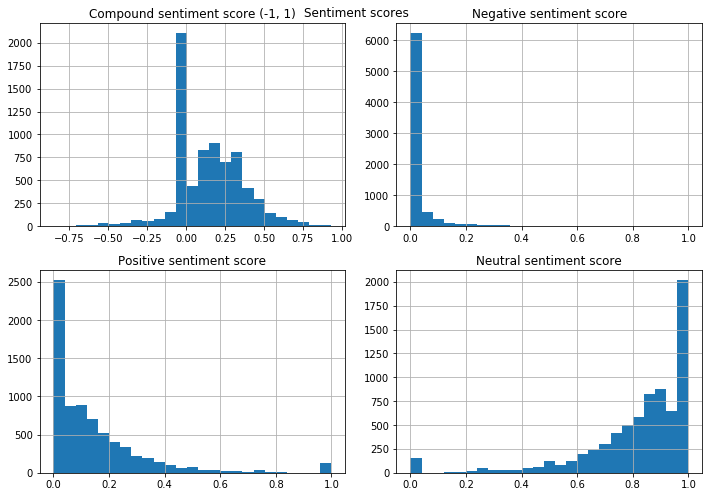

In [471]:
fig = plt.figure(1);
fig.set_size_inches(10, 7)

bins = 25

fig = plt.subplot(221);
_ = text_features['compound'].hist(bins = bins);
_ = plt.title('Compound sentiment score (-1, 1)')

fig = plt.subplot(222);
_ = text_features['neg'].hist(bins = bins);
_ = plt.title('Negative sentiment score')


fig = plt.subplot(223);
_ = text_features['pos'].hist(bins = bins);
_ = plt.title('Positive sentiment score')

fig = plt.subplot(224);
_ = text_features['neu'].hist(bins = bins);
_ = plt.title('Neutral sentiment score')

_ = plt.subplots_adjust(top=0.76)
_ = plt.suptitle('Sentiment scores')
_ = plt.tight_layout()

## Analysis of senders and receivers

In [472]:
text_features.head()

,caps,commas,ex_marks,msg_len,periods,q_marks,word_count,adj,adp,adv,cconj,det,intj,noun,num,part,pron,propn,punct,space,sym,verb,x,num_sentences,len_sentence_mean,num_recipients,send_gender,receive_gender,compound,neg,neu,pos,pair_index
0,1,0,0,20,0,0,4,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,4.0,1,male,male,0.0000,0.000,1.000000,0.0000,"(phillip.allen@enron.com, tim.belden@enron.com)"
1,12,1,0,773,10,0,140,10.0,13.0,15.0,7.0,16.0,0.0,35.0,0.0,5.0,5.0,1.0,11.0,0.0,0.0,33.0,0.0,10,13.9,1,male,male,0.2177,0.000,0.898700,0.1013,"(phillip.allen@enron.com, john.lavorato@enron...."
2,0,0,3,29,1,0,5,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,3,2.0,1,male,female,0.1953,0.000,0.402667,0.2640,"(phillip.allen@enron.com, leah.arsdall@enron.com)"
3,6,1,0,180,2,0,34,2.0,5.0,0.0,2.0,4.0,0.0,9.0,0.0,1.0,2.0,4.0,5.0,0.0,0.0,5.0,0.0,3,11.0,1,male,male,0.0000,0.000,1.000000,0.0000,"(phillip.allen@enron.com, randall.gay@enron.com)"
4,2,0,0,33,1,0,7,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,1,6.0,1,male,male,-0.3400,0.324,0.676000,0.0000,"(phillip.allen@enron.com, greg.piper@enron.com)"


In [473]:
indiv_pairs_index = []
for idx, pair in enumerate(all_pairs):
    if 'group' not in pair:
        indiv_pairs_index.append(idx)

In [474]:
len(all_pairs)
len(indiv_pairs_index)

7708

5784

### Tf-idf to get important terms

In [150]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer, SnowballStemmer

In [153]:
stemmer = SnowballStemmer('english')

def get_tokens_stems(text, tokenizer = word_tokenize,
                     stemmer = stemmer):
    
    #get tokens
    all_text = tokenizer(text)
    
    all_text = [stemmer.stem(word) for word in all_text]
    
    return all_text

In [478]:
stopwords = nltk.corpus.stopwords.words('english')
vectorizer = TfidfVectorizer(max_df = 0.8, min_df = 0.01, stop_words = stopwords,
                             tokenizer = get_tokens_stems, 
                             lowercase = True, max_features = 200000,
                             use_idf = True, ngram_range = (1, 3))

In [476]:
exclude = string.punctuation + '0123456789'
to_vectorize = []
for email in email_content:
    s = ''.join(ch for ch in email if ch not in exclude)
    s = s.strip()
    to_vectorize.append(s)

In [479]:
%time tfidf_matrix = vectorizer.fit_transform(to_vectorize)

tfidf_matrix.shape
terms = vectorizer.get_feature_names()

CPU times: user 11.5 s, sys: 95 ms, total: 11.6 s
Wall time: 11.7 s


(7708, 584)

## Clustering

DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

In [191]:
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.cluster import DBSCAN

Drop categorical columns, as clustering can't handle those features.

In [482]:
to_drop = ['send_gender', 'receive_gender', 'pair_index']
for_clustering = text_features.drop(to_drop, axis = 1)
tmp_matrix = for_clustering.as_matrix()

In [483]:
X_matrix = np.concatenate((tmp_matrix, tfidf_matrix.todense()), axis = 1)

In [484]:
imp = Imputer(missing_values = 'NaN', strategy = 'mean')
X_imp = imp.fit_transform(X_matrix)

scaler = StandardScaler()
X = scaler.fit_transform(X_imp)

In [496]:
db = DBSCAN(metric = 'cosine', min_samples = 10, eps = 0.05)
db.fit(X)
db_clusters = list(db.labels_)

DBSCAN(algorithm='auto', eps=0.05, leaf_size=30, metric='cosine',
    metric_params=None, min_samples=10, n_jobs=1, p=None)

In [497]:
db_clusters = pd.Series(db_clusters)
db_clusters.value_counts()

-1     6657
 0      765
 1       60
 2       43
 12      37
 5       33
 10      15
 8       15
 7       14
 6       14
 13      13
 4       12
 11      10
 3       10
 9       10
dtype: int64

In [220]:
def print_email(index):
    print('Message: ' + str(index))
    print('From: ' + emails[index]['From'])
    print('To: ')
    print(emails[index]['To'])
    print(emails[index]['parts'][0]['content'])

In [498]:
c_8 = db_clusters[db_clusters == 8].index
cluster_8 = [email_content[i] for i in c_8]
cluster_8

['Hey Melissa,',
 'Hey Janet,',
 'Hey Gillette,',
 'hey mom,',
 'hey jason,',
 'Hey Mom,',
 'Hey Sheila,',
 'Hey Yvette,',
 'Hey Paul,',
 'Hey Allison,',
 'Hey Aunt Bonnie,',
 'hey dad,',
 'Hey Brett,',
 'Hey,',
 'Hey Mitch,']

### Clustering without tf-idf features.

In [499]:
imp = Imputer(missing_values = 'NaN', strategy = 'mean')
X_imp2 = imp.fit_transform(tmp_matrix)

scaler = StandardScaler()
X_no_tfidf = scaler.fit_transform(X_imp2)

In [506]:
db2 = DBSCAN(metric = 'cosine', min_samples = 10, eps = 0.05)
db2.fit(X_no_tfidf)
db_clusters2 = list(db2.labels_)

DBSCAN(algorithm='auto', eps=0.05, leaf_size=30, metric='cosine',
    metric_params=None, min_samples=10, n_jobs=1, p=None)

In [525]:
joblib.dump(db2, 'dbscan_no_tfidf.pkl');

#### Visualization of clusters with t-SNE

In [514]:
learning_rates = [100, 250, 500, 750, 1000]
fitted_tsnes = []

for rate in learning_rates:
    tsne = TSNE(learning_rate = rate)
    fitted_tsnes.append(tsne.fit_transform(X_no_tfidf))

In [515]:
# colors = []
# for i in range(len(db_clusters2)):
#     colors.append(gen.generate_new_color(colors, pastel_factor = 0.9))

In [524]:
#save colors and t-SNE models
joblib.dump(fitted_tsnes, 'fitted_tsnes.pkl');
joblib.dump(colors, 'colors_for_tsne.pkl');

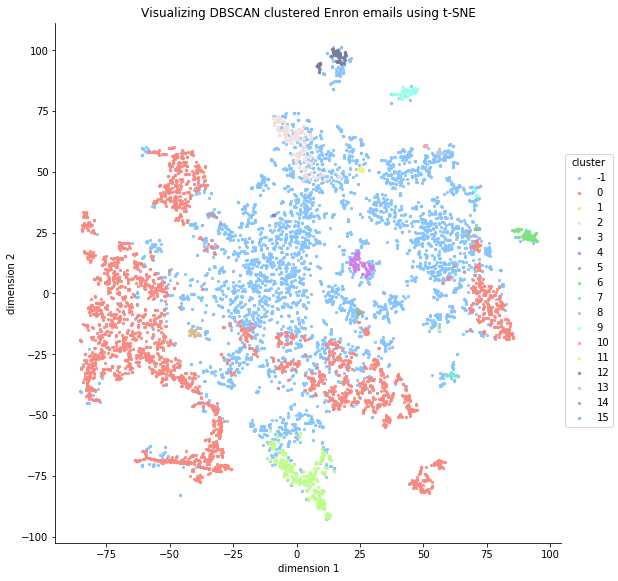

In [521]:
#for i in range(len(fitted_tsnes)):
#use learning_rate = 1000
tsne_df = pd.DataFrame(fitted_tsnes[-1], columns = ['dimension 1', 'dimension 2'])
tsne_df['cluster'] = db_clusters2

ax = sns.lmplot('dimension 1', 'dimension 2', tsne_df,
                hue = 'cluster',
                fit_reg = False, palette = colors, 
                size = 8, scatter_kws = {'alpha':0.9, 's':5})
_ = ax.set(title = 'Visualizing DBSCAN clustered Enron emails using t-SNE')
#plt.savefig('tsne.png')

### Analyzing emails per cluster

In [507]:
db_clusters2 = pd.Series(db_clusters2)
db_clusters2.value_counts()

-1     3870
 0     2988
 1      285
 2      159
 4       78
 3       72
 9       66
 6       61
 8       27
 11      18
 7       18
 5       14
 13      13
 15      11
 10      10
 12      10
 14       8
dtype: int64

In [512]:
c_0 = db_clusters2[db_clusters2 == 0].index
cluster_0 = [email_content[i] for i in c_0]
cluster_0

['Here is our forecast',
 'Randy, Can you send me a schedule of the salary and level of everyone in the scheduling group. Plus your thoughts on any changes that need to be made. (Patti S for example) Phillip',
 'Greg, How about either next Tuesday or Thursday? Phillip',
 'any morning between 10 and 11:30',
 '',
 '',
 'Dave, Here are the names of the west desk members by category. The origination side is very sparse. Phillip',
 'Paula, 35 million is fine Phillip',
 '',
 '',
 'I think Fletch has a good CPA. I am still doing my own.',
 '',
 '',
 'Nymex expiration is during this time frame. Please reschedule.',
 '',
 'Greg, Happy B-day. Email me your phone # and I will call you. Keith',
 'Jeff, What is up with Burnet? Phillip',
 '',
 'http:.hearme.com/vc2/?chnlOwnr=pallen.com',
 '',
 'Ina, I scheduled a meeting with Jean Mrha tomorrow at 3:30',
 '',
 'Ina,',
 'resumes of whom?',
 '',
 '',
 'Richard, Compare your california production to the numbers in the 2000 California Gas Report. It sho

In [511]:
c_6 = db_clusters2[db_clusters2 == 6].index
cluster_6 = [email_content[i] for i in c_6]
cluster_6

['yea, how about 3:30?',
 "Hello: I am John Arnold. I believe you're looking for Jeff Arnold.",
 "yep...i'm always here",
 'Yea...can you come by around 5:30?',
 "Cliff: I have 4 tix to the Black Crowes for you, third row center. Where's your office now? I'll come up and say hello this afternoon if you have a minute. John",
 'Thanks...anxiously awaiting',
 "Hey: Do you have any extras for tonight's game? John PS. How's you bowl",
 "Hey: Do you have JP's email address? John",
 'yea',
 'huh?',
 'hey podner: where are you buying me dinner tonight?',
 'heffner a little bullish, eh?',
 "yea, i'll talk to them.",
 'yea',
 'huh?',
 'hey: what was the first cd we listened to on Wednesday at my place? john',
 'gb -7 200 denver -7 200',
 'Hi John,',
 "yea, we'll get them for you",
 "yea...for now at least. We'll run it until a hurricane emerges overnight and I get run over for 30 cents",
 'yea, i interviewed him. i gave him a thumbs up. why do you ask?',
 "yea, i'd be willing to take a look at a

In [508]:
c_8 = db_clusters2[db_clusters2 == 8].index
cluster_8 = [email_content[i] for i in c_8]
cluster_8

['world cup 2006 Germany BOO!',
 "Here is some info on steamboat. I haven't checked affair yet. The Sunburst cono looks reasonable!",
 'vacation!',
 'DONE! Anything else Entex man?',
 'http:.cnn.com/2000/bowl_projections/ just wanted to let you know that lsu is still projected to go to the sharpie bowl!',
 'here, woman!',
 'here is where we are staying in telluride!',
 "I don't know yet, I will probably know sometime next week. I will keep you posted!",
 'i told you so!',
 'guess who sent me this!',
 'i bet you score over 200!',
 'Our first flag football game is tonight! Are you in?',
 'tell your roommate to shut her big mouth!',
 "Hook 'em!",
 'that could be a dealbreaker!',
 "I can't make this meeting today - bid week!",
 'Look at this pup!',
 'Go Longhorns! - only in TEXAS.jpg',
 'old one. thanks!.',
 'you are an asshole !',
 'redwood grill!',
 'Gracias amigo!',
 'Got it!',
 'I am not available to interview on December 7th. I will be in a PRC meeting. Try me next time! Sally',
 'I w

In [510]:
c_7 = db_clusters2[db_clusters2 == 7].index
cluster_7 = [email_content[i] for i in c_7]
cluster_7

['why does everybody in this company know my p&l?????',
 'Absolutely. Come by around 3:30??',
 'why would i be???',
 'when are we invited??',
 'who were you trying to bet on??',
 'Oak -11 or Atl +11 ????',
 'Dinner tonite....birthday boy???',
 'How about 4:00 ??',
 '7:00 game can you let me know tomorrow??',
 'newport??',
 'I ordered 3 different things...I thought your "wine inventory listings are updated DAILY" ???',
 'fill me in. how can i eavesdrop??',
 'how about your local bank??',
 'can you have Kathy Gribstald (?) send me an electronic copy of the picture that appeared in the Enside mag??',
 'How about next wednesday??',
 '4:30ish??',
 'for your info . . . how are you today?',
 'Garner and Glenn for T.D. ?']

In [552]:
one_email = len(text_features.groupby('sender').filter(lambda x: len(x) == 1))
print('There are {0} people who only sent a single email in the Enron dataset, \
which is {1:.2%} of all unique senders.'.format(one_email, one_email / text_features['sender'].nunique()))

There are 302 people who only sent a single email in the Enron dataset, which is 45.83% of all unique senders.


### Kmeans w/o tfidf

In [157]:
from sklearn.decomposition import PCA
import scikitplot.plotters as skplt
from scikitplot import clustering_factory
from sklearn.cluster import MiniBatchKMeans, KMeans

In [57]:
to_drop = ['send_gender', 'receive_gender', 'pair_index']
for_clustering = text_features.drop(to_drop, axis = 1)
X_matrix = for_clustering.as_matrix()

In [58]:
imp = Imputer(missing_values = 'NaN', strategy = 'mean')
X_imp = imp.fit_transform(X_matrix)

scaler = StandardScaler()
X_pca = scaler.fit_transform(X_imp)

pca = PCA()
pca_fit = pca.fit(X_pca)

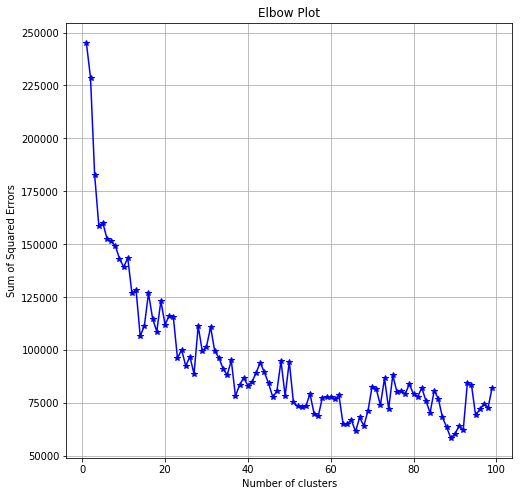

In [59]:
kmeans = clustering_factory(MiniBatchKMeans(random_state = 1))
kmeans_plot = kmeans.plot_elbow_curve(X_kmeans, 
                                      cluster_ranges = range(1, 100), 
                                      figsize = (8, 8))

In [60]:
num_clusters = 30
km = KMeans(n_clusters = num_clusters, random_state = 1)
%time km.fit(X_kmeans)

CPU times: user 1.67 s, sys: 35.7 ms, total: 1.71 s
Wall time: 1.7 s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=30, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

In [61]:
clusters = km.labels_.tolist()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = for_clustering.columns.tolist()

In [62]:
cluster_values = pd.DataFrame()
for i in range(num_clusters):
    centroid_values = []
    for idx in order_centroids[i]:
        centroid_values.append(terms[idx])
    cluster_values['cluster ' + str(i)] = centroid_values

cluster_values.head()

,cluster 0,cluster 1,cluster 2,cluster 3,cluster 4,cluster 5,cluster 6,cluster 7,cluster 8,cluster 9,cluster 10,cluster 11,cluster 12,cluster 13,cluster 14,cluster 15,cluster 16,cluster 17,cluster 18,cluster 19,cluster 20,cluster 21,cluster 22,cluster 23,cluster 24,cluster 25,cluster 26,cluster 27,cluster 28,cluster 29
0,neg,pron,adv,neu,adp,noun,len_sentence_mean,adv,x,neg,cconj,pos,pos,propn,punct,num_recipients,ex_marks,num,x,sym,sym,space,sym,num_sentences,q_marks,neu,num_recipients,num,part,commas
1,x,intj,verb,x,verb,cconj,commas,num_sentences,punct,len_sentence_mean,verb,compound,compound,caps,ex_marks,periods,periods,caps,periods,num,commas,len_sentence_mean,propn,pron,num_sentences,compound,compound,periods,noun,propn
2,num_recipients,verb,adj,num_recipients,word_count,msg_len,propn,verb,ex_marks,ex_marks,adp,ex_marks,intj,commas,msg_len,num,num_sentences,periods,num_sentences,periods,caps,propn,caps,periods,adj,num_recipients,pos,propn,msg_len,caps
3,ex_marks,num_sentences,adp,q_marks,msg_len,det,caps,det,intj,x,noun,num_recipients,num_recipients,punct,x,adj,punct,neg,msg_len,intj,propn,caps,commas,adj,noun,x,len_sentence_mean,num_sentences,word_count,len_sentence_mean
4,sym,part,noun,sym,noun,adp,compound,part,msg_len,q_marks,word_count,x,ex_marks,len_sentence_mean,periods,noun,pron,propn,punct,punct,len_sentence_mean,intj,num,det,punct,len_sentence_mean,intj,caps,adp,punct


## MongoDB

In [10]:
def mongo(db, cmd):
    r = envoy.run("mongo %s --eval 'printjson(%s)'" % (db, cmd,))
    print(r.std_out)
    if r.std_err: print(r.std_err)
    
mongo('enron', 'db.mbox.stats()')

MongoDB shell version v3.4.9
connecting to: mongodb://127.0.0.1:27017/enron
MongoDB server version: 3.4.9
{
	"ns" : "enron.mbox",
	"size" : 27409137,
	"count" : 12017,
	"avgObjSize" : 2280,
	"storageSize" : 15396864,
	"capped" : false,
	"wiredTiger" : {
		"metadata" : {
			"formatVersion" : 1
		},
		"creationString" : "access_pattern_hint=none,allocation_size=4KB,app_metadata=(formatVersion=1),block_allocation=best,block_compressor=snappy,cache_resident=false,checksum=on,colgroups=,collator=,columns=,dictionary=0,encryption=(keyid=,name=),exclusive=false,extractor=,format=btree,huffman_key=,huffman_value=,ignore_in_memory_cache_size=false,immutable=false,internal_item_max=0,internal_key_max=0,internal_key_truncate=true,internal_page_max=4KB,key_format=q,key_gap=10,leaf_item_max=0,leaf_key_max=0,leaf_page_max=32KB,leaf_value_max=64MB,log=(enabled=true),lsm=(auto_throttle=true,bloom=true,bloom_bit_count=16,bloom_config=,bloom_hash_count=8,bloom_oldest=false,chunk_count_limit=0,chunk_max=

In [14]:
import json
import pymongo
from bson import json_util
from datetime import datetime as dt

In [22]:
# Connects to the MongoDB server running on 
# localhost:27017 by default

client = pymongo.MongoClient()

# Get a reference to the enron database

db = client.enron

# Reference the mbox collection in the Enron database

mbox = db.mbox

# The number of messages in the collection

print("Number of messages in mbox:")
print(mbox.count())
print()

msg = mbox.find_one()

print("A message:")
print(json.dumps(msg, indent=1, default=json_util.default))

Number of messages in mbox:
12017

A message:
{
 "_id": {
  "$oid": "59bc01b3c49f00d722b21188"
 },
 "parts": [
  {
   "contentType": "text/plain",
   "content": "Traveling to have a business meeting takes the fun out of the trip.  Especially if you have to prepare a presentation.  I would suggest holding the business plan meetings here then take a trip without any formal business meetings.  I would even try and get some honest opinions on whether a trip is even desired or necessary.\n\nAs far as the business meetings, I think it would be more productive to try and stimulate discussions across the different groups about what is working and what is not.  Too often the presenter speaks and the others are quiet just waiting for their turn.   The meetings might be better if held in a round table discussion format.  \n\nMy suggestion for where to go is Austin.  Play golf and rent a ski boat and jet ski's.  Flying somewhere takes too much time.\n\n"
  }
 ],
 "Message-ID": "<15464986.107585537

In [15]:
start_date = dt(2001, 4, 1) # Year, Month, Day
end_date = dt(2001, 4, 2) # Year, Month, Day

# Query the database with the highly versatile "find" command,
# just like in the MongoDB shell.

msgs = [ msg 
         for msg in mbox.find({"Date" : 
                                  {
                                   "$lt" : end_date, 
                                   "$gt" : start_date
                                  }
                              }).sort("date")]

# Create a convenience function to make pretty-printing JSON a little
# less cumbersome

def pp(o, indent=1):
    print(json.dumps(msgs, indent=indent, default=json_util.default))
    
pp(msgs)   

[]


In [48]:
senders = [ i for i in mbox.distinct("From") ]

receivers = [ i for i in mbox.distinct("To") ]

len(senders)
len(receivers)

1158

6938

In [50]:
pairs = []
for sender in senders:
    pair = mbox.aggregate([
        { '$match': {'From':sender} },
        { "$project" : {"From" : 1, "To" : 1} },
        { "$group" : {"_id" : "$From", "recipients" : {"$addToSet" : "$To" } }  }
    ])
    pairs.append(pairs)

In [57]:
pair = mbox.aggregate([
        { '$match': {'From':senders[0]} },
        { "$project" : {"From" : 1, "To" : 1} },
        { "$group" : {"_id" : "$From", "recipients" : {"$addToSet" : "$To" } }  }
    ])



In [62]:
unique_recipients = db.mbox.aggregate([
  {"$match" : {"From" : senders[0]} }, 
  {"$project" : {"From" : 1, "To" : 1} }, 
  {"$unwind" : "$To"}, 
  {"$group" : {"_id" : "From", "recipients" : {"$addToSet" : "$To"}} }
])
unique_recipients

In [64]:
recipients = []
for recipient in unique_recipients:
    recipients.append(recipient)
    
recipients[0]

{'_id': 'From',
 'recipients': ['mary@enron.com',
  'john.arnold@enron.com',
  'paul.lucci@enron.com',
  'andy.zipper@enron.com',
  'bob.m.hall@enron.com',
  'frank.davis@enron.com',
  'anne.bike@enron.com',
  'bob.schorr@enron.com',
  'mike.grigsby@enron.com',
  'scott.tholan@enron.com',
  'paul.kaufman@enron.com',
  'llewter@palm.net',
  'tori.kuykendall@enron.com',
  'fescofield@1411west.com',
  'tbland@enron.com',
  'chad.landry@enron.com',
  'kristin.walsh@enron.com',
  'ben.jacoby@enron.com',
  'sally.beck@enron.com',
  'pallen@hotmail.com',
  'gallen@thermon.com',
  'lodonnell@spbank.com',
  'scott.neal@enron.com',
  'body.shop@enron.com',
  'jhershey@sempratrading.com',
  'stephen.stock@enron.com',
  'ray.alvarez@enron.com',
  'jeff.richter@enron.com',
  'tara.piazze@enron.com',
  'jason.moore@enron.com',
  'susan.mara@enron.com',
  'greg.piper@enron.com',
  'steven.kean@enron.com',
  'ywang@enron.com',
  'jedglick@hotmail.com',
  'richard.sanders@enron.com',
  'pallen@enron.co

In [42]:
# Find the number of senders who were also direct receivers

senders_intersect_receivers = senders.intersection(receivers)

# Find the senders that didn't receive any messages

senders_diff_receivers = senders.difference(receivers)

# Find the receivers that didn't send any messages

receivers_diff_senders = receivers.difference(senders)

In [31]:
len(senders_intersect_receivers)
len(senders_diff_receivers)
len(receivers_diff_senders)

716

442

6222

In [33]:
emails_dict = {'emails':emails}
#json.dumps(emails_dict)
with open('emails_dict.json', 'w') as file:
    json.dump(emails_dict, file)